#Modelo con flores grises e interacción

Agregamos una tercera especie de planta, que no tiene albedo (es igual al del terreno fértil) y por lo tanto no contribuye a la temperatura global pero sí compiten por espacio con las otras. Esta inclusión le agrega realismo al modelo pues supone la existencia de especies que no contribuyen a mantener la temperatura en niveles habitables.

In [17]:
%pylab inline
import numpy as np
import copy
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
from IPython.html import widgets
from JSAnimation import IPython_display
from matplotlib import animation

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [22]:
class Planeta:
    #agregamos una tercera planta al ciclo planetario, sin alterarlo
    def __init__(self,plantas, albedo_f, luminosidad, prop_fertil, q = 15, boltz = 5.67e-8):
        self.blanca = plantas[0]
        self.negra = plantas[1]
        self.cheat = plantas[2]
        self.albedo_f = albedo_f
        self.luminosidad = luminosidad
        self.boltz = boltz
        self.albedo_p = None
        self.temp_g = []
        self.temp_g_vacio = []
        self.q = q
        self.prop_fertil = prop_fertil
        self.area_blanca = []
        self.area_negra = []
        self.area_cheat = []
        self.step = 0
        
    def actualiza_temp_g(self): #Se basa en las mismas ecuaciones que el modelo basico
        self.temp_g = np.append(self.temp_g,((self.luminosidad[self.step]/(self.boltz))*(1 - self.albedo_p))**0.25 )
        
    def temp_planeta_vacio(self):
        for i in self.luminosidad:
            self.temp_g_vacio = np.append(self.temp_g_vacio,((i/(self.boltz))*(0.5))**0.25 )
    
    def actualiza_albedo_p(self):
        self.prop_fertil = 1 - self.blanca.prop_area - self.negra.prop_area - self.cheat.prop_area
        self.albedo_p = self.blanca.prop_area*self.blanca.albedo + self.negra.prop_area*self.negra.albedo + (self.prop_fertil + self.cheat.prop_area)*self.albedo_f

    def vivir(self):
        for i in self.luminosidad:
            self.actualiza_albedo_p()
            self.actualiza_temp_g()
            self.blanca.actualizar(self)
            self.negra.actualizar(self)
            self.cheat.actualizar(self)
            self.area_blanca = np.append(self.area_blanca,self.blanca.prop_area)
            self.area_negra = np.append(self.area_negra,self.negra.prop_area)
            self.area_cheat = np.append(self.area_cheat,self.cheat.prop_area)
            self.step += 1
    
    def graficar_areas(self):
        plt.figure(figsize=(8, 6), dpi=80)
        plt.plot(self.luminosidad, self.area_blanca, linewidth = 1.5, label = "Blancas")
        plt.plot(self.luminosidad, self.area_negra, linewidth = 1.5, label = "Negras")
        plt.plot(self.luminosidad, self.area_cheat, color = "grey", linewidth = 1.5, label = "Grises")
        plt.plot(self.luminosidad, self.area_blanca + self.area_negra + self.area_cheat, color = "red", linewidth = 1.5, label = "Total de area cubierta")
        plt.legend(loc='best')
        plt.ylabel("Proporcion de area cubierta")
        plt.xlabel("Luminosidad solar")
        
    def graficar_mundo(self):
        """
        No necesita argumentos.
        Grafica las proporciones de àrea de los tres tipos de planta
        y la comparaciòn entre Daisyworld y un planeta sin seres vivos.
        """
        
        self.temp_planeta_vacio()
        grafica_mundo, ax = plt.subplots(2, sharex = True,figsize=(14,20))
        ax[0].plot(self.luminosidad, self.area_blanca)
        ax[0].plot(self.luminosidad, self.area_negra)
        ax[0].plot(self.luminosidad, self.area_cheat)
        ax[0].plot(self.luminosidad, self.area_blanca + self.area_negra + self.area_cheat)
        ax[0].set_ylabel("Proporcion de area cubierta")
        ax[0].legend(["Area blanca","Area negra","Area gris","Area total"])
        ax[1].plot(self.luminosidad,self.temp_g, color = "blue", linewidth = 1.5, label = "DaisyWorld")
        ax[1].plot(self.luminosidad, self.temp_g_vacio, color = "red", linewidth = 1.5, label = "Mundo vacio")
        ax[1].legend(["DaisyWorld","Mundo Vacio"])
        ax[1].set_ylabel("Temperatura global (K)")
        ax[1].set_xlabel("Luminosidad solar")

In [23]:
class Planta:
    #La clase Planta queda definida igual
    def __init__(self, color, albedo, prop_area, tasa_muerte = 0.1, superior = 313, inferior = 278):
        self.color = color
        self.albedo = albedo
        self.prop_area = prop_area
        self.tasa_muerte = tasa_muerte
        self.superior = superior
        self.inferior = inferior
           
    def actualiza_temp_l(self, mundo):
        self.temp_l = mundo.q * (mundo.albedo_p - self.albedo) + mundo.temp_g[mundo.step]
        
    def actualiza_taza_cre(self):
        if self.temp_l > self.inferior and self.temp_l < self.superior :
            self.tasa_cre = (self.temp_l - self.inferior) * (self.superior - self.temp_l) * 4 / (self.inferior -self.superior)**2
        else:
            self.tasa_cre = 0          
            
    def actualiza_area(self,mundo):
        self.dif_area = self.prop_area*(self.tasa_cre * mundo.prop_fertil - self.tasa_muerte)
        self.prop_area = self.prop_area  + self.dif_area
        if self.prop_area <= 0.01:
            self.prop_area = 0.01
        if self.prop_area >= .99:
            self.prop_area = .99

    def actualizar(self,mundo):
        self.actualiza_temp_l(mundo)
        self.actualiza_taza_cre()
        self.actualiza_area(mundo)

#Primera iteración
###Aleatorizamos las propociones de área iniciales

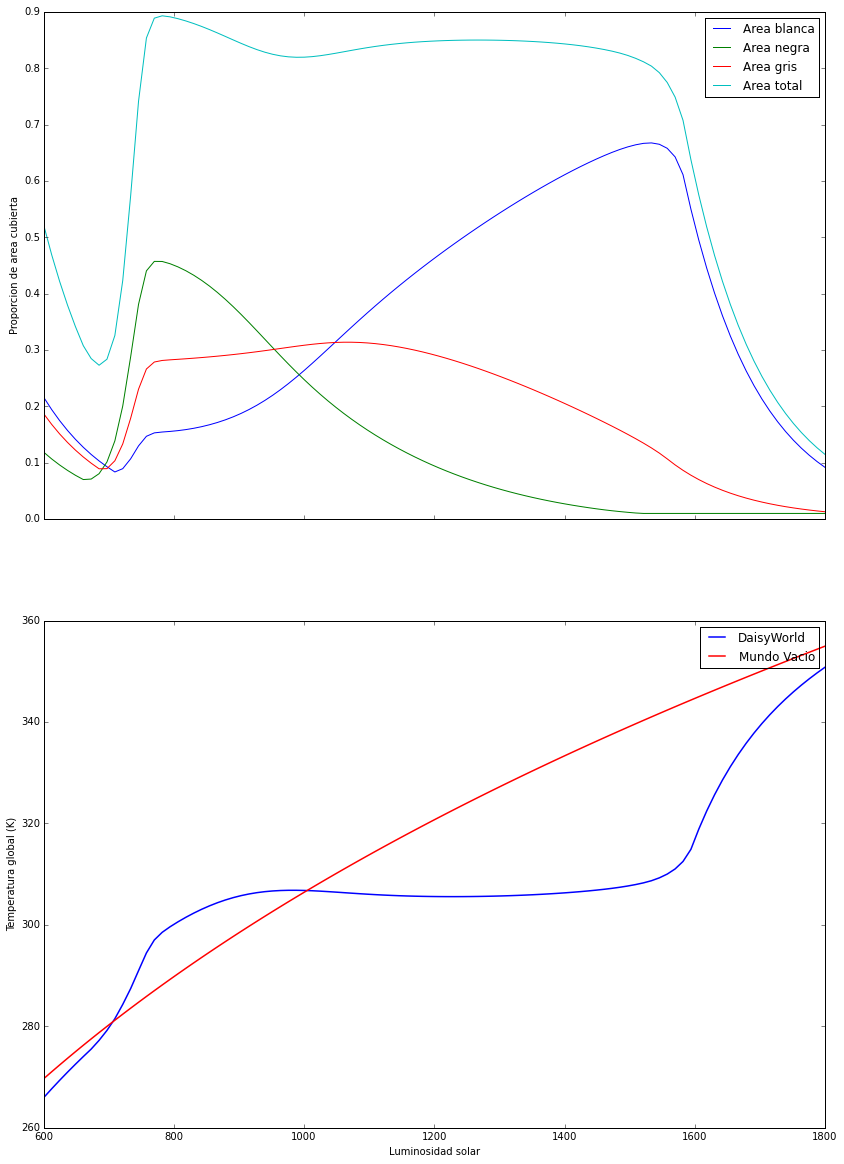

In [24]:
area_n = np.random.rand()
area_b = np.random.rand()
area_g = np.random.rand()
while (area_n + area_b + area_g) > 1: #nos aseguramos que los valores aleatorios no rebasen el límite de área total
    area_n = np.random.rand()
    area_b = np.random.rand()
    area_g = np.random.rand()
area_f = 1 - (area_n + area_b + area_g)

negra = Planta("negra",.25, area_n)
cheat = Planta("cheat", 0.5, area_g) #Aquì se crea una planta gris, con albedo igual al de la tierra fertil
blanca = Planta("blanca",.75, area_b)

luminosidad = np.linspace(.6,1.8,100)
luminosidad *= 1000
plantas = [blanca, negra, cheat]

planeta_cheats = Planeta(plantas, 0.5, luminosidad, area_f)
planeta_cheats.vivir()
planeta_cheats.graficar_mundo()

#Resultados

Los resultados no camian a pesar de la competencia extra que significan las margaritas grises. La temperatura global se mantiene estable para una variedad de condiciones iniciales; con las que se puede jugar a continuación.

#Código interactivo
###Permitimos ajustar las condiciones iniciales

Las condiciones iniciales por *default* son:

area_inicial_blanca = area_inicial_negra = area_inicial_gris = 0.01

tasa_muerte_blanca = tasa_muerte_negra = tasa_muerte_gris = 0.1

Estos valores iniciales reproducen los resultados originales, pero su interación en valores distintos arroja resultados interesantes.

La suma de las tres áreas iniciales debe ser menor a uno para que corra el modelo.

In [7]:
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

In [8]:
def interactivo(area_inicial_blanca,area_inicial_negra,area_inicial_gris, tasa_muerte_blanca,tasa_muerte_negra,tasa_muerte_gris):
    assert 0 < area_inicial_blanca + area_inicial_negra + area_inicial_gris < 1
    assert 0< tasa_muerte_blanca < 1
    assert 0< tasa_muerte_negra < 1
    assert 0< tasa_muerte_gris < 1
    
    area_f = 1 - (area_inicial_blanca + area_inicial_negra + area_inicial_gris)
    
    print "Total de area cubierta = " + str(area_inicial_blanca +area_inicial_negra + area_inicial_gris) + " (< 1 para que corra)"

    
    negra = Planta("negra",.25, area_inicial_negra, tasa_muerte = tasa_muerte_negra)
    cheat = Planta("cheat", 0.5, area_inicial_gris, tasa_muerte = tasa_muerte_gris)
    blanca = Planta("blanca",.75, area_inicial_blanca, tasa_muerte = tasa_muerte_blanca)
    
    luminosidad = np.linspace(.6,1.8,500)
    luminosidad *= 1000
    plantas = [blanca, negra, cheat]
    
    mundo = Planeta(plantas, 0.5, luminosidad, area_f)
    mundo.vivir()
    mundo.graficar_mundo()
   

Total de area cubierta = 0.03 (< 1 para que corra)


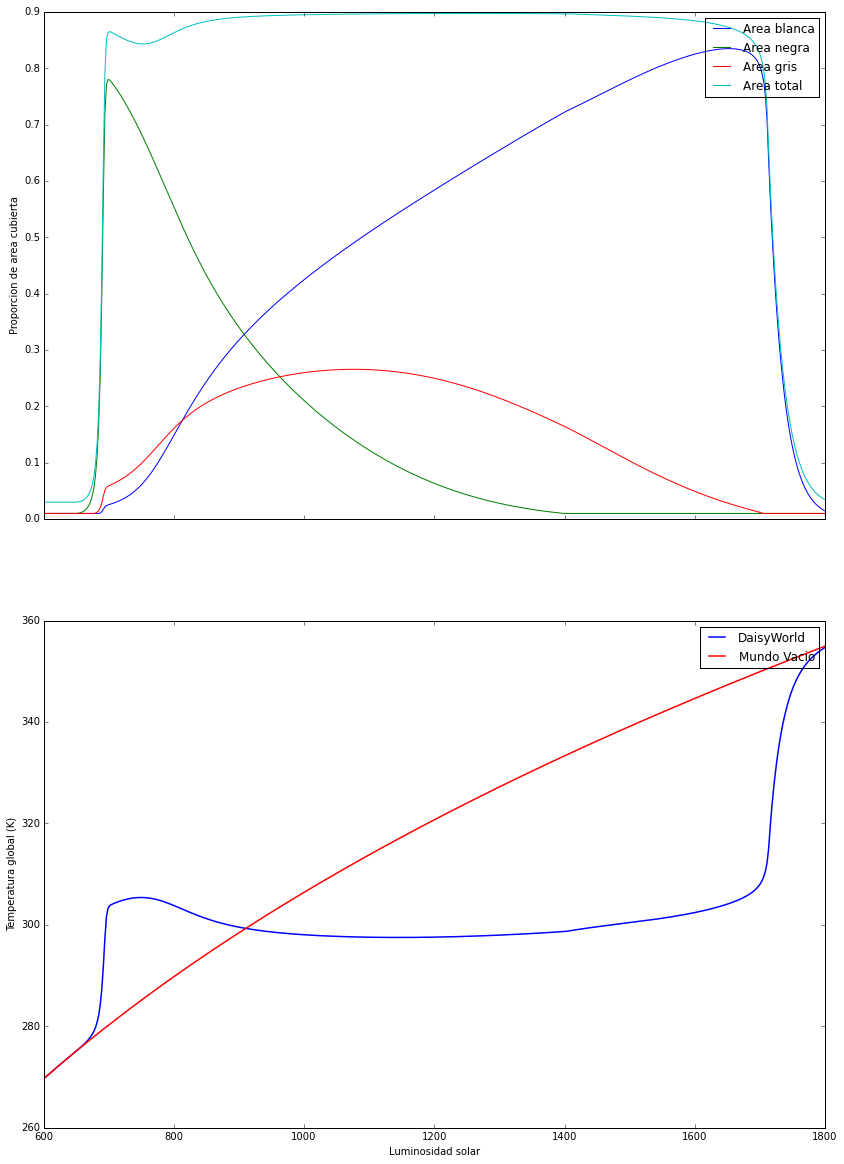

In [9]:
interact(interactivo, area_inicial_blanca = (.01,.9,.01), area_inicial_negra = (.01,.9,.01), area_inicial_gris = (.01,.9,.01), tasa_muerte_blanca = (.01,.99,.01),tasa_muerte_negra = (.01,.99,.01),tasa_muerte_gris = (.01,.99,.01))

#Simulación espacial

Discretizamos los vectores de áreas, para obtener 4 vectores: margaritas blancas,negras, grises y tierra fertiles. Cada elemento del vector significa el número de margaritas o lugares fertiles que hay en un momento determinado.

In [10]:
area_blanca= np.array(primer_intento.area_blanca)*100
area_blanca = np.round(area_blanca).astype(int)
area_negra= np.array(primer_intento.area_negra)*100
area_negra = np.round(area_negra).astype(int)
area_gris= np.array(primer_intento.area_cheat)*100
area_gris = np.round(area_gris).astype(int)
area_fertil = np.ones(100)*100 - area_blanca - area_negra - area_gris
area_fertil = area_fertil.astype(int)


Convertimos los vectores a coordenadas

In [11]:
class Mundo2:
    def __init__(self, agentes,ar_negra,ar_blanca,ar_gris,ar_fertil, ancho=15, alto=15, steps=100,metodo=0):
        self.agentes = agentes
        self.ancho = ancho
        self.alto = alto
        self.steps = steps
        self.ar_negra = ar_negra
        self.ar_blanca = ar_blanca
        self.ar_gris = ar_gris
        self.ar_fertil = ar_fertil
        self.metodo = metodo
        self.init_anim()
            
    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
        self.ax.set_axis_bgcolor('azure')
        plot_args = {'markersize' : 8, 'alpha' : 1}
        self.puntos_0, = self.ax.plot([], [], 'o', markerfacecolor='white', **plot_args)
        self.puntos_1, = self.ax.plot([], [], 'o', markerfacecolor='black', **plot_args)
        self.puntos_2, = self.ax.plot([], [], 'o', markerfacecolor='red', **plot_args)
        self.puntos_3, = self.ax.plot([], [], 'o', markerfacecolor='gray', **plot_args)
        

    def dibujar(self, step):
        x_values_0, y_values_0 = [], [] #Margaritas negras
        x_values_1, y_values_1 = [], []#Margaritas blancas
        x_values_2, y_values_2 = [], []#Lugares Fertiles
        x_values_3, y_values_3 = [], []#Lugares Fertiles
        
        for agente in self.agentes:
            x, y = agente.locacion
            if agente.tipo == 0: #Dependiendo del tipo de planta que es, lo agrego a su respectiva lista
                x_values_0.append(x)
                y_values_0.append(y)
                
            if agente.tipo == 1:
                    x_values_1.append(x)
                    y_values_1.append(y)
            if agente.tipo == 2:
                    x_values_2.append(x)
                    y_values_2.append(y)  
            if agente.tipo == 3:
                    x_values_3.append(x)
                    y_values_3.append(y)  
            
        self.puntos_0.set_data(x_values_1, y_values_1)
        self.puntos_1.set_data(x_values_0, y_values_0)
        self.puntos_2.set_data(x_values_2, y_values_2)
        self.puntos_3.set_data(x_values_3, y_values_3)
       
        self.ax.set_title('Tiempo {}'.format(step))
        
        return 
       
    def actualizar(self, step):   
        self.dibujar(step) 
        if self.metodo==0:#Dependiento de la forma de seleccionar escojo el metodo
            pos = obtener_posiciones(self.ar_negra,self.ar_blanca,self.ar_gris,self.ar_fertil,step)#Obtengo las posiciones 
                                                                                      #en el instante step
        else:
            pos = obtener_posiciones_2(self.ar_negra,self.ar_blanca,self.ar_gris,self.ar_fertil,step)
        for i in range(len(pos[0])):
            self.agentes[i].actualizar(0,pos[0][i])#Agrego las coordendas que resultaron del proceso de seleccióm
        for i in range(len(pos[1])):
            self.agentes[i+len(pos[0])].actualizar(1,pos[1][i])
        for i in range(len(pos[2])):
            self.agentes[i+len(pos[0])+len(pos[1])].actualizar(2,pos[2][i])
        for i in range(len(pos[3])):
            self.agentes[i+len(pos[0])+len(pos[1])+len(pos[2])].actualizar(3,pos[3][i])       
            
            
    
    def clean_screen(self):
        self.puntos_0.set_data([], [])
        self.puntos_1.set_data([], [])
        self.puntos_2.set_data([], [])
        self.puntos_3.set_data([], [])
        
        return 
          
    def simular(self):
        anim = animation.FuncAnimation(self.fig, self.actualizar, init_func=self.clean_screen, frames=self.steps, interval=1000, blit=True)
        return anim

In [12]:
class Agente:
    """ Agente general """
    def __init__(self, tipo, locacion):
        self.tipo = tipo
        self.locacion = np.array(locacion)
     
    def actualizar(self, tipo,locacion):
        self.tipo = tipo
        self.locacion = np.array(locacion)

In [13]:
def obtener_posiciones_2(area_negra,area_blanca,area_gris,area_fertil,step):#Selecciono de forma ordenada
    negras = area_negra[step]
    blancas = area_blanca[step]
    gris = area_gris[step]
    
    fertil = 100-negras-blancas
    posiciones = [(i+.5,j+.5) for i in range(0,10)for j in range(0,10)]
    po_neg=[]
    for i in  range(negras): 
        po_neg.append(posiciones[i])#Escojo mis margaritas de forma ordenada
    po_blan = []
    for i in  range(blancas):
        po_blan.append(posiciones[i+negras])
    po_gri = []    
    for i in range(gris):
        po_gri.append(posiciones[i+negras+blancas])
    posiciones=posiciones[negras+blancas + gris:] #Hago un slicing para escoger los lugares fertiles
    return po_neg,po_blan,posiciones,po_gri

In [14]:
def obtener_posiciones(area_negra,area_blanca,area_gris,area_fertil,step): #Selecciono de forma aleatoria
    negras = area_negra[step] #Obtengo el número de margaritas que existen en el tiempo "step" para cada color
    blancas = area_blanca[step]
    gris = area_gris[step]
    fertil = 100-negras-blancas
    posiciones = [(i+.5,j+.5) for i in range(0,10)for j in range(0,10)]#Genero mi lista de 100 elementos
    po_neg=[]
    for i in  range(negras): 
        n = np.random.choice(100-i) #Escojo un número aleatorio "n"
        po_neg.append(posiciones.pop(n))  #La margarita "n" sera de color negro, elimino esa coordenada 
    po_blan = []
    k = 100-negras #Solo hay disponibles este número de coordendas
    for i in  range(blancas):
        n = np.random.choice(k-i)
        po_blan.append(posiciones.pop(n))#Pinto las margaritas 
    k = 100-negras-blancas
    po_gris=[]
    for i in  range(gris):
        n = np.random.choice(k-i)
        po_gris.append(posiciones.pop(n))#Pinto las margaritas blancas
        
    return po_neg,po_blan,posiciones,po_gris#Regreso mis listas

#Simulación del mundo en forma ordenada



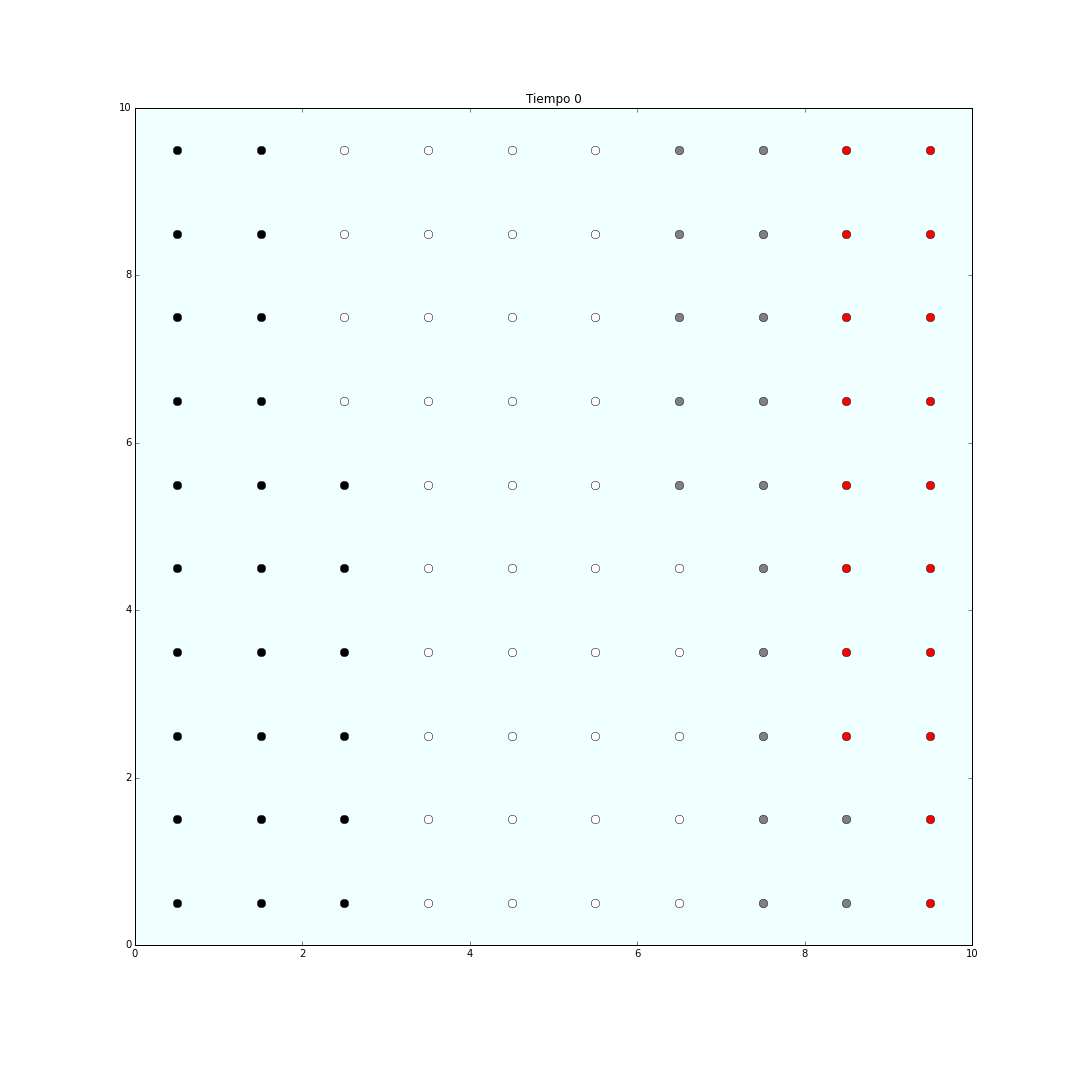
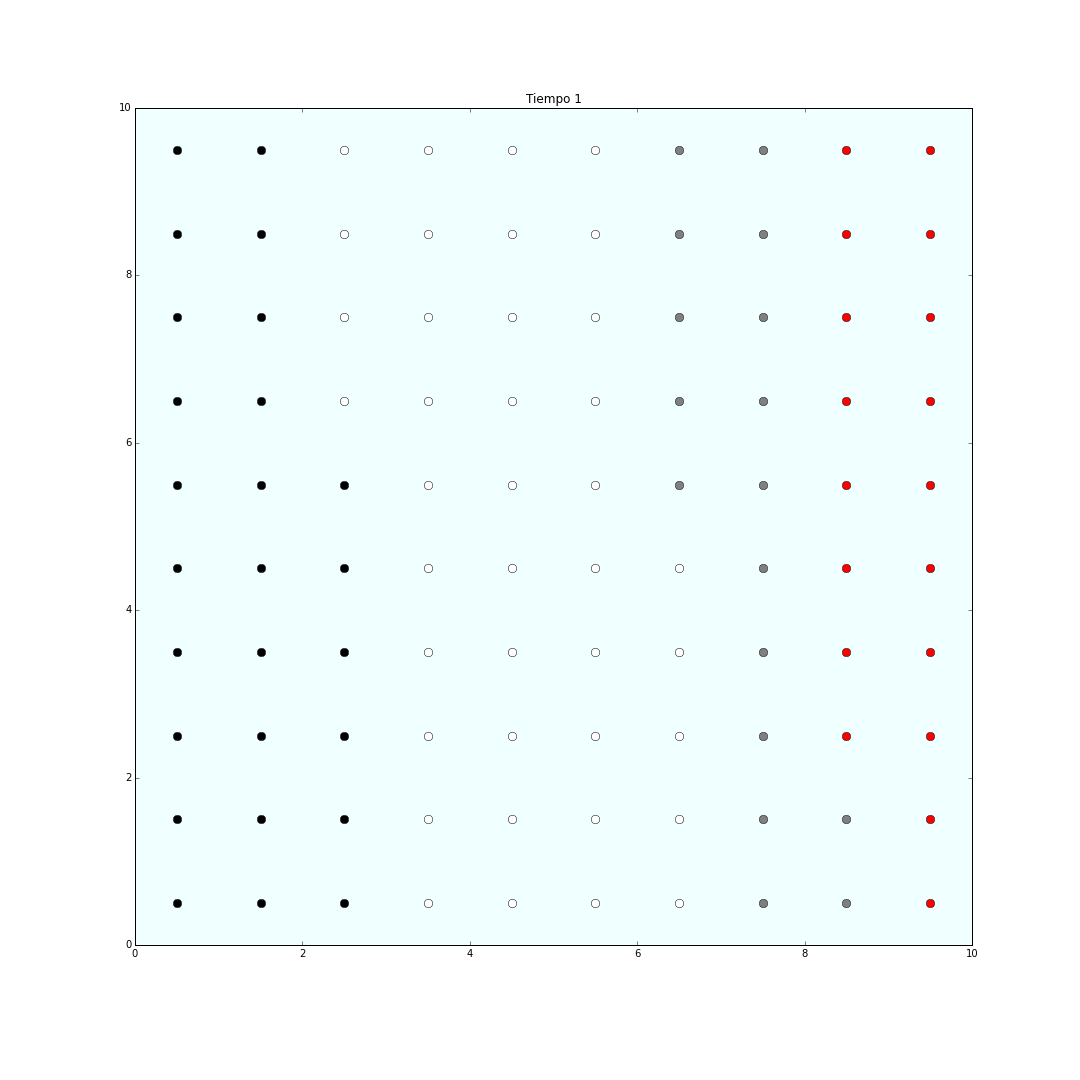
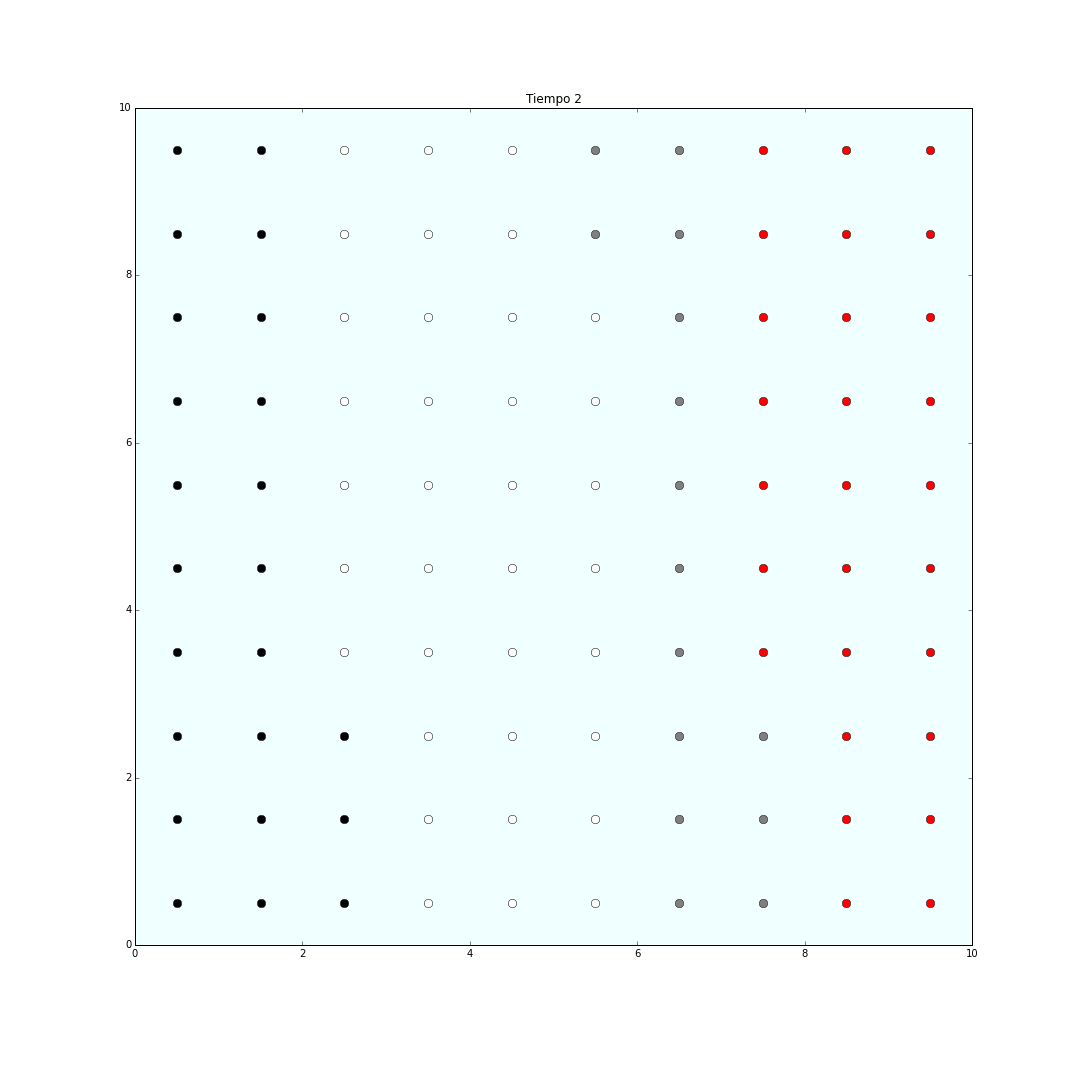
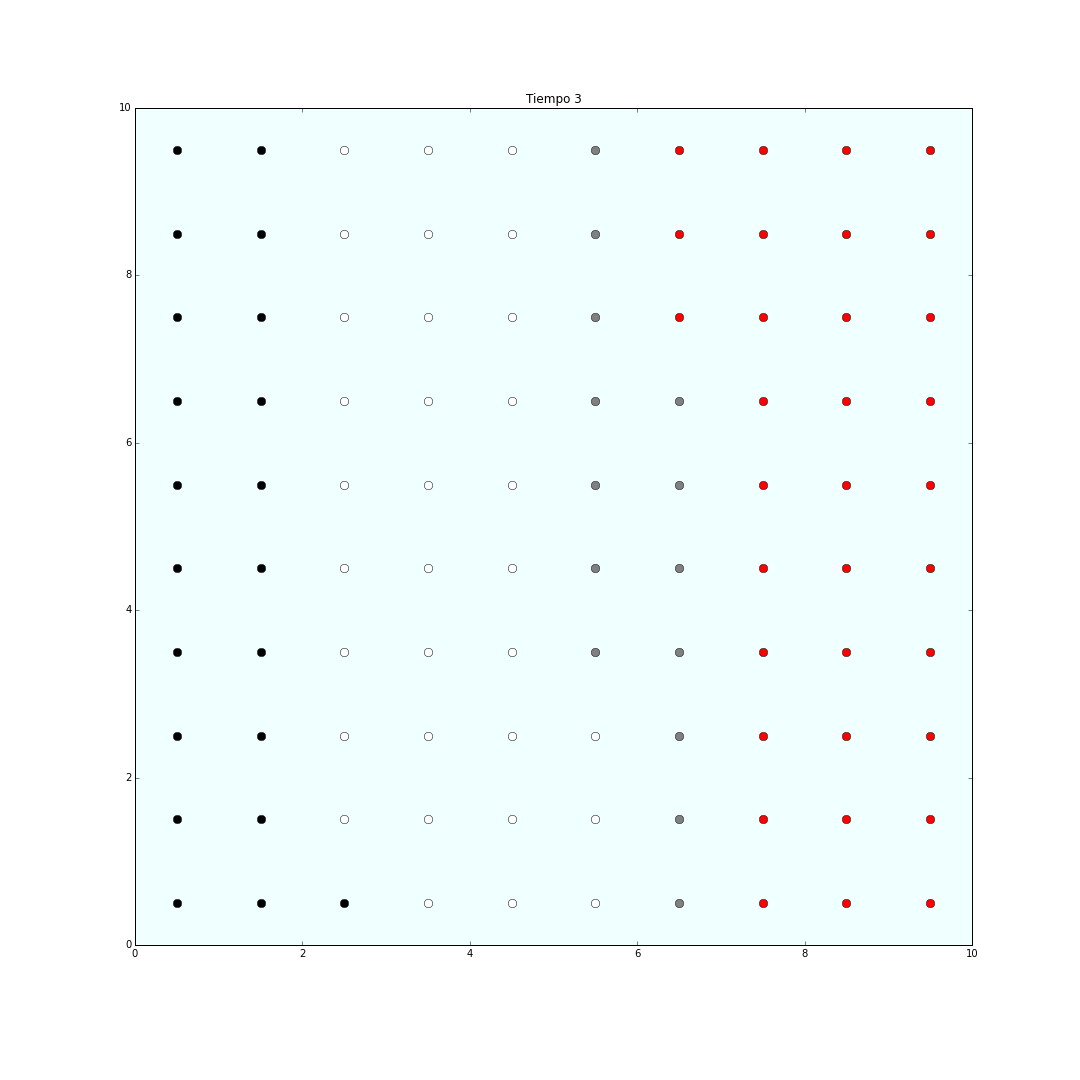
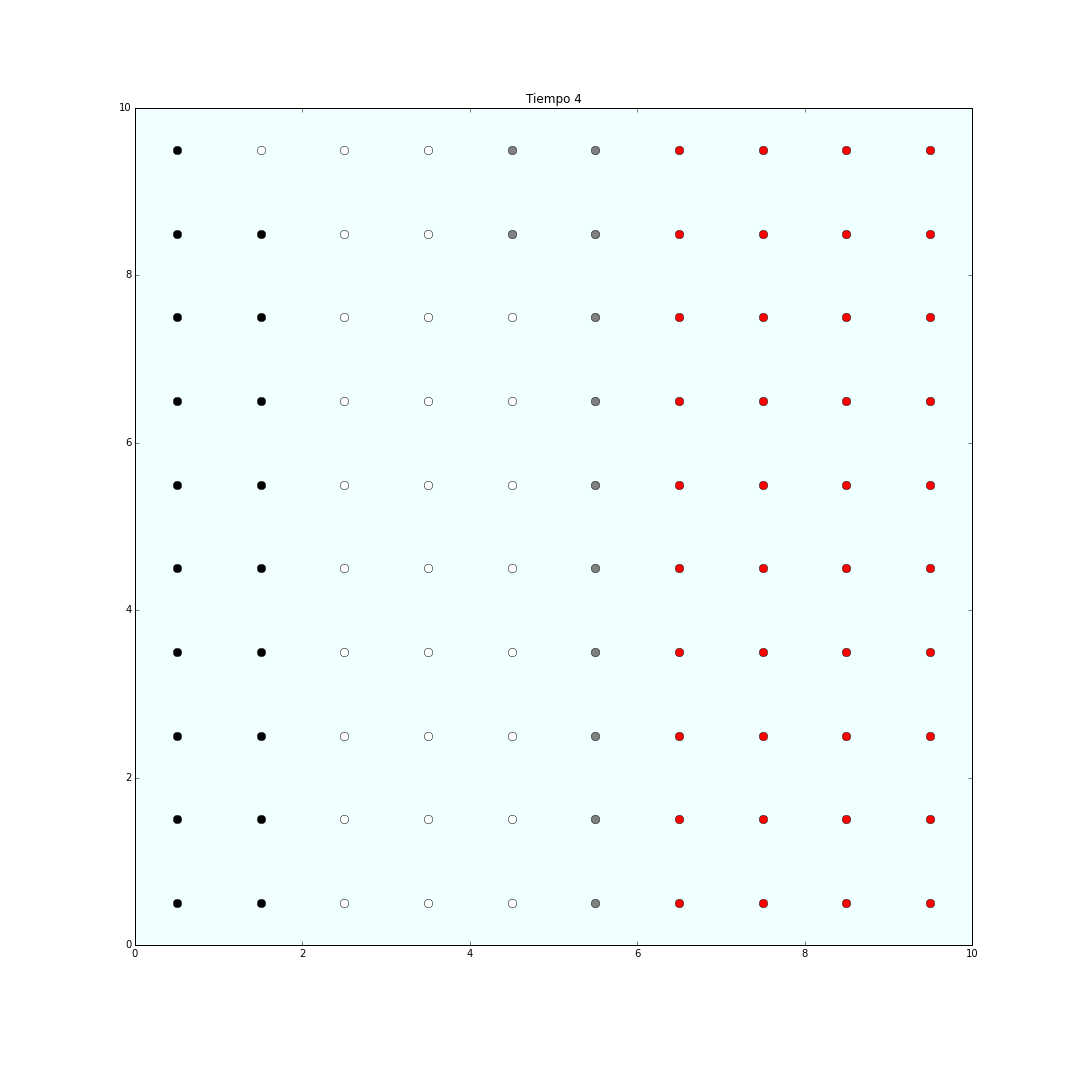
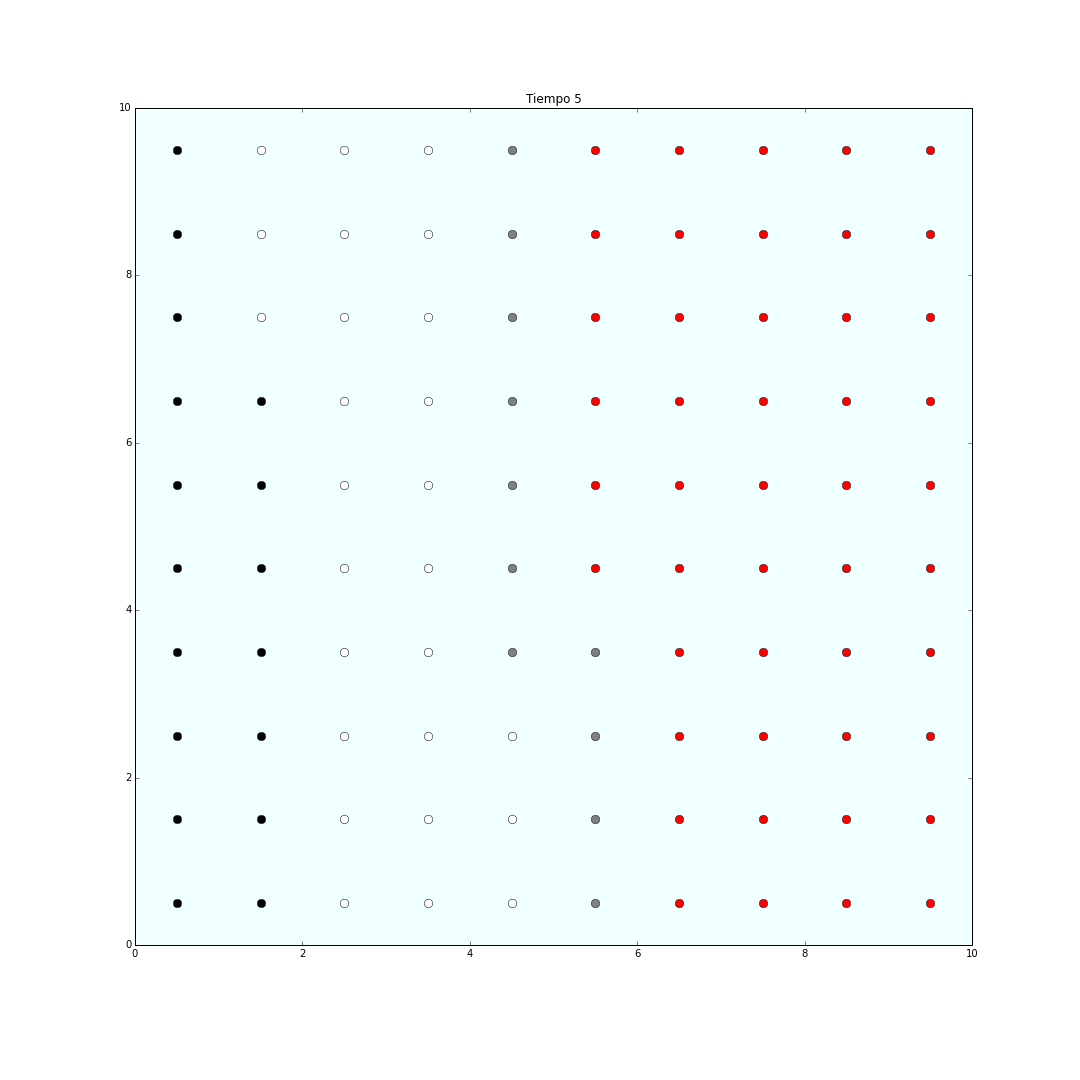
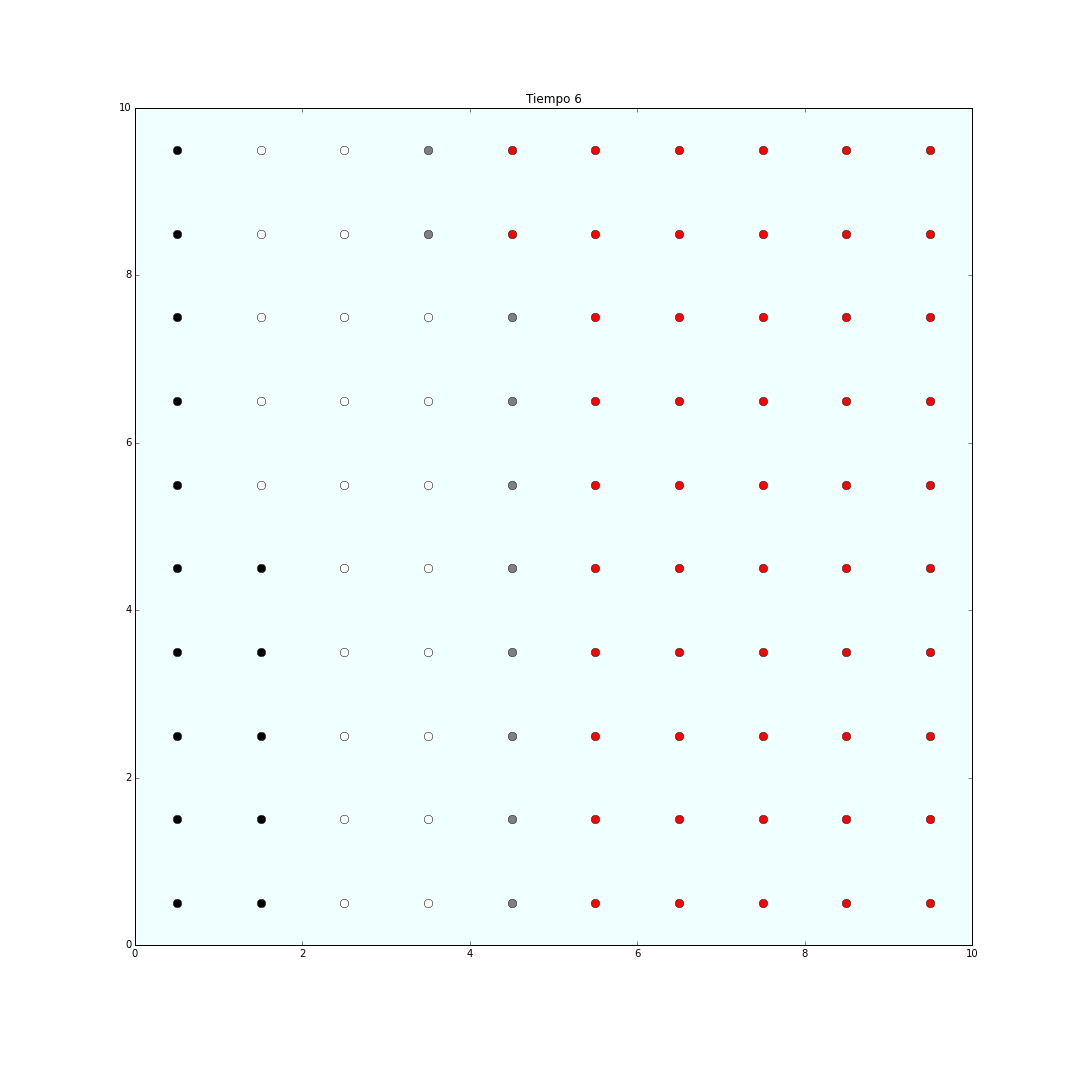
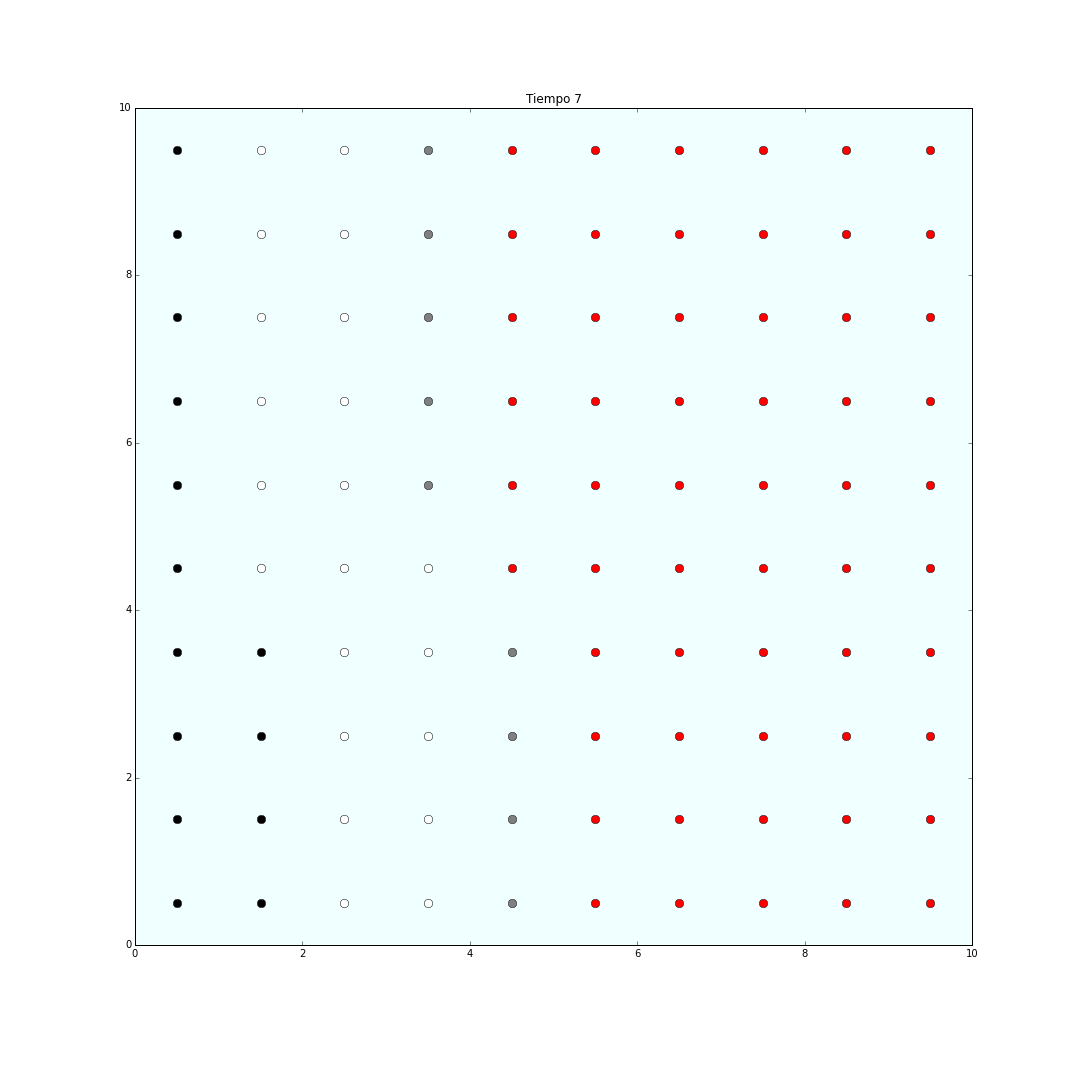
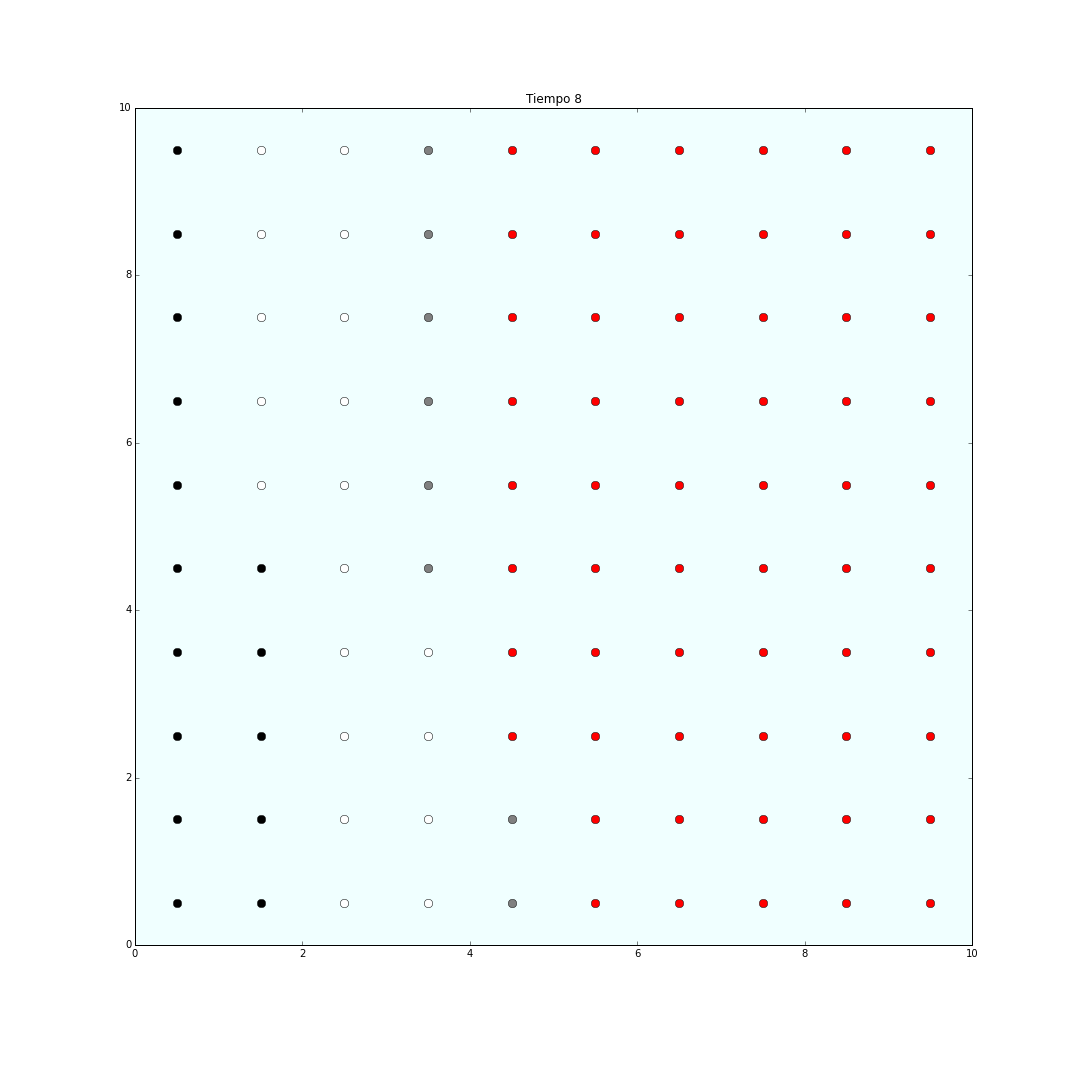
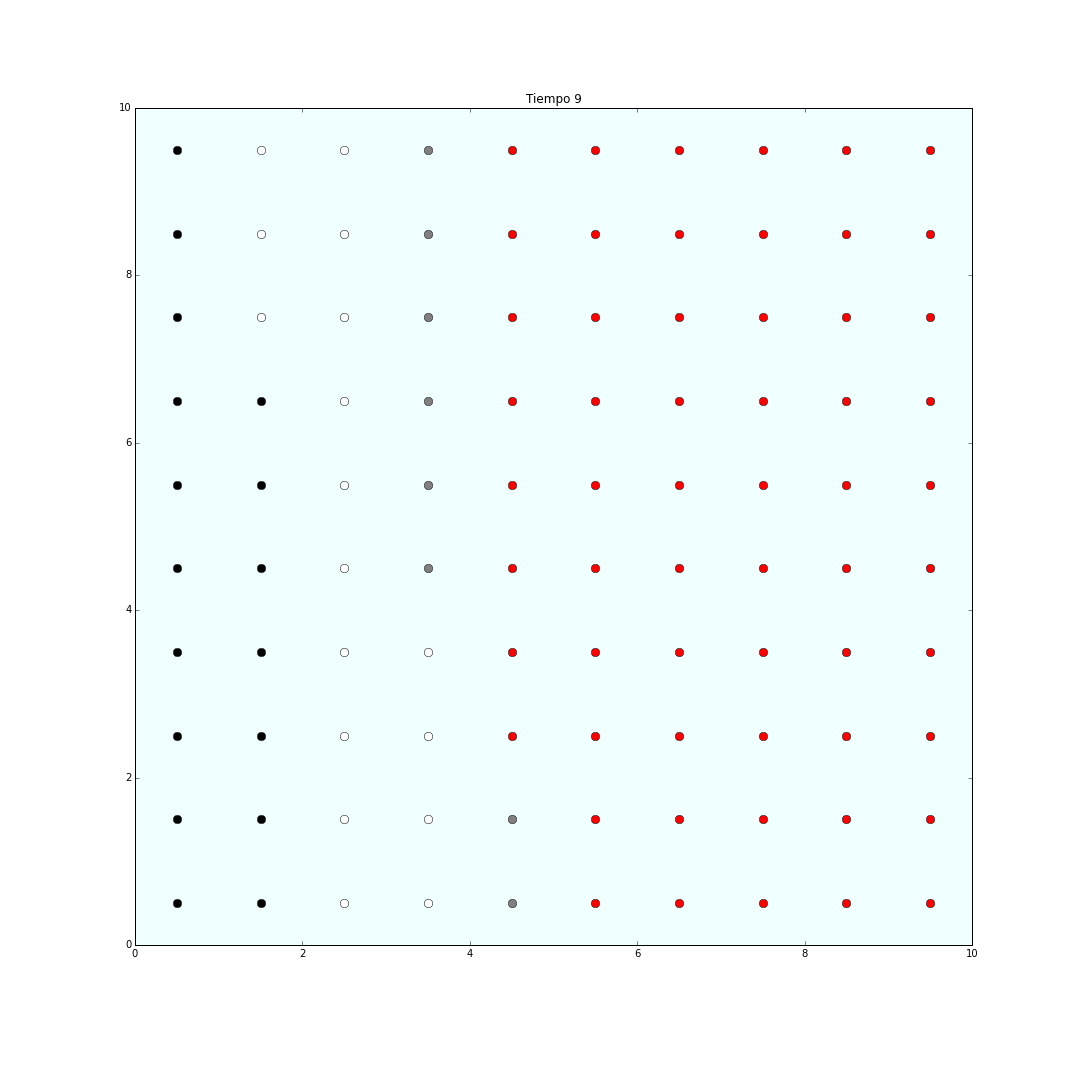
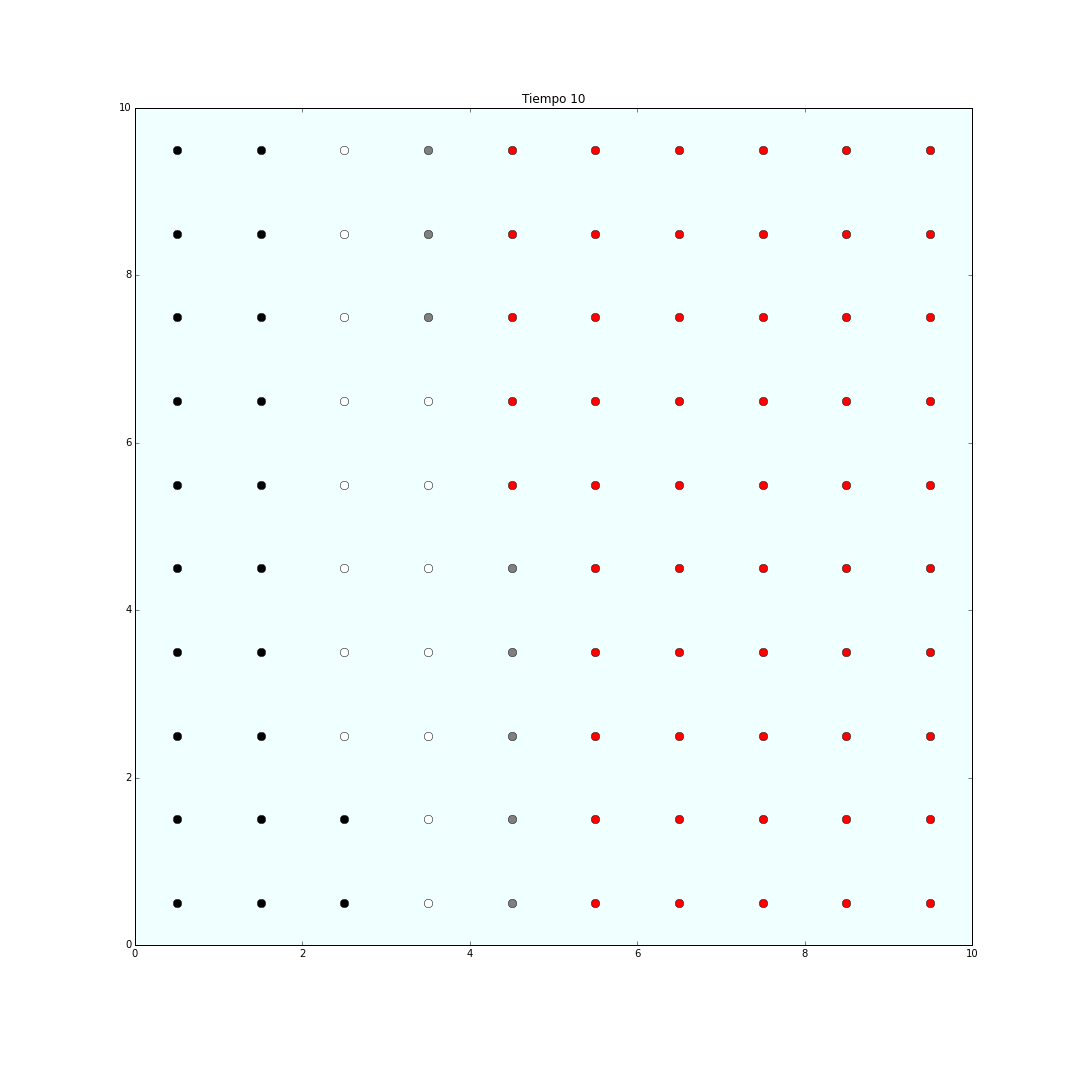
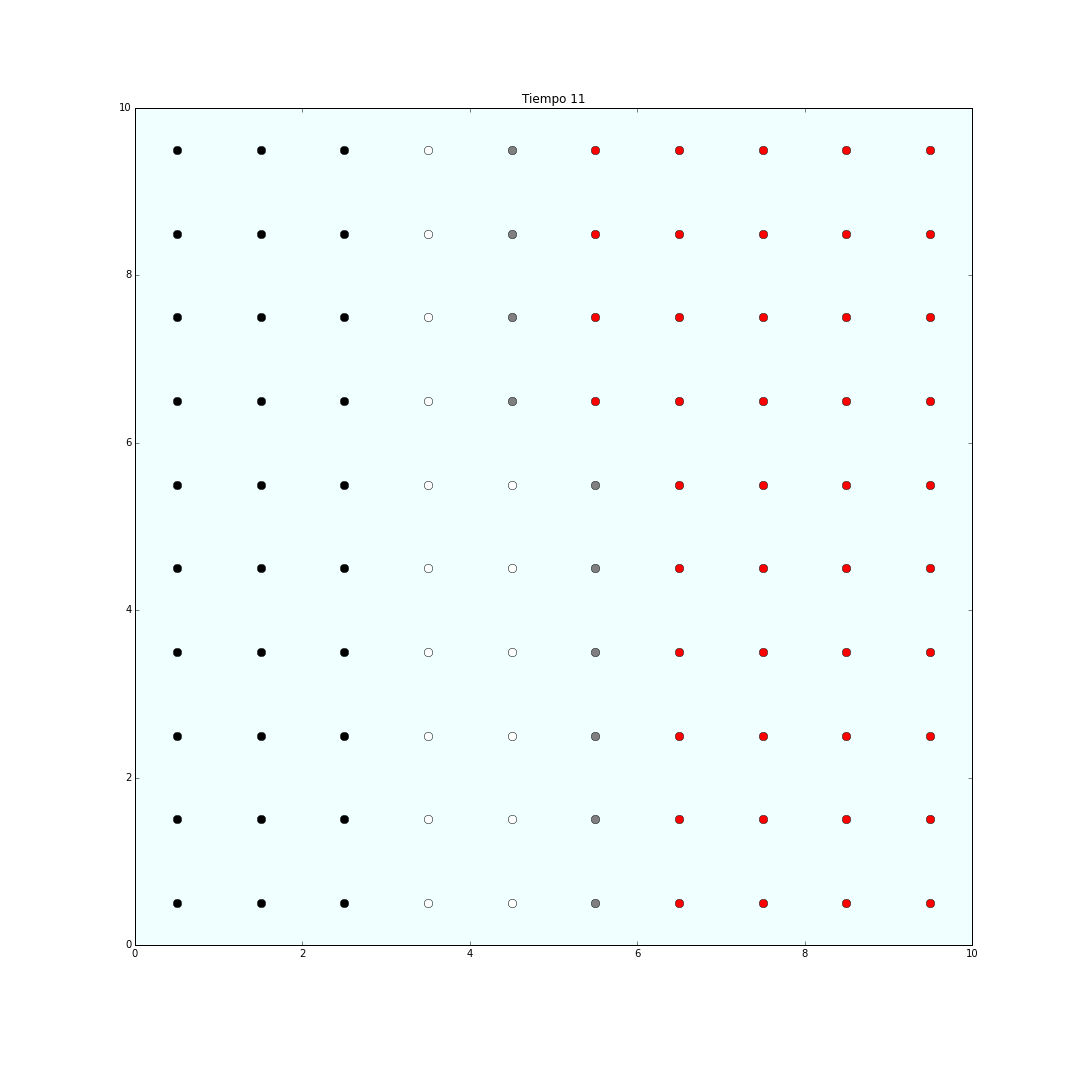
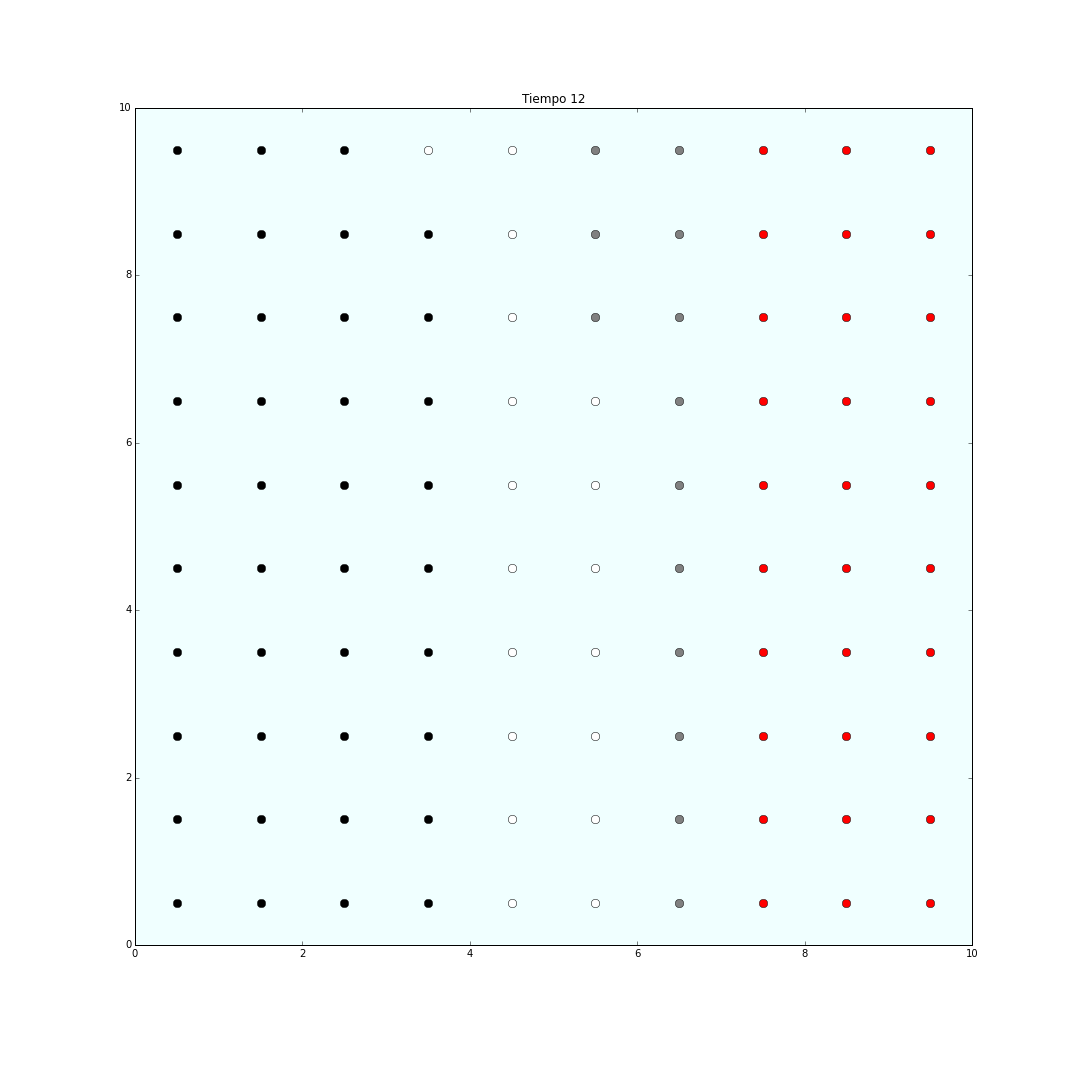
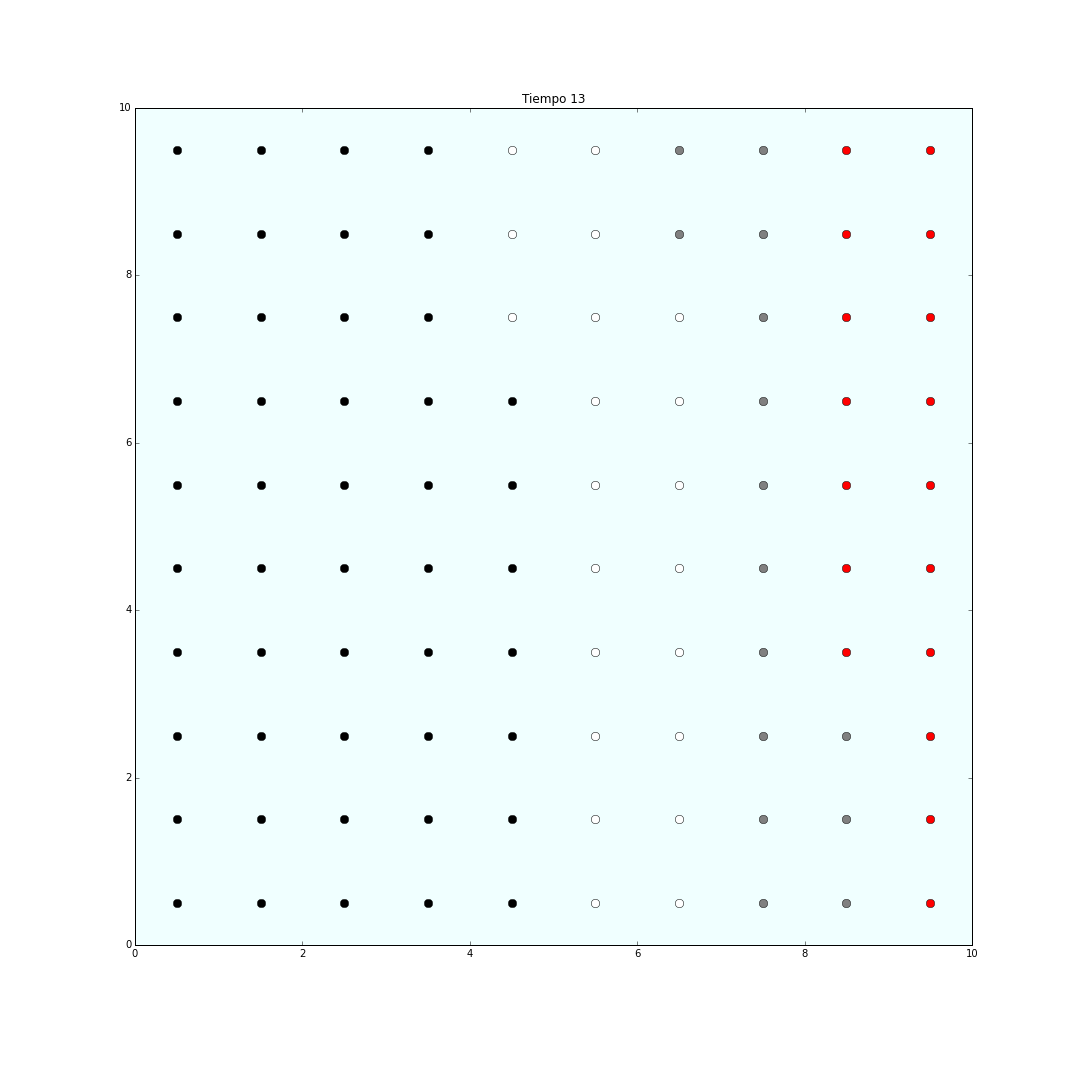
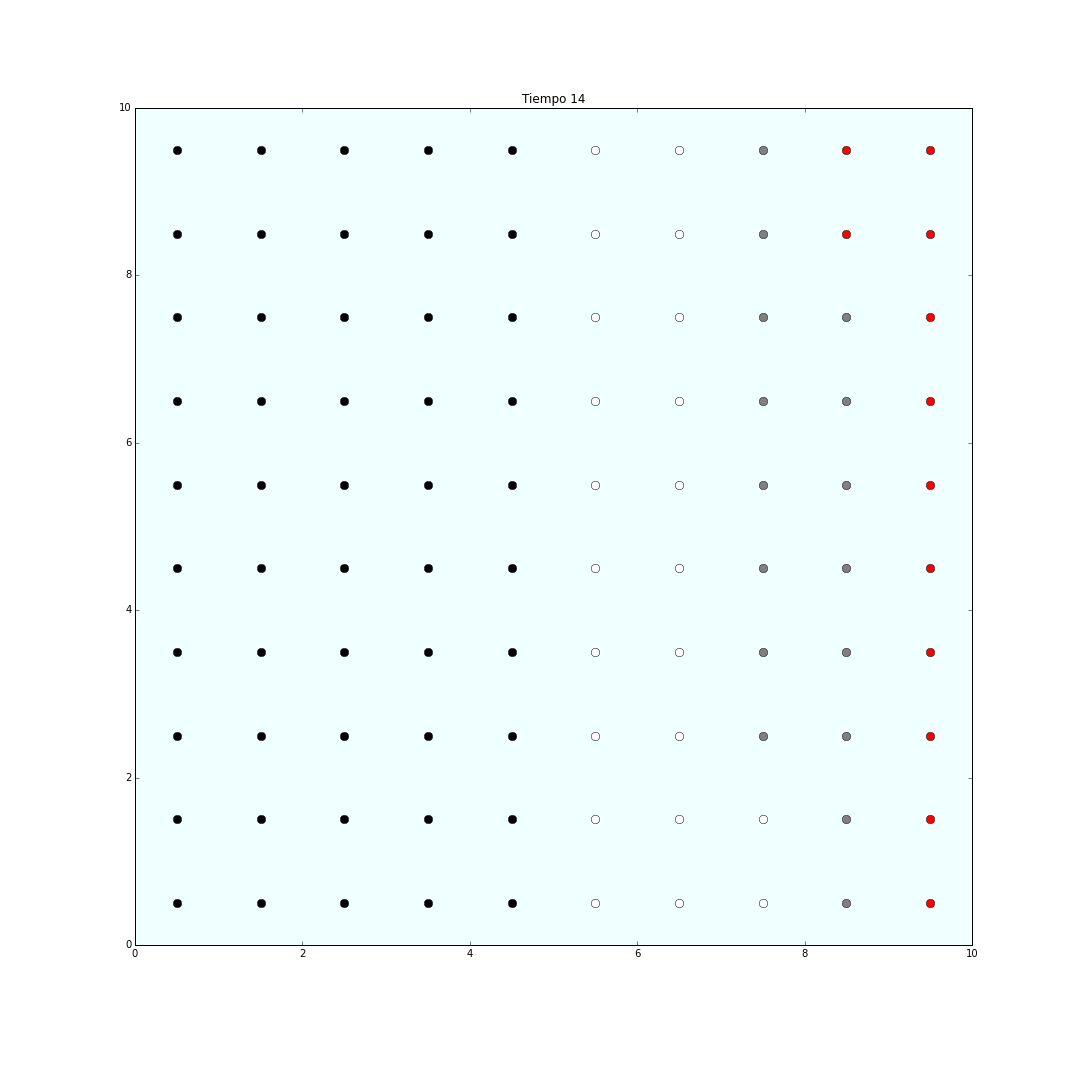
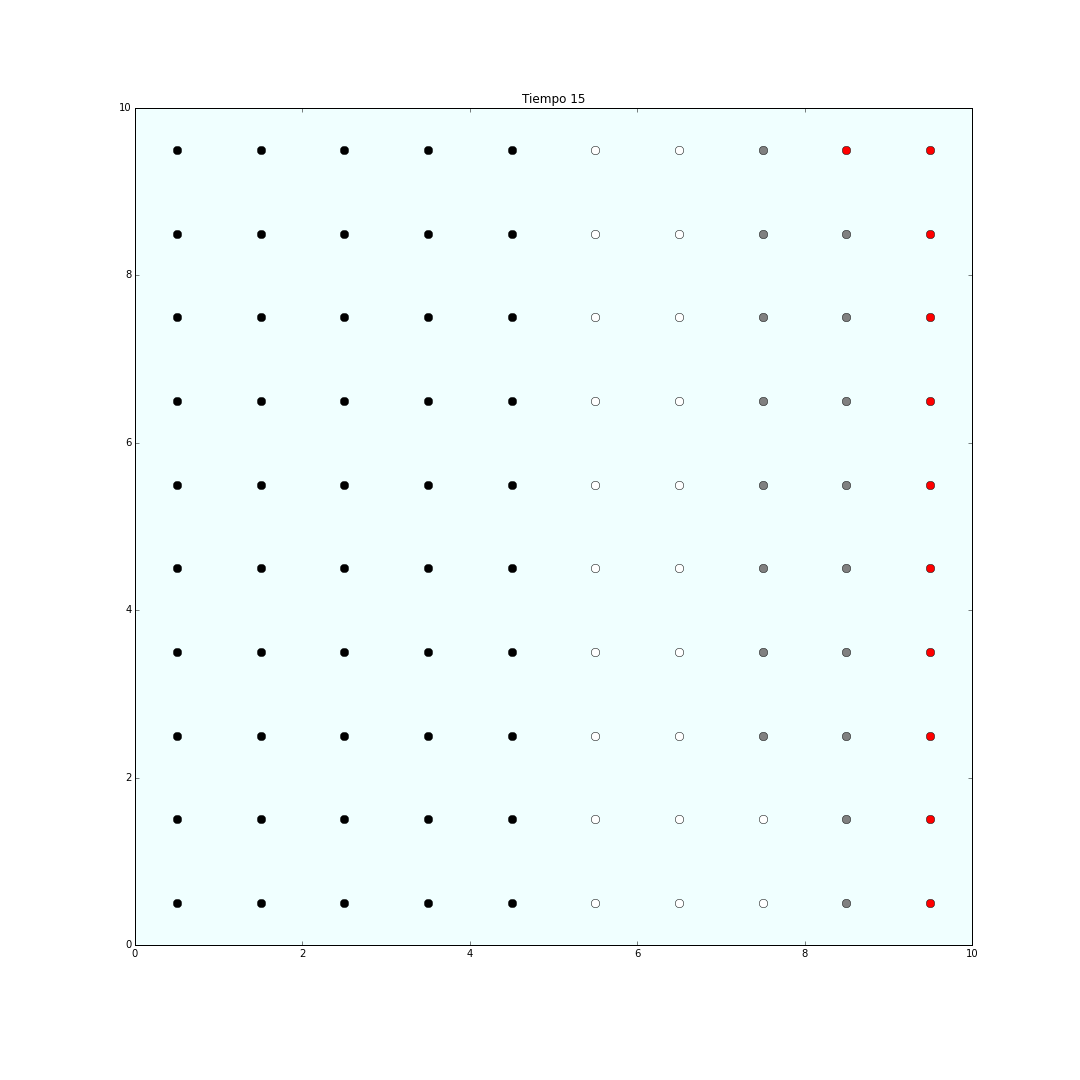
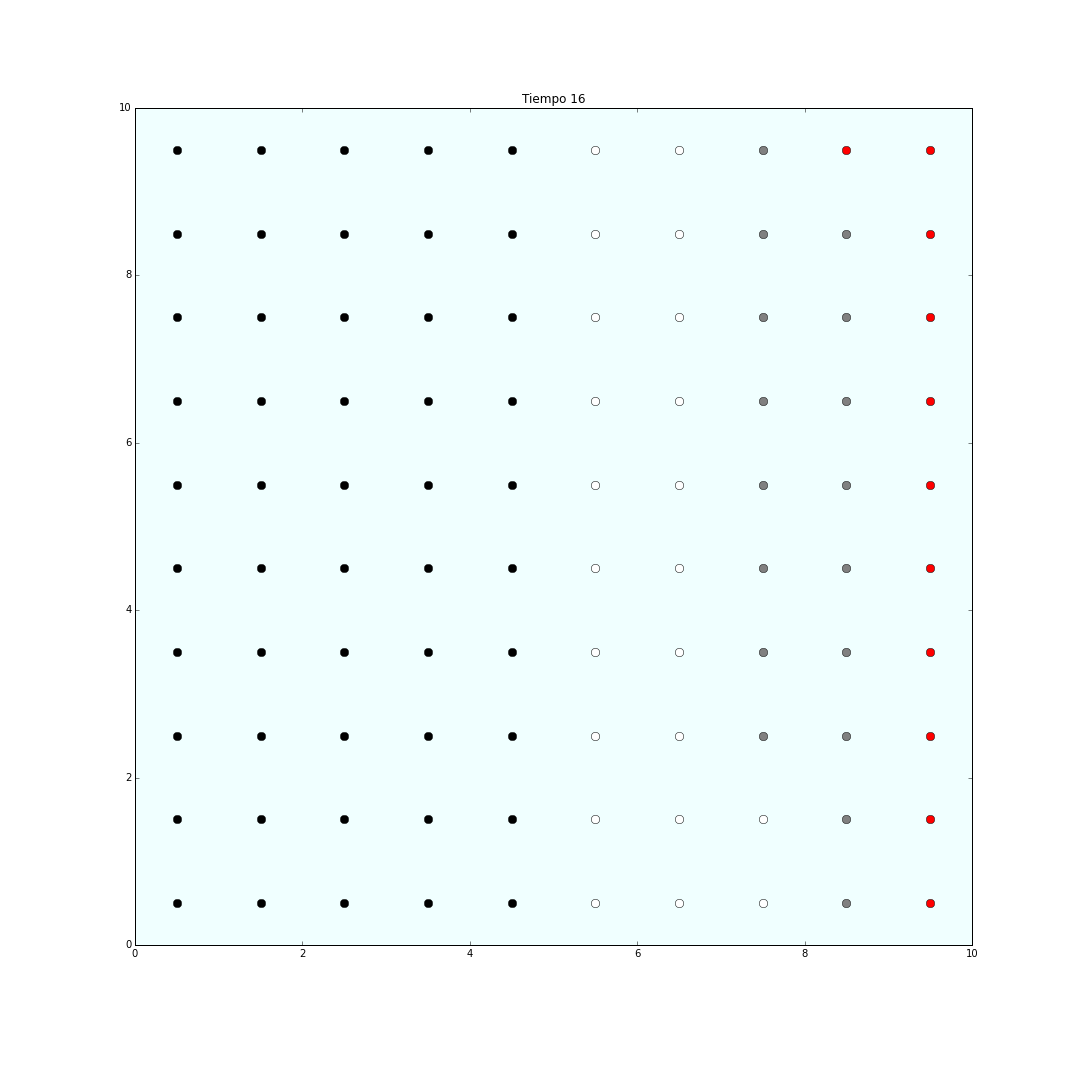
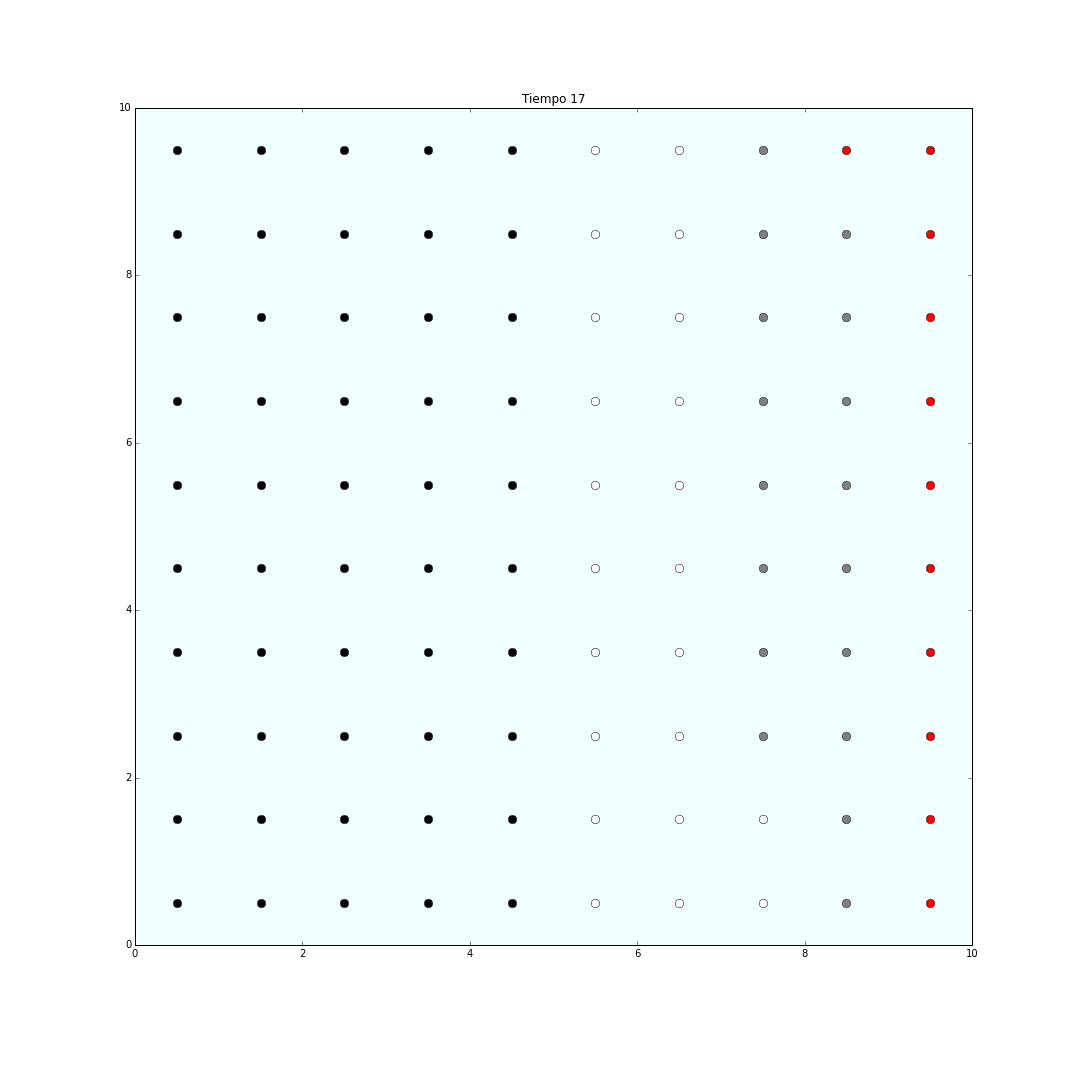
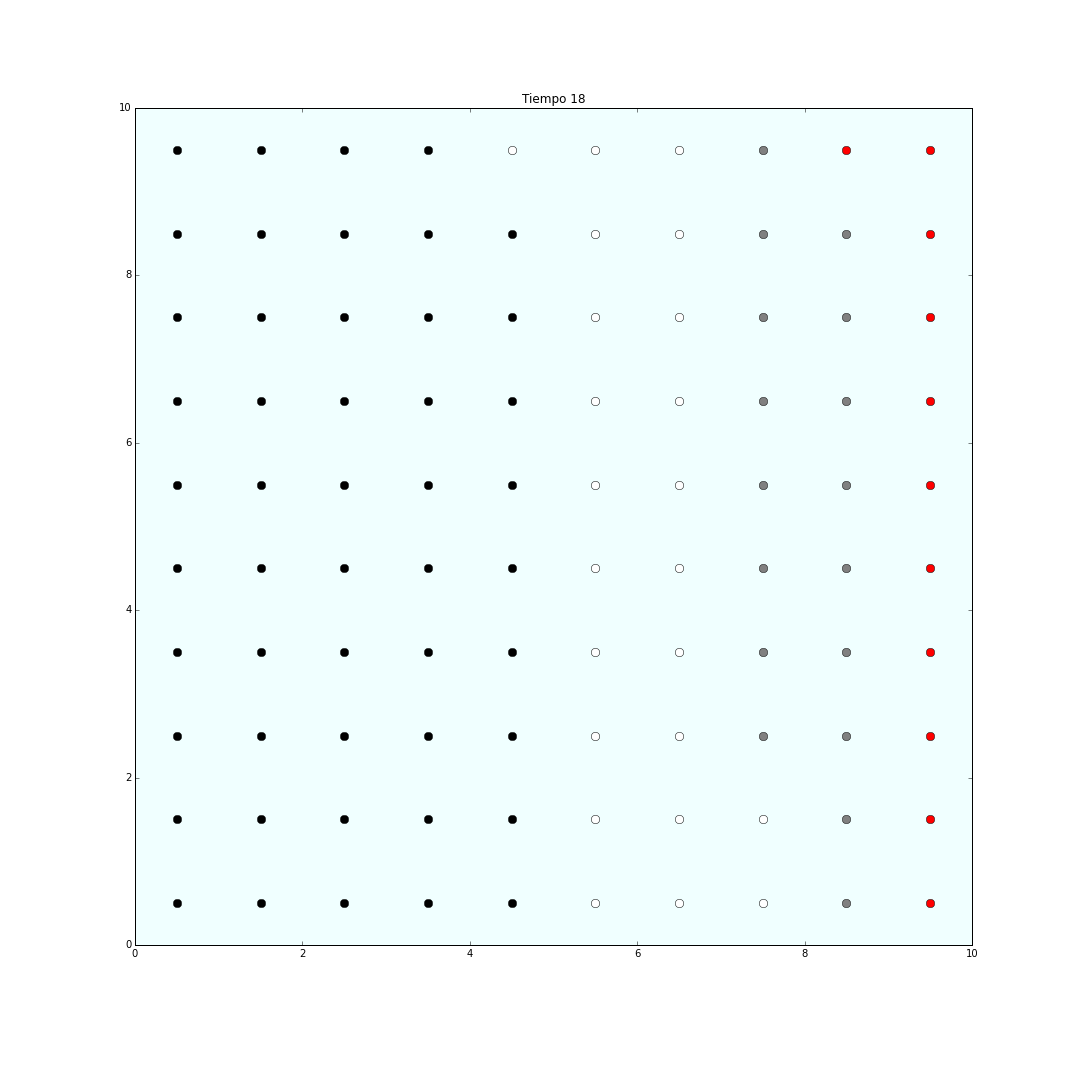
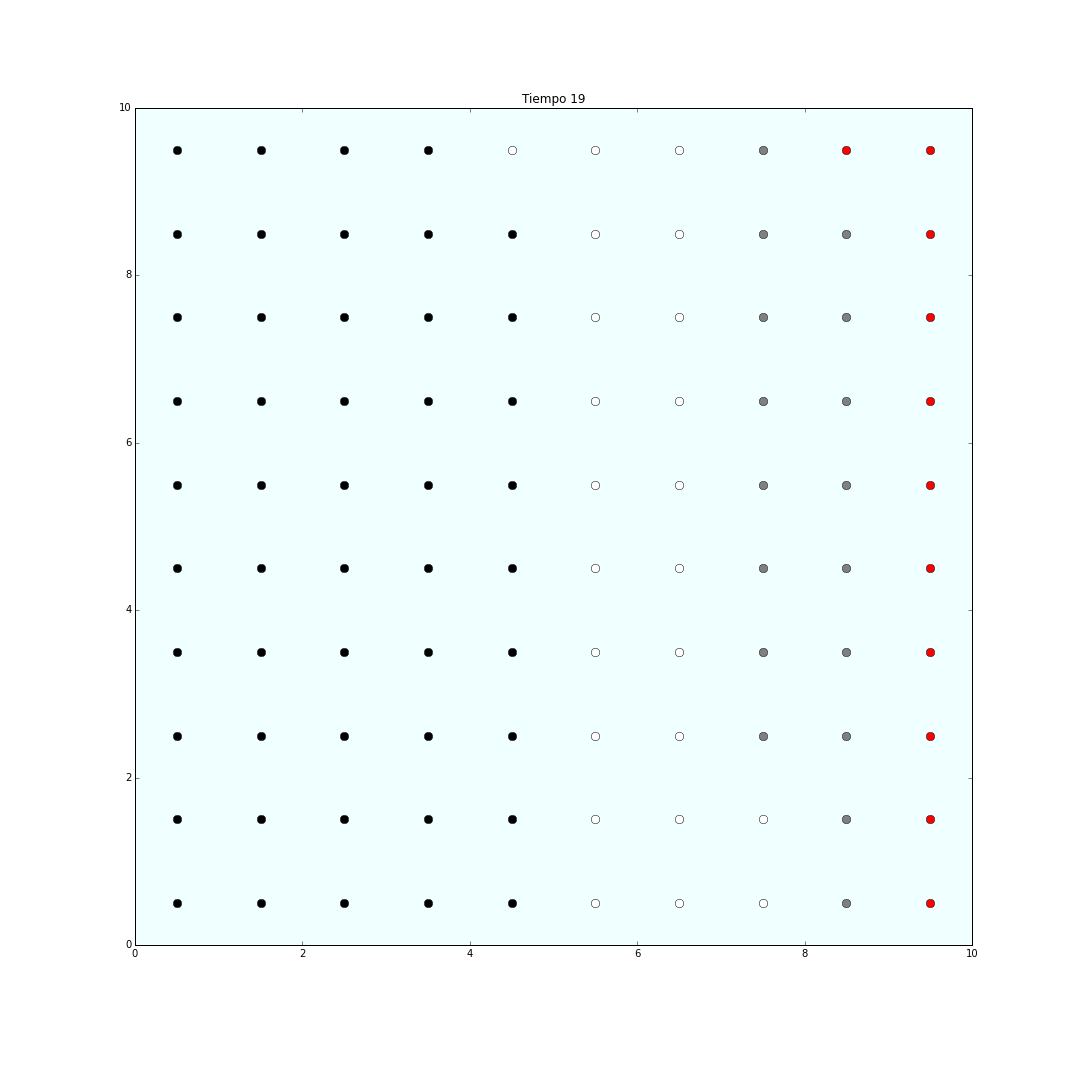
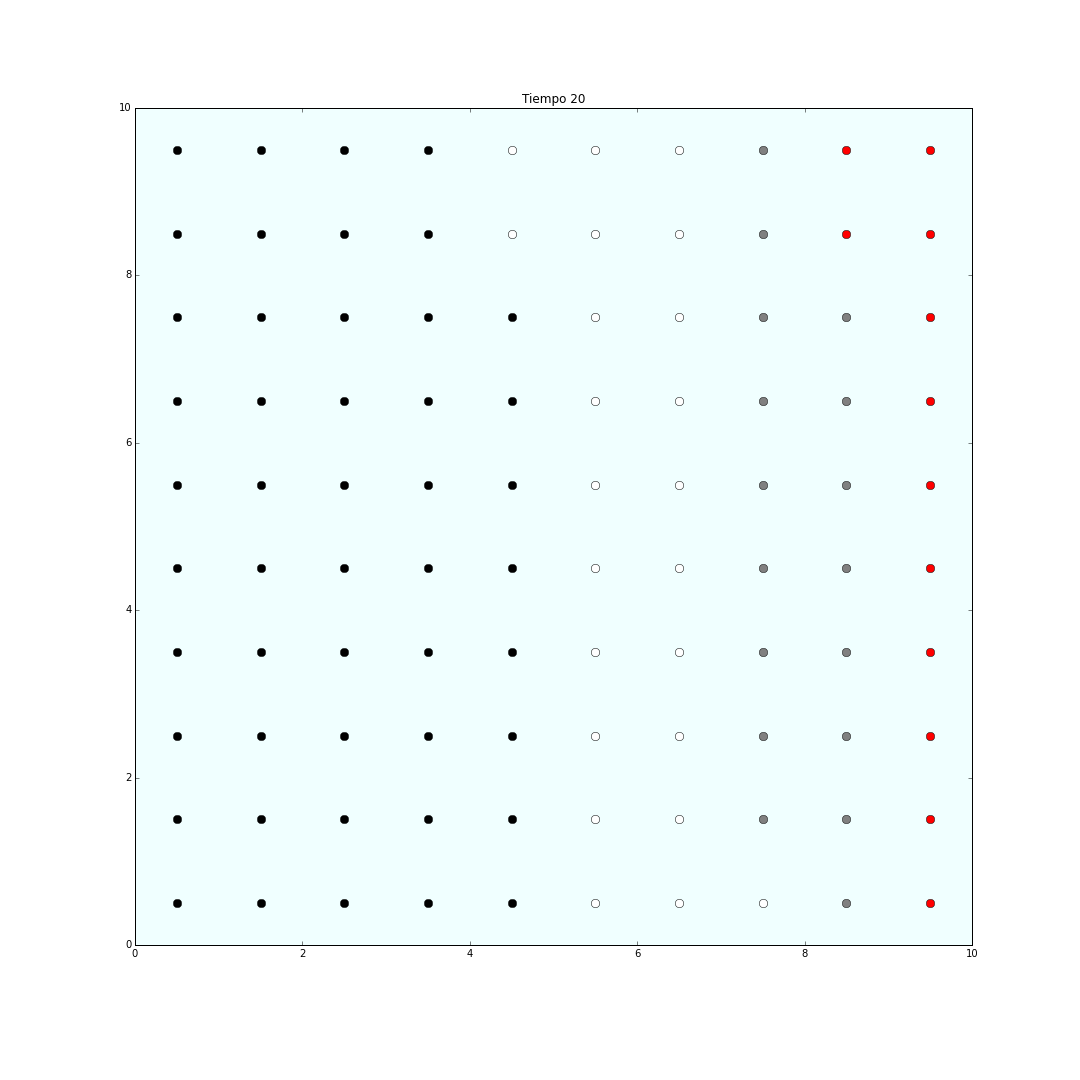
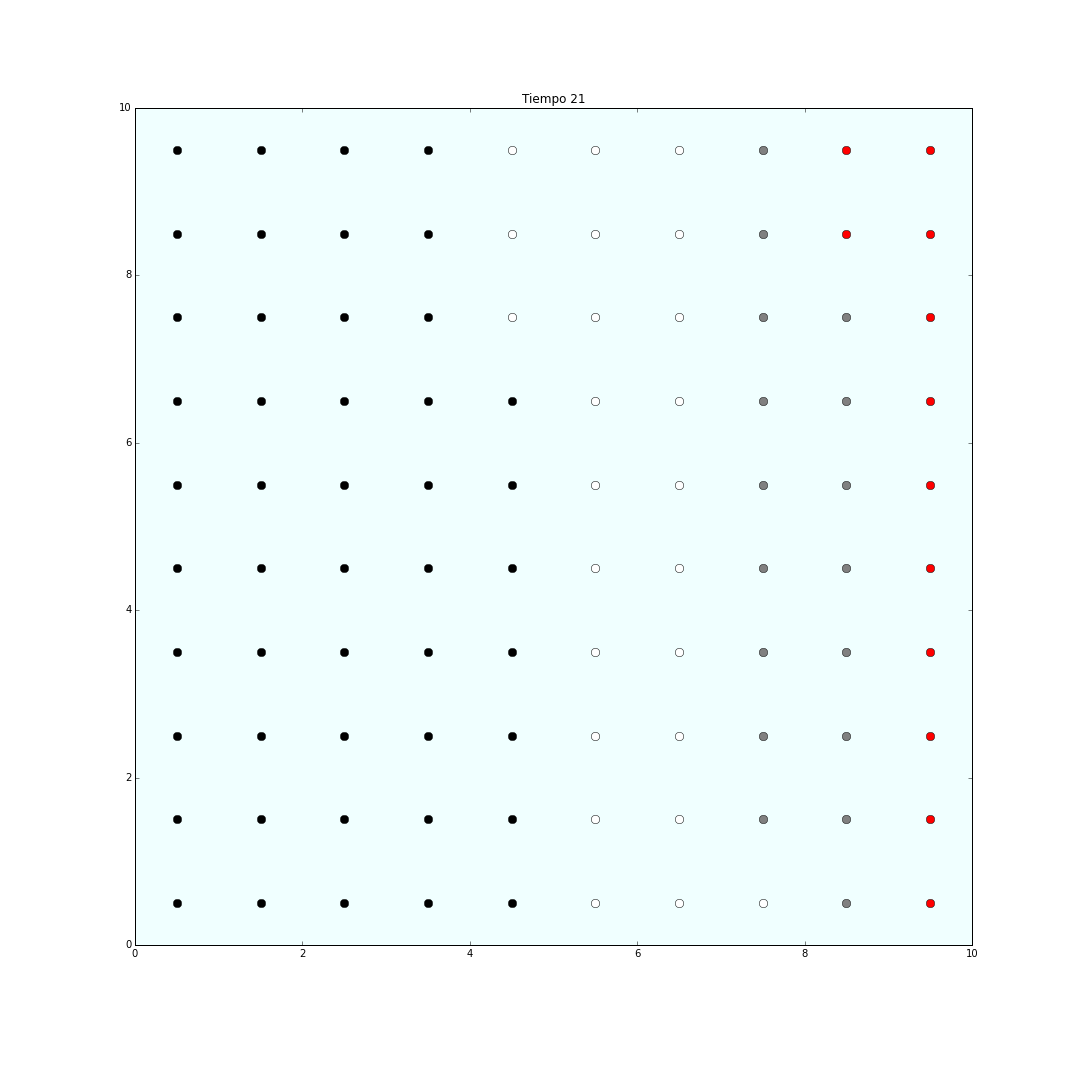
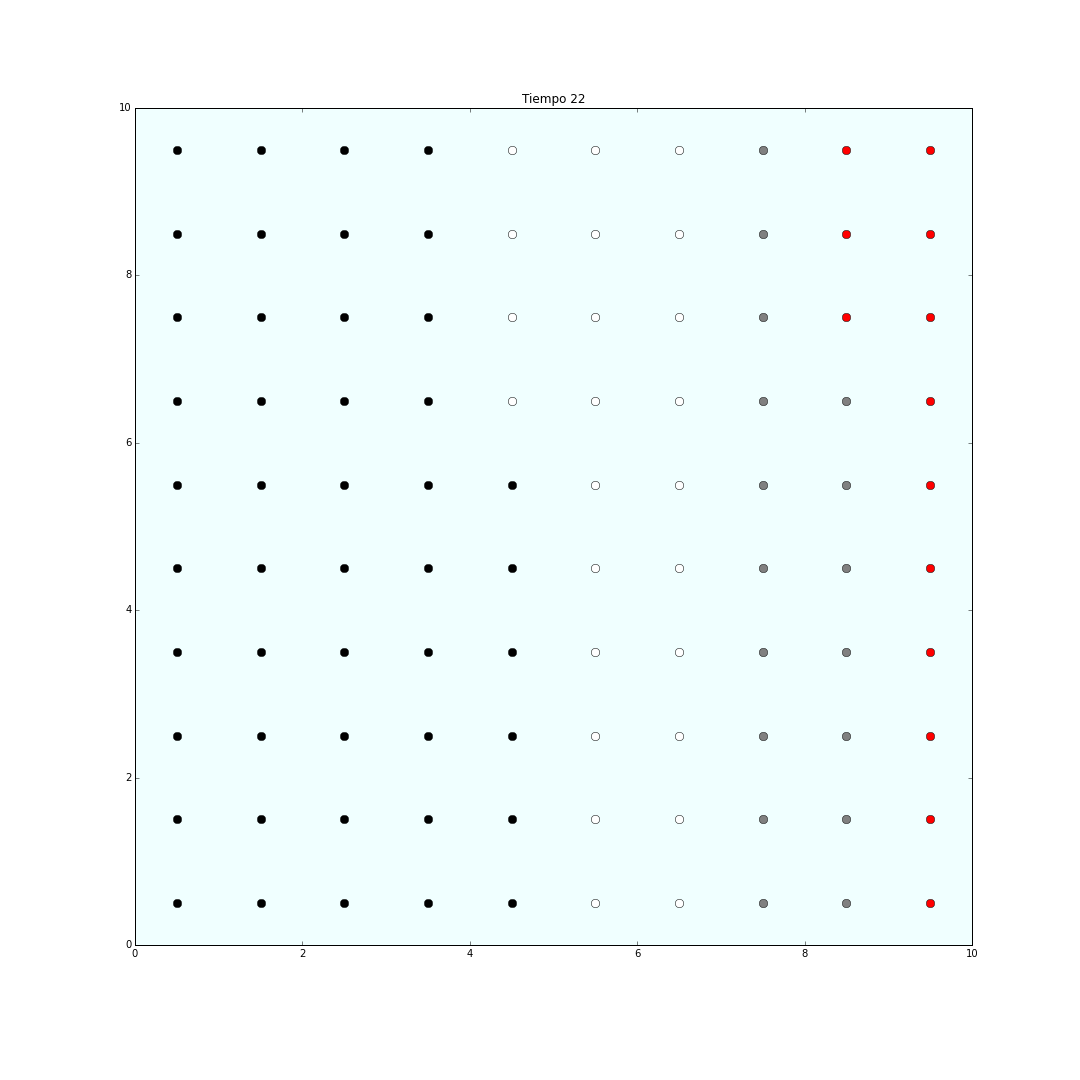
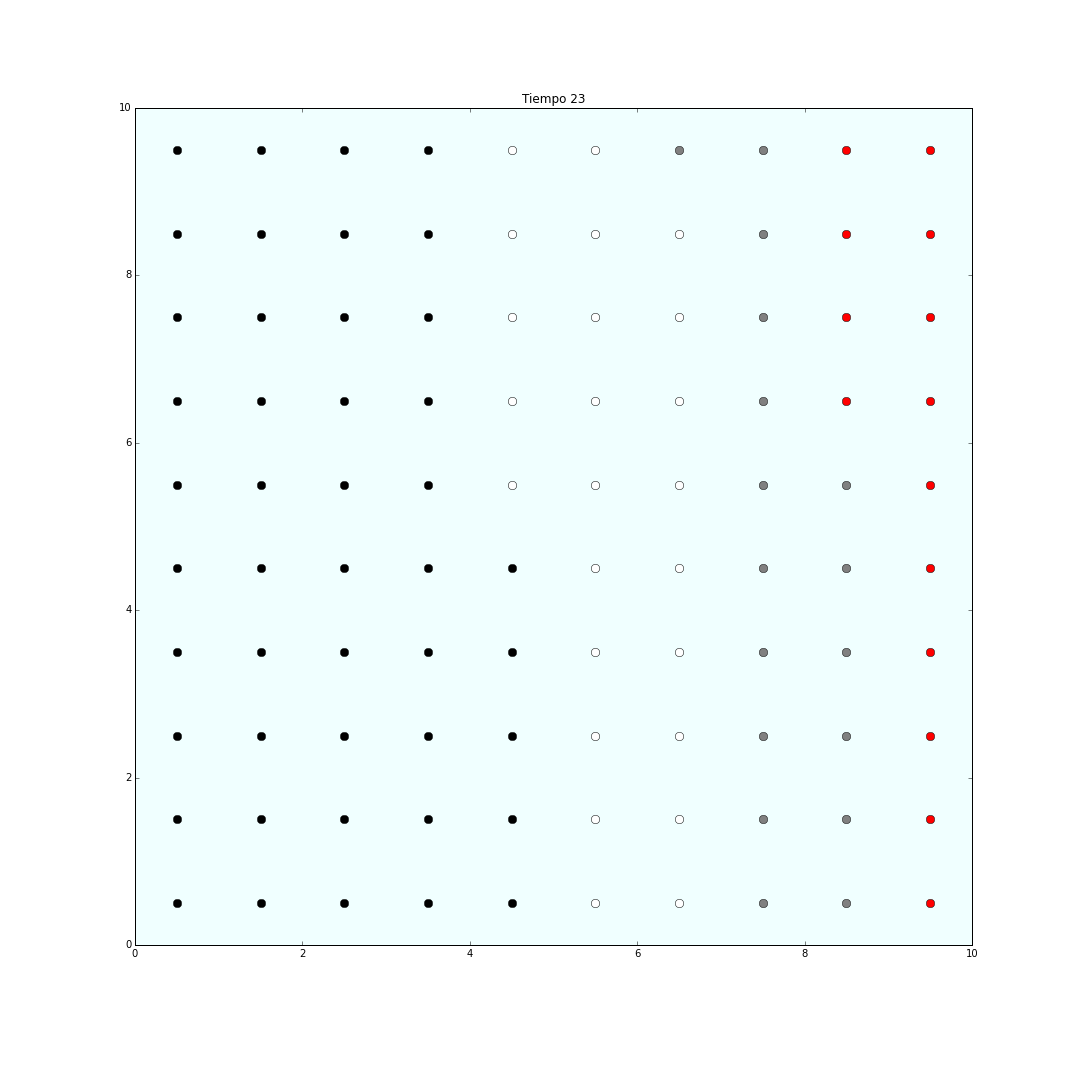
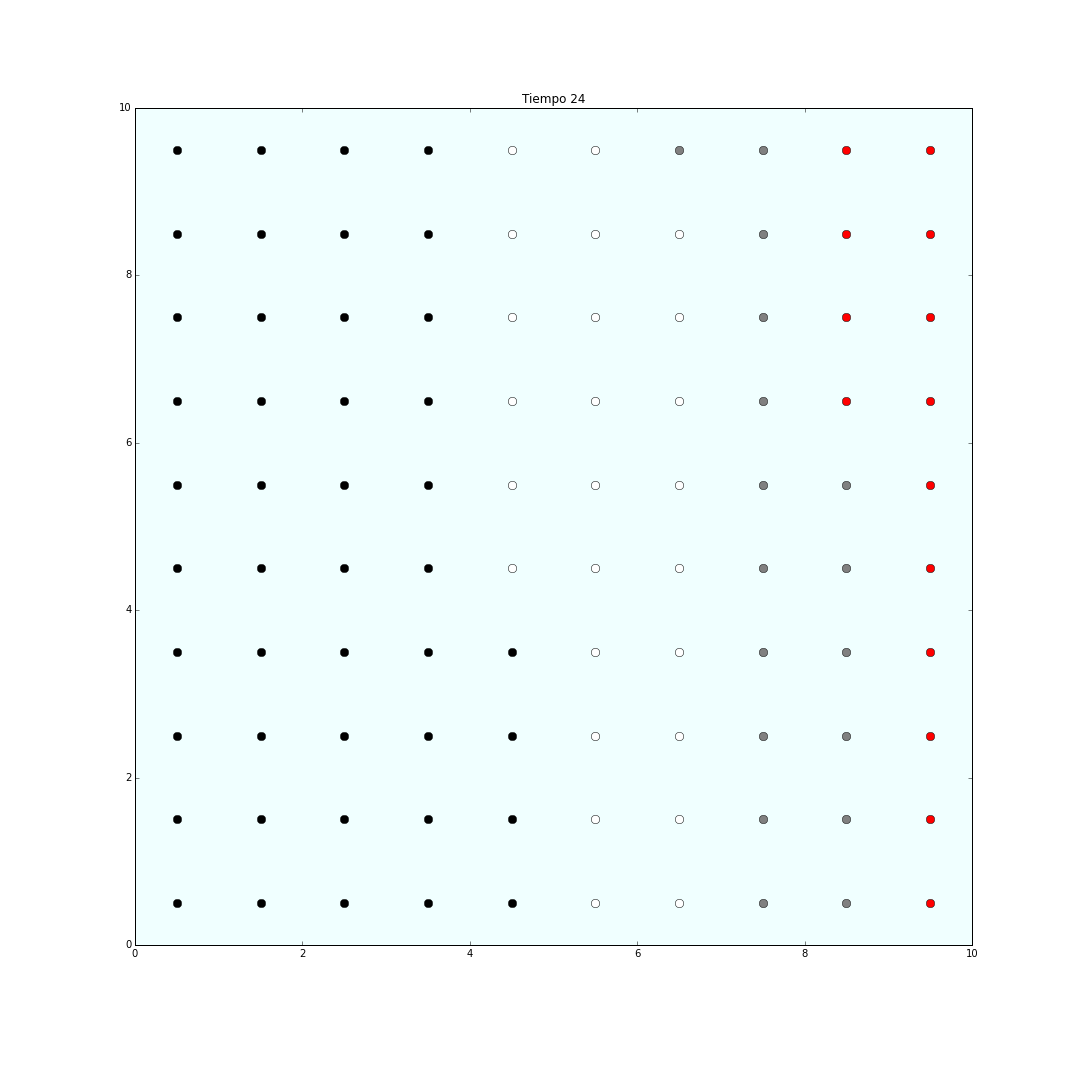
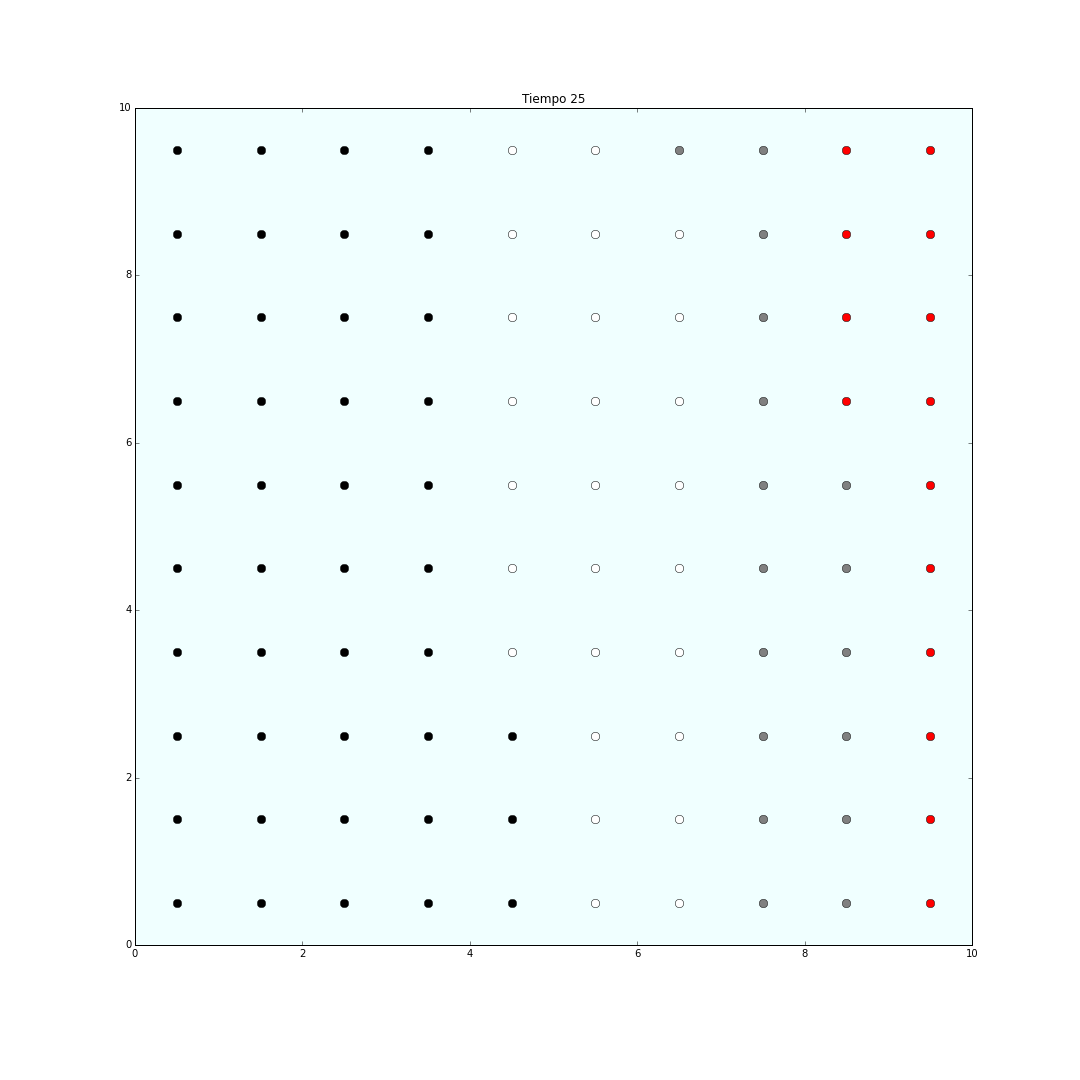
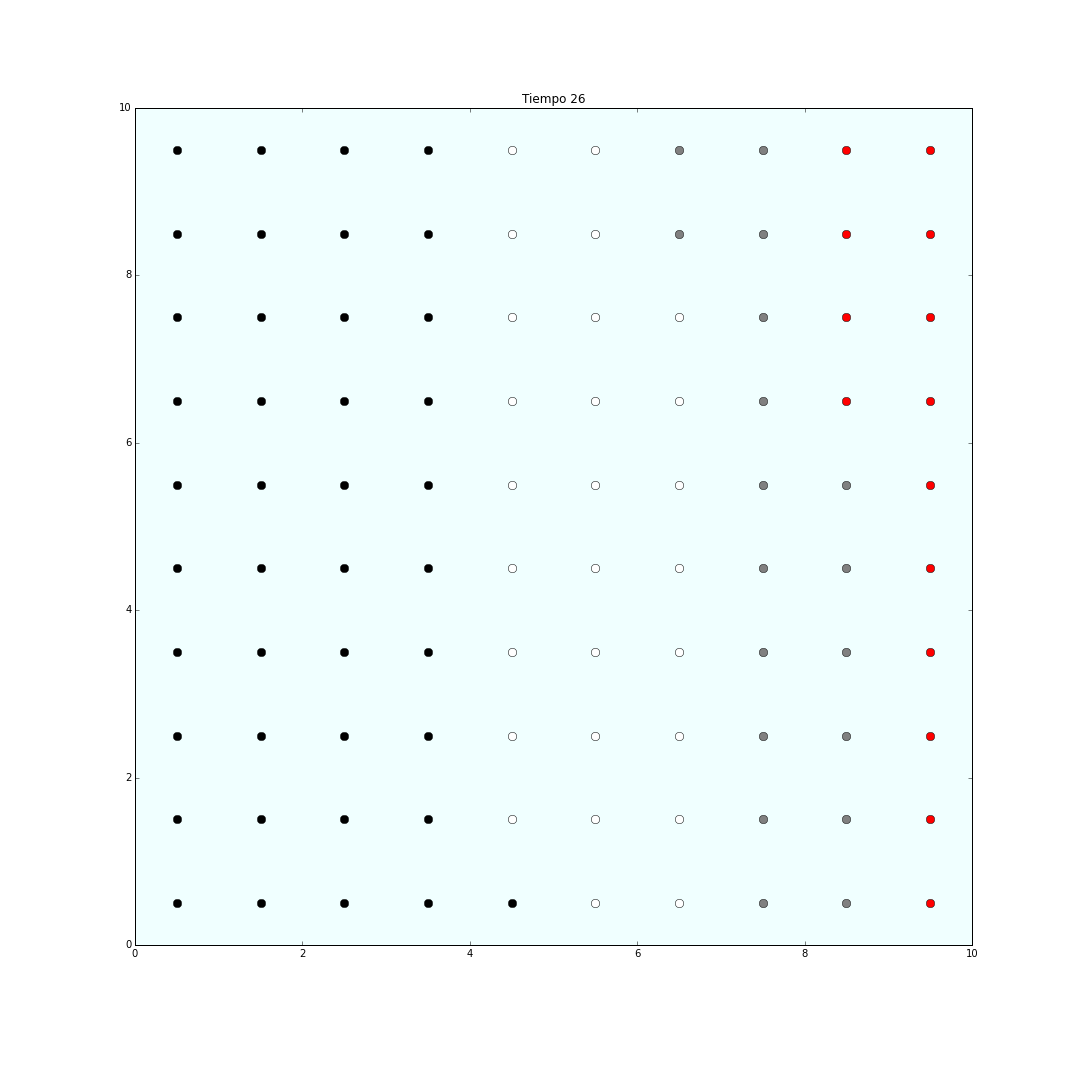
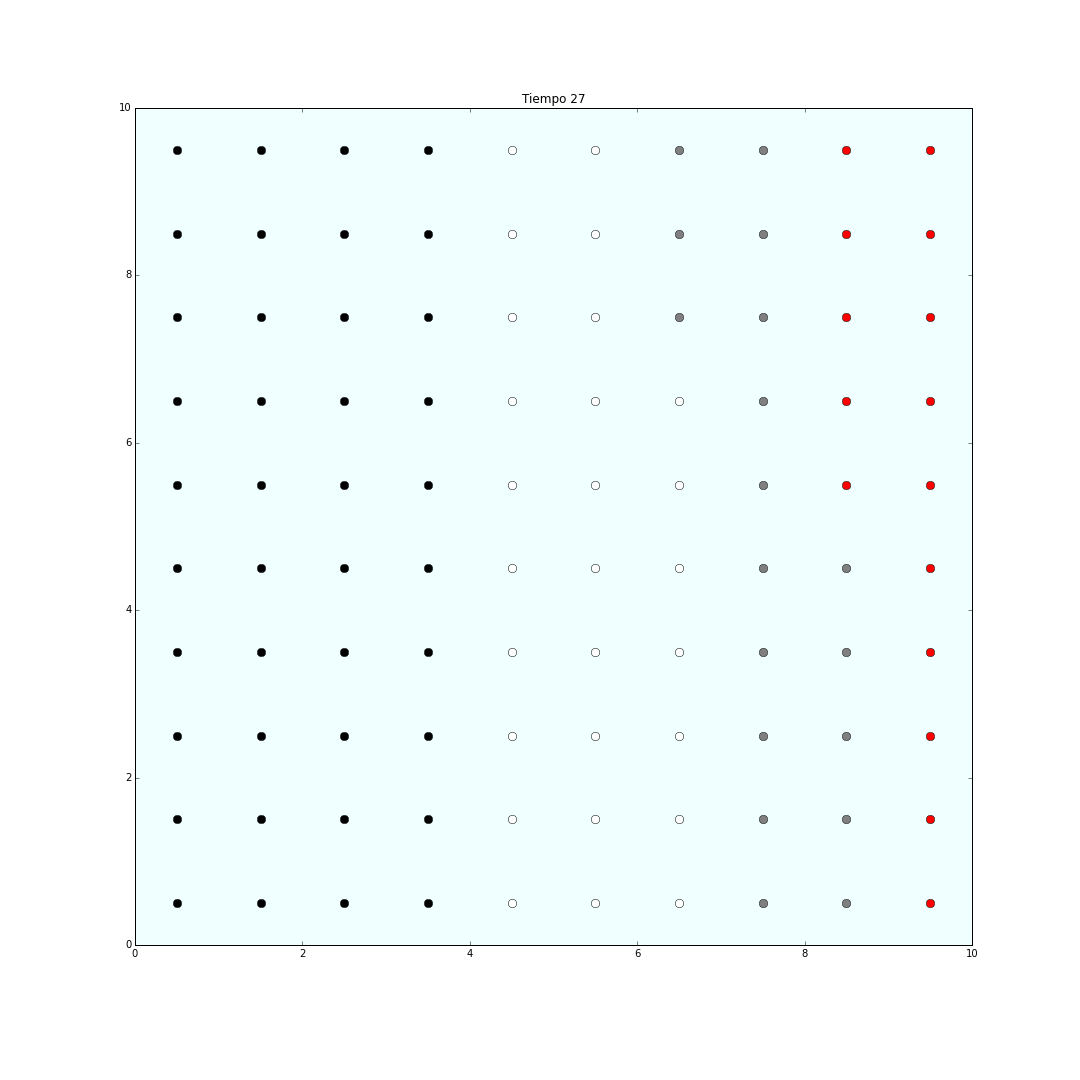
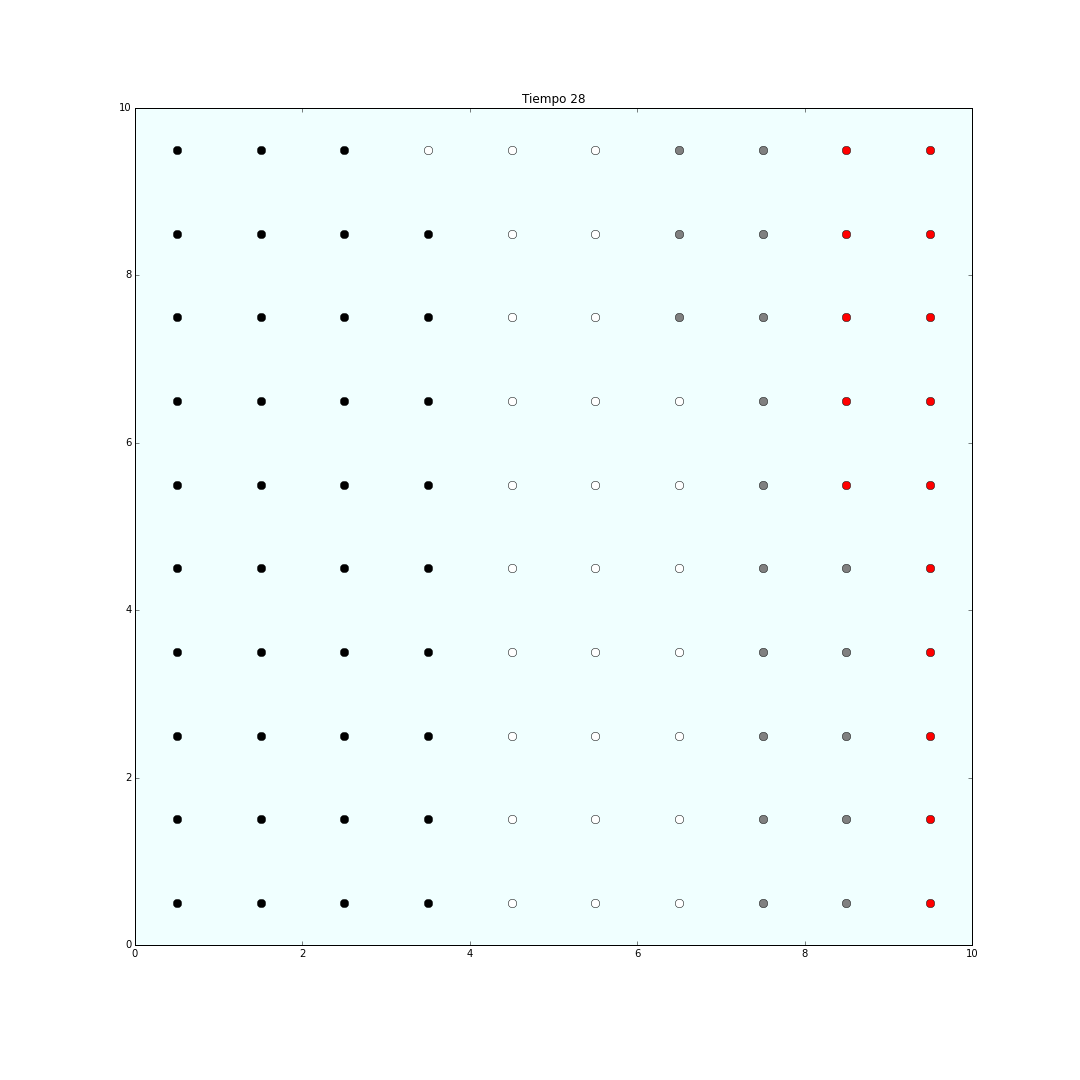
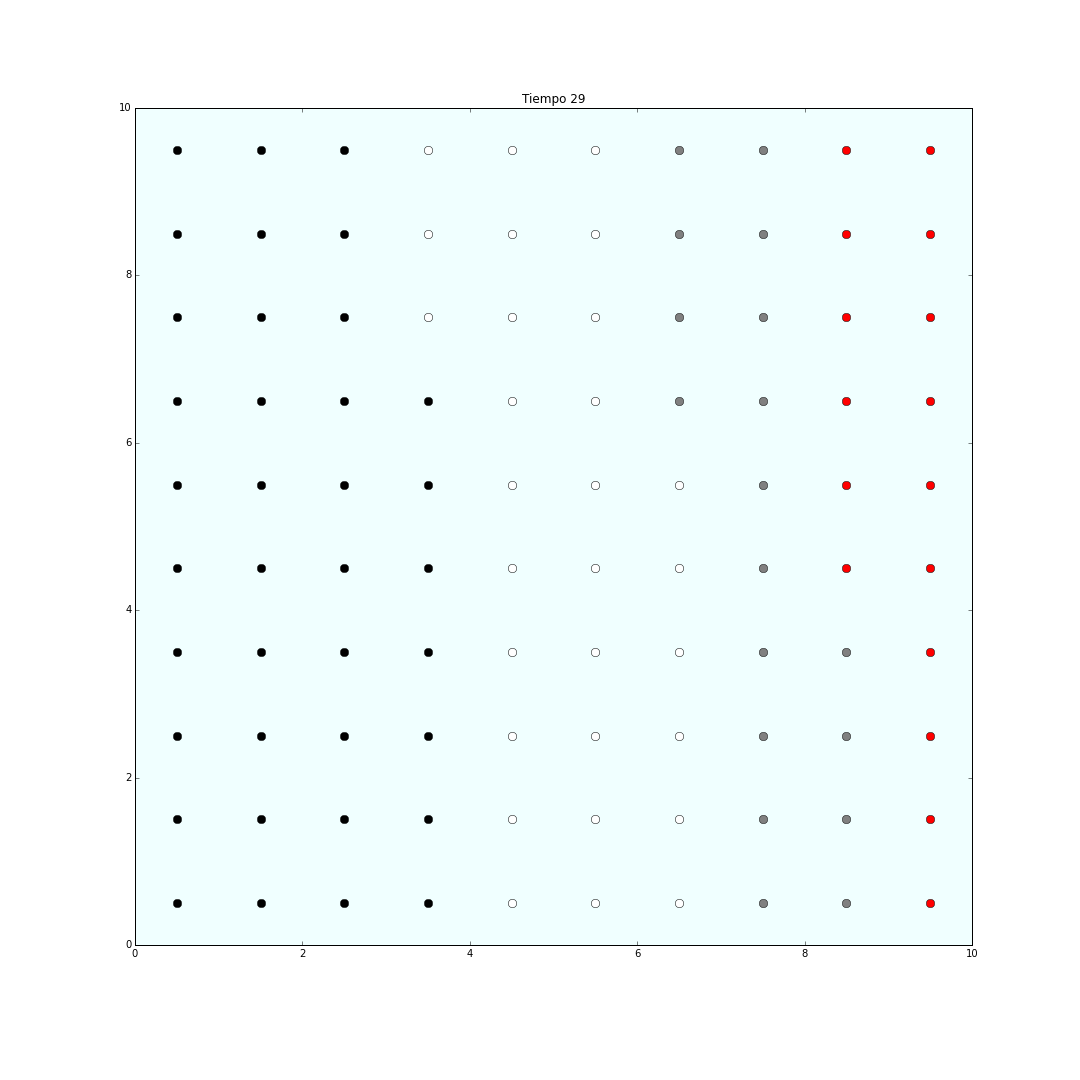
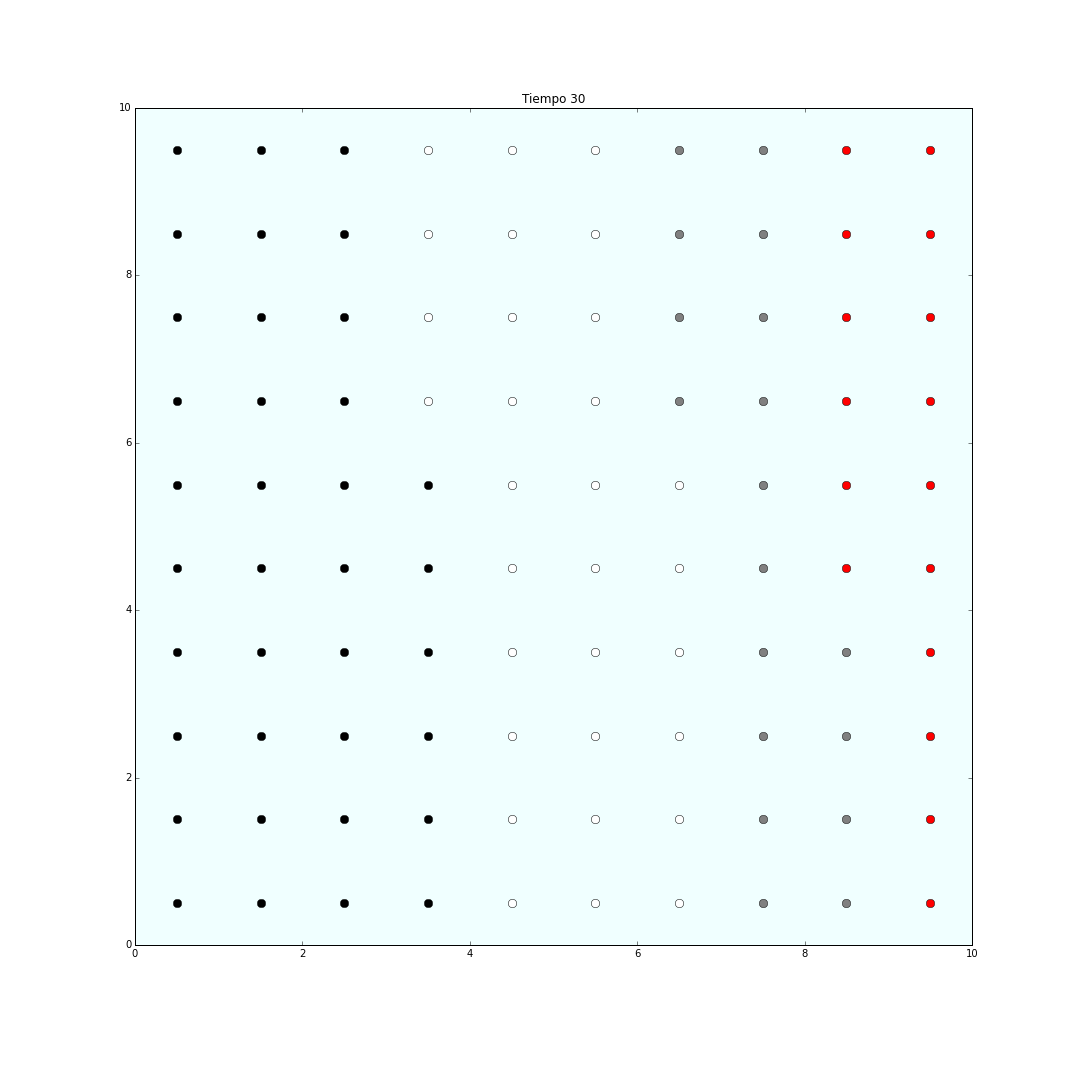
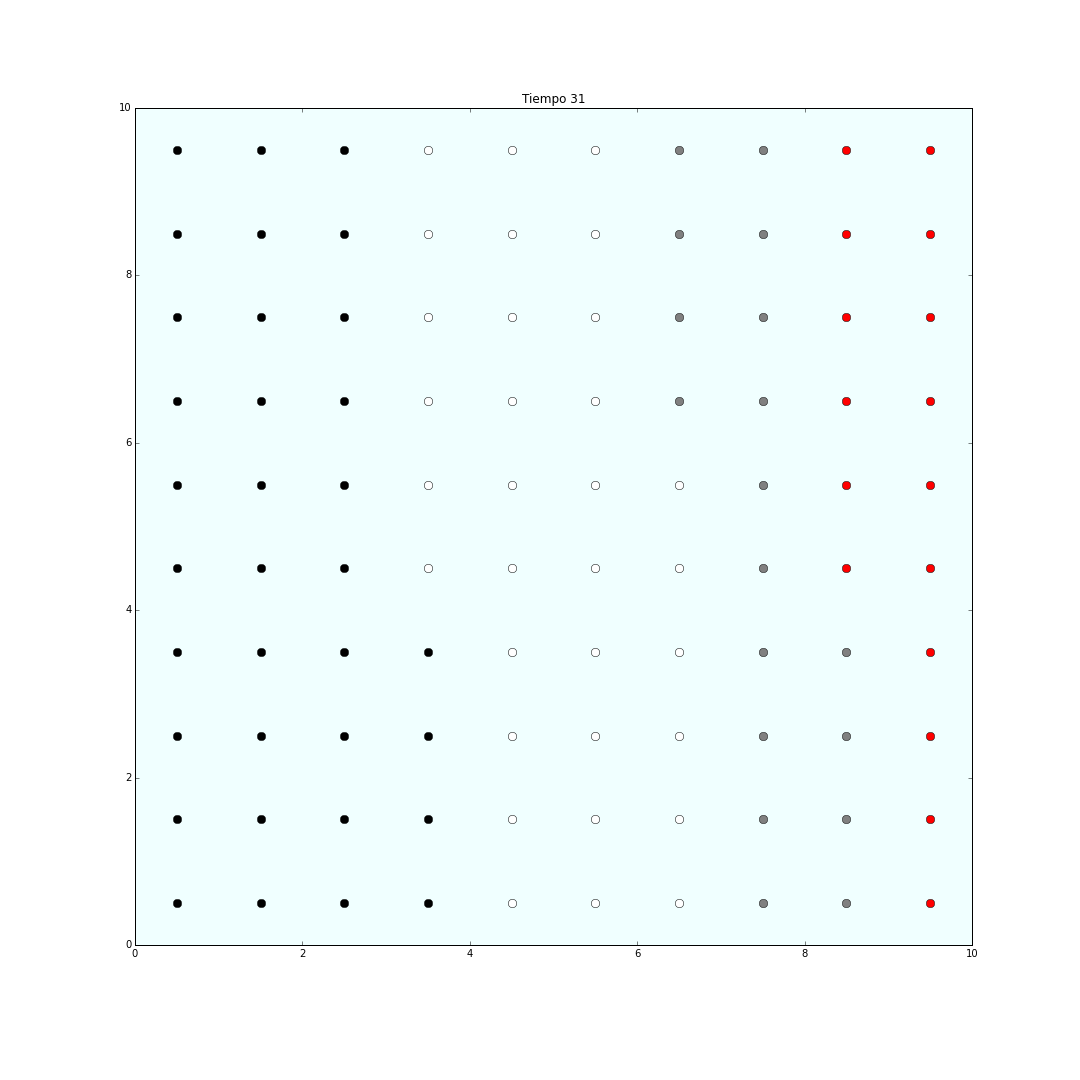
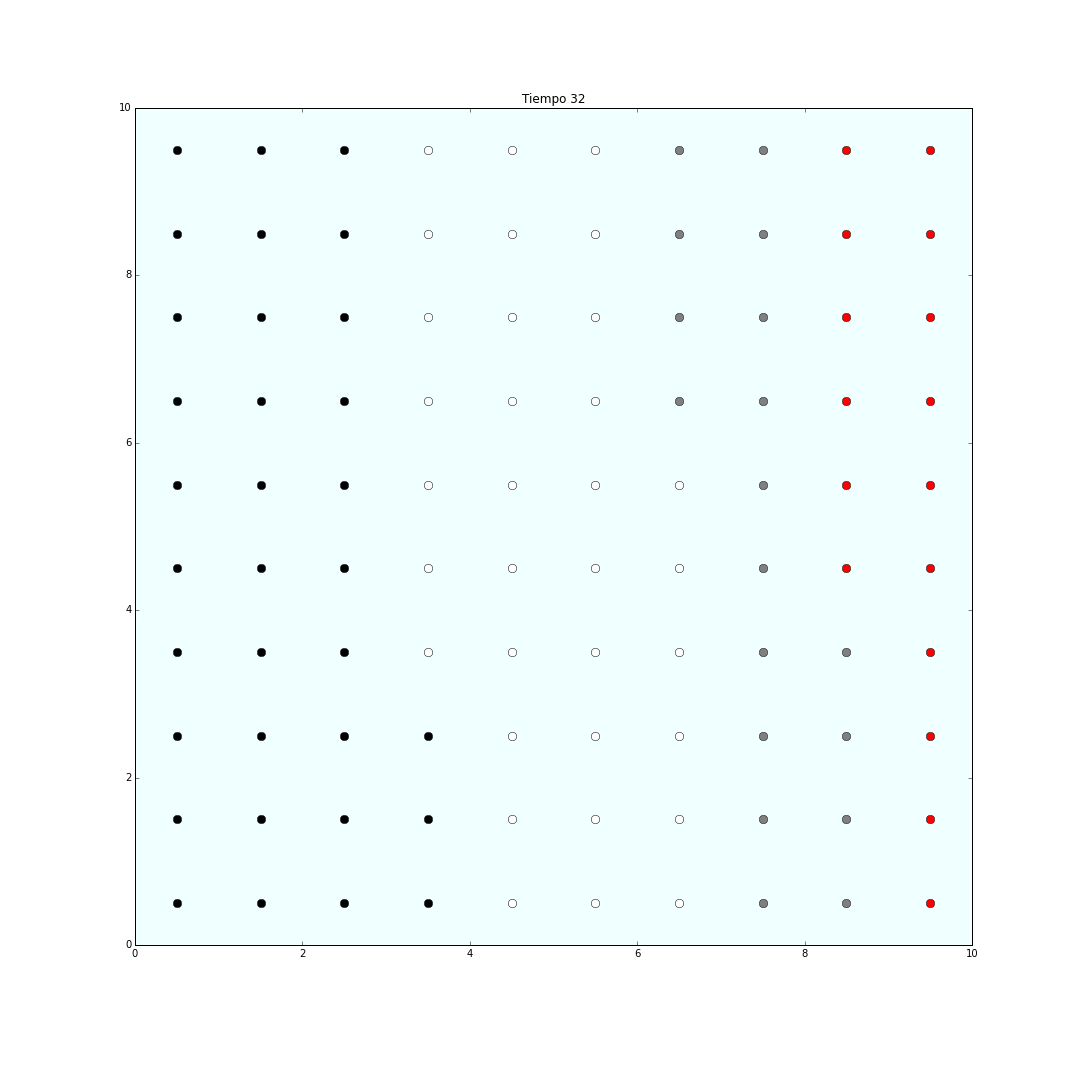
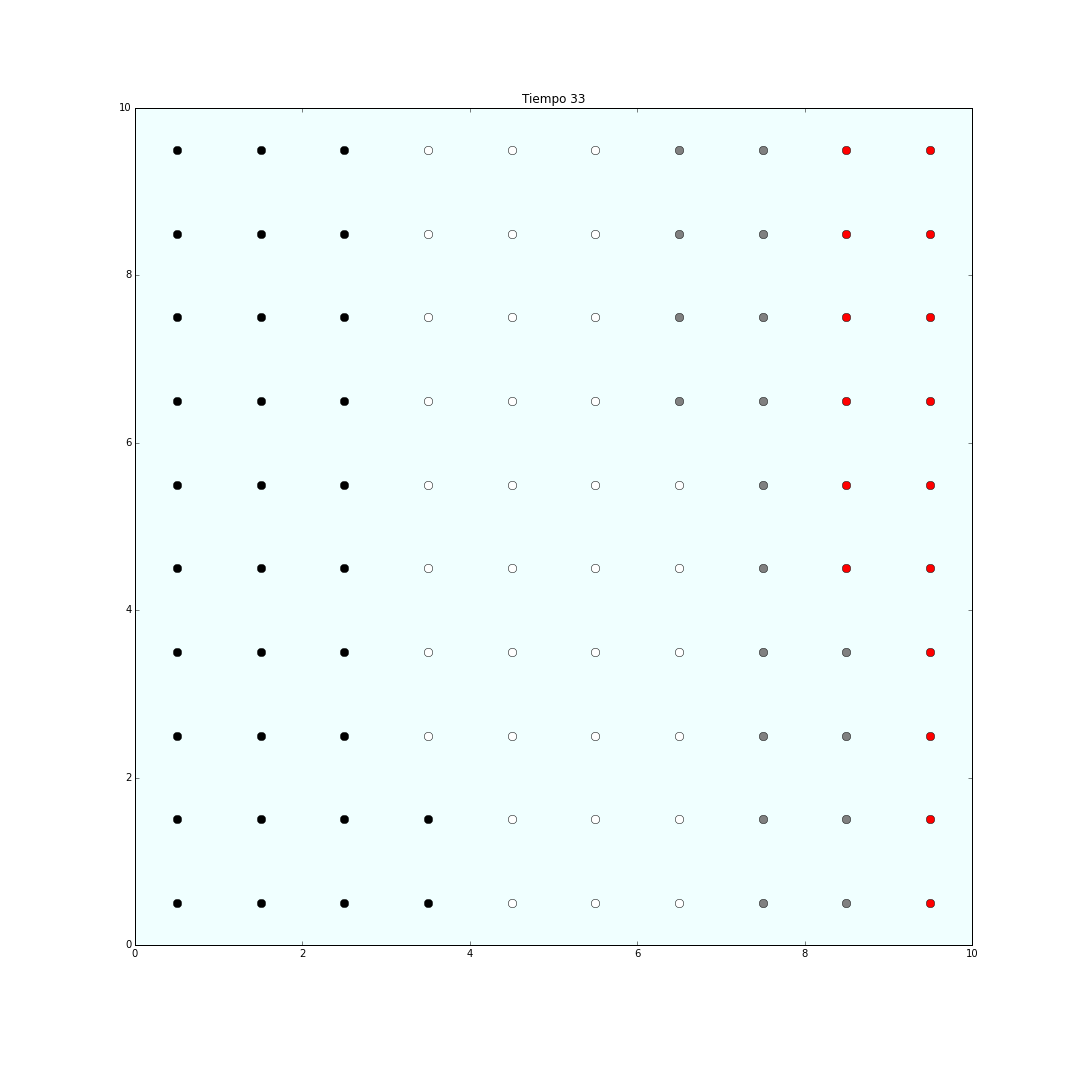
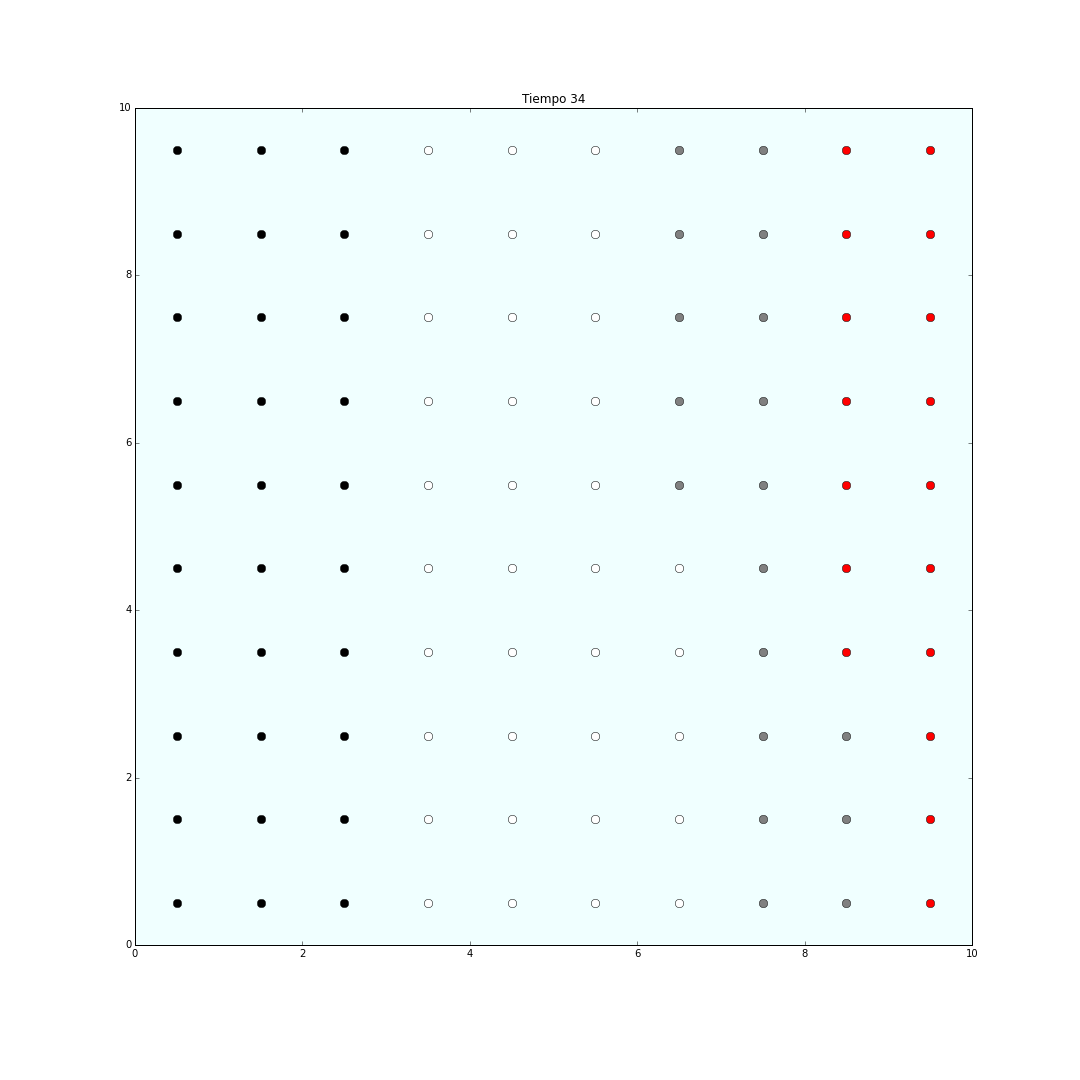
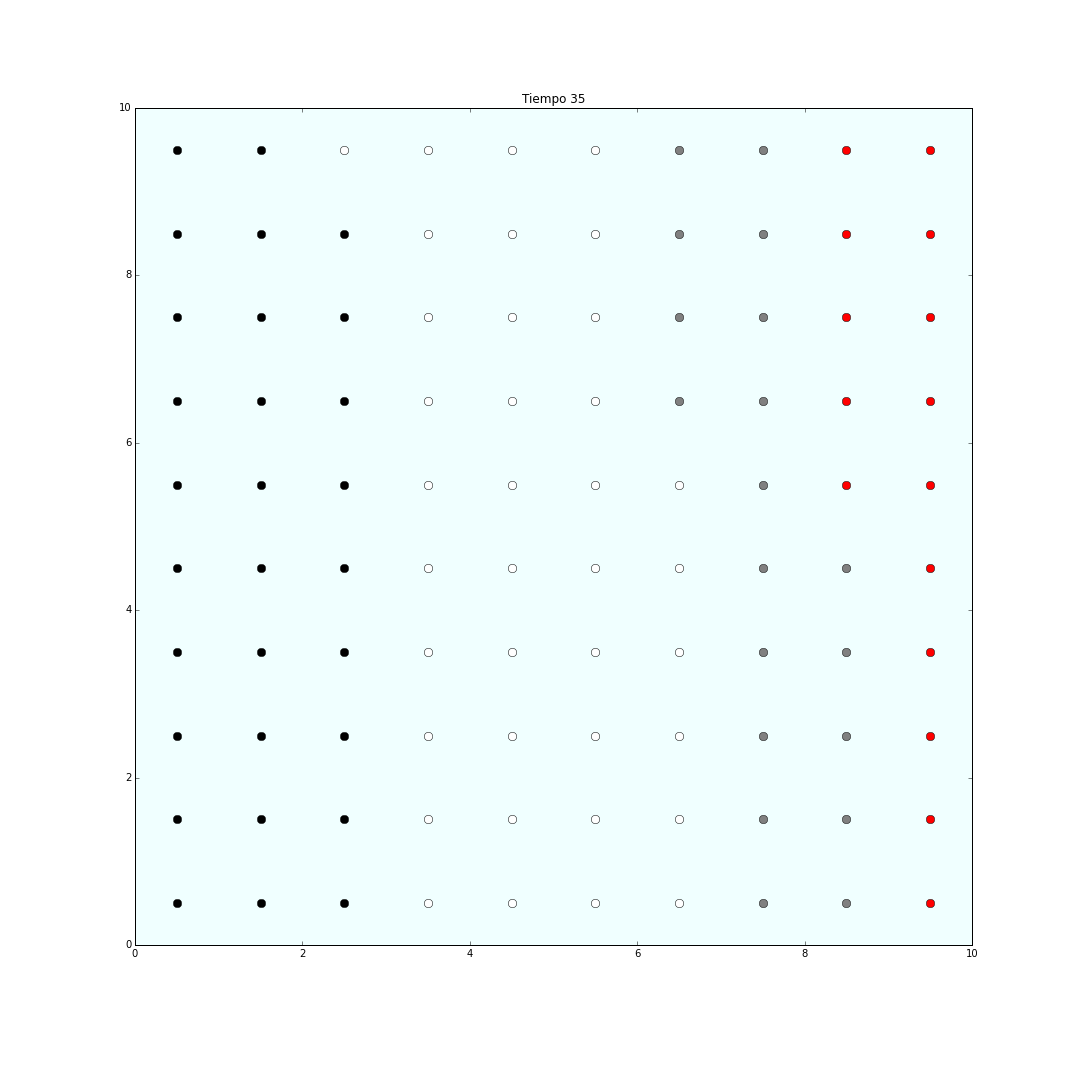
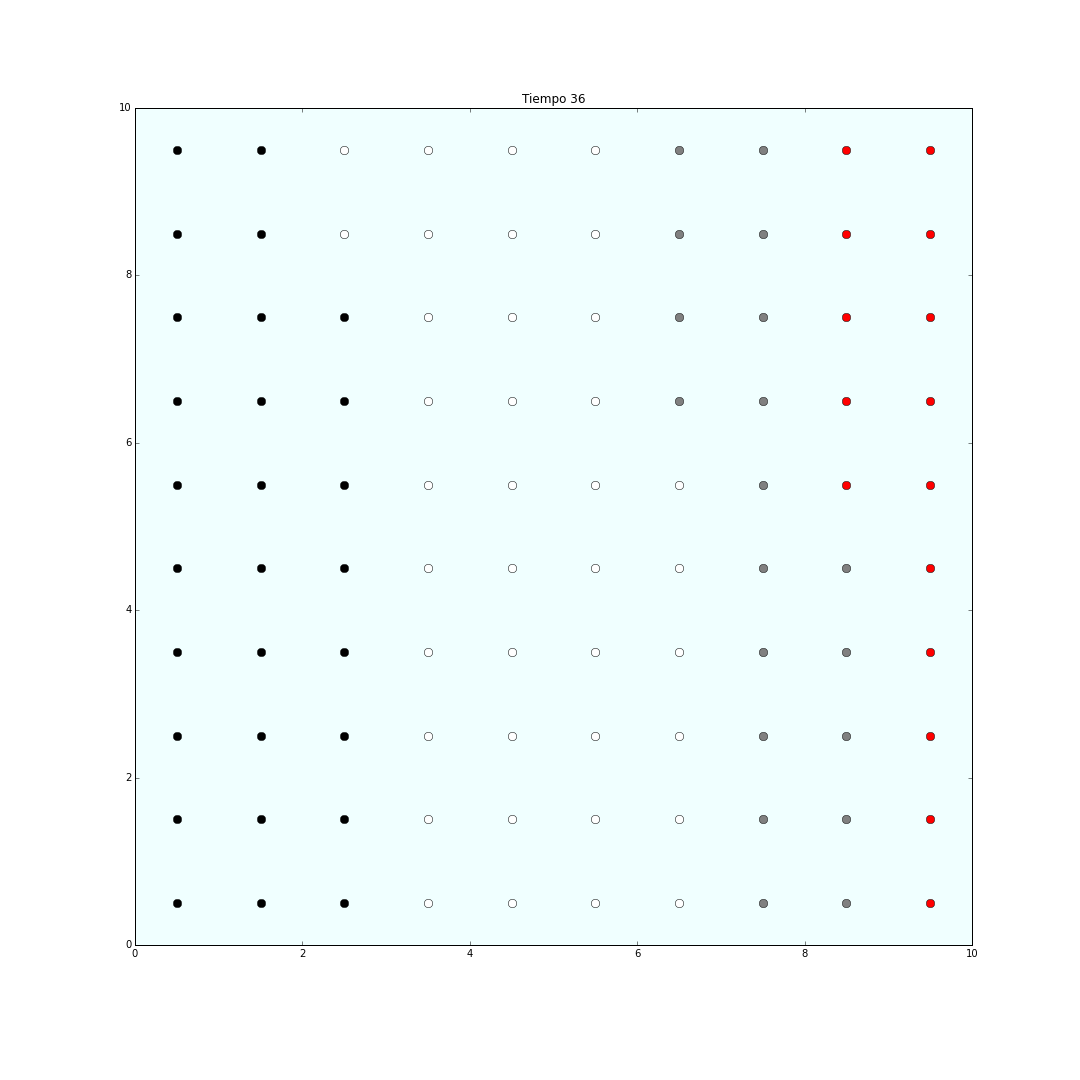
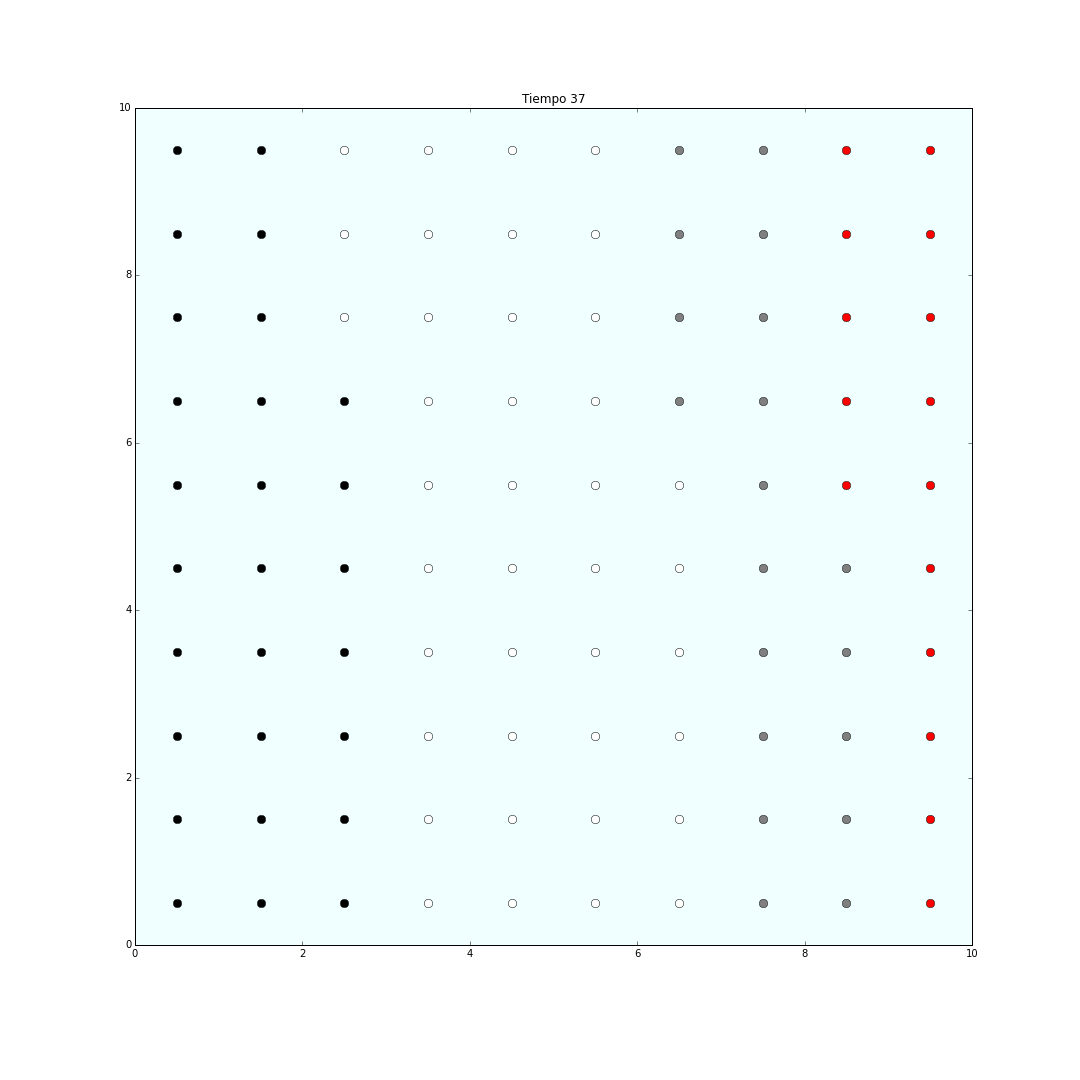
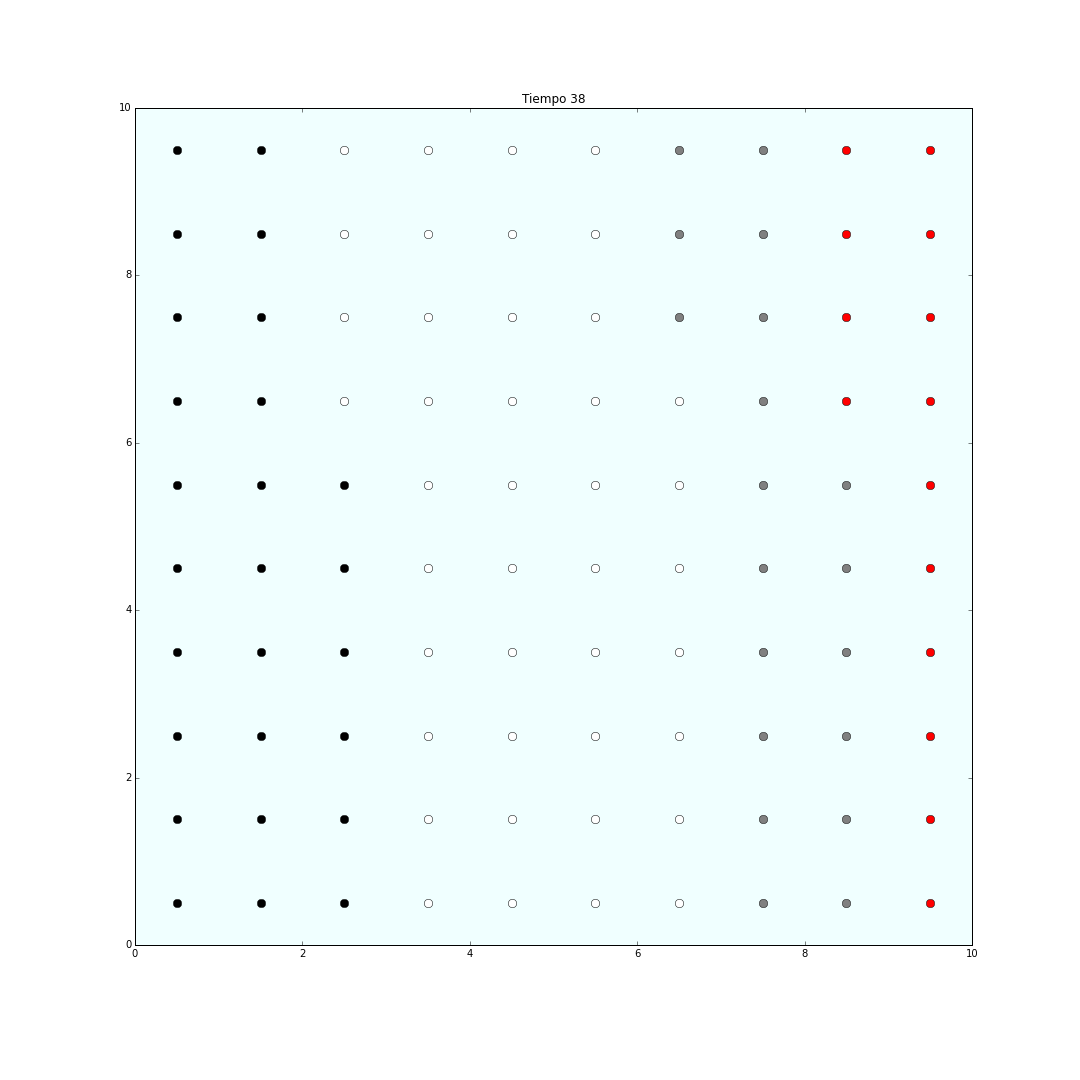
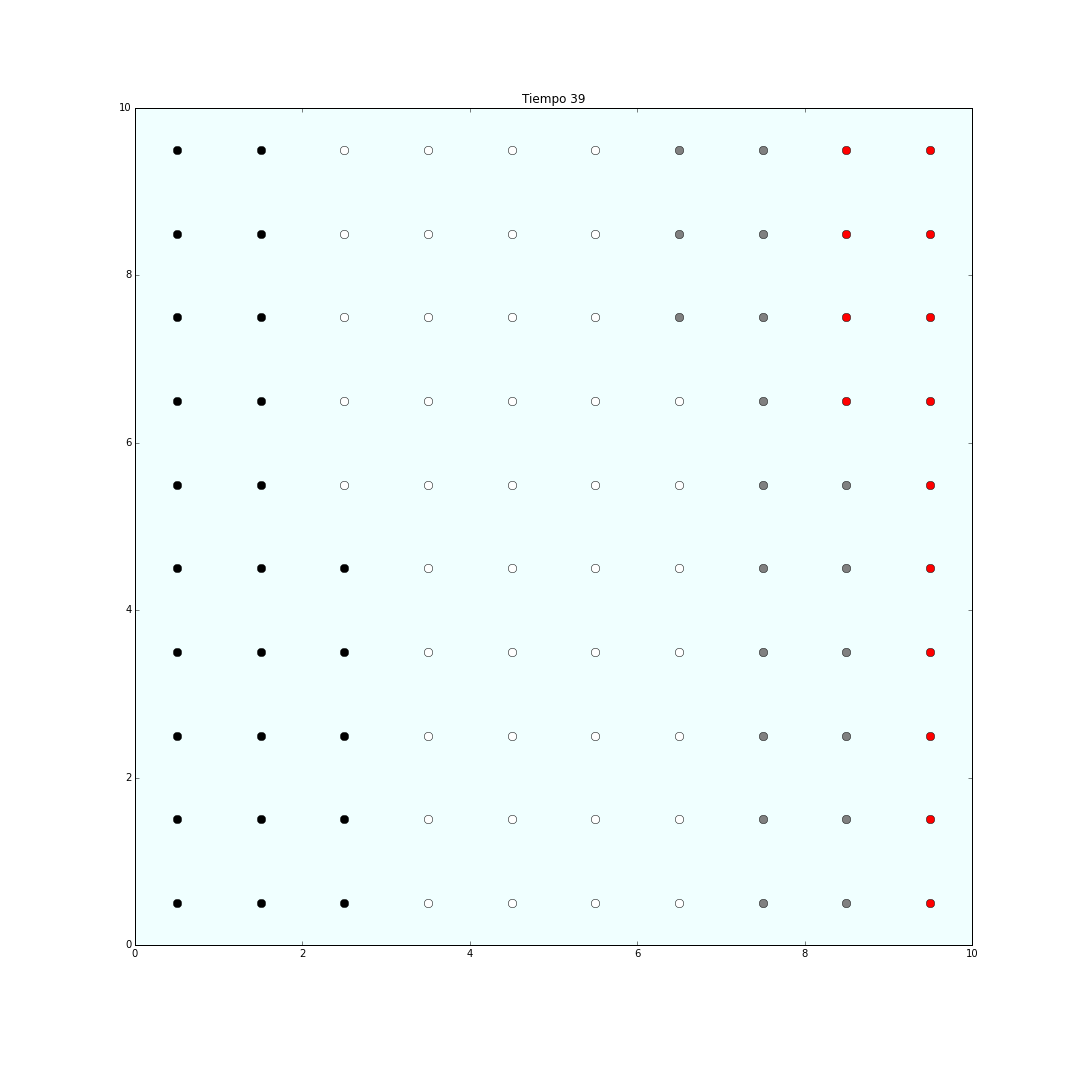
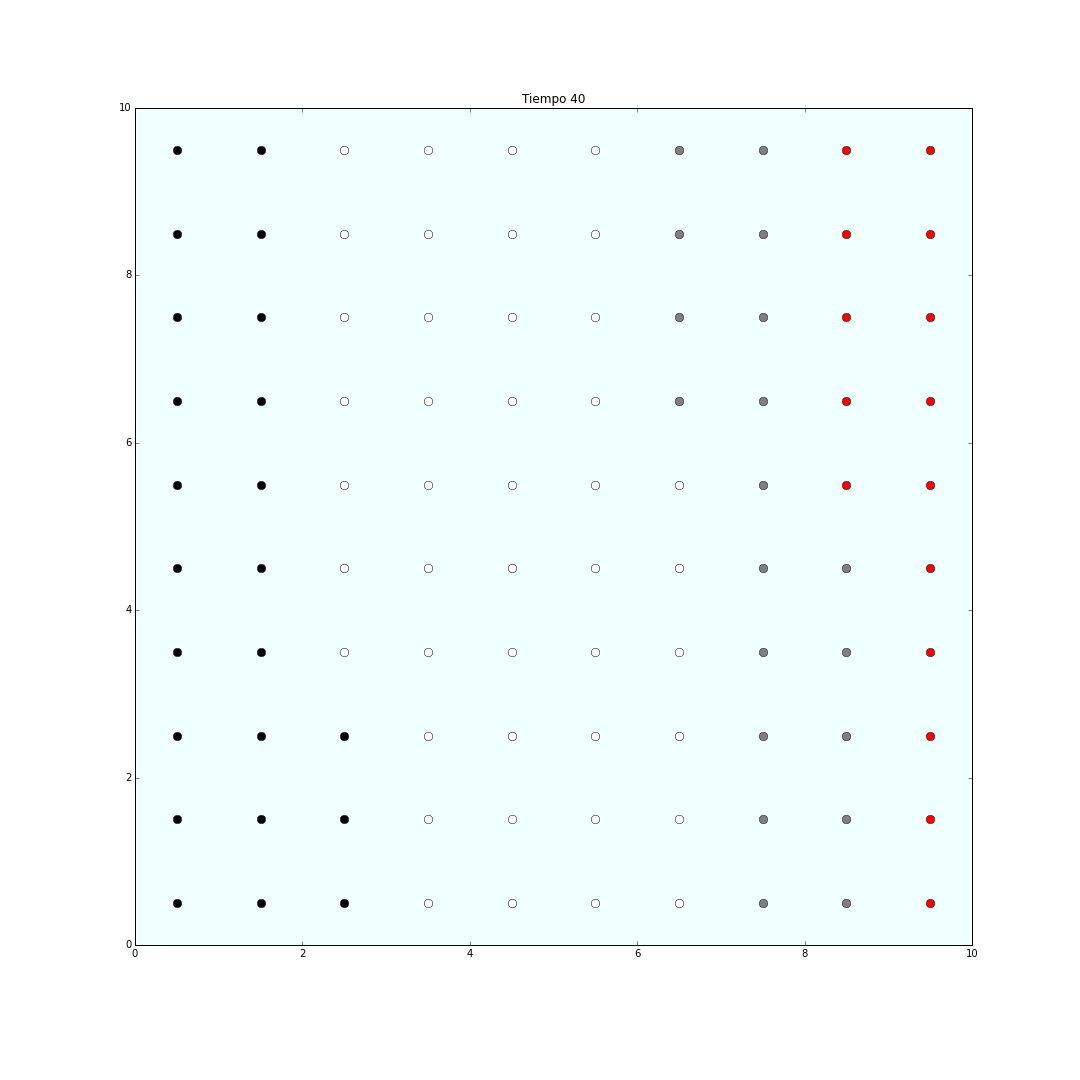
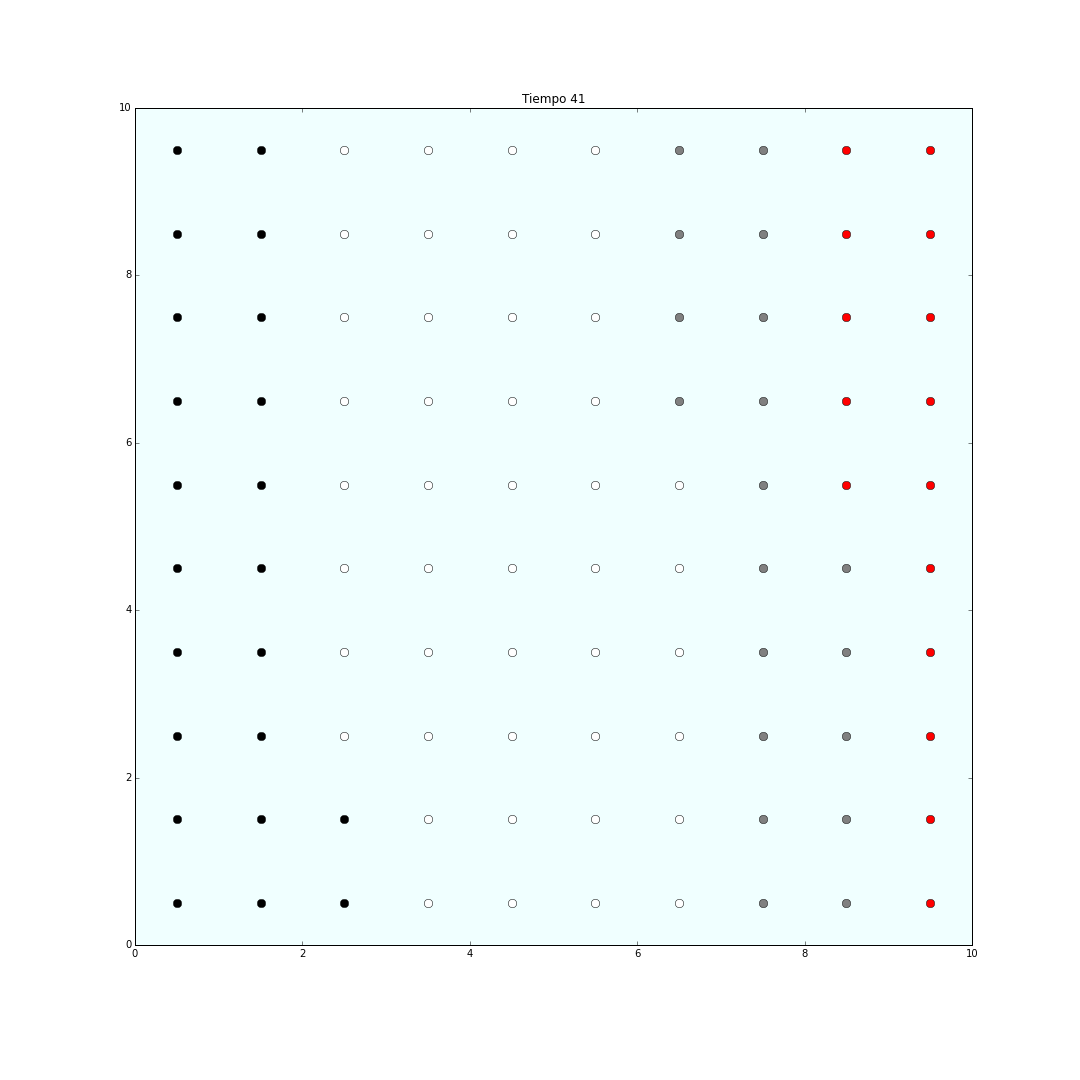
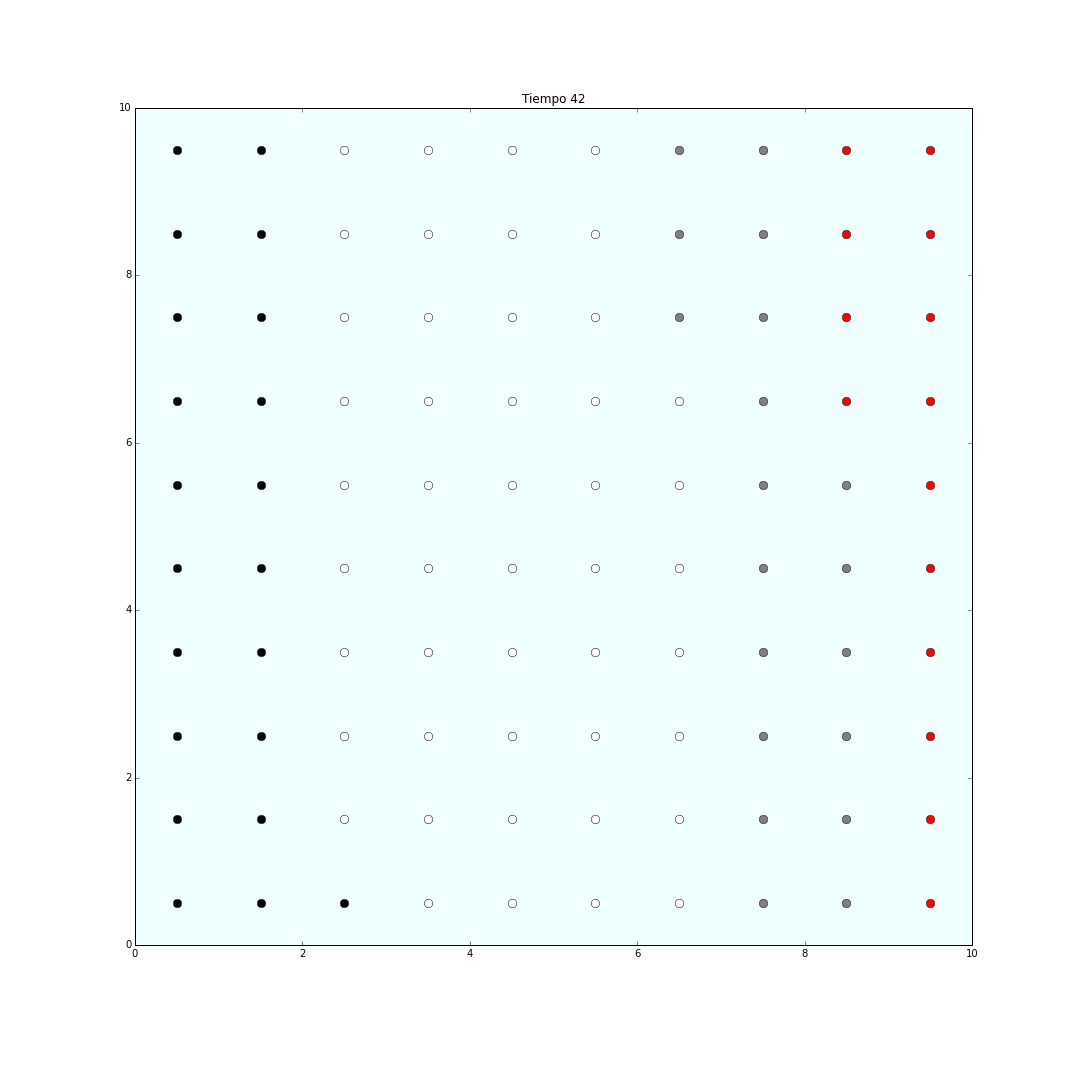
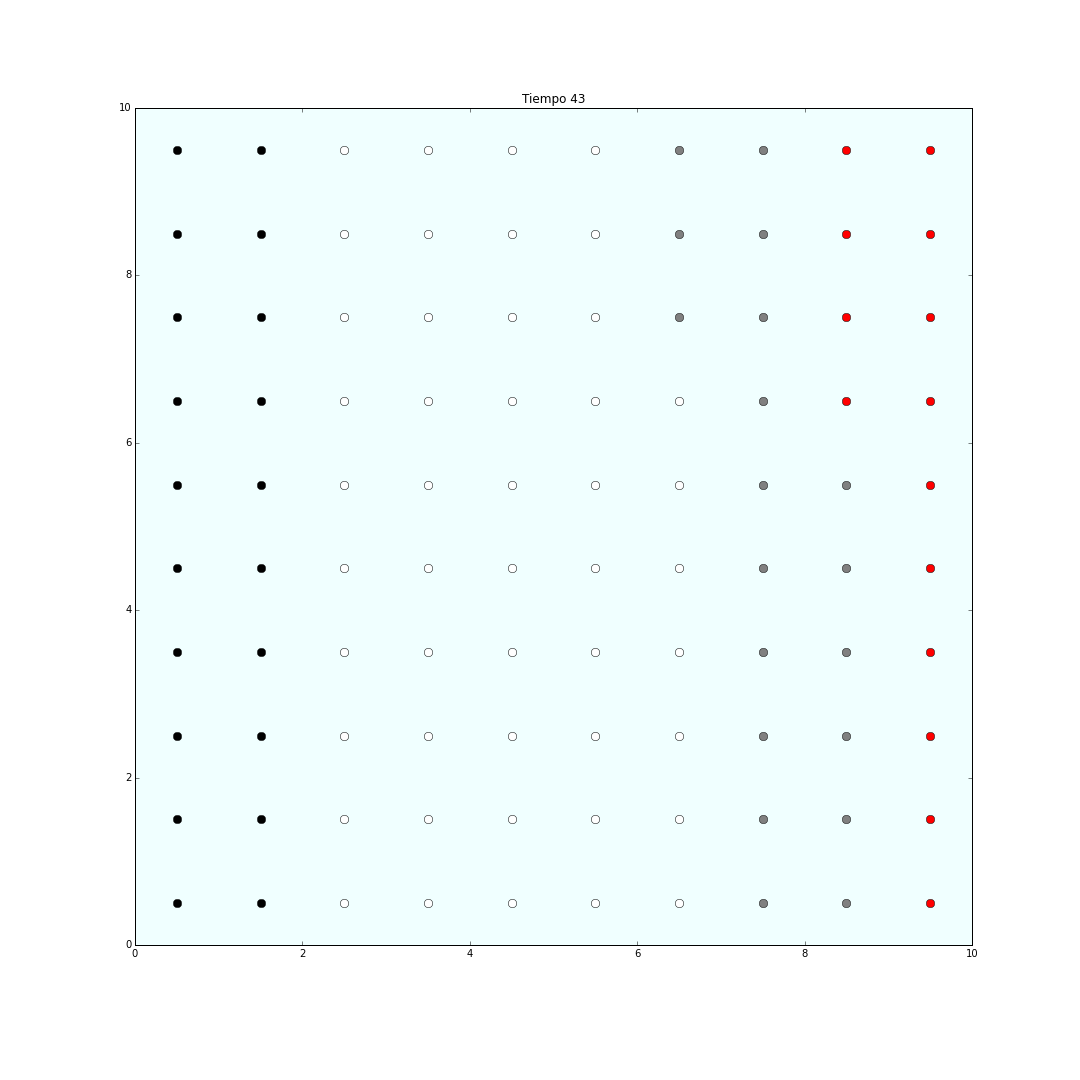
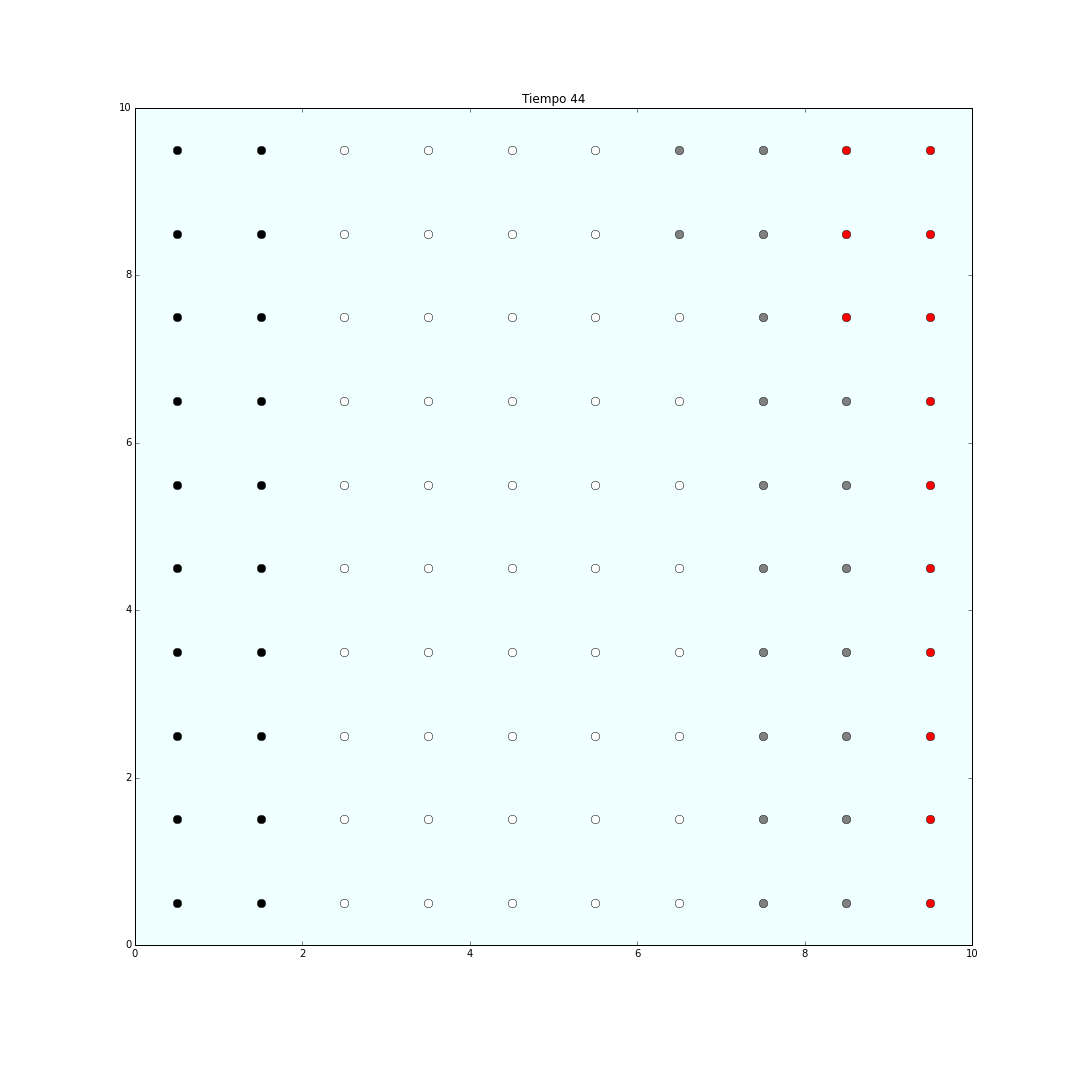
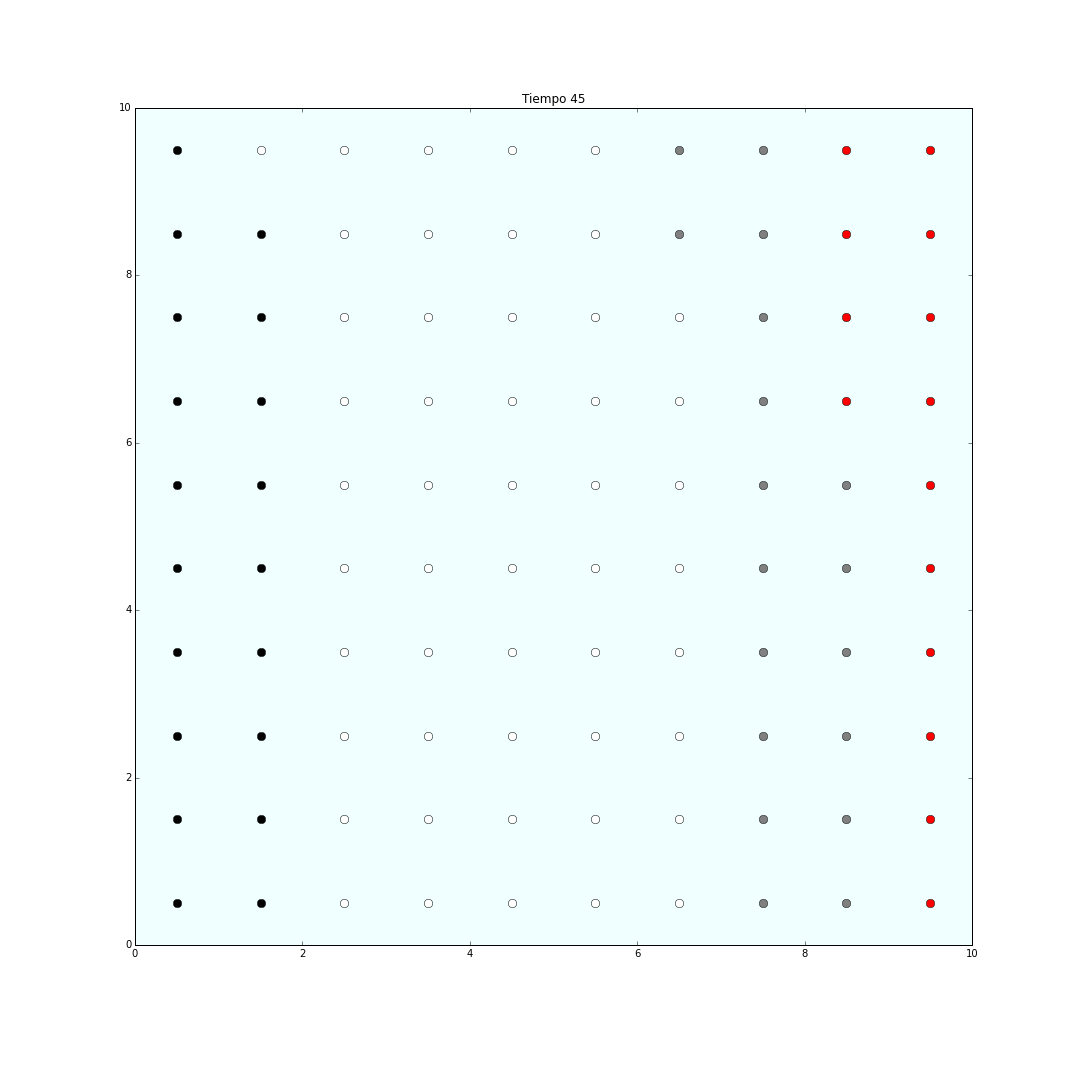
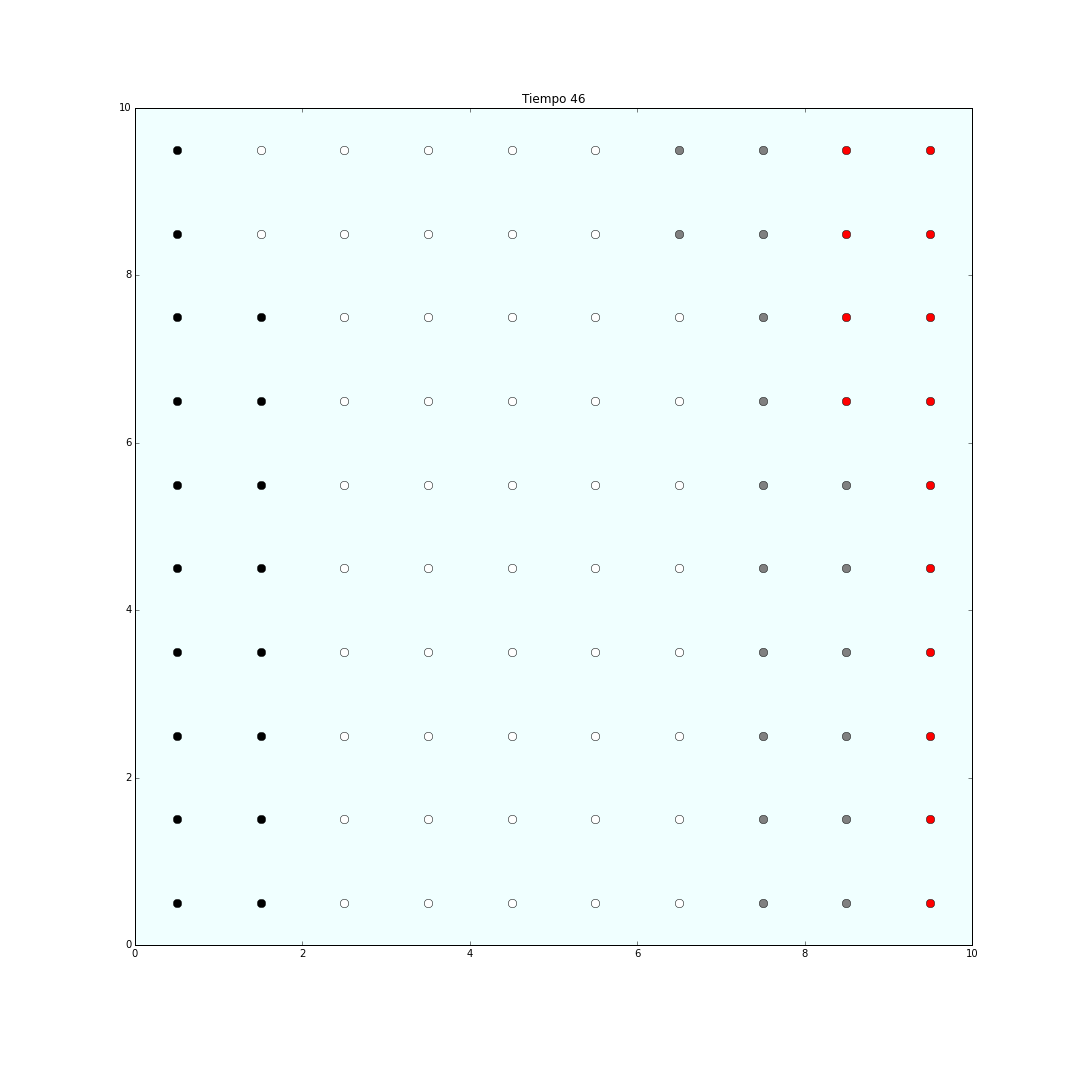
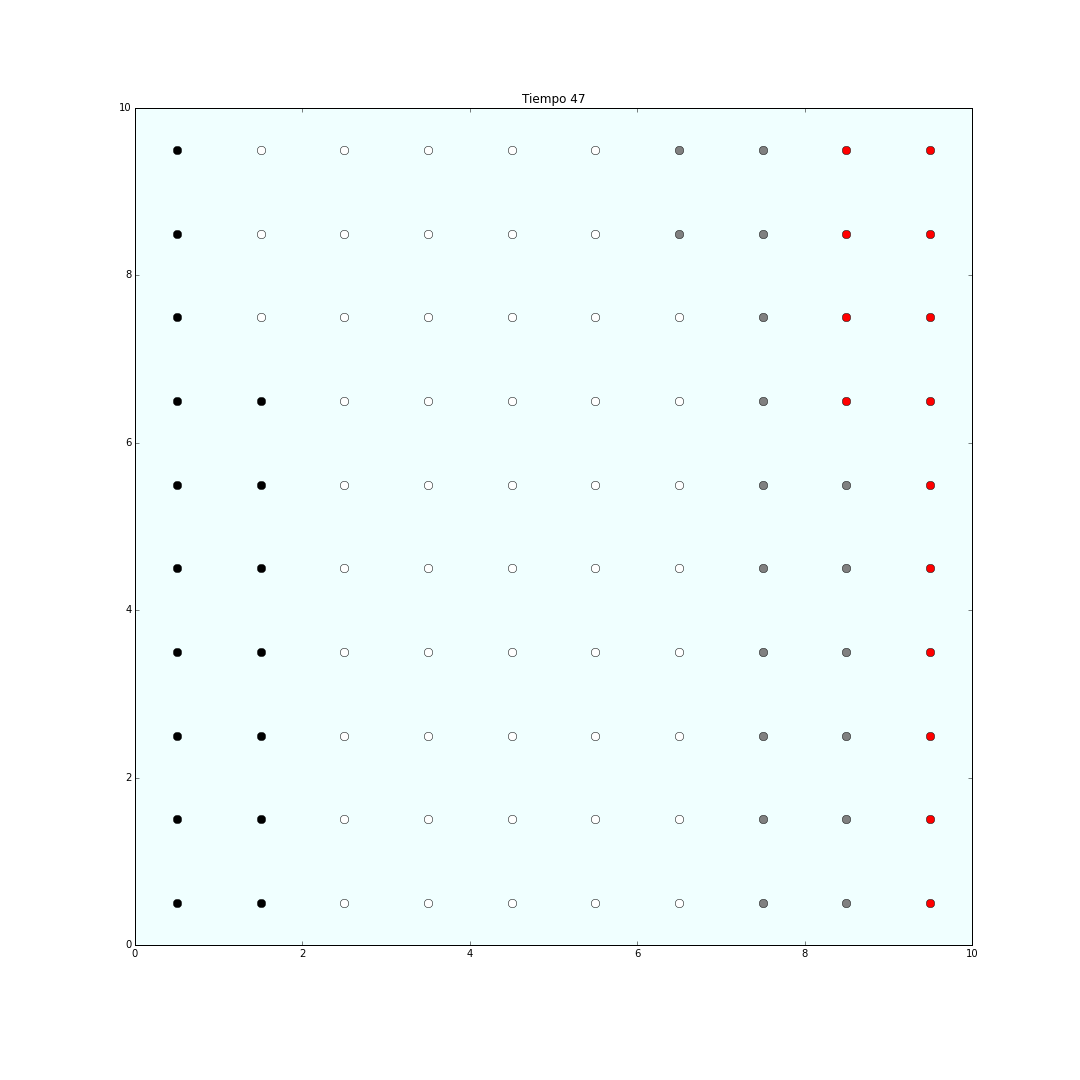
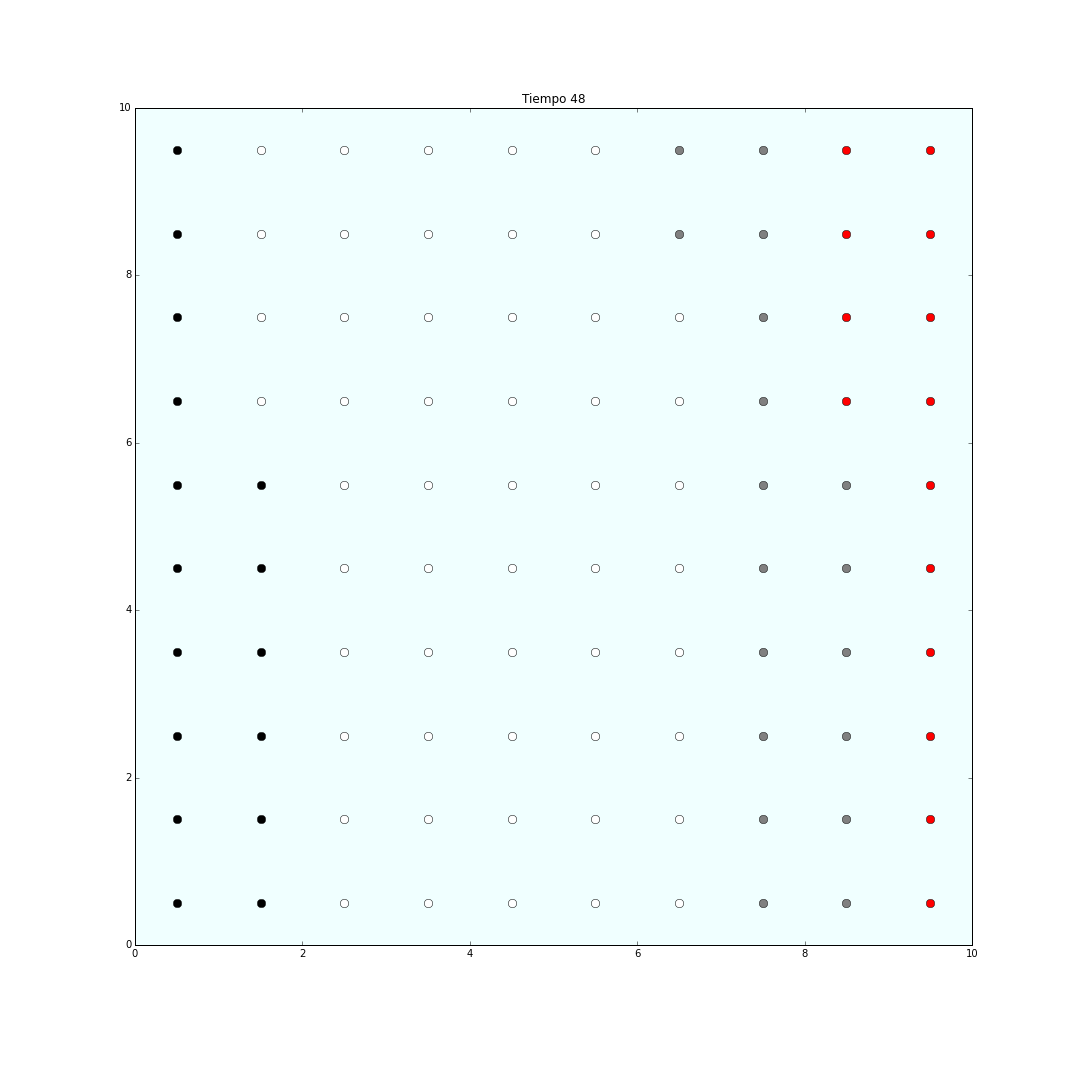
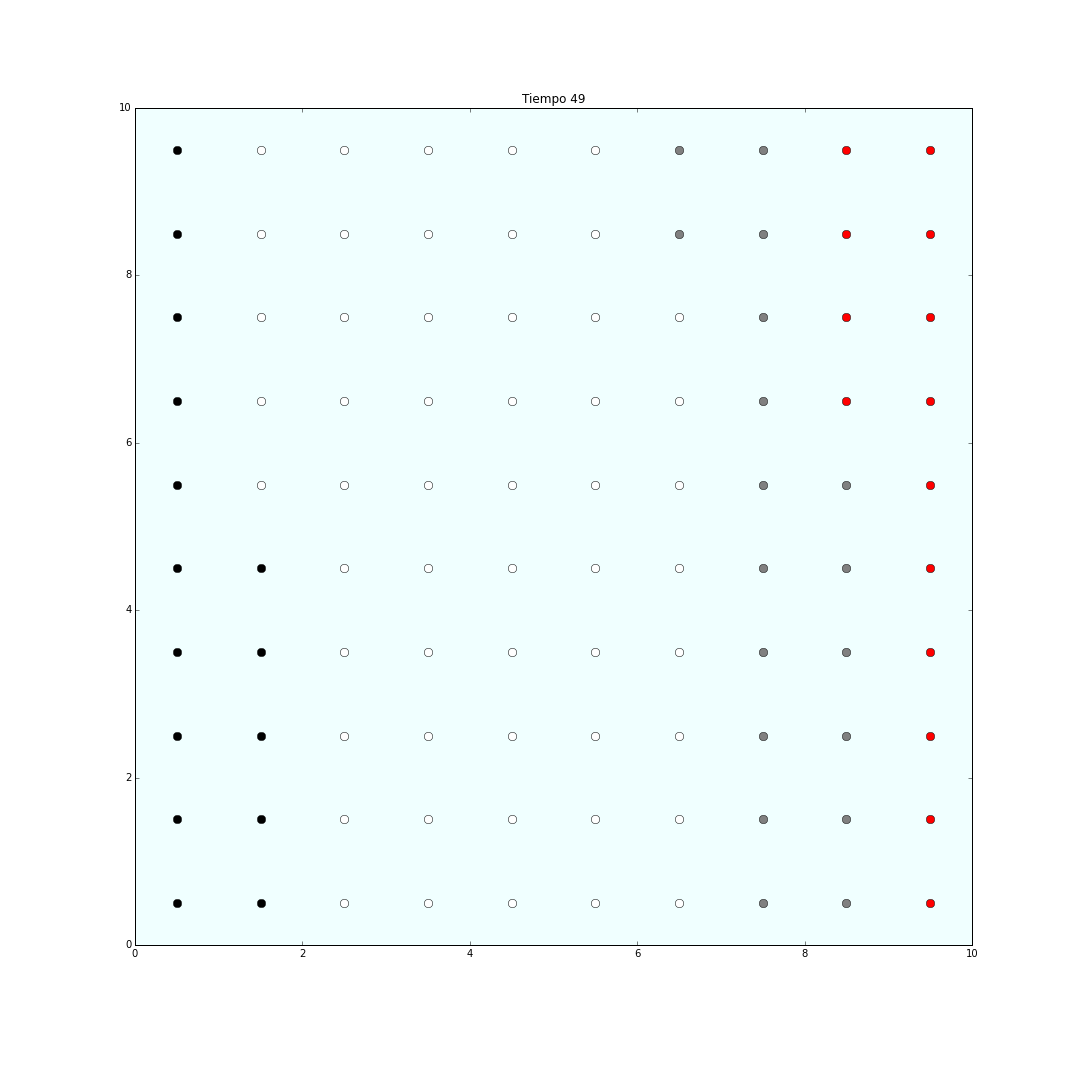
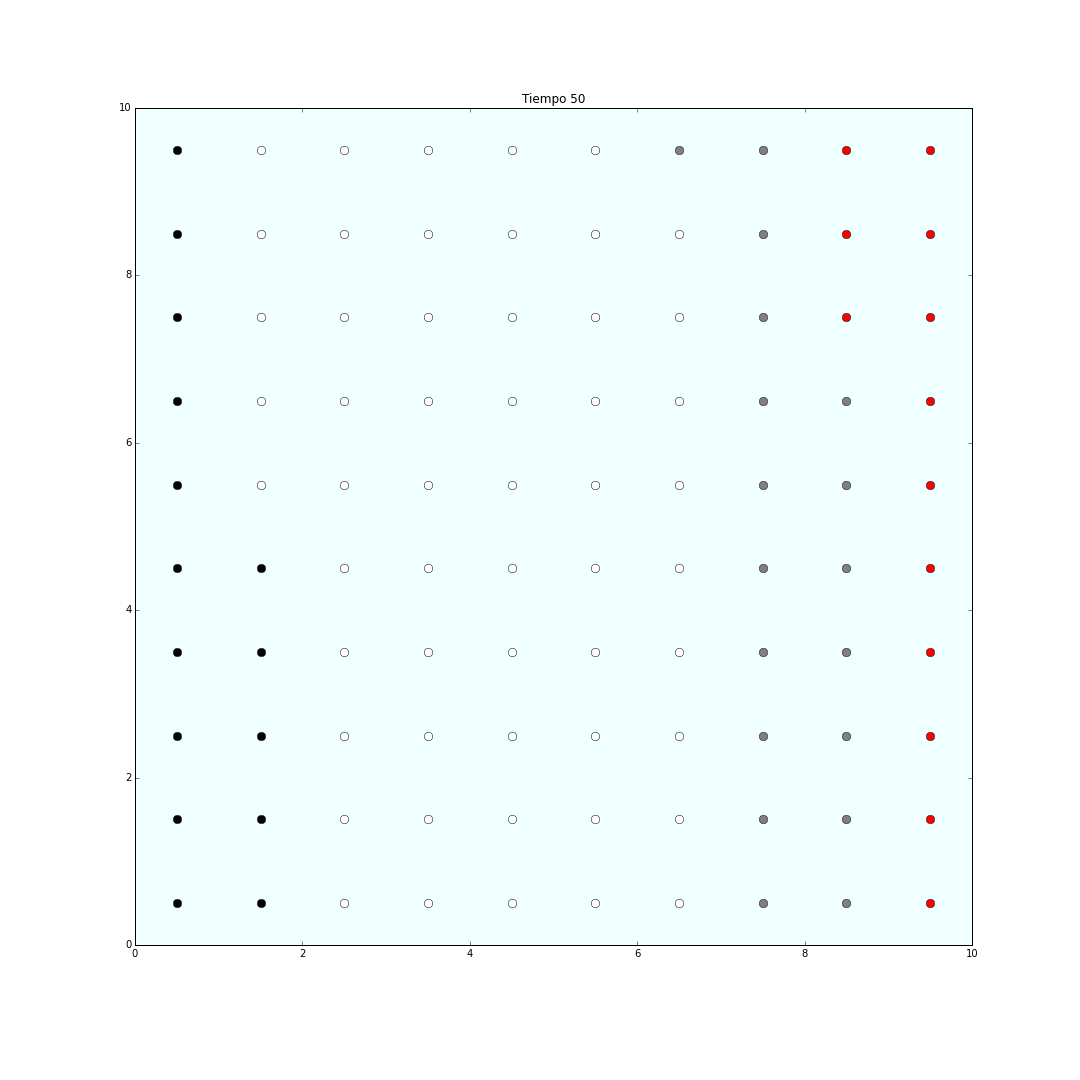
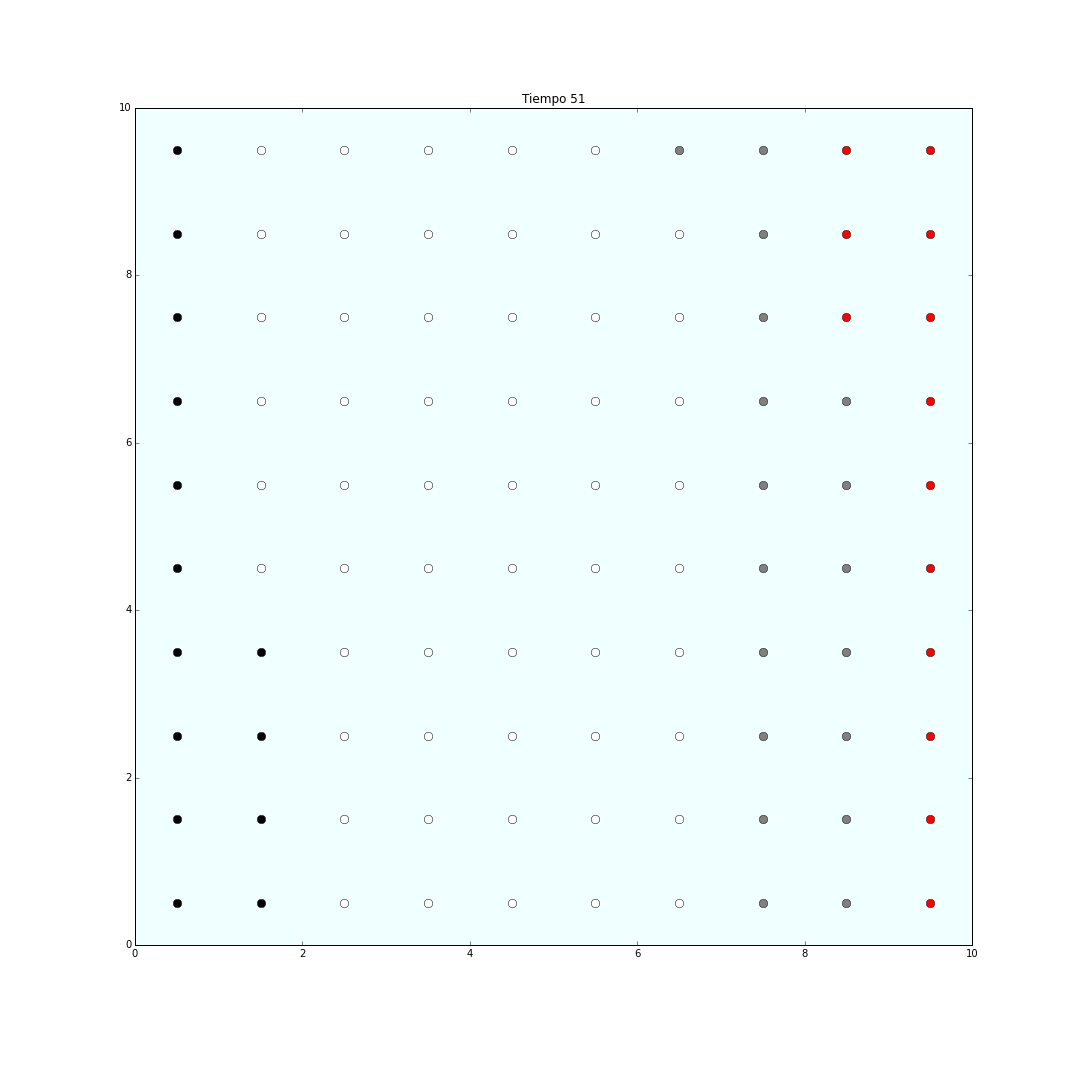
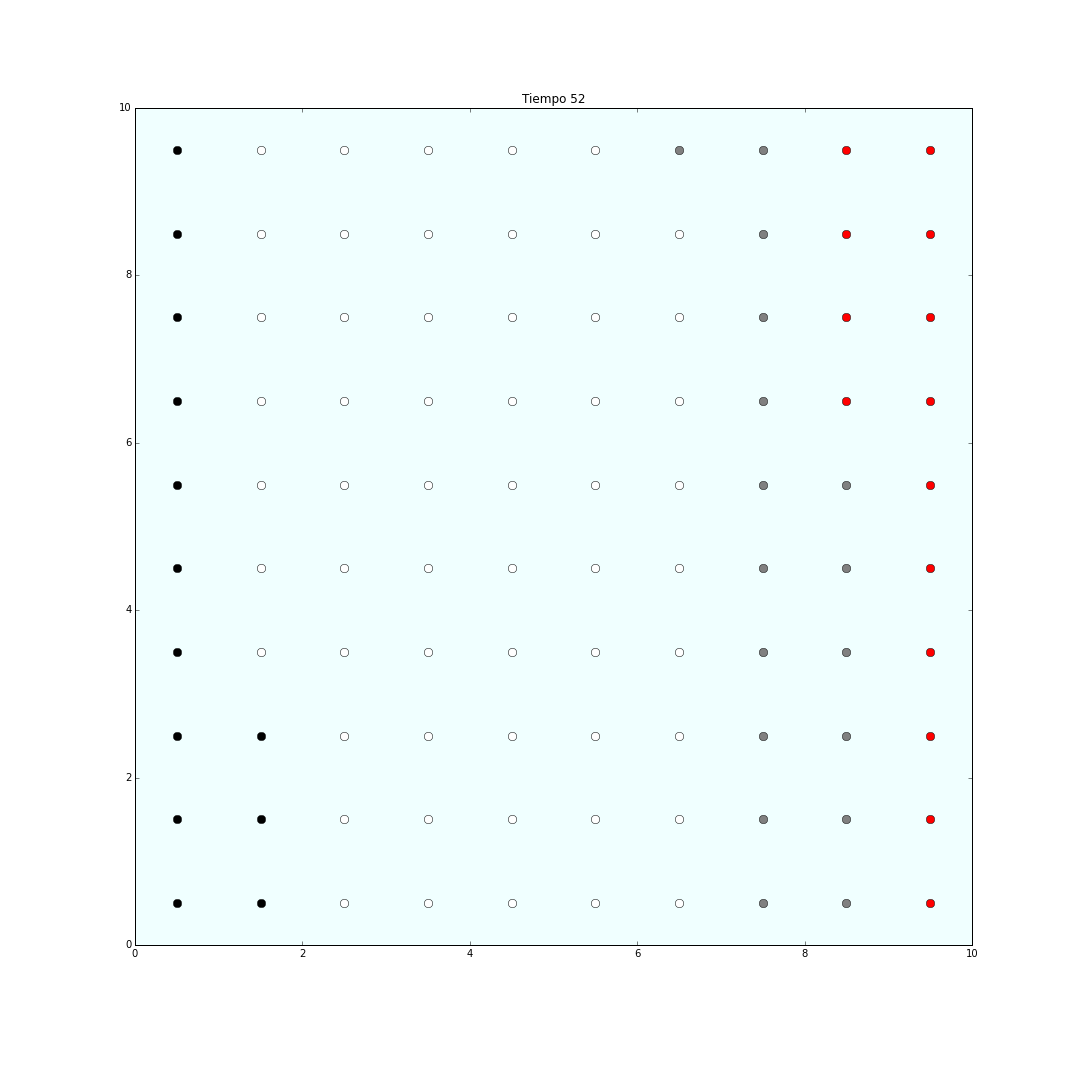
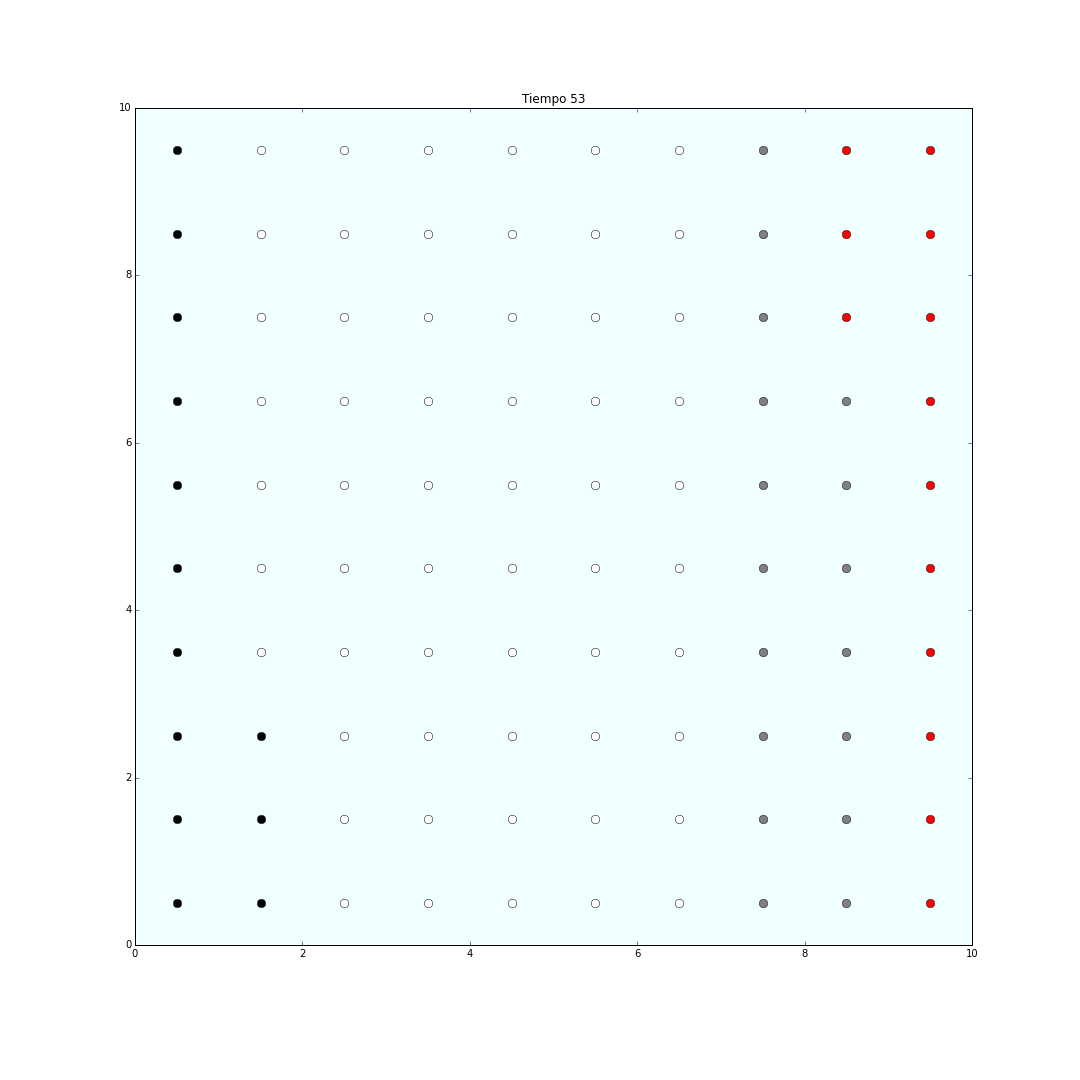
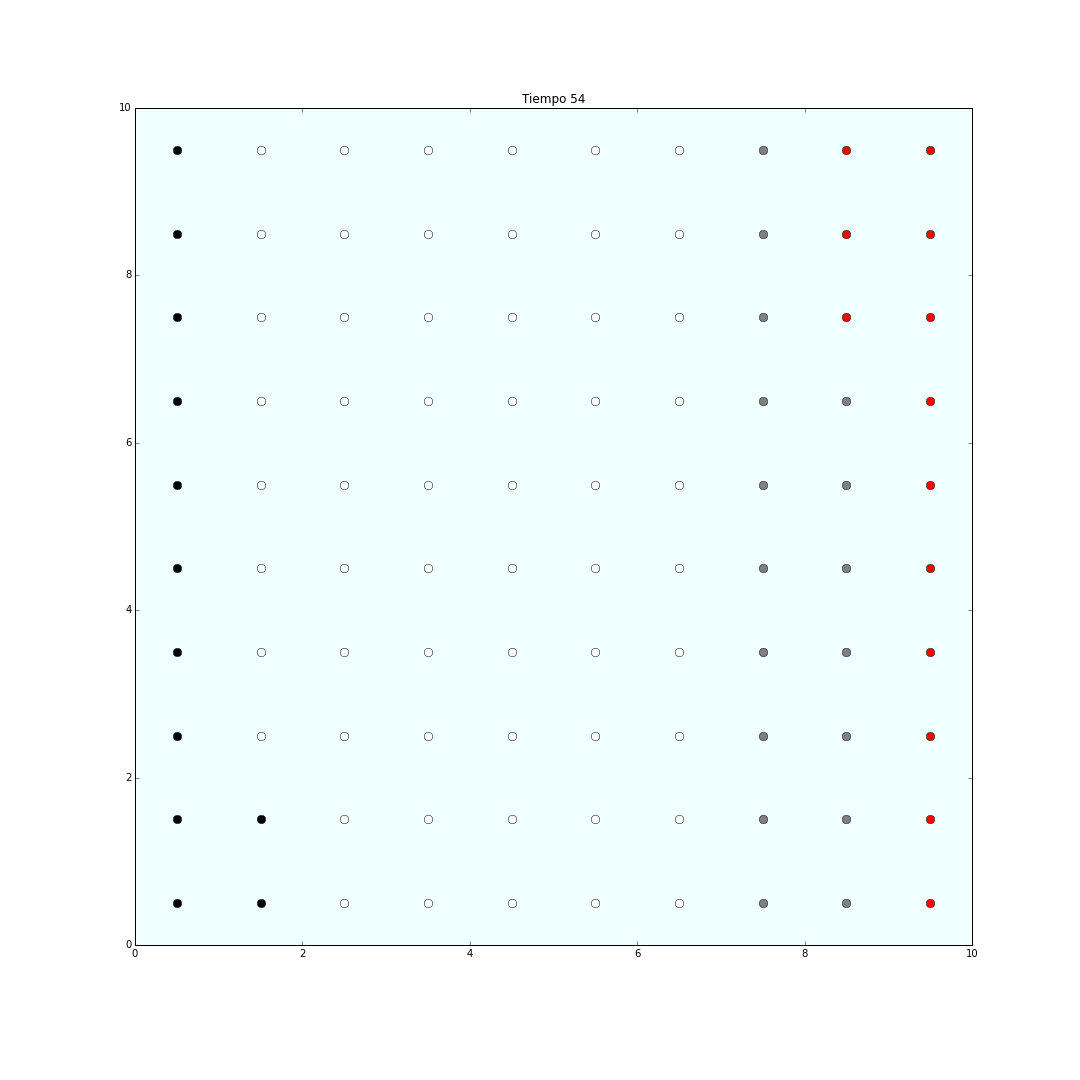
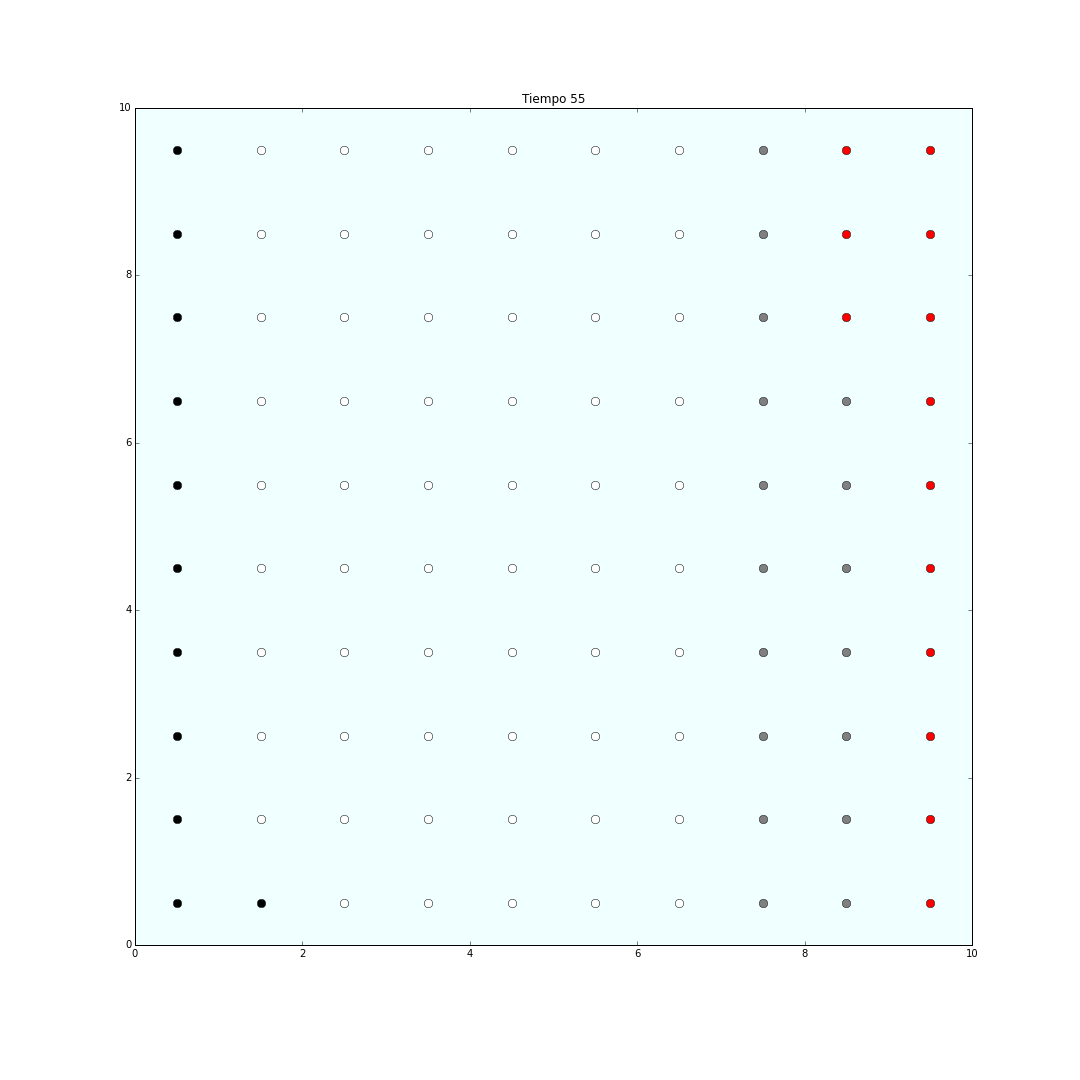
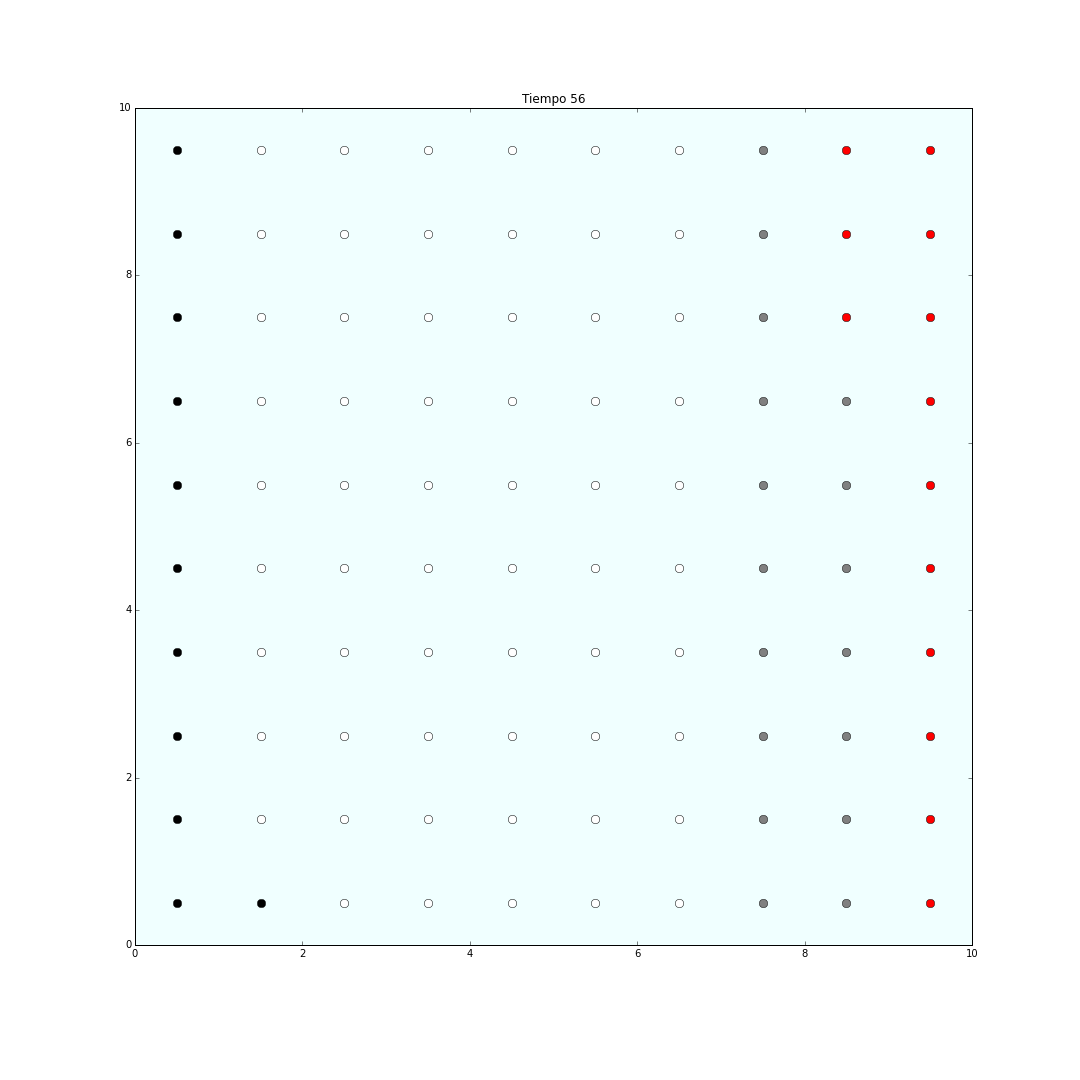
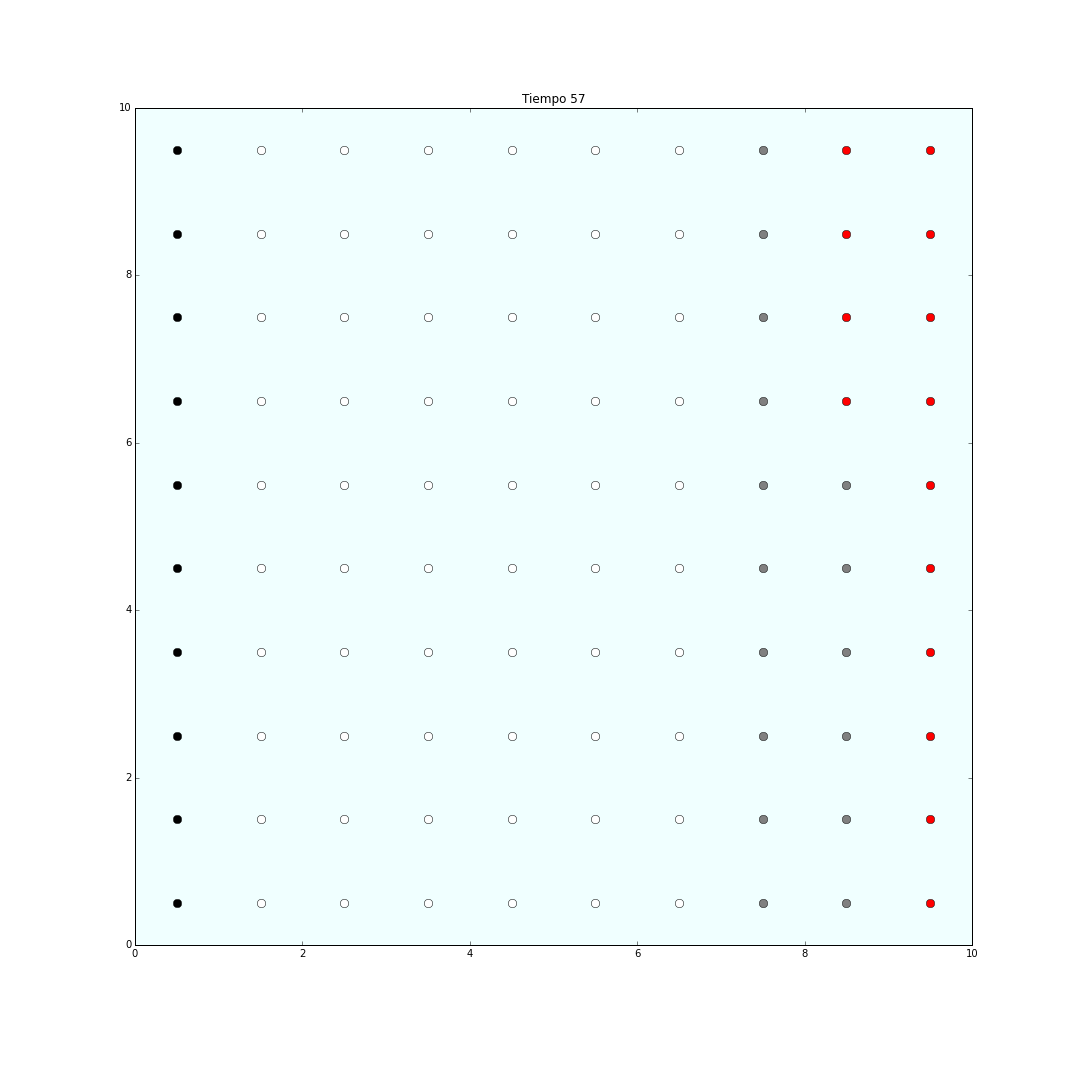
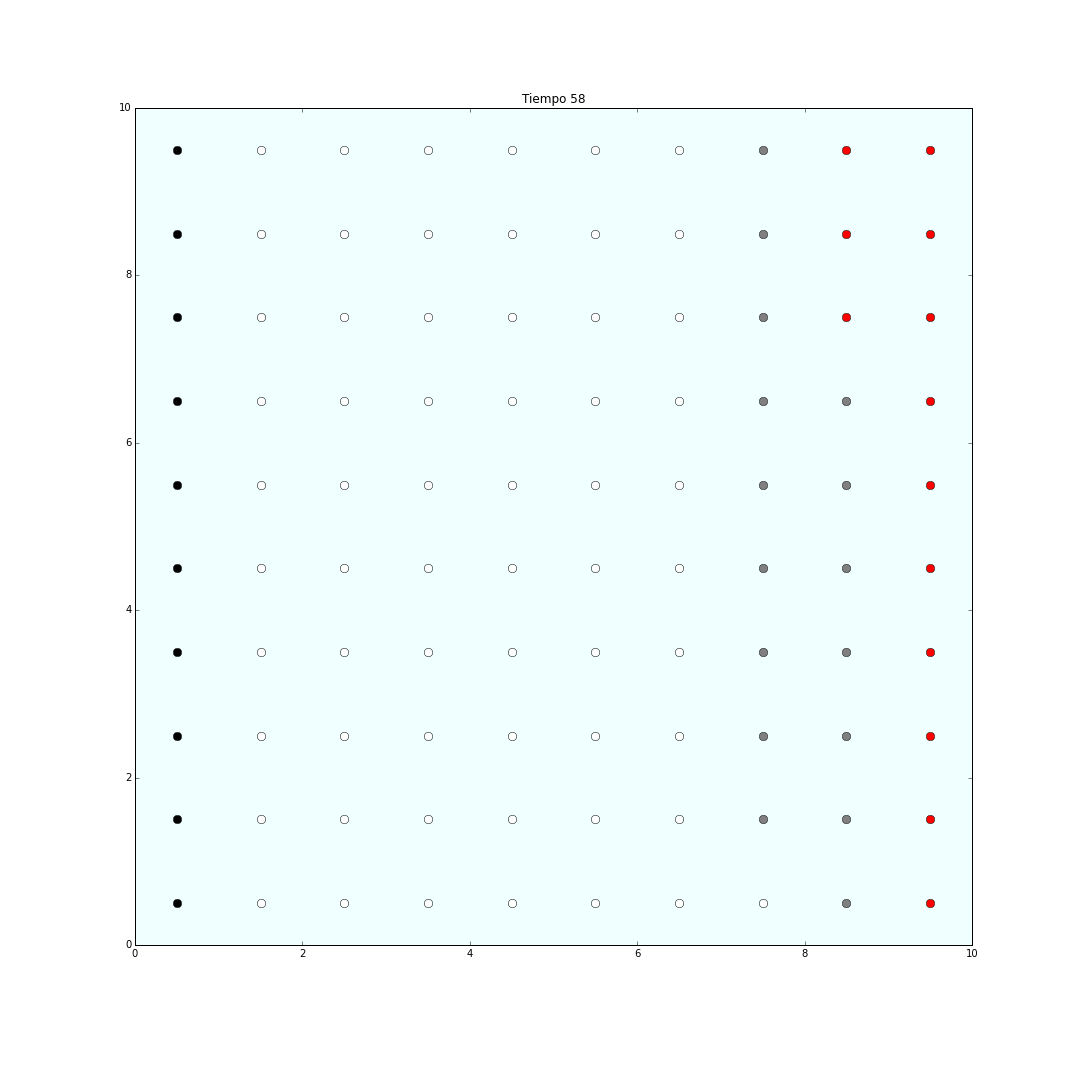
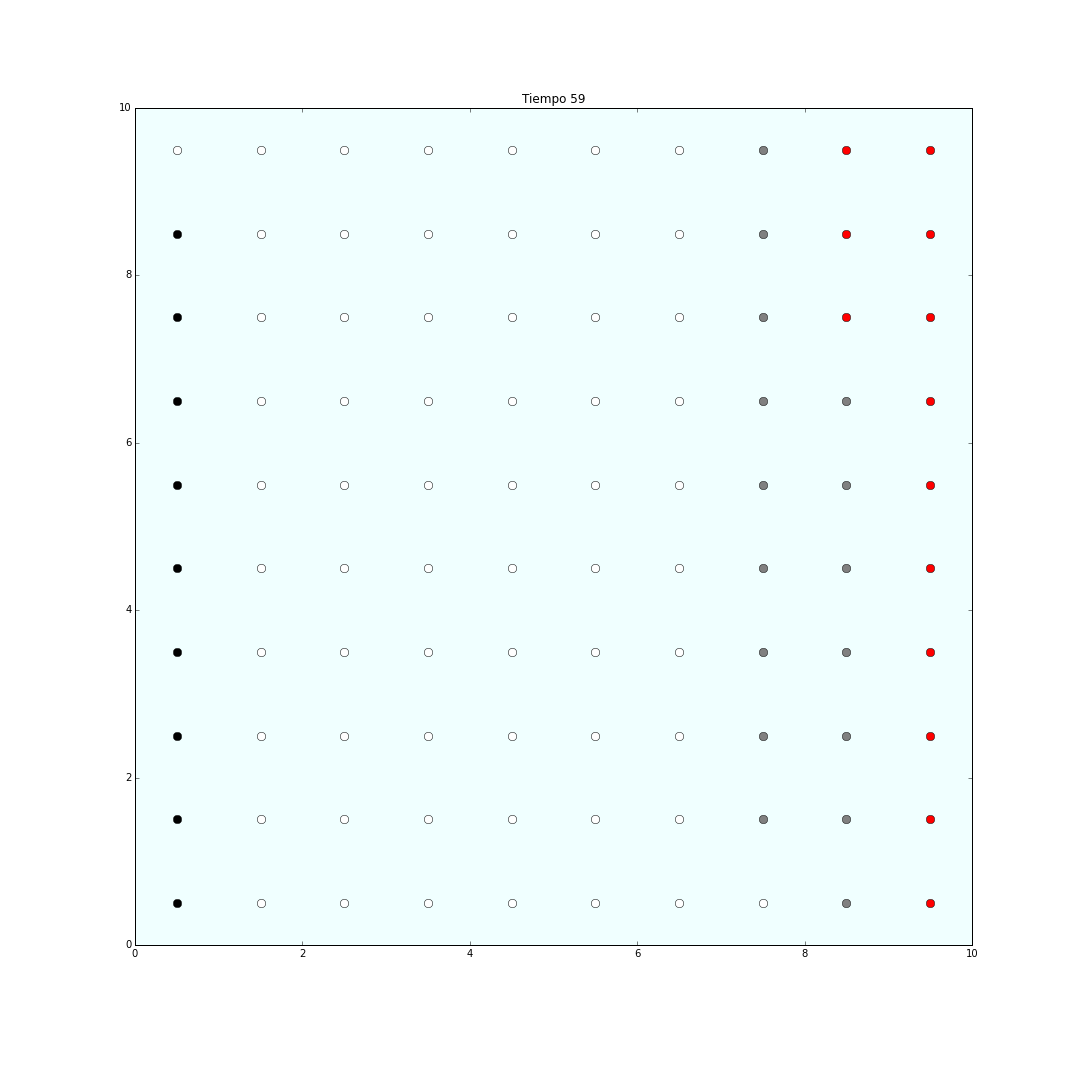
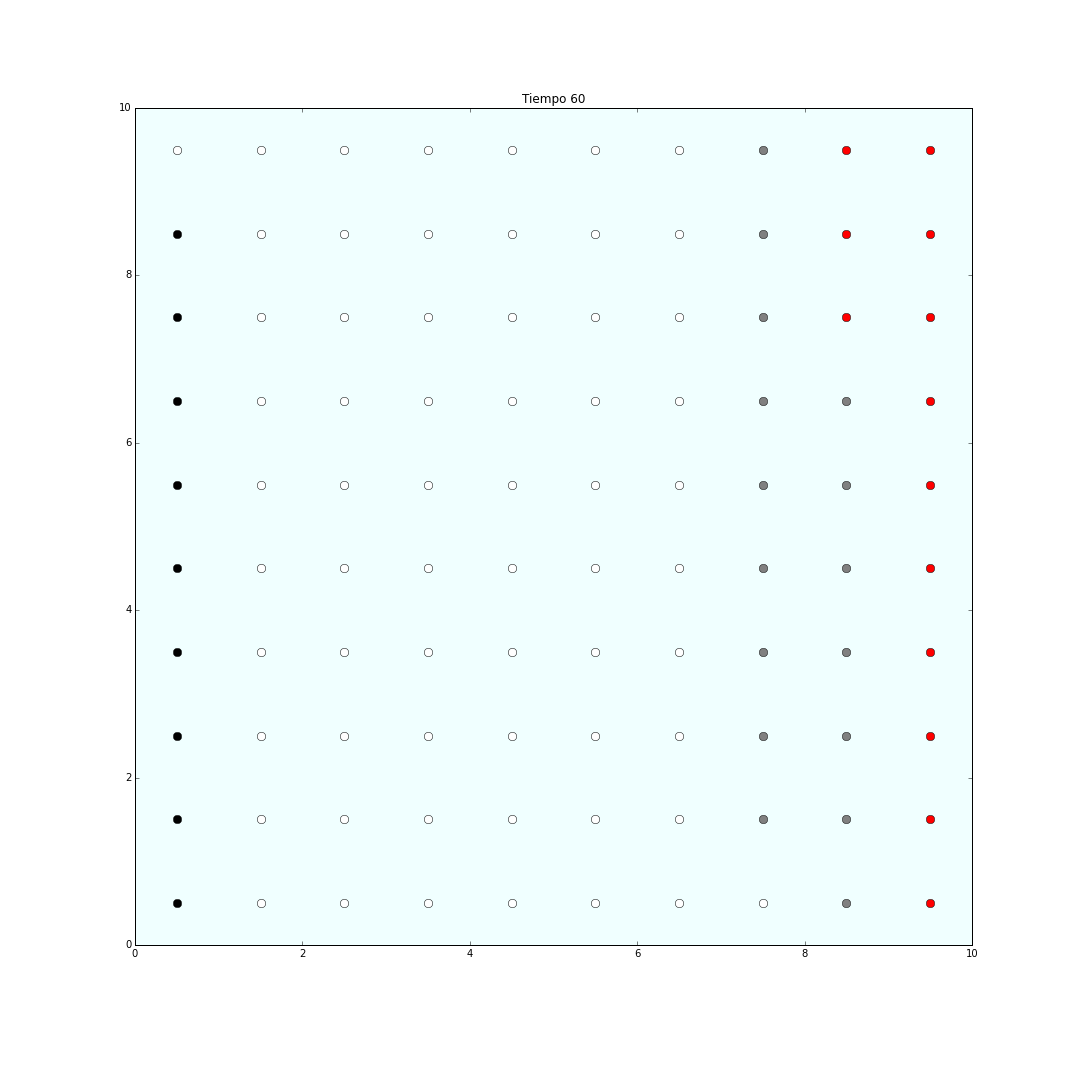
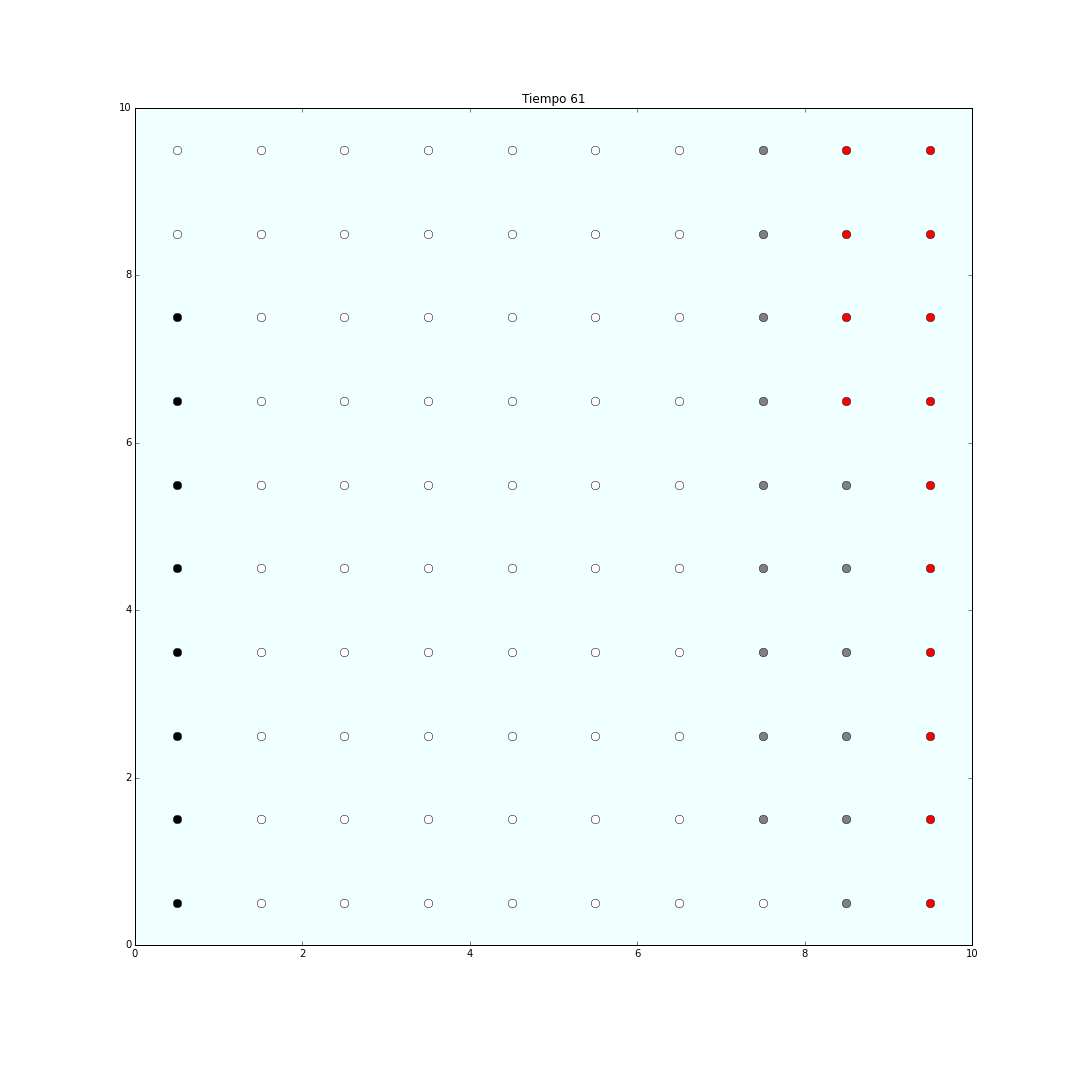
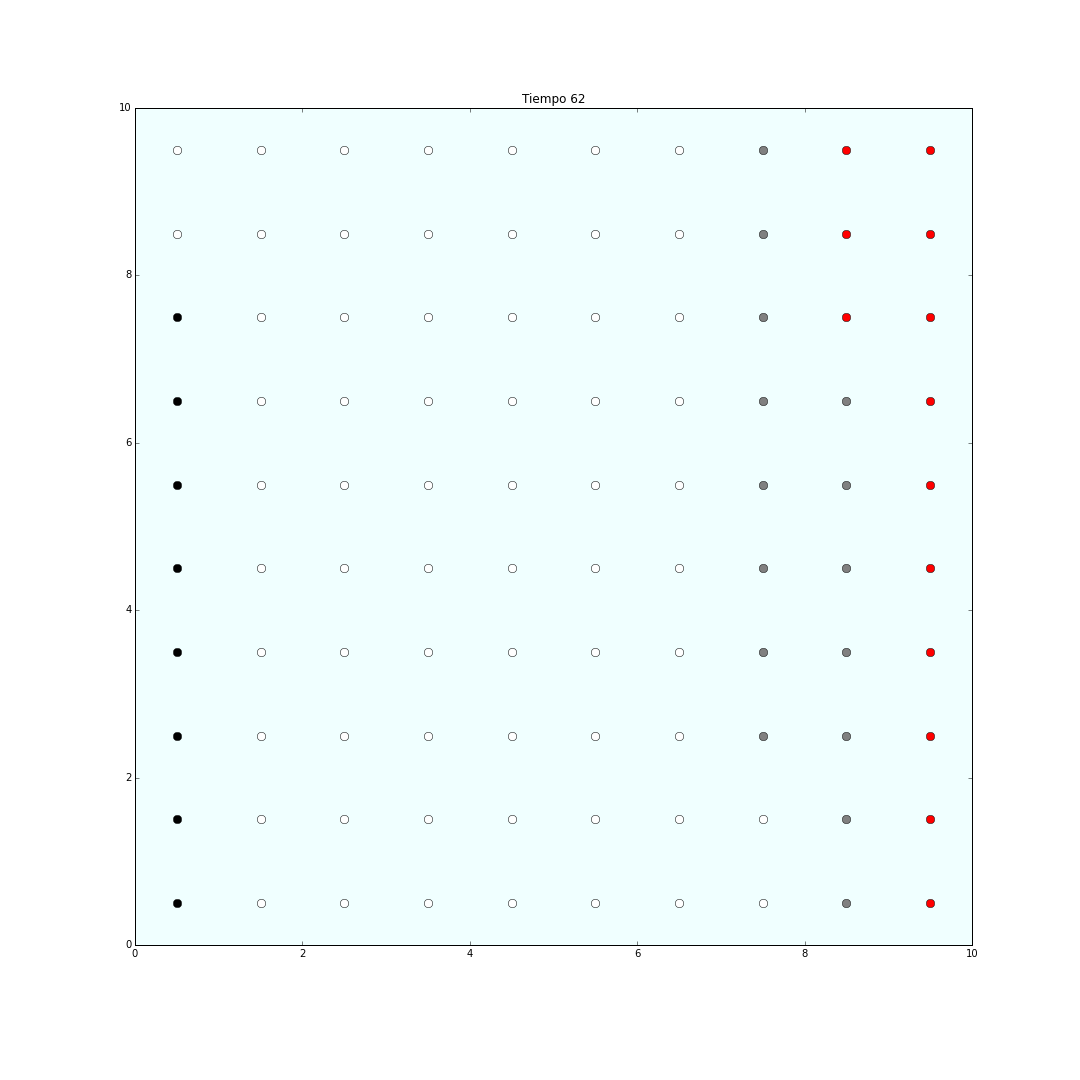
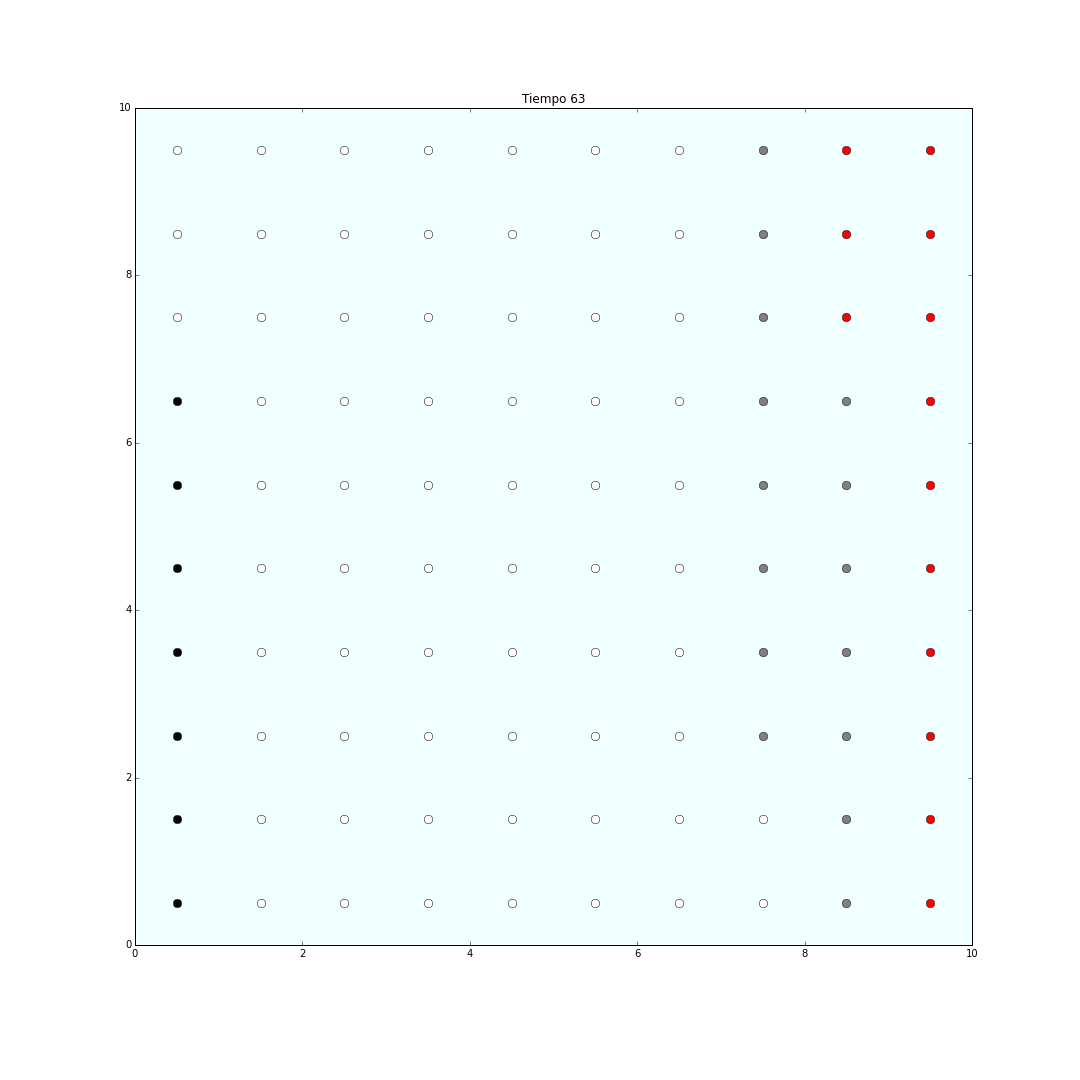
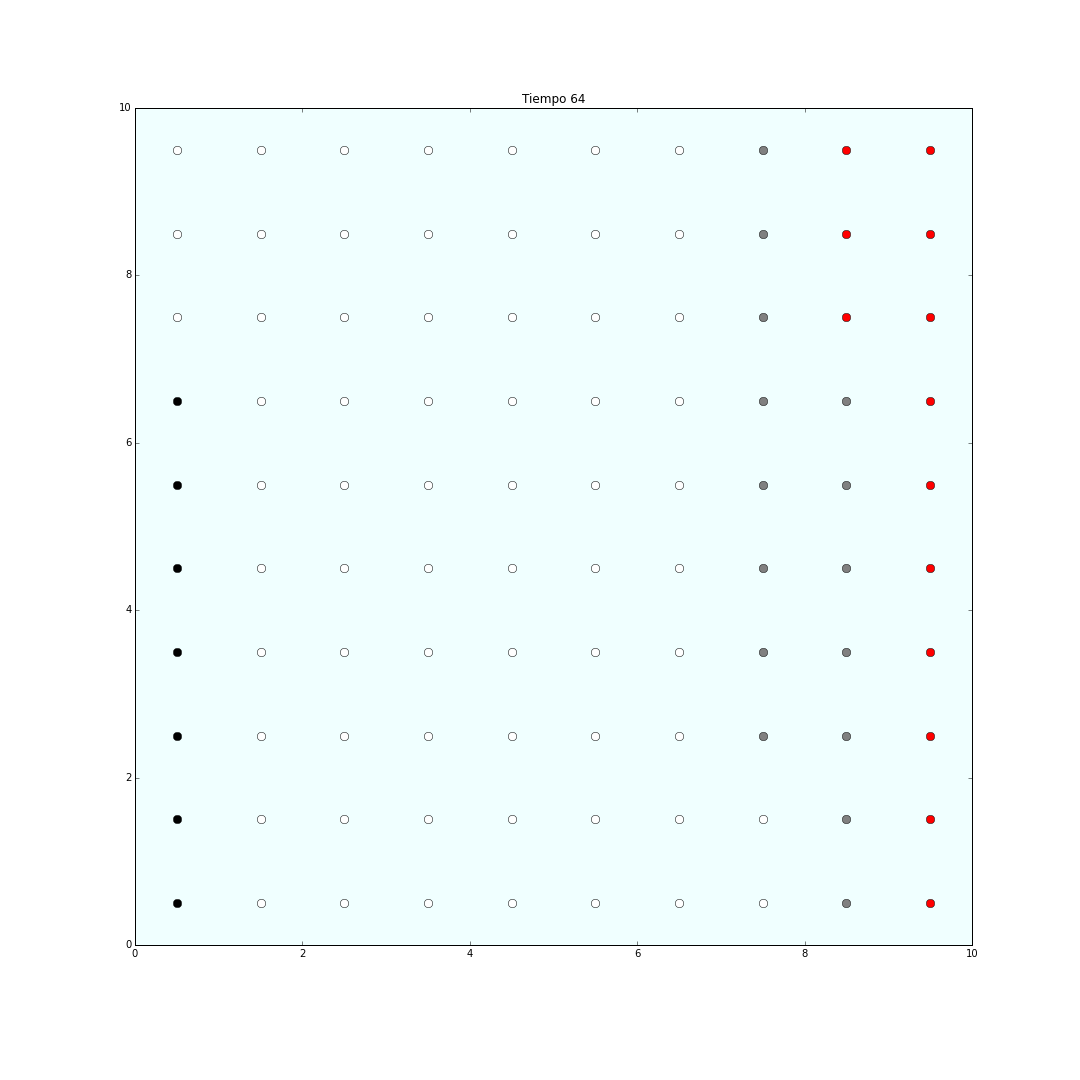
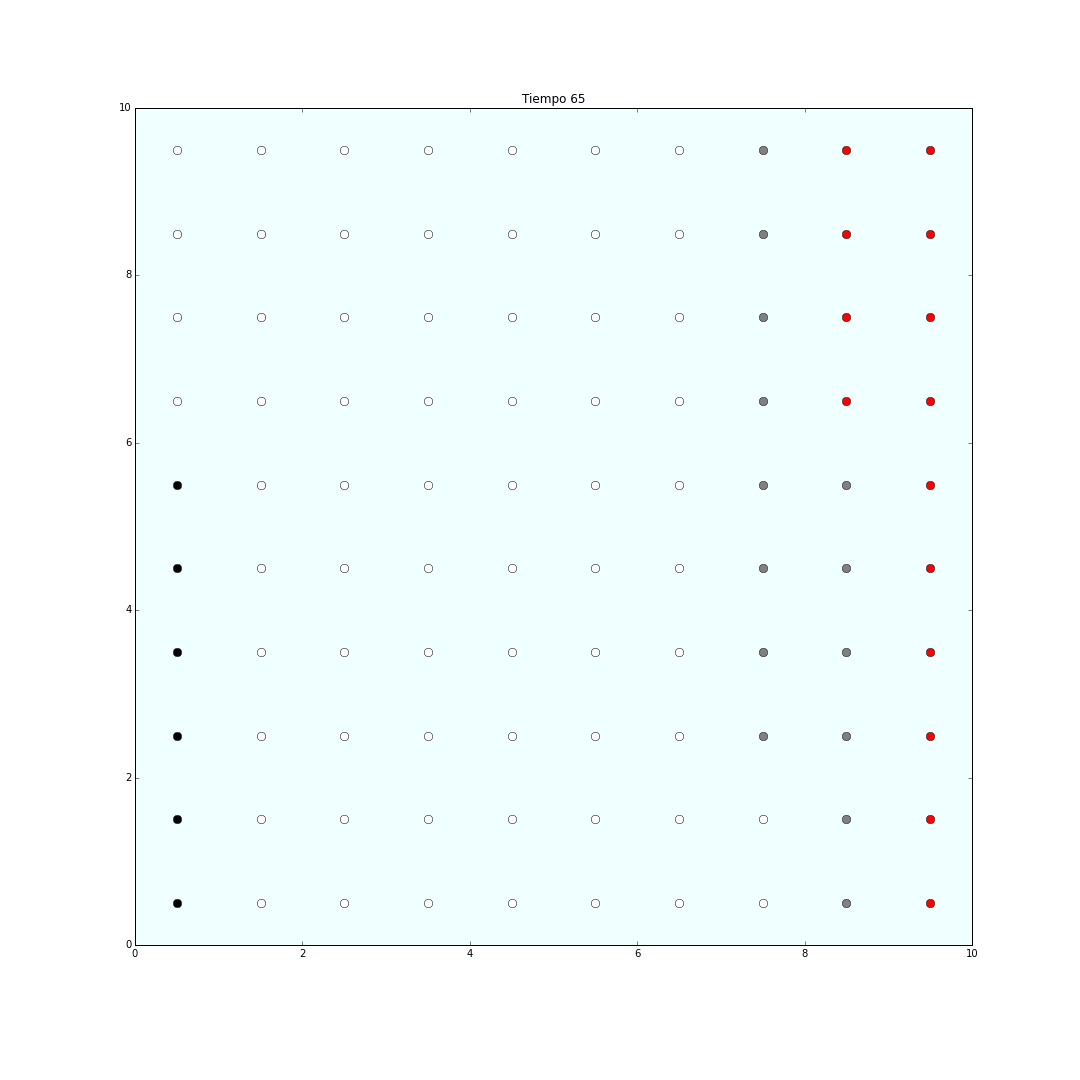
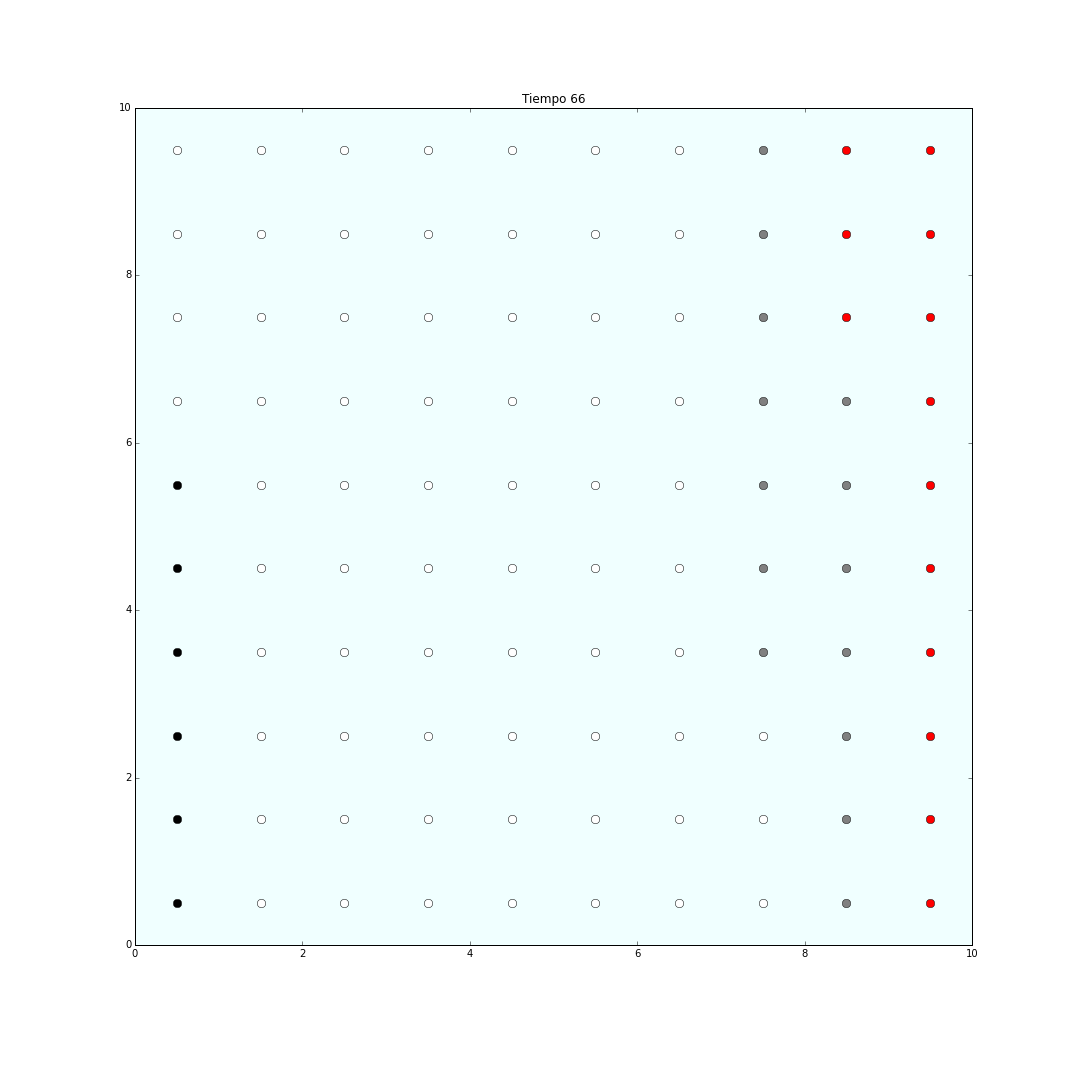
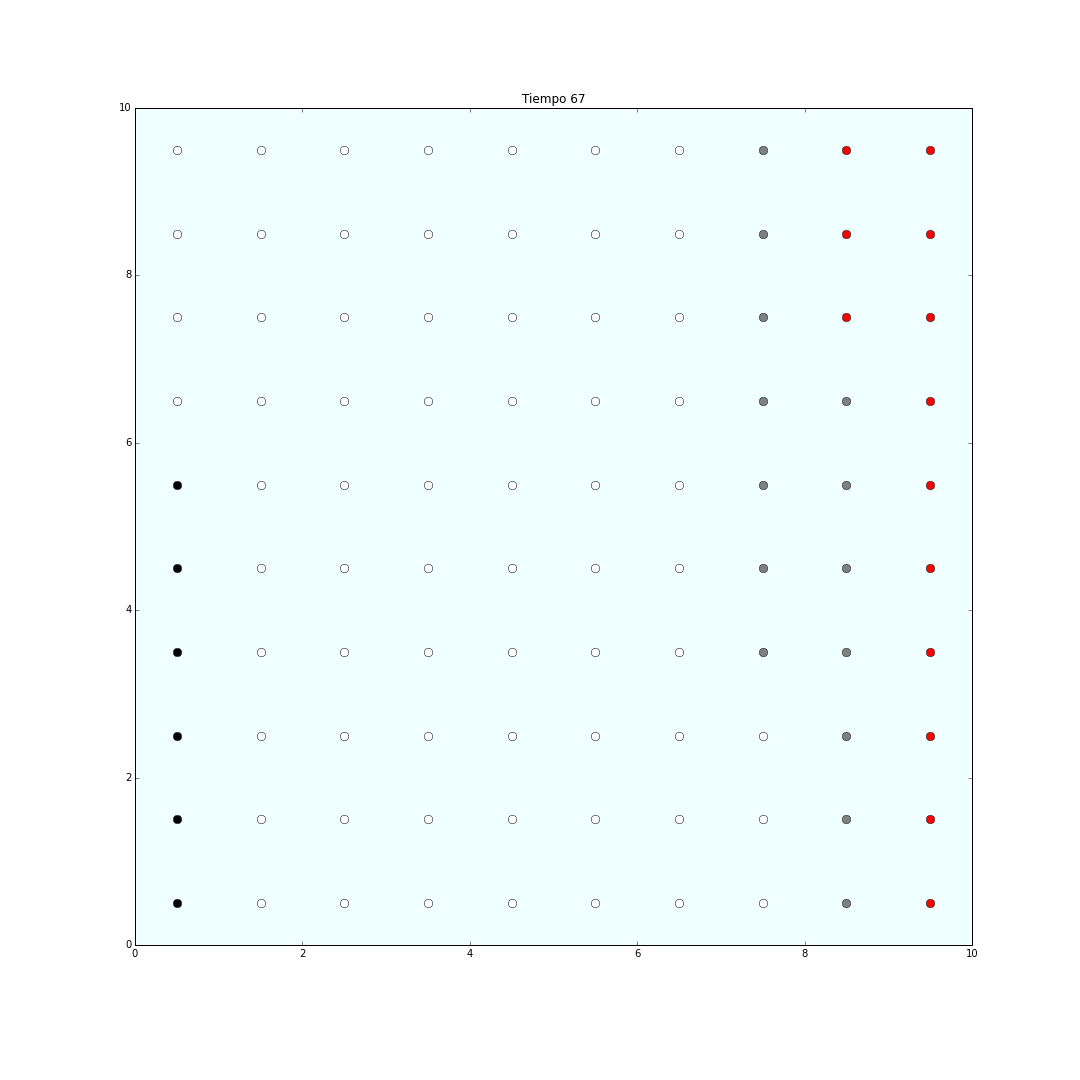
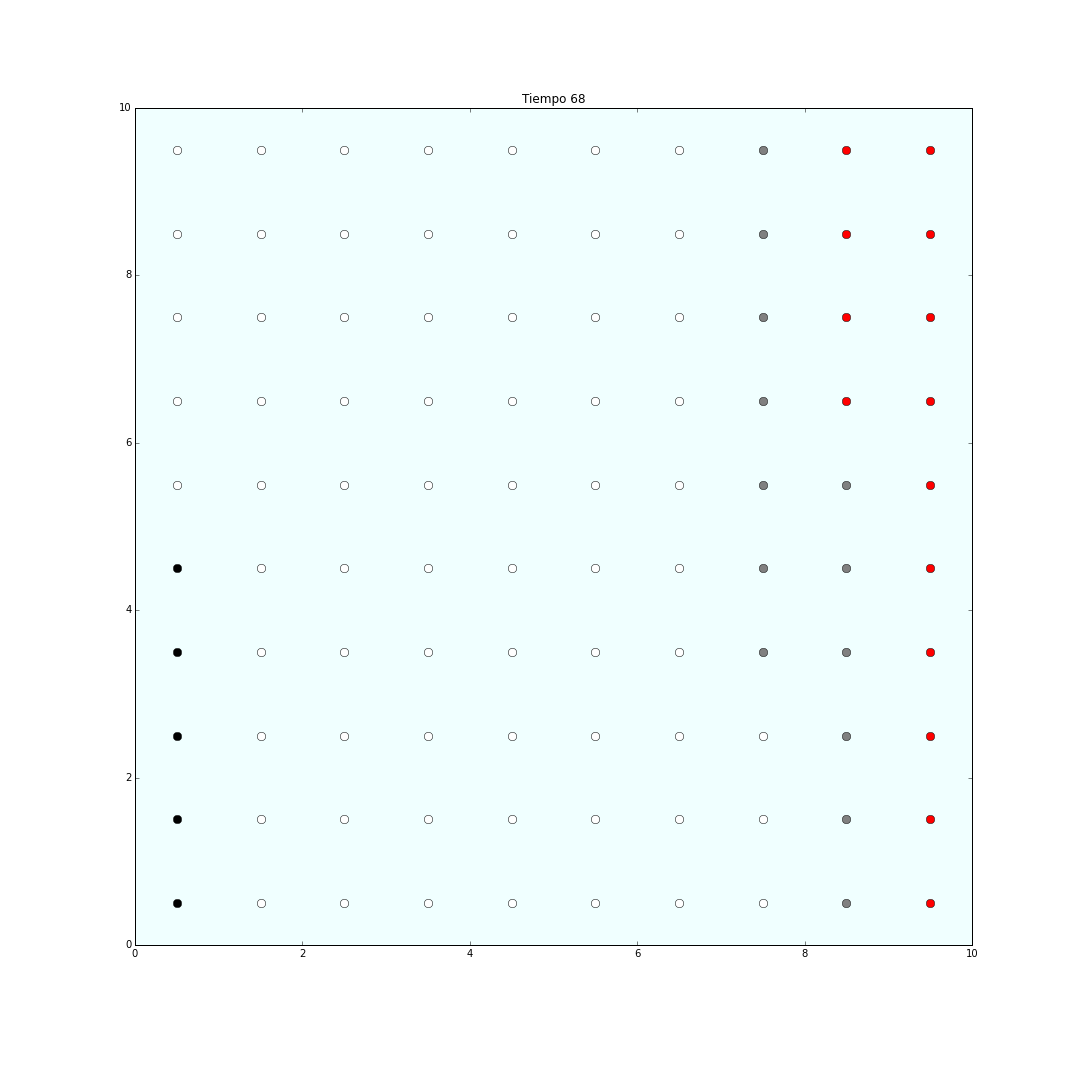
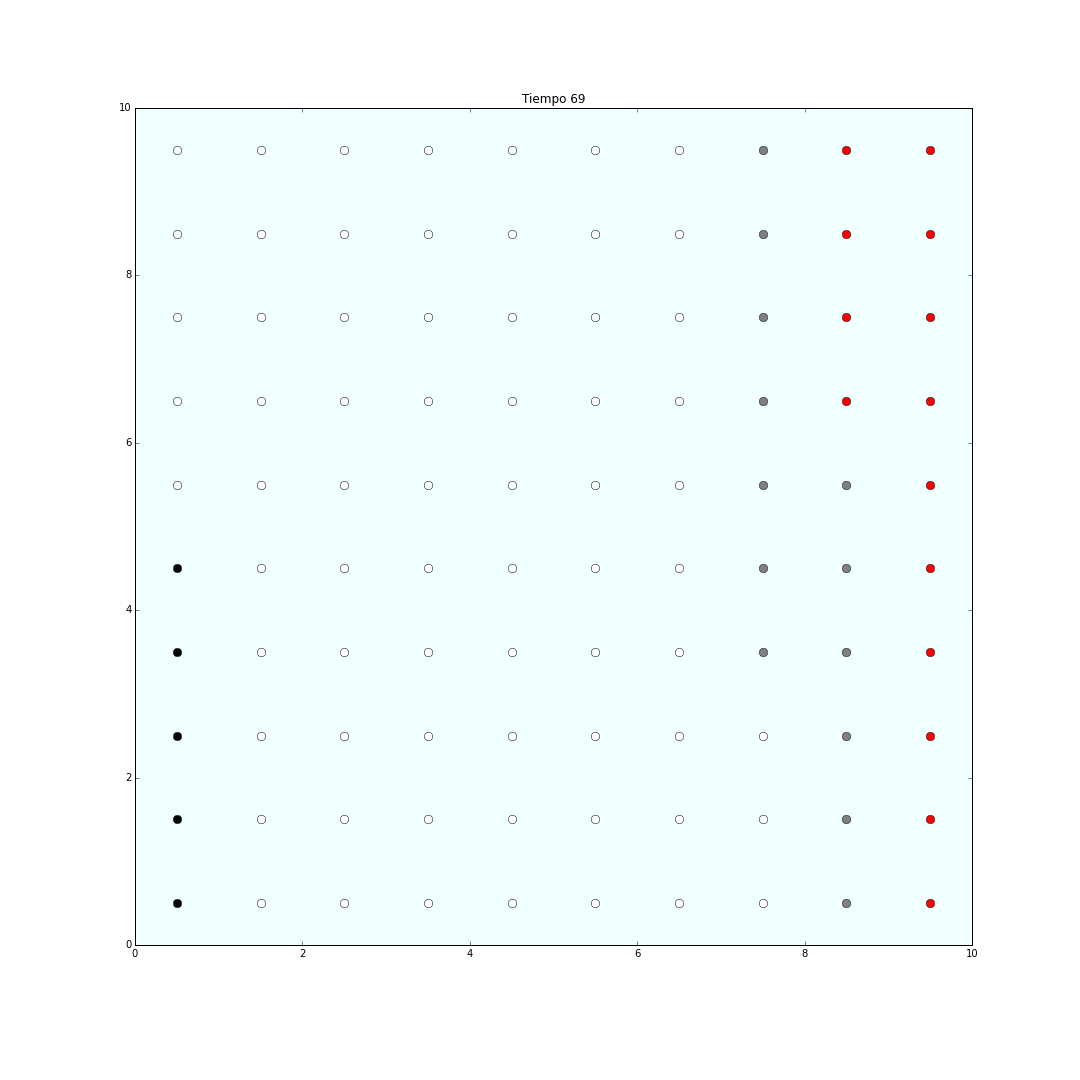
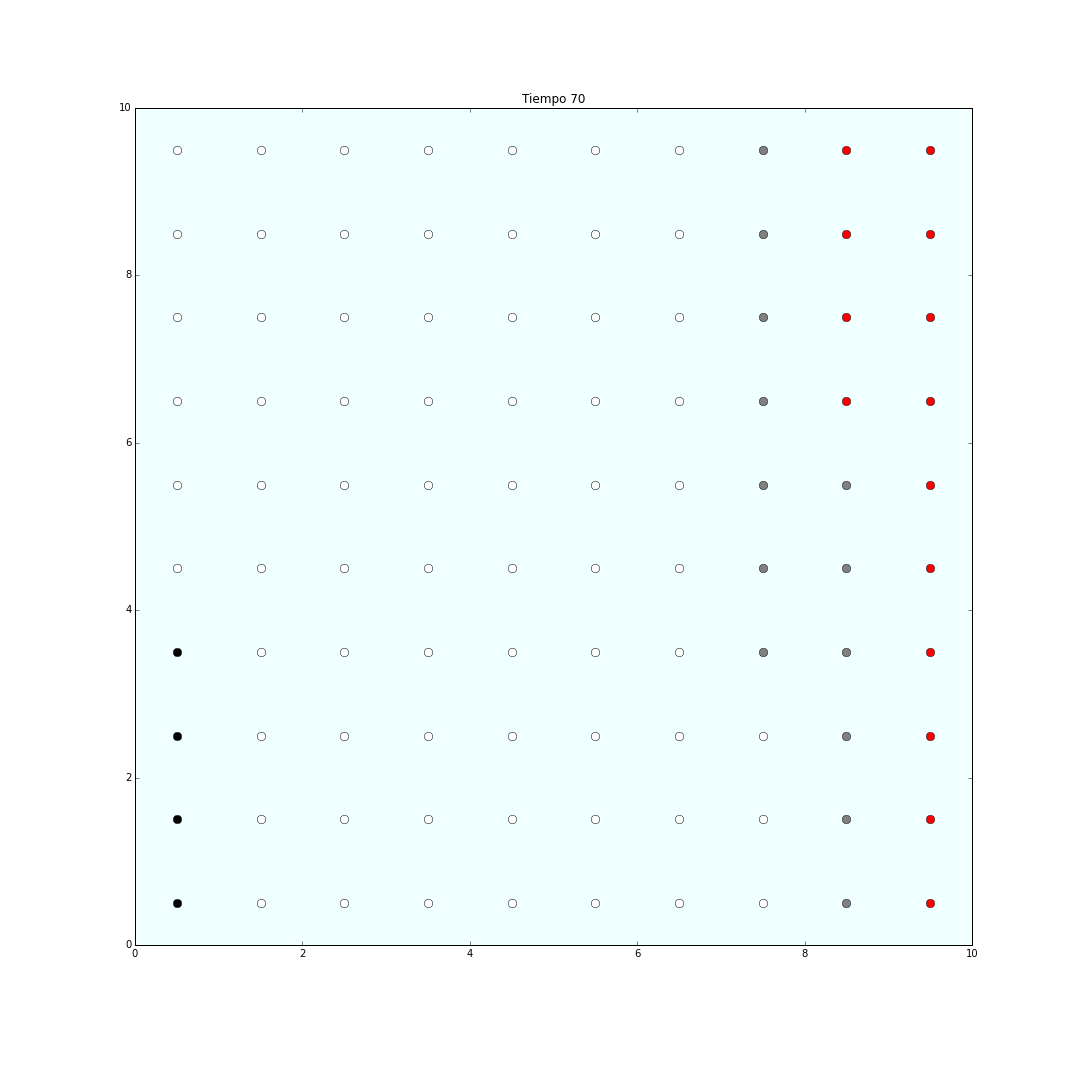
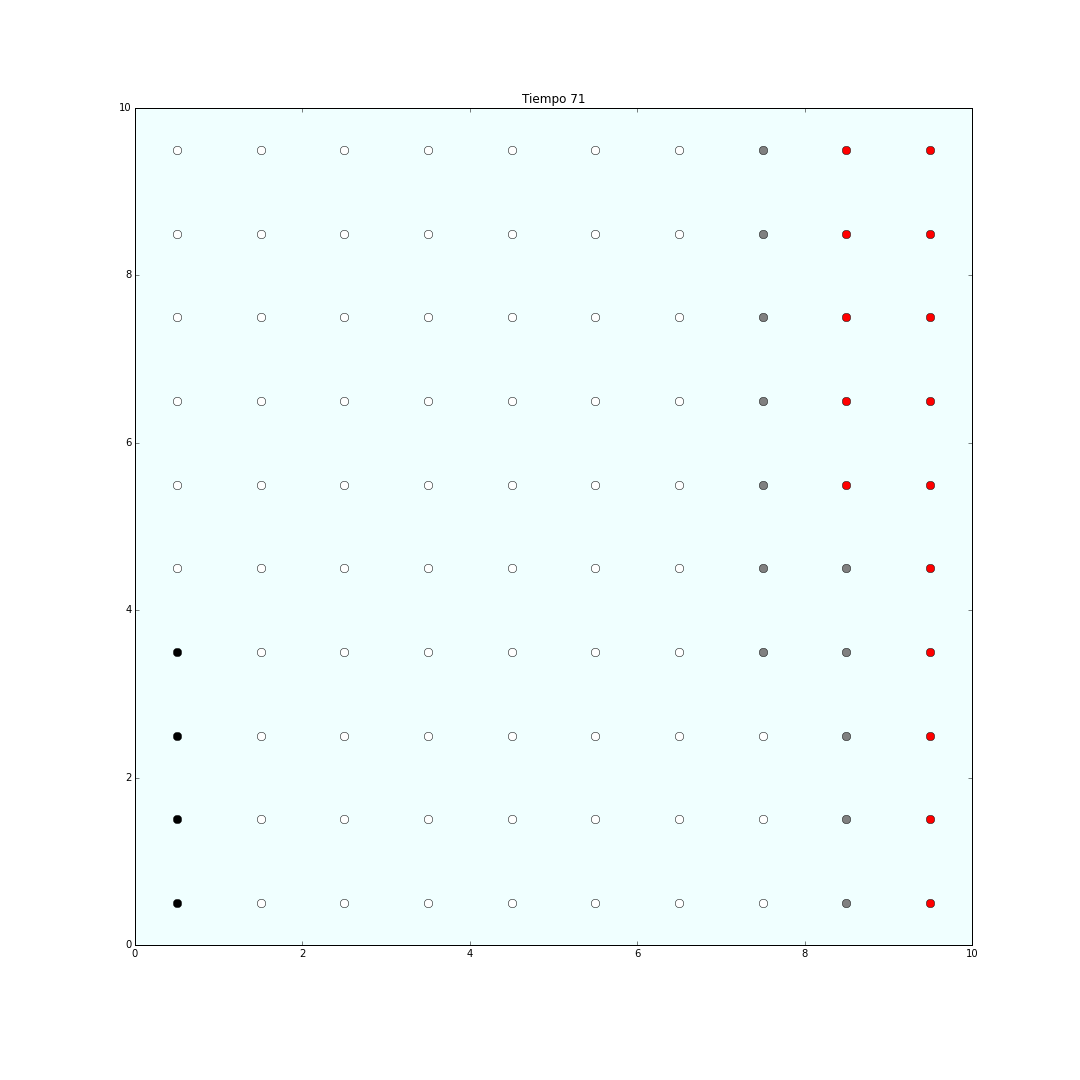
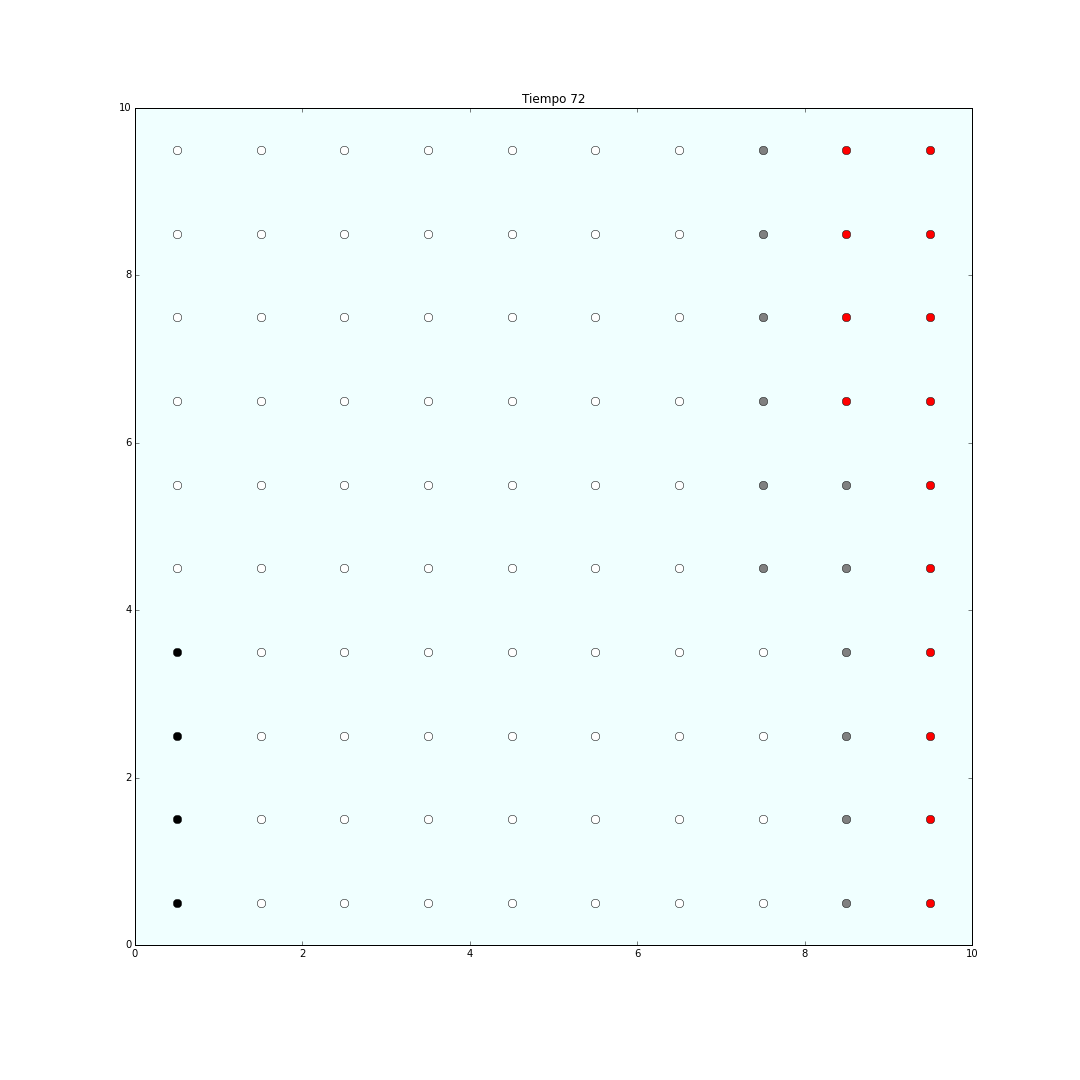
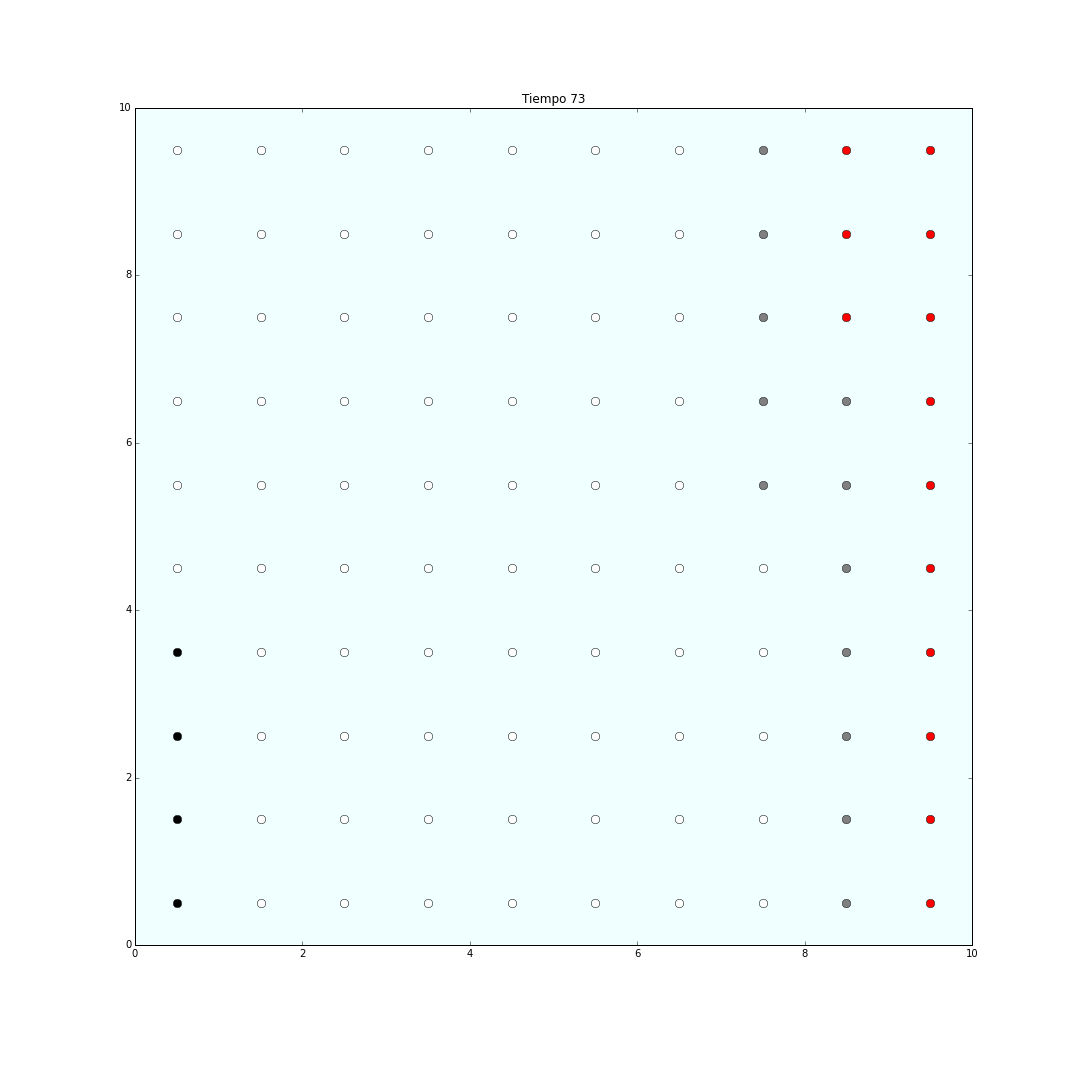
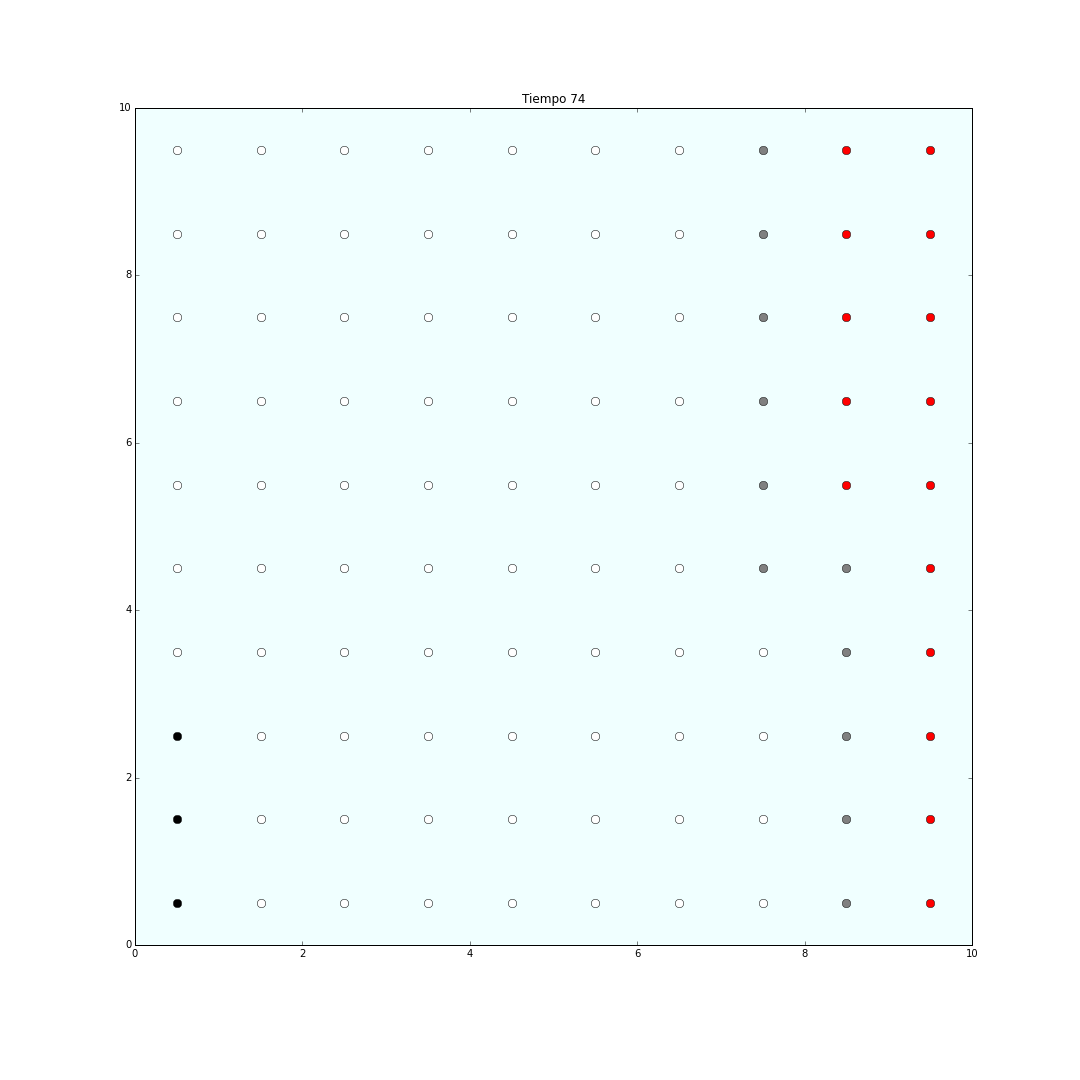
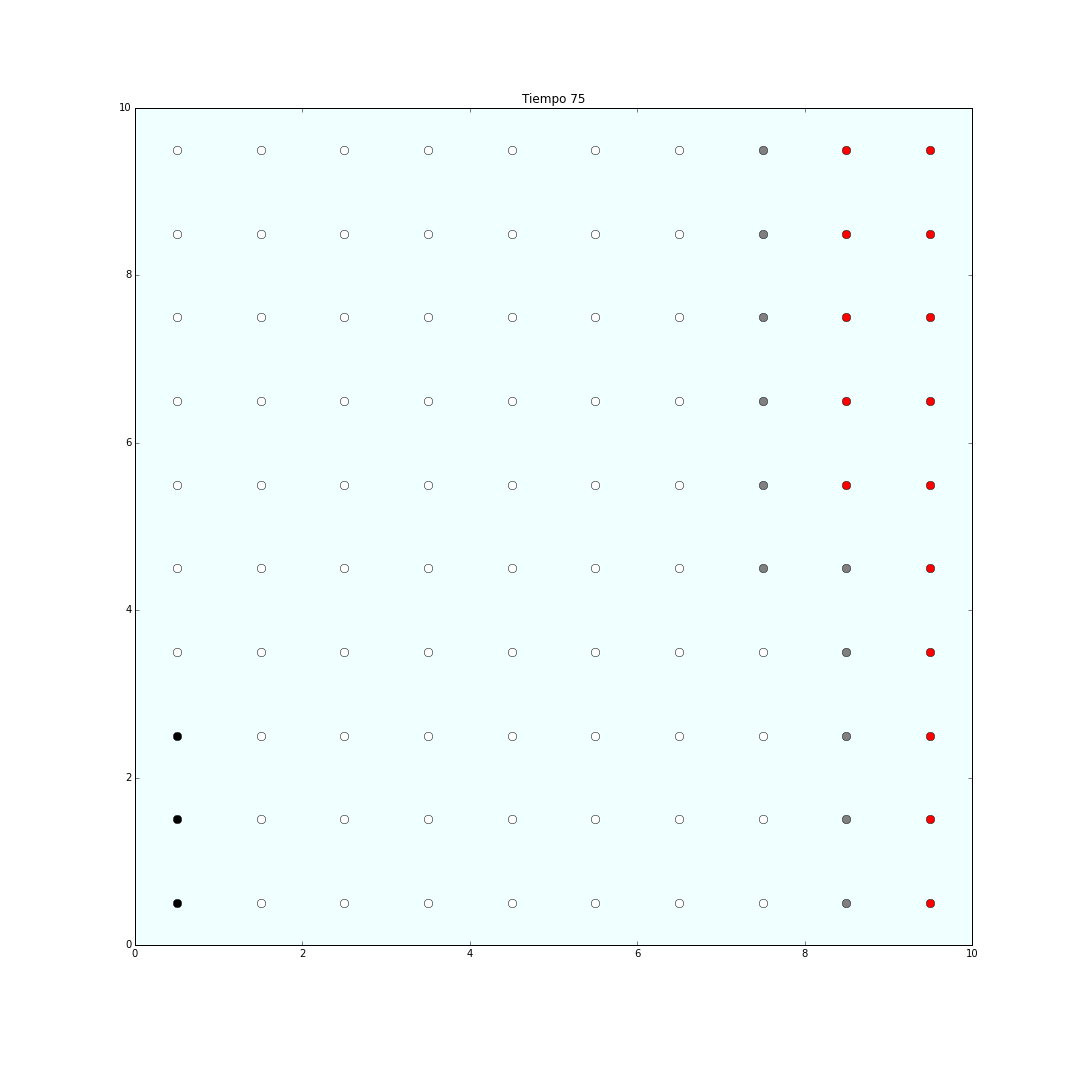
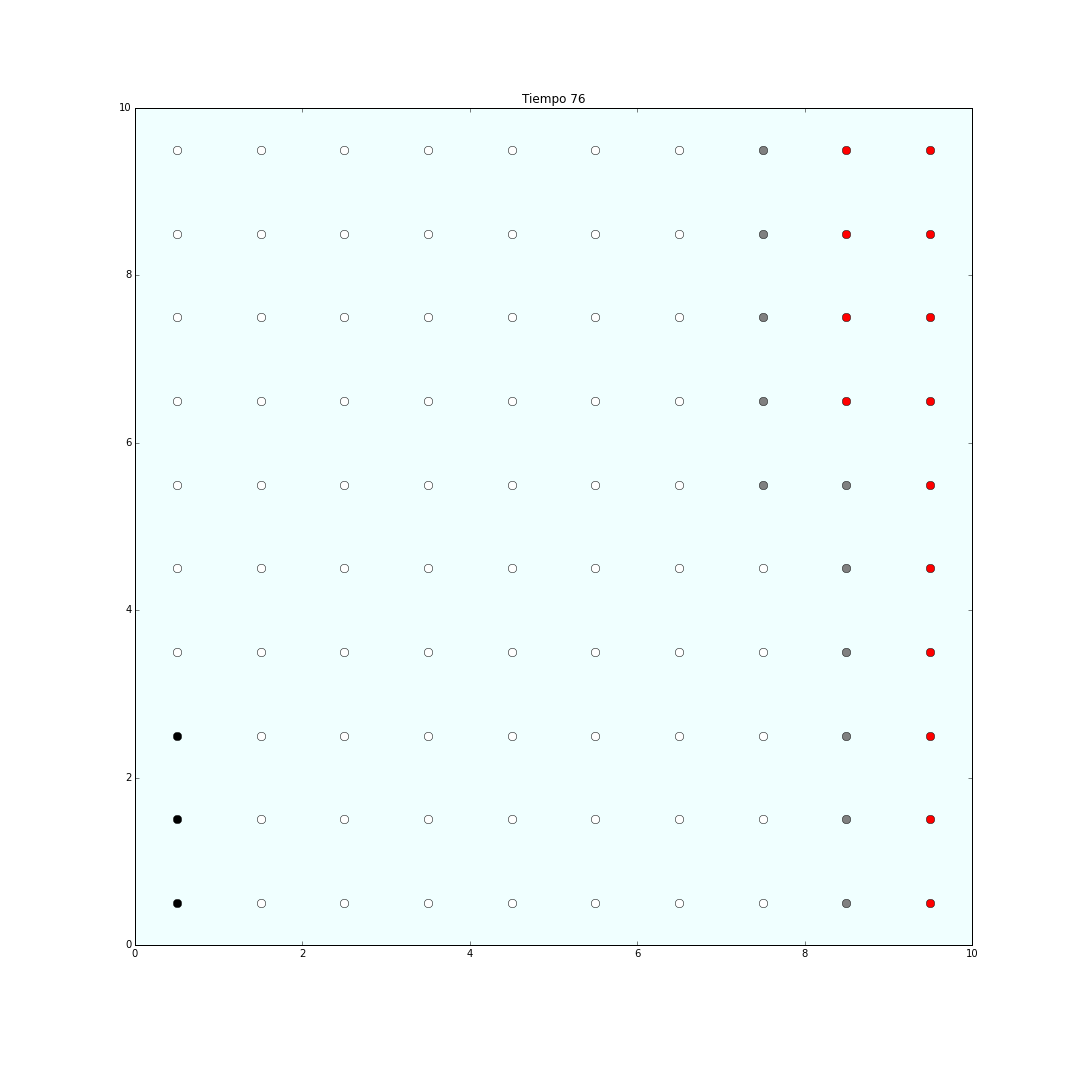
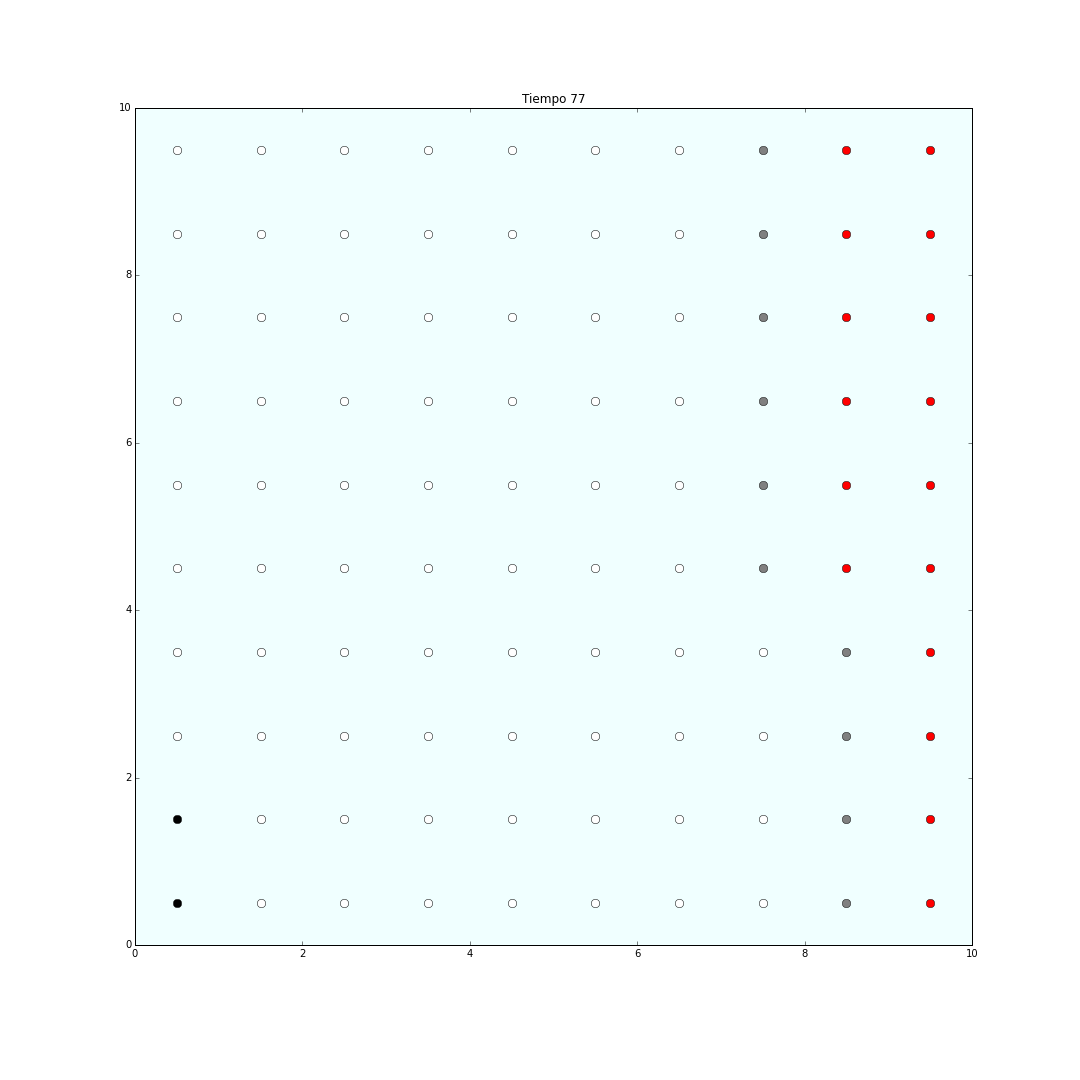
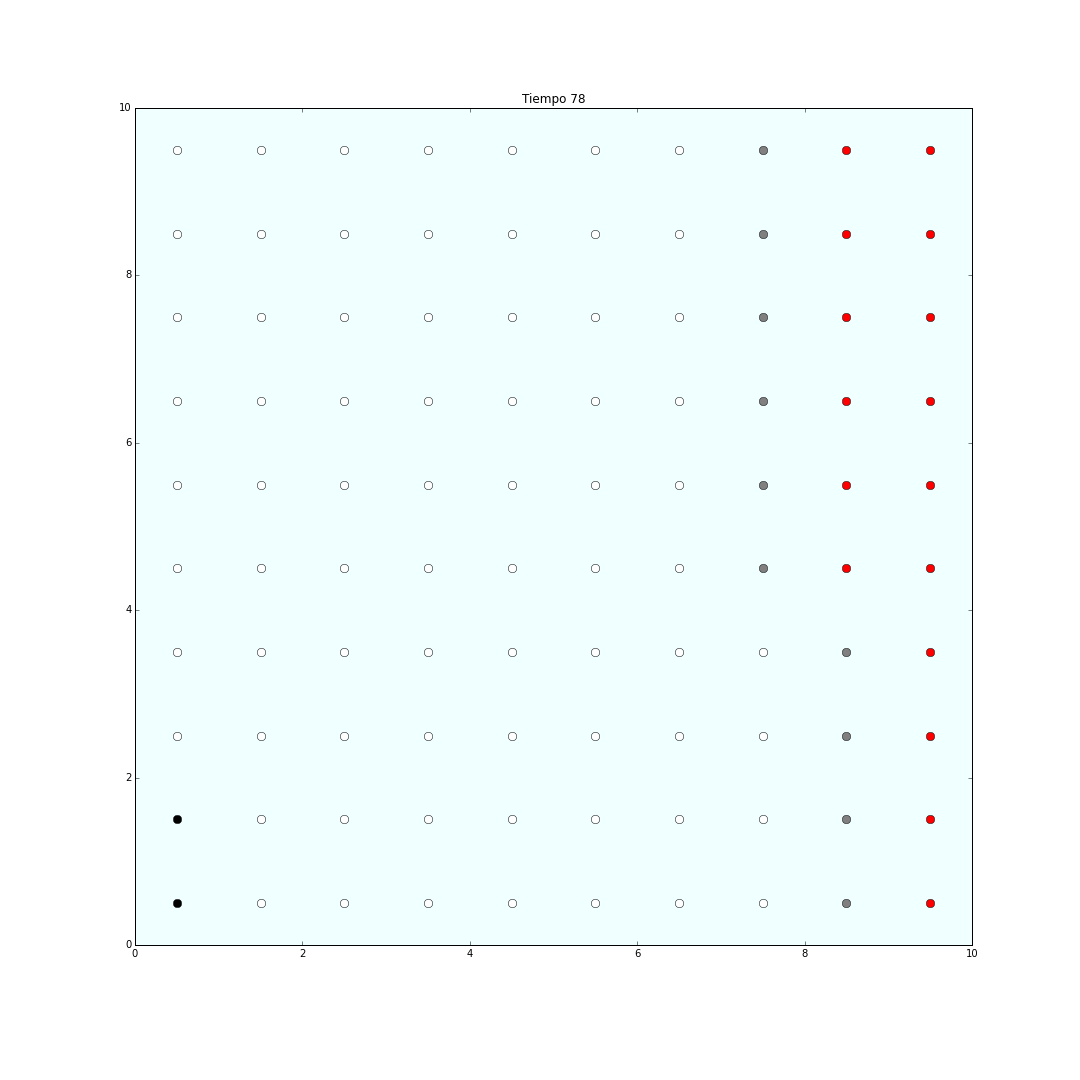
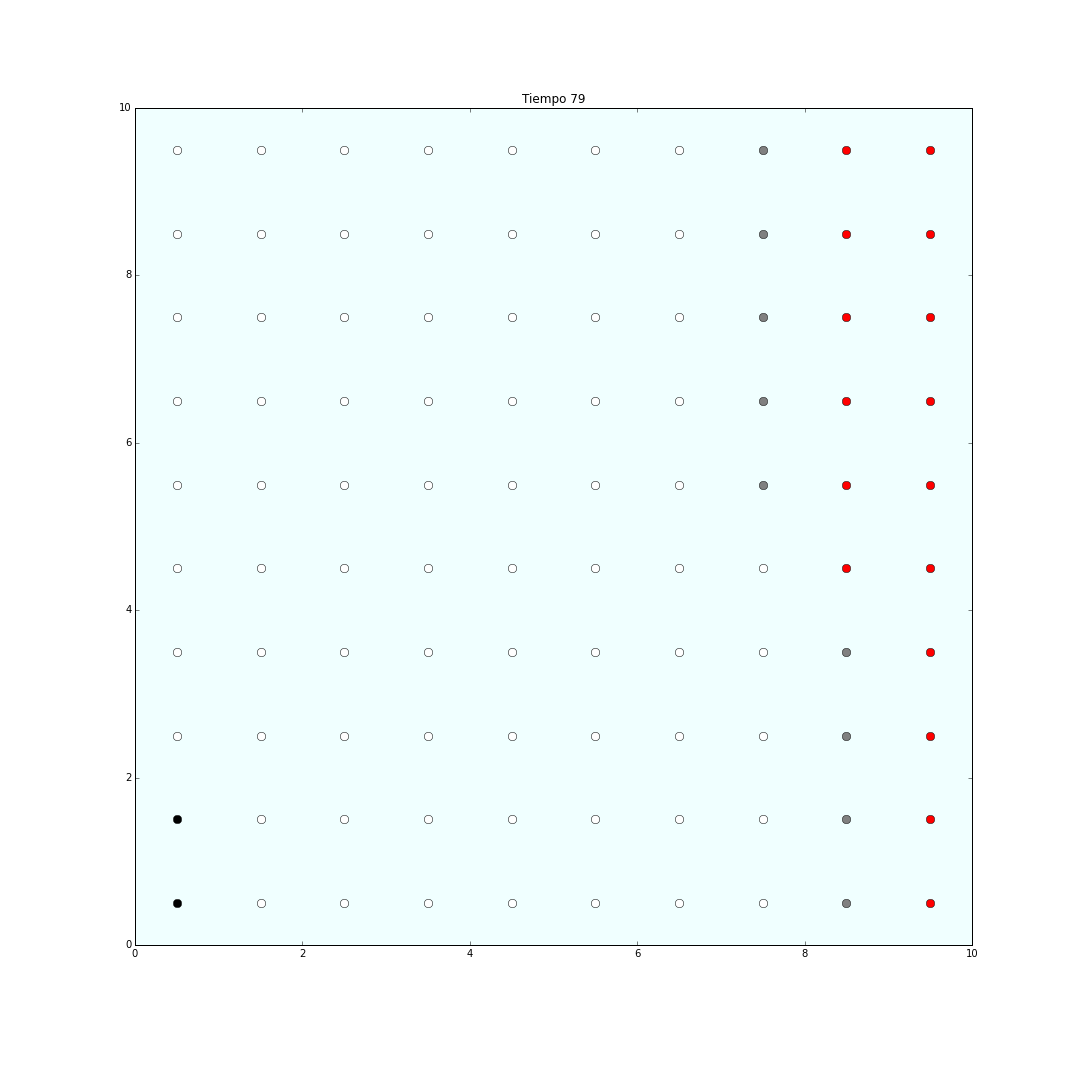
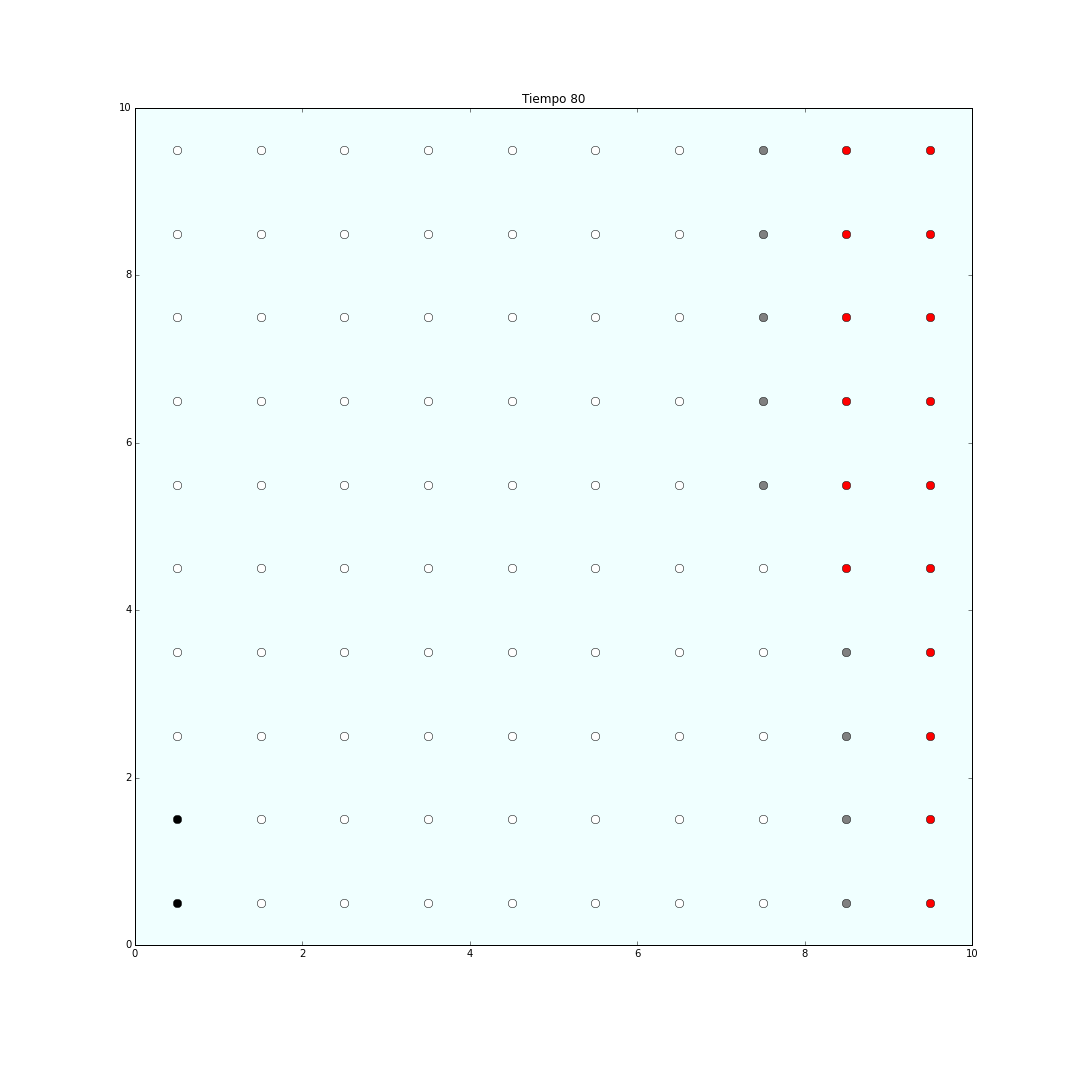
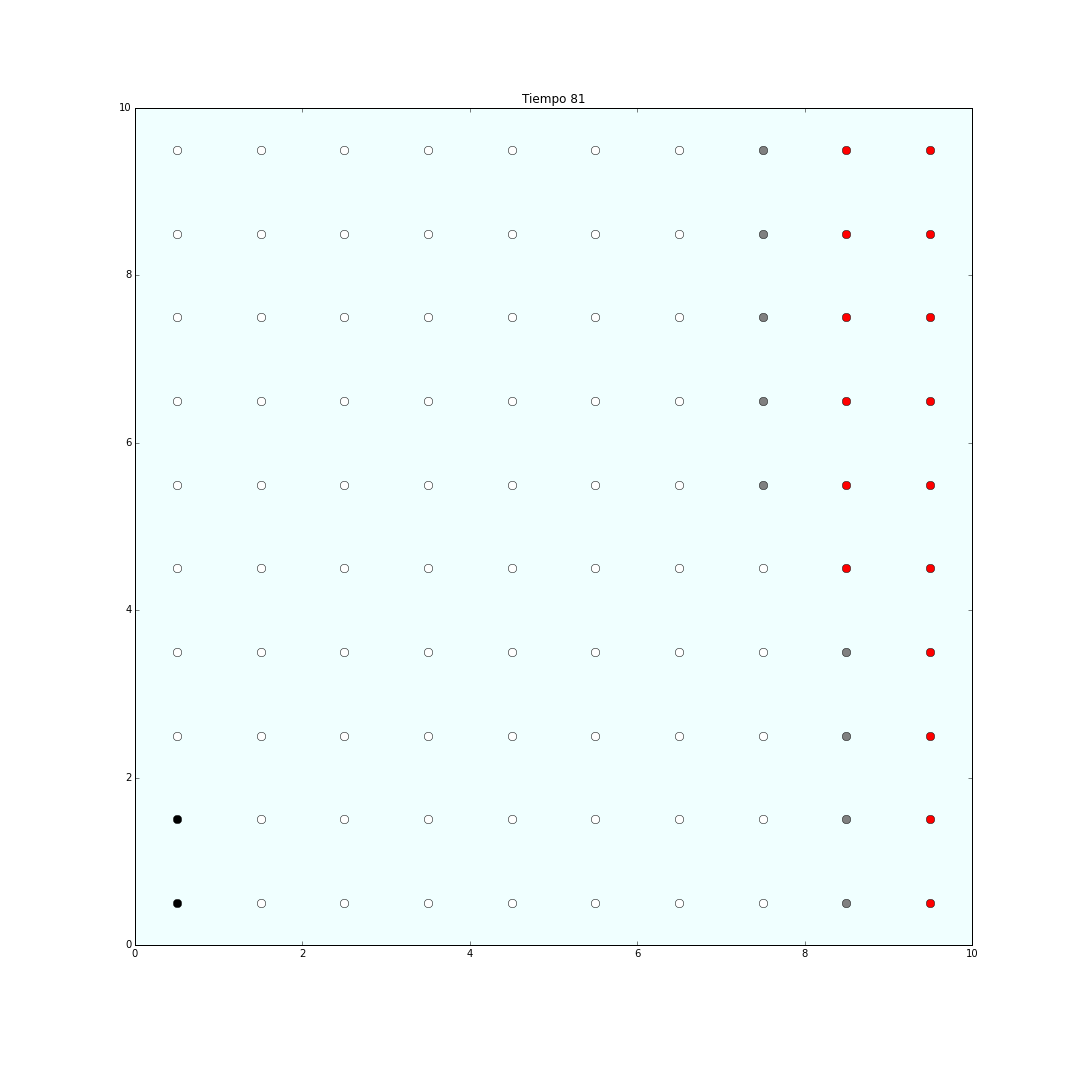
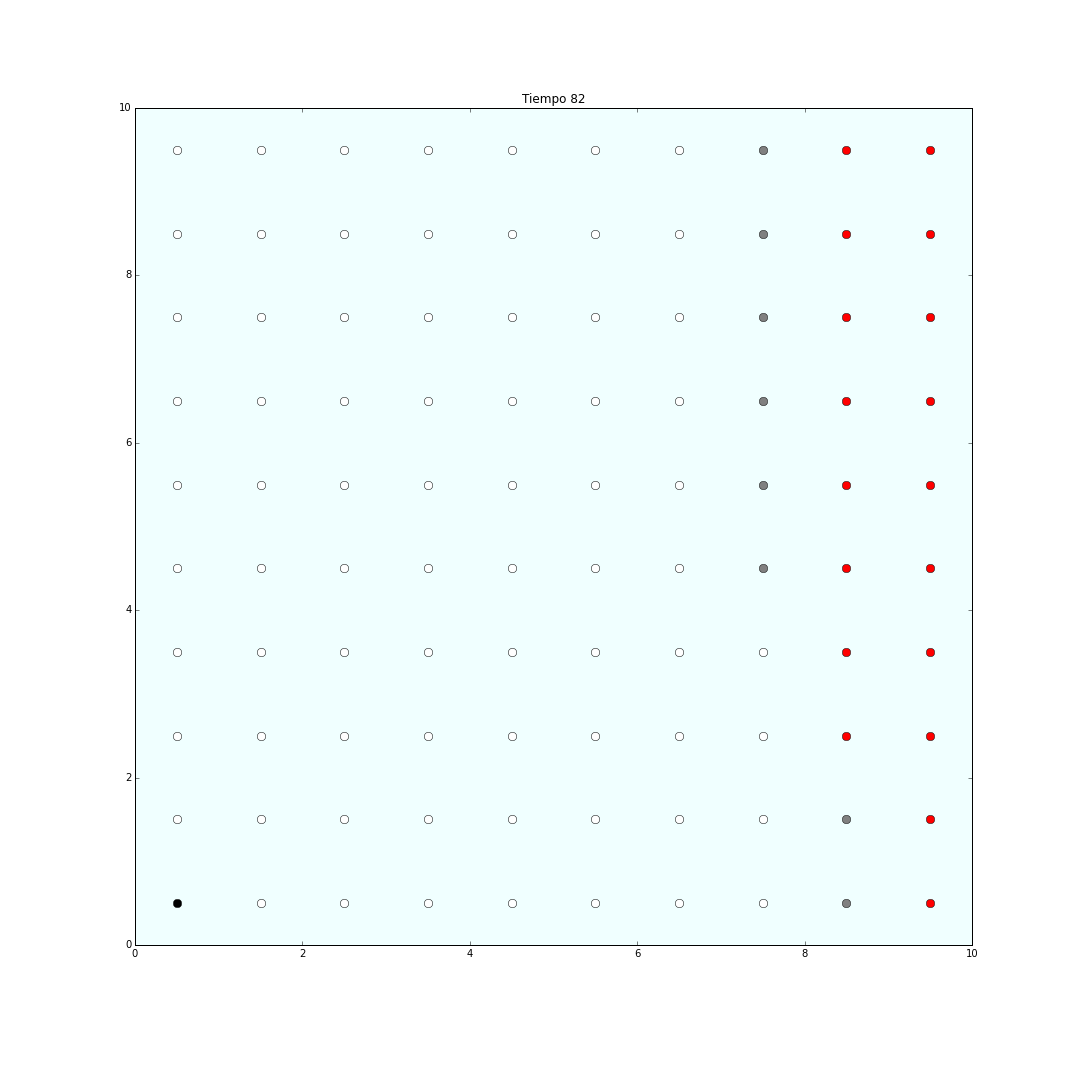
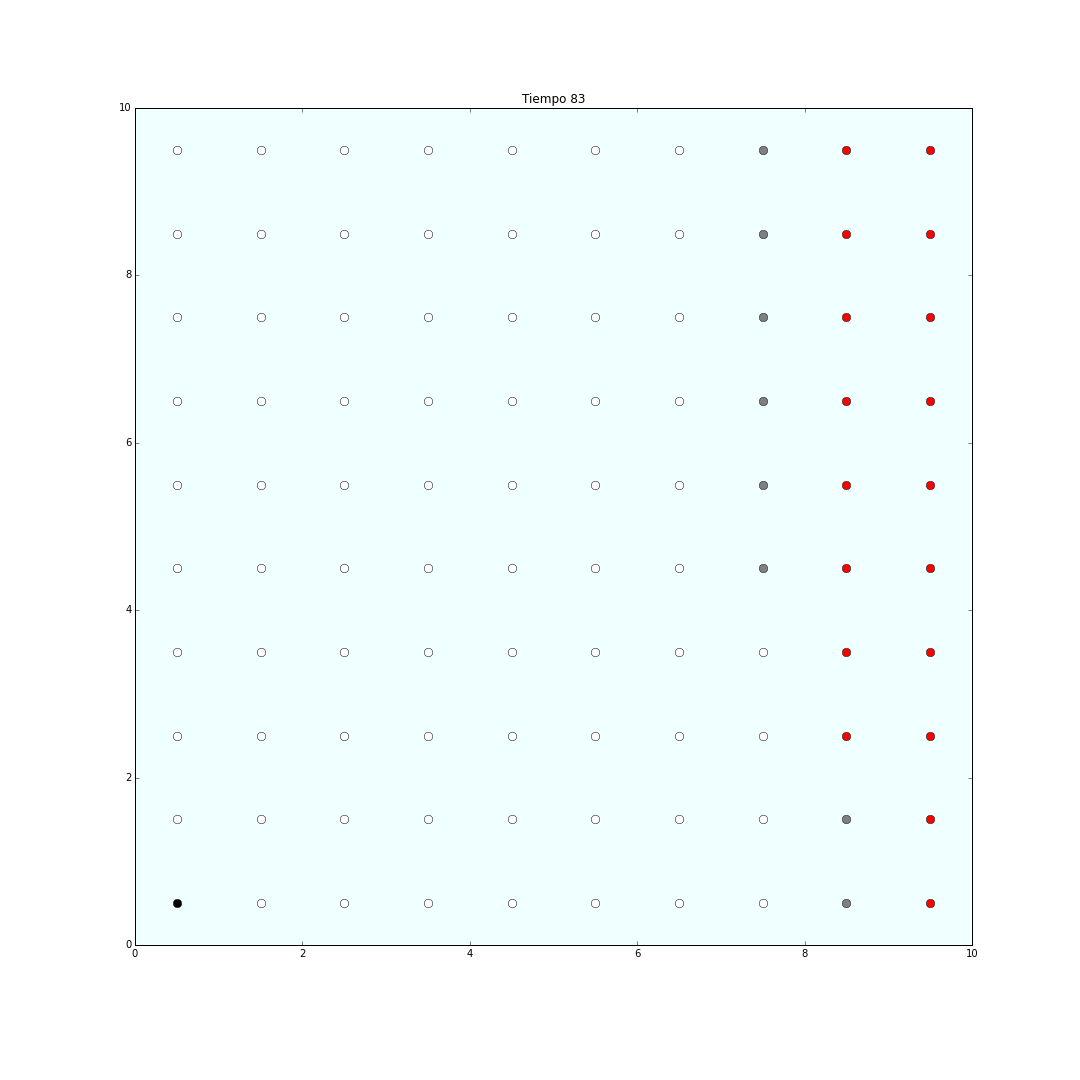
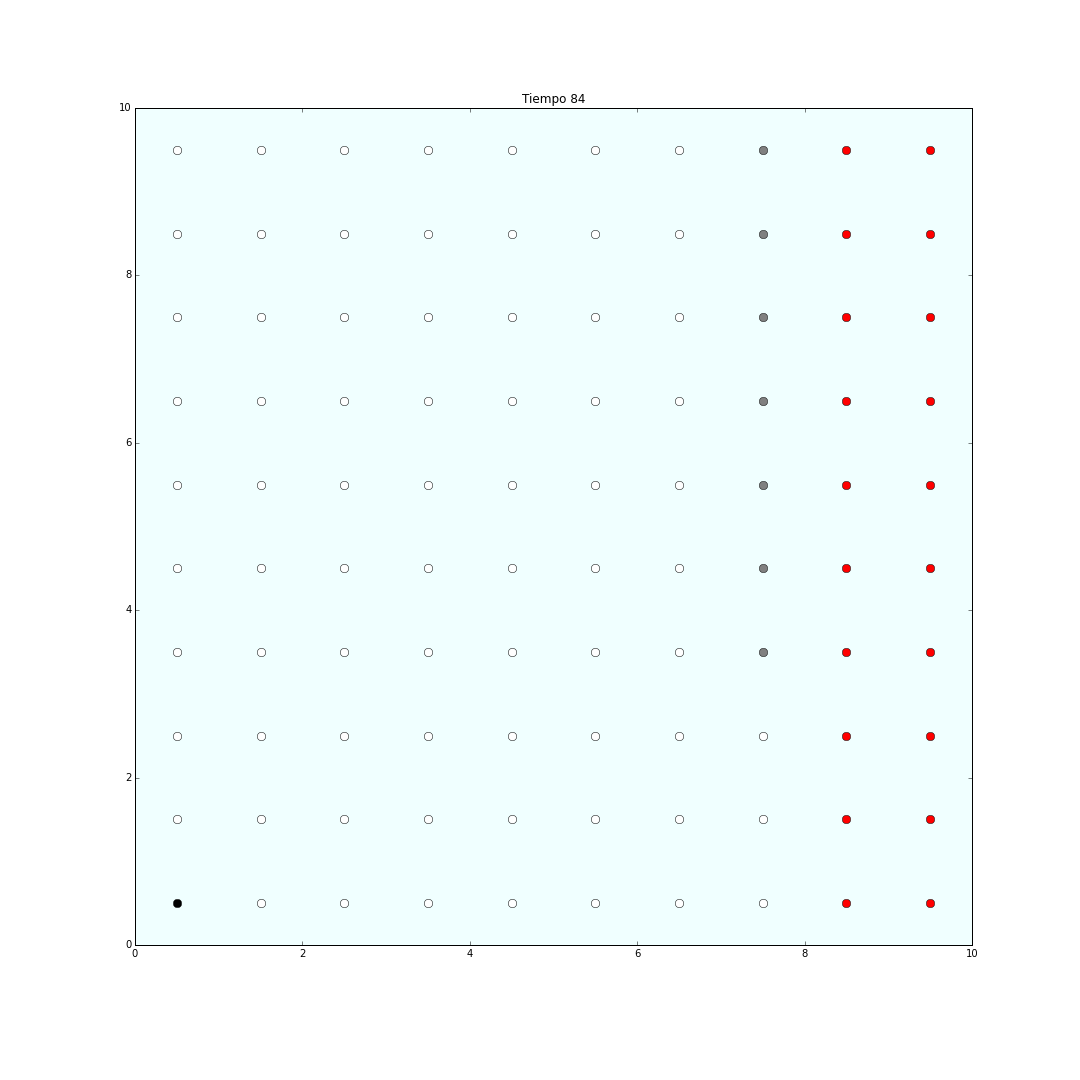
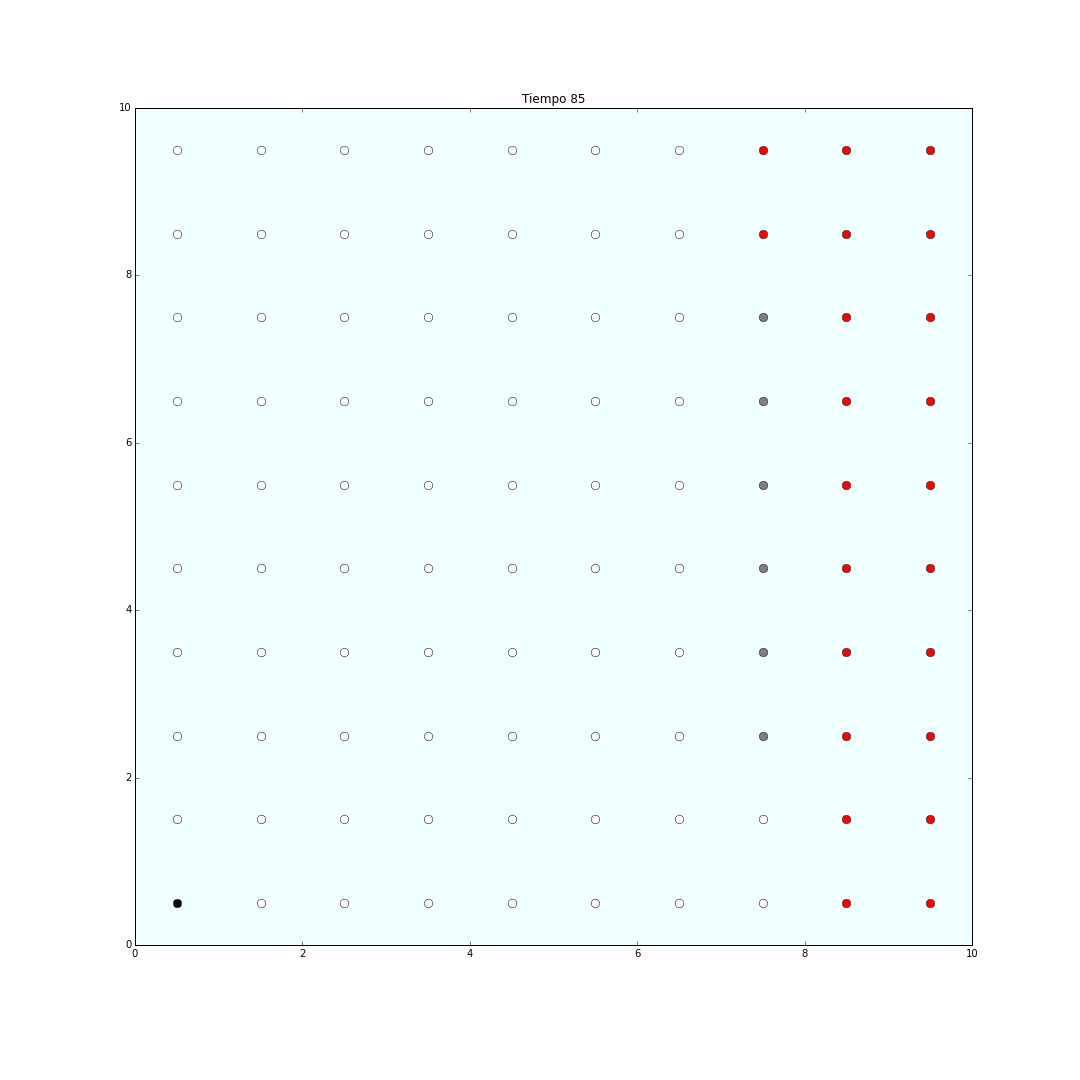
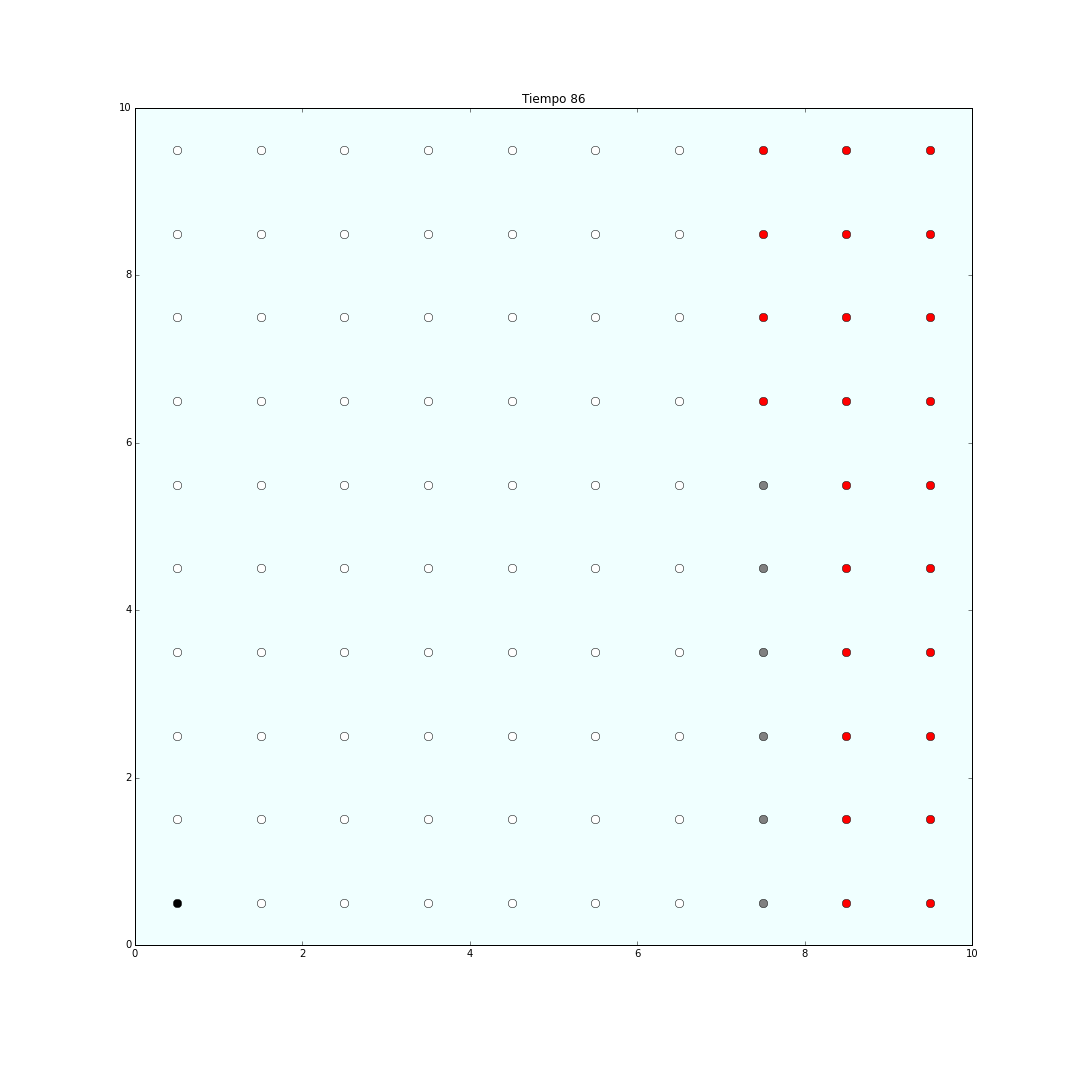
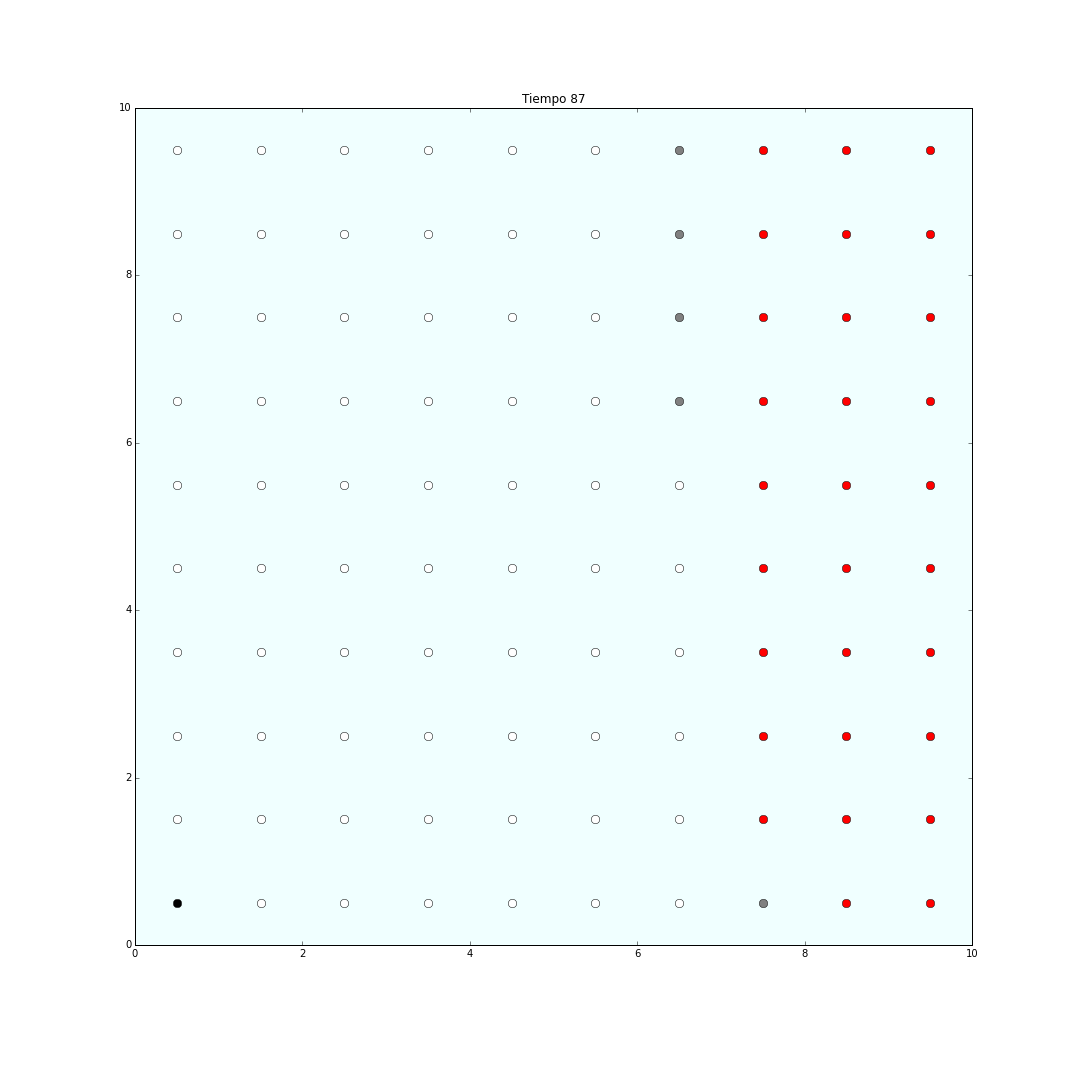
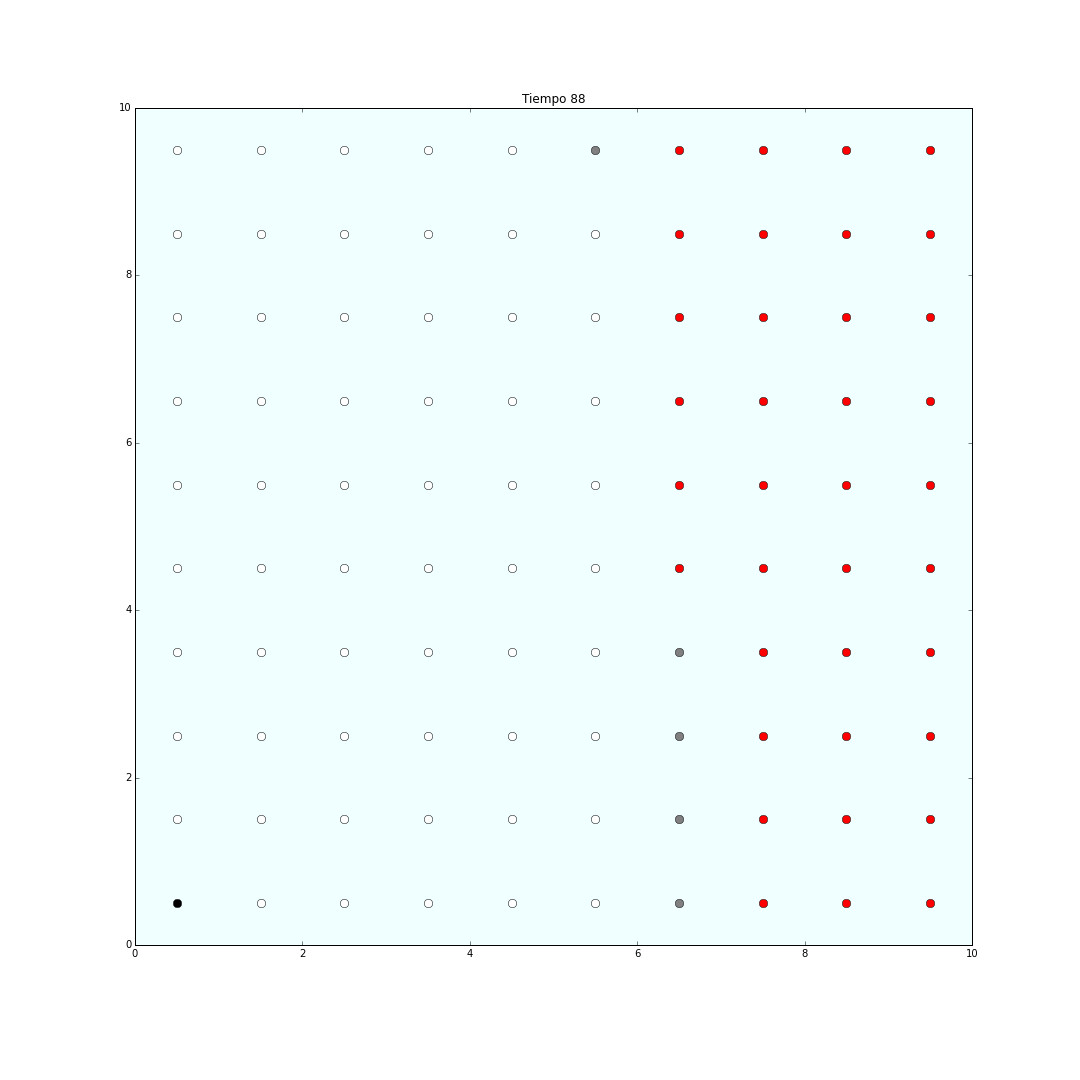
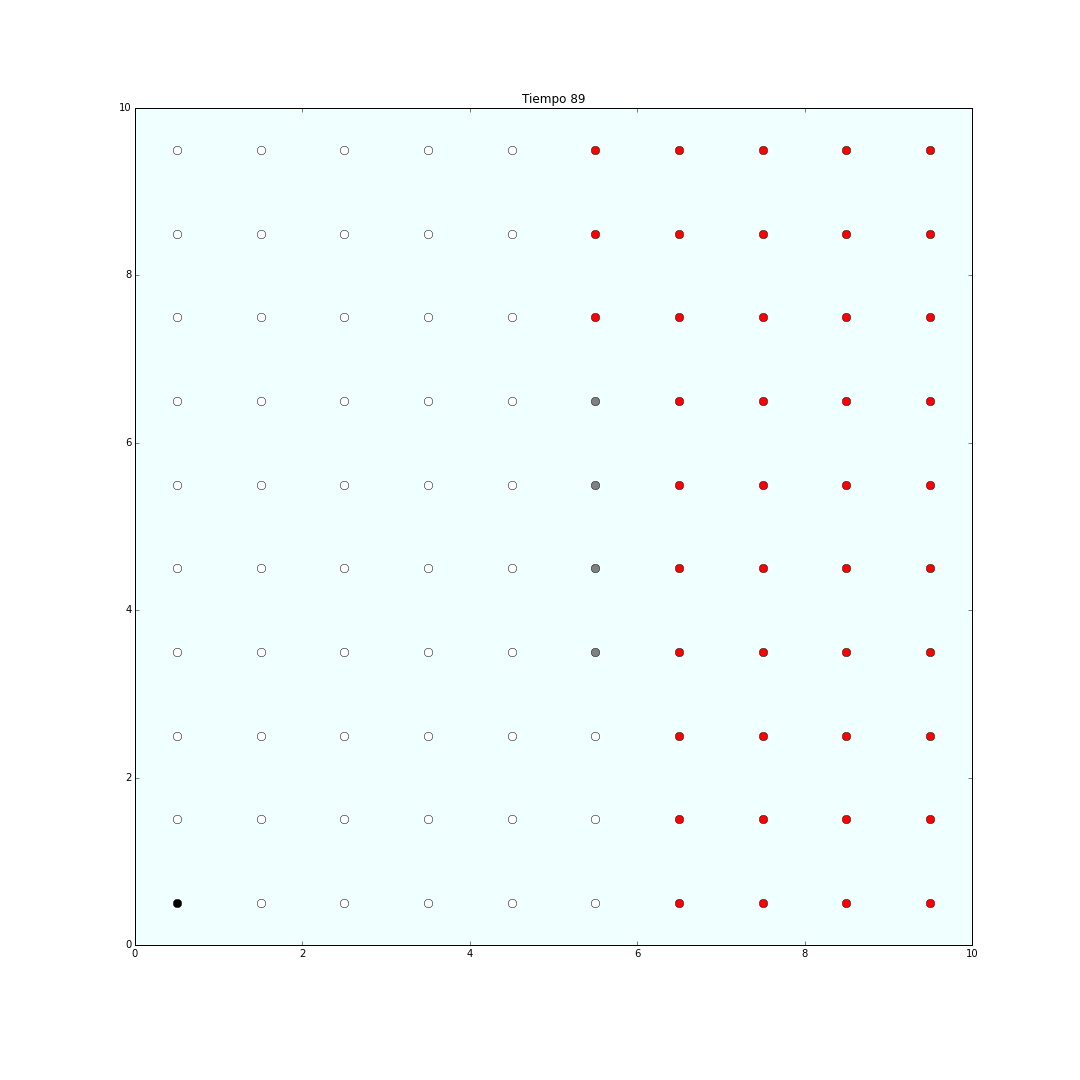
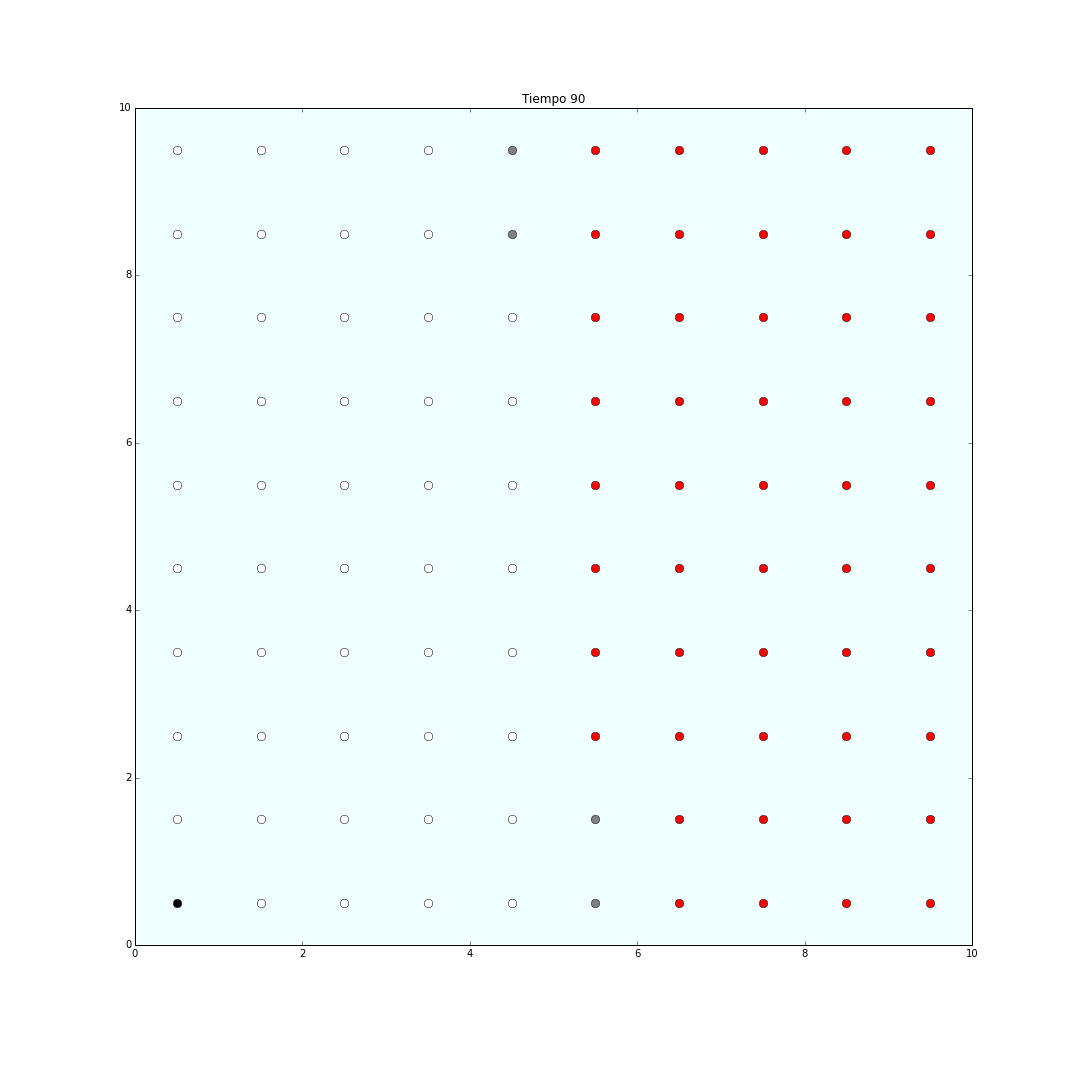
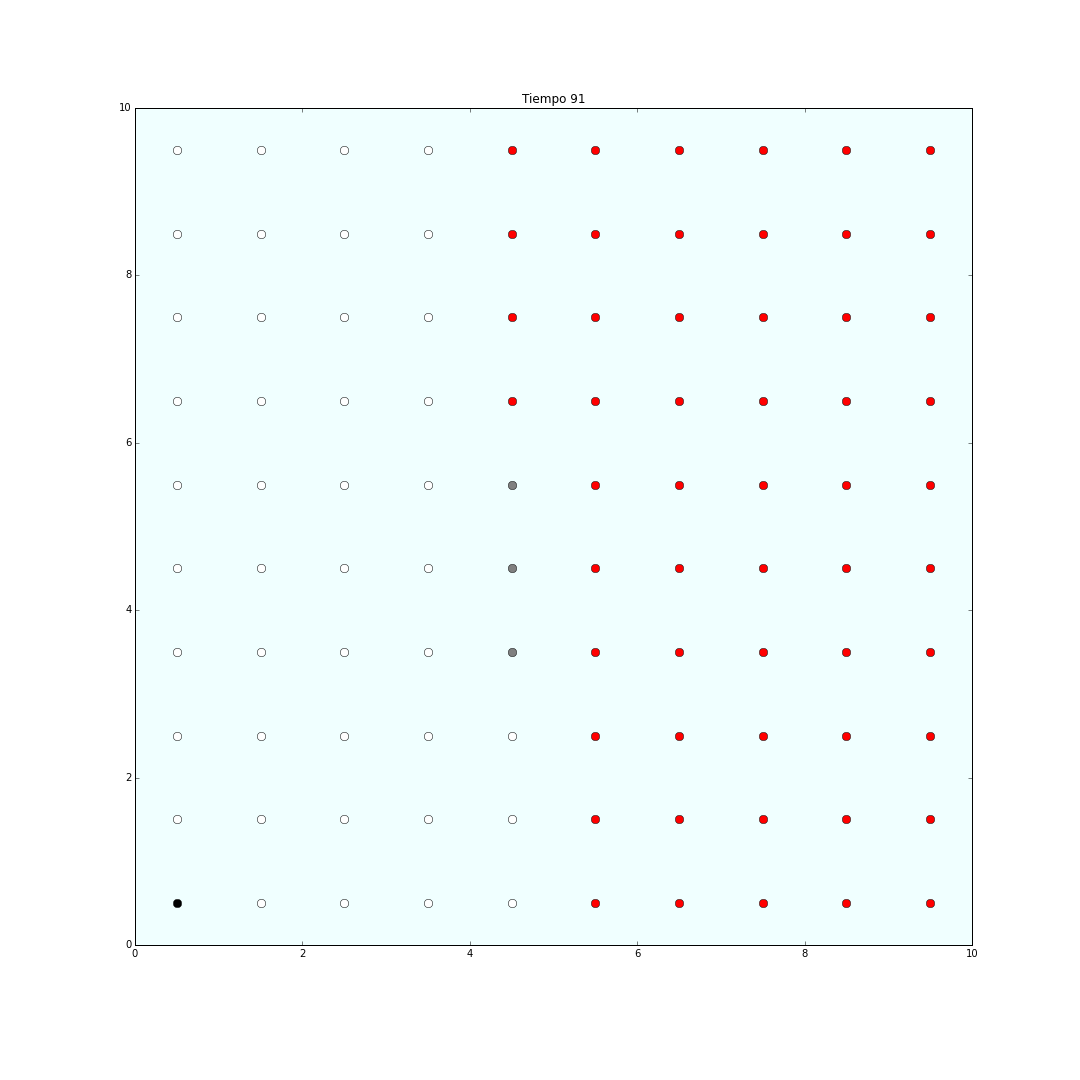
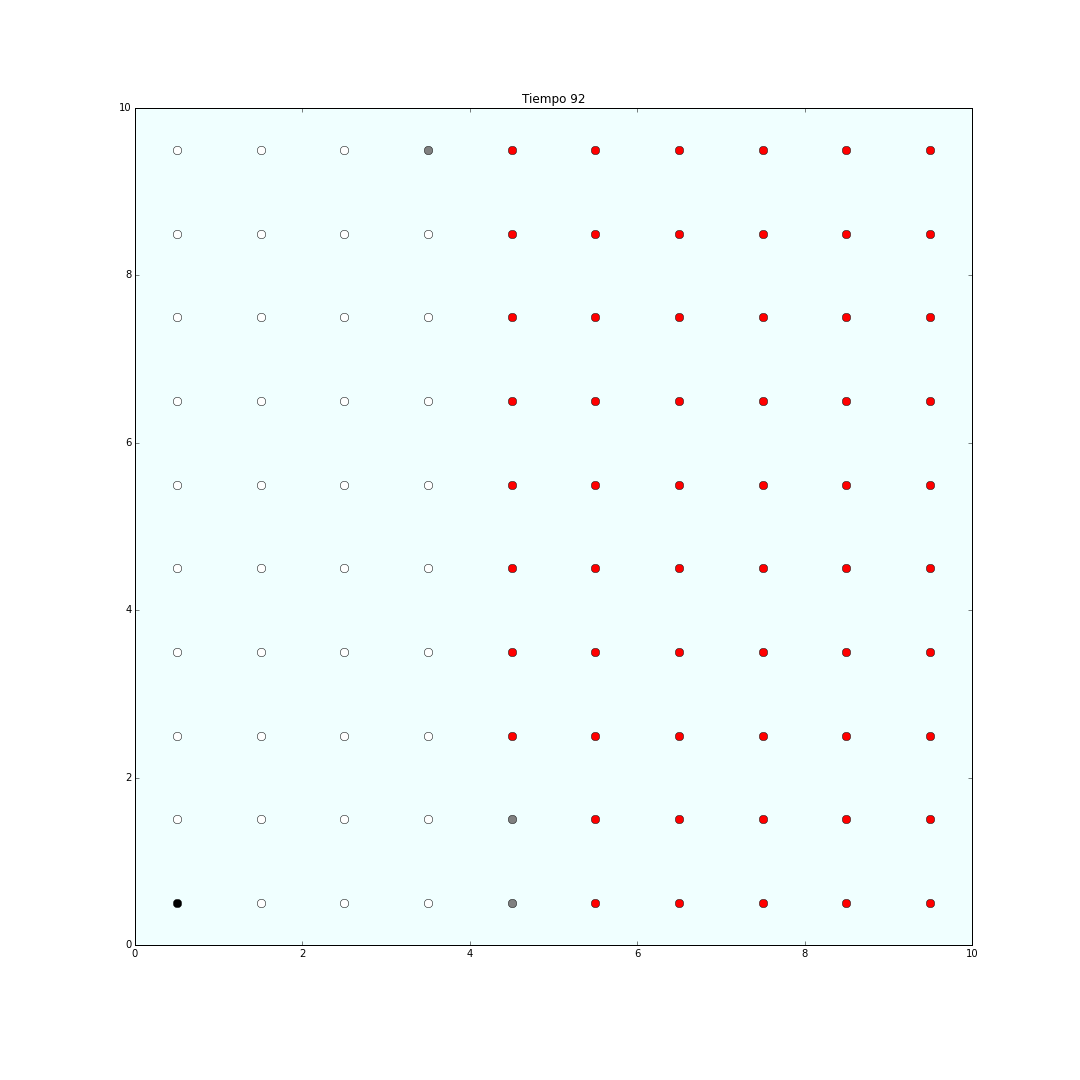
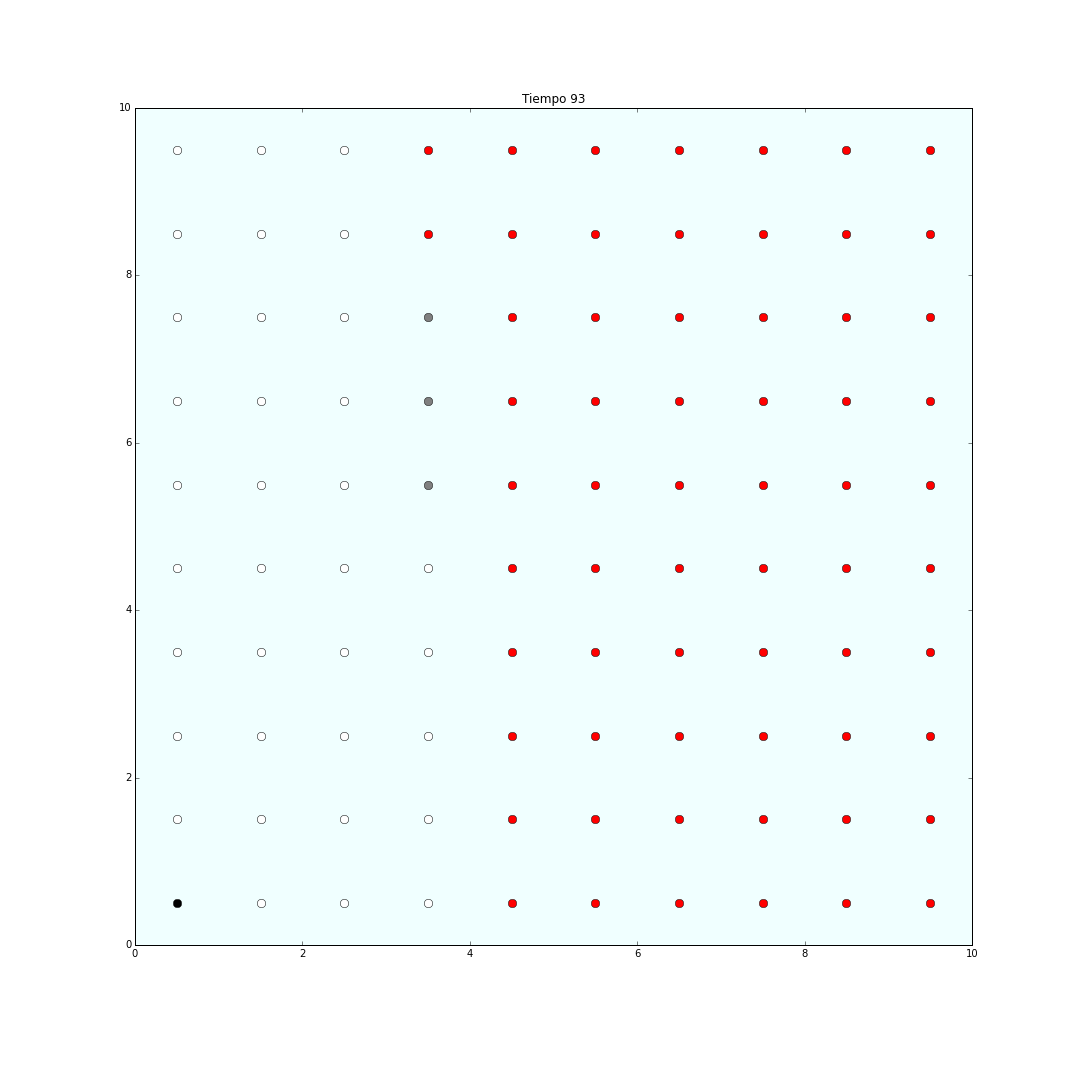
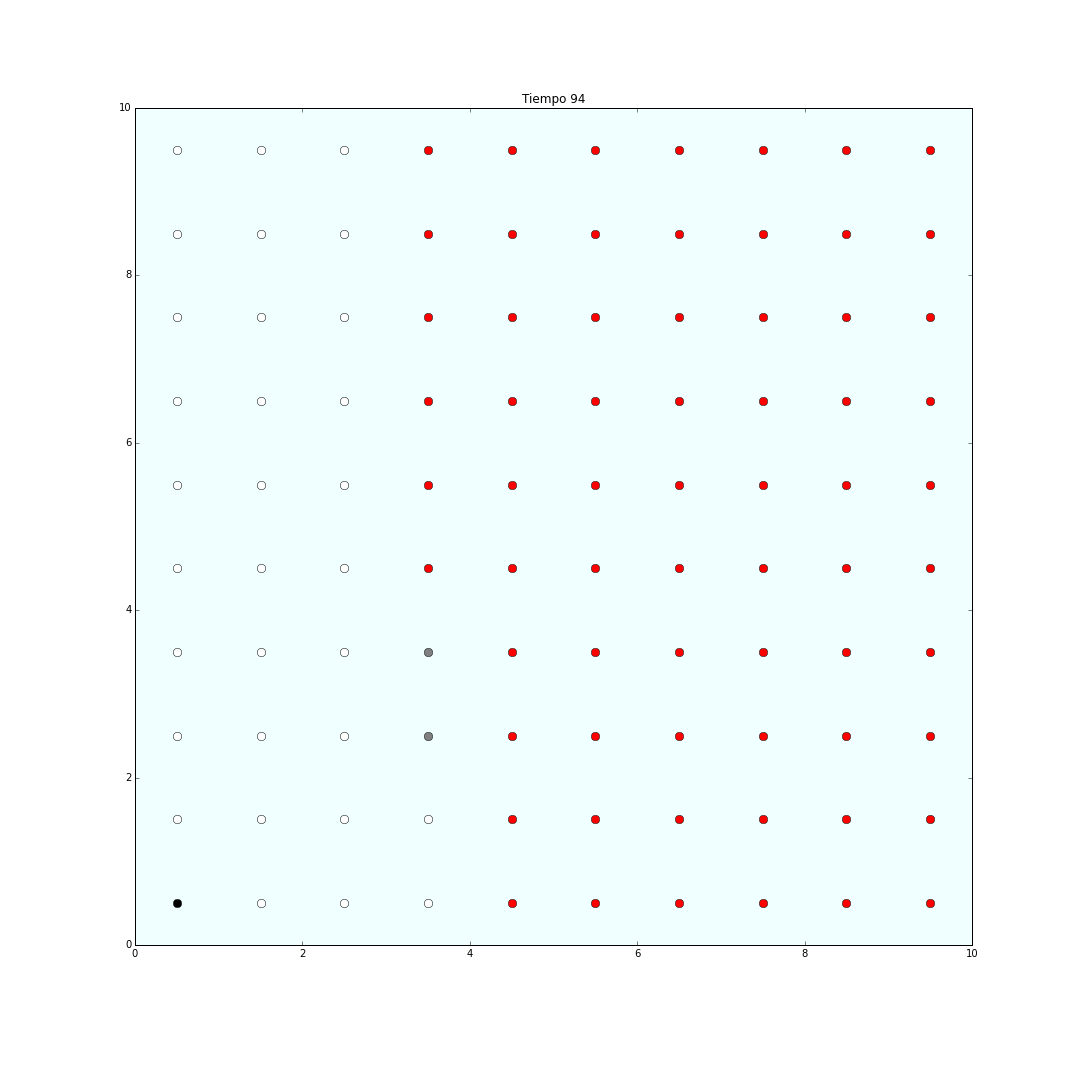
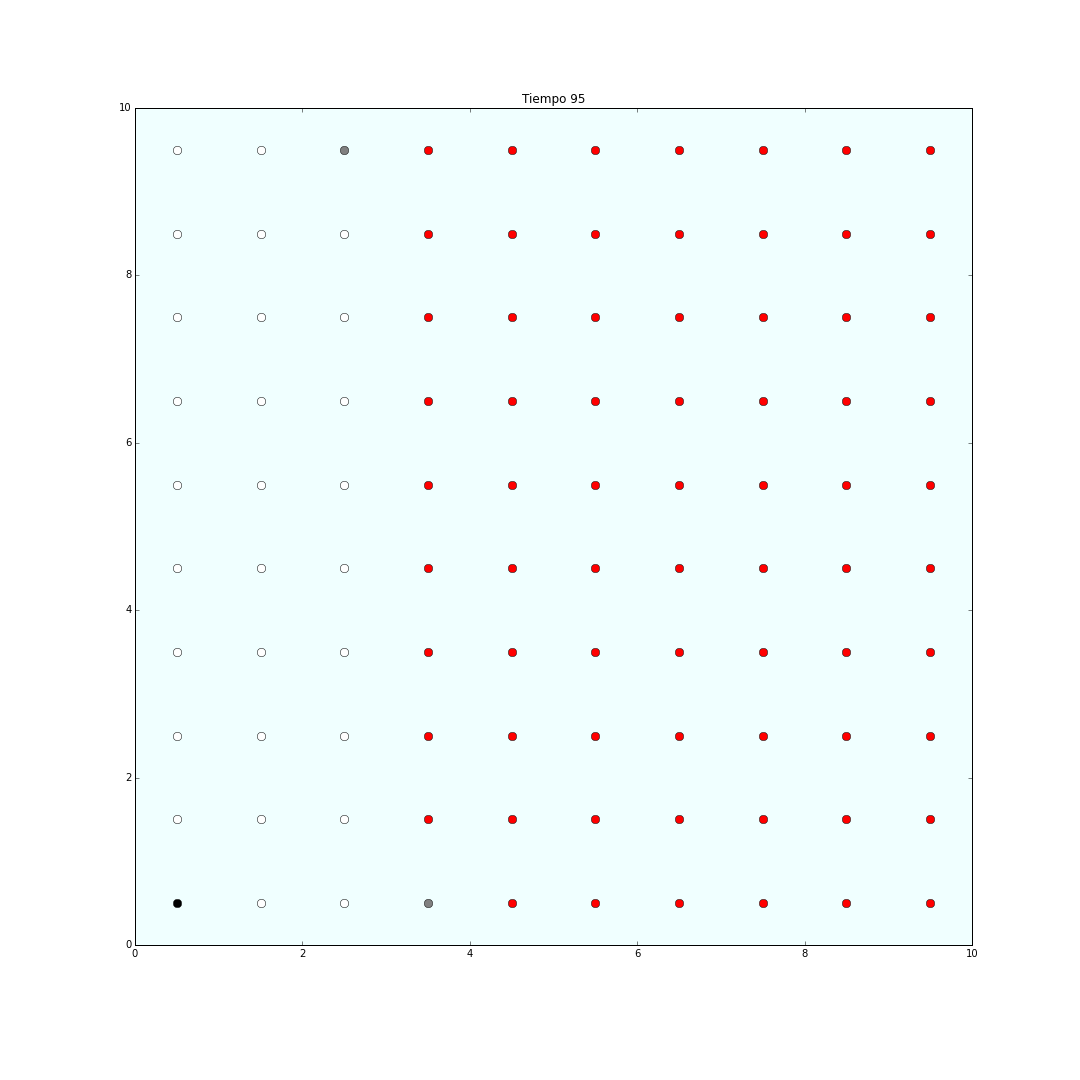
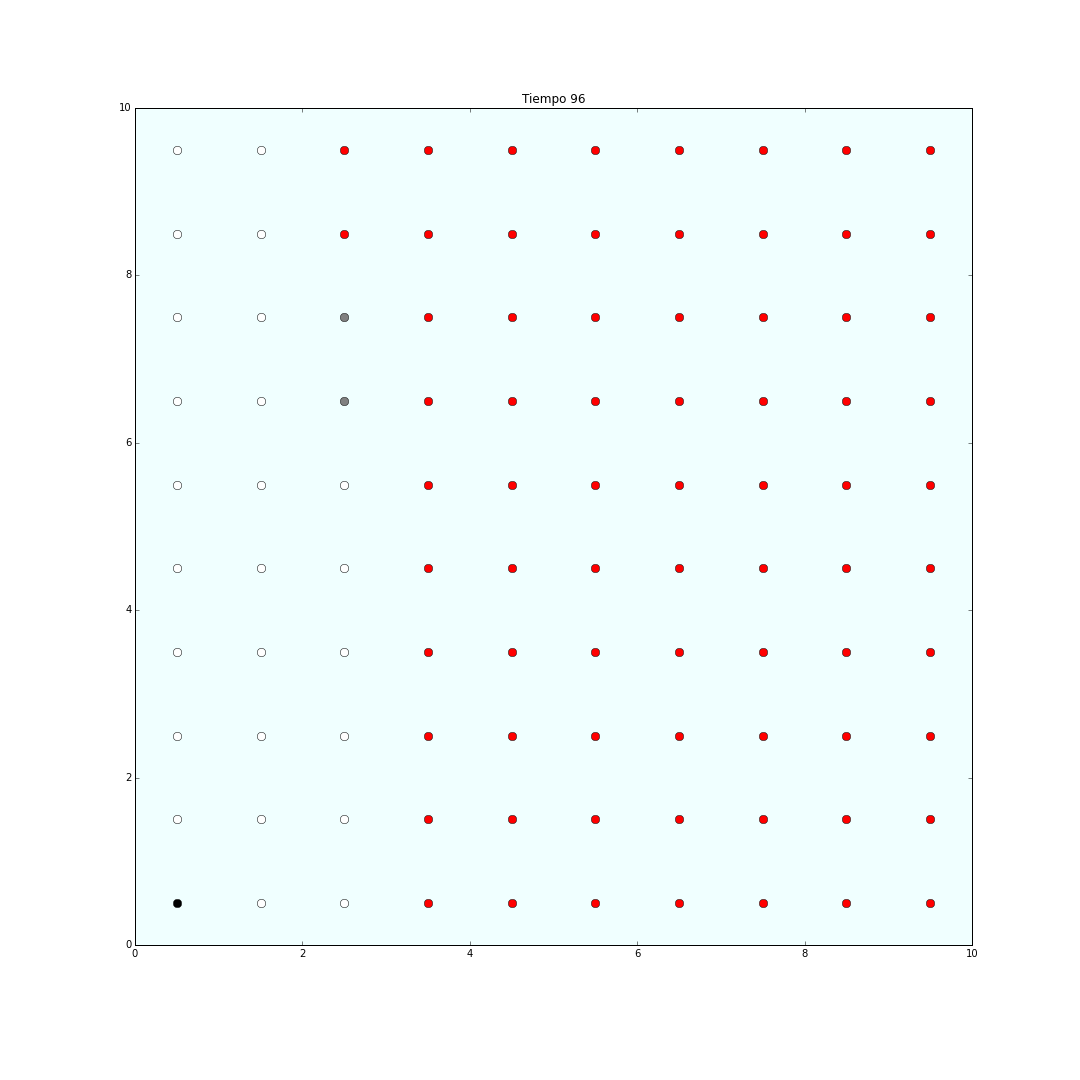
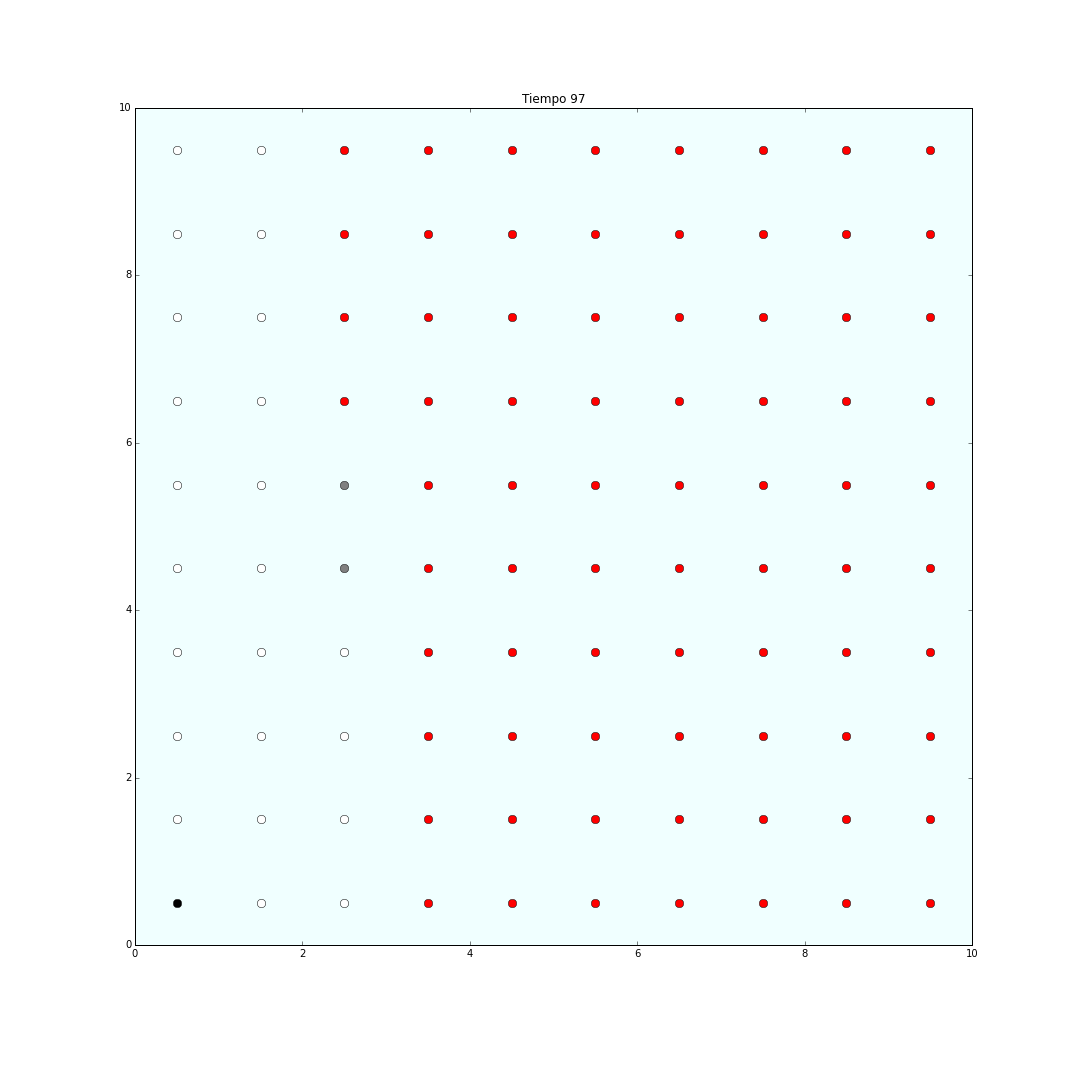
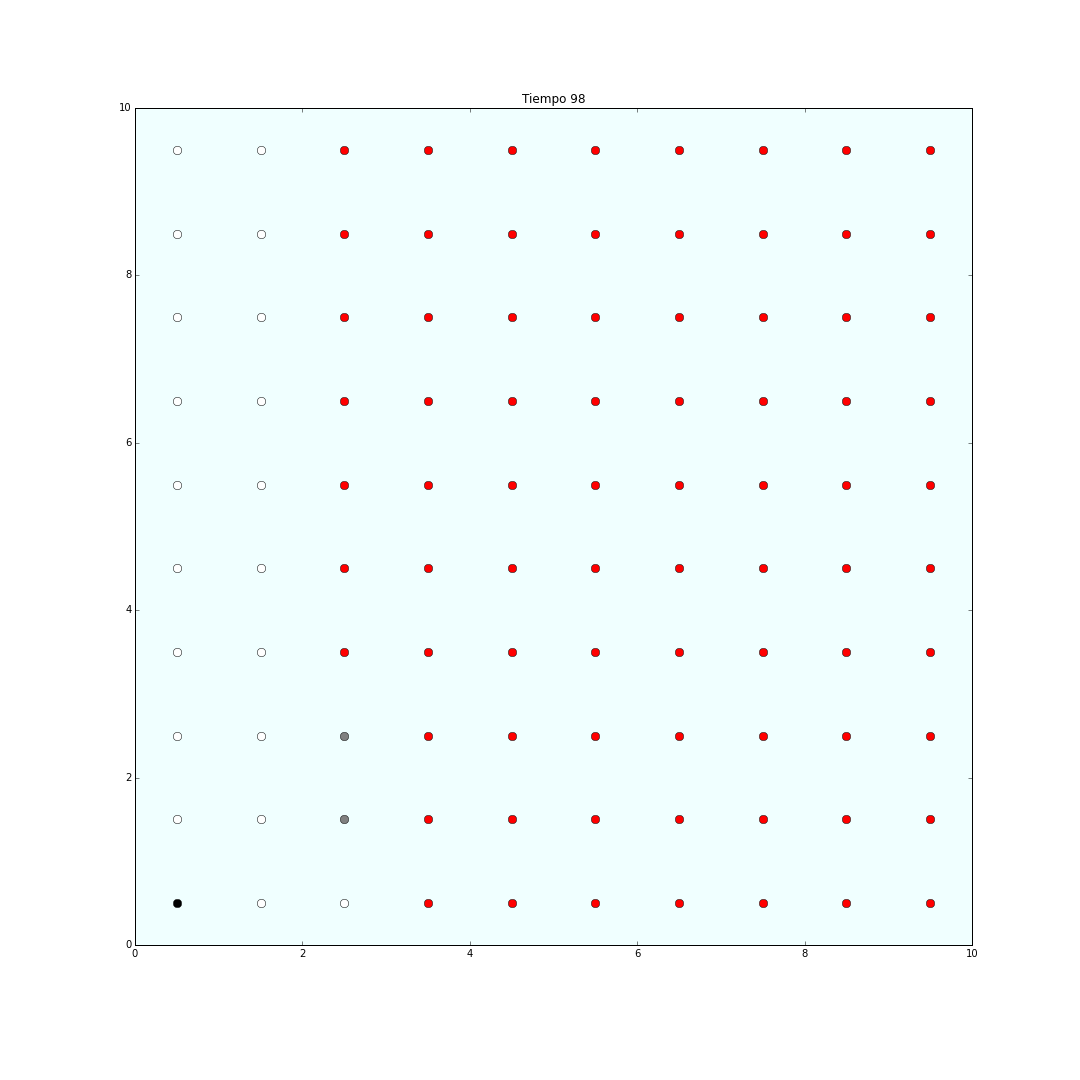
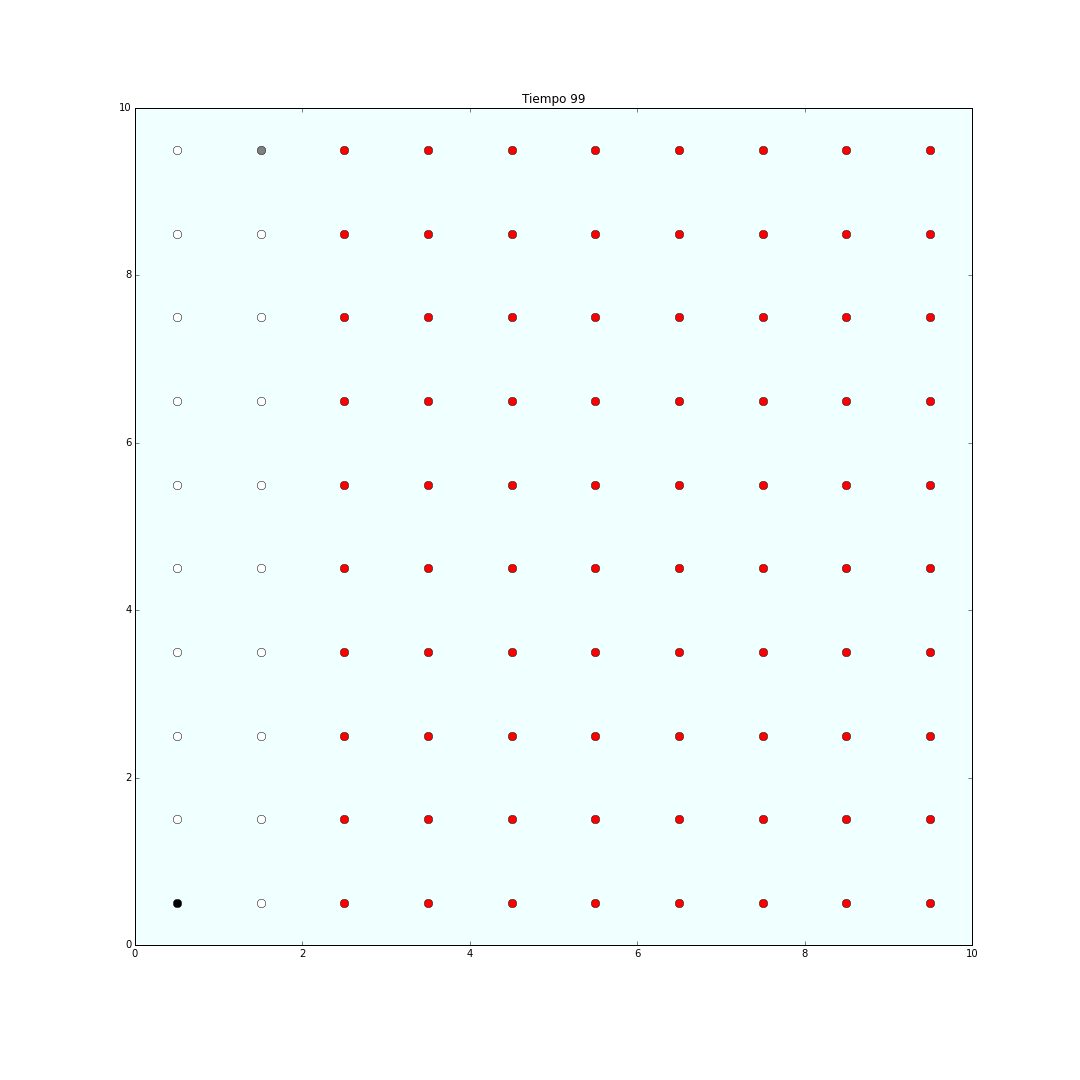

In [15]:
pos = obtener_posiciones_2(area_negra,area_blanca,area_gris,area_fertil,0)#Creo los agentes con las posiciones iniciales
agentes = [Agente(tipo=0,locacion = pos[0][i]) for i in range(len(pos[0]))]
agentes.extend(Agente(tipo=1,locacion= pos[1][i]) for i in range(len(pos[1])))
agentes.extend(Agente(tipo=2,locacion= pos[2][i]) for i in range(len(pos[2])))
agentes.extend(Agente(tipo=3,locacion= pos[3][i]) for i in range(len(pos[3])))
sin_chiste = Mundo2(agentes = agentes,ar_negra = area_negra,ar_blanca=area_blanca,ar_gris=area_gris,ar_fertil=area_fertil, steps = 100,metodo = 1)
sin_chiste.simular()

#Simulación del mundo en forma aleatoria



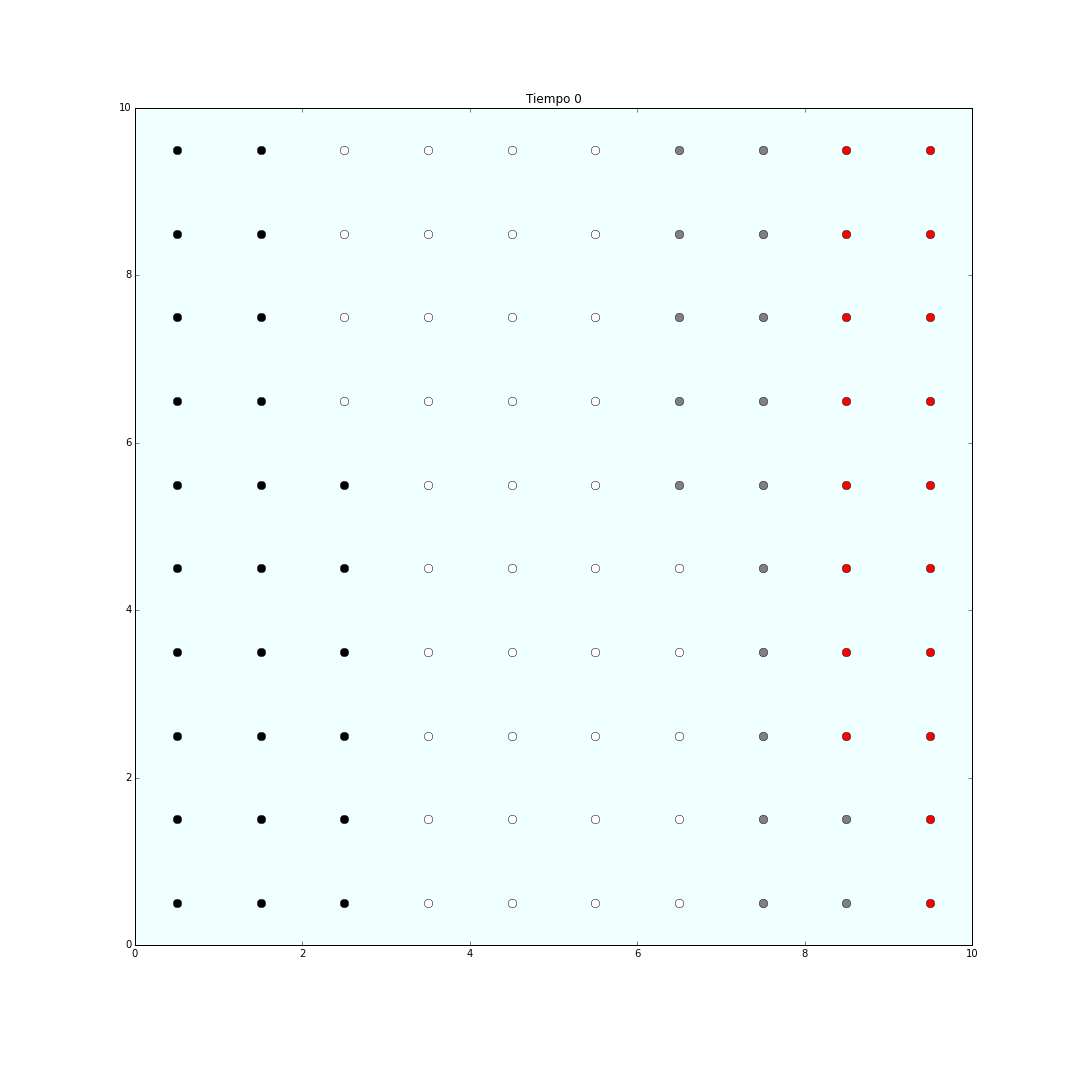
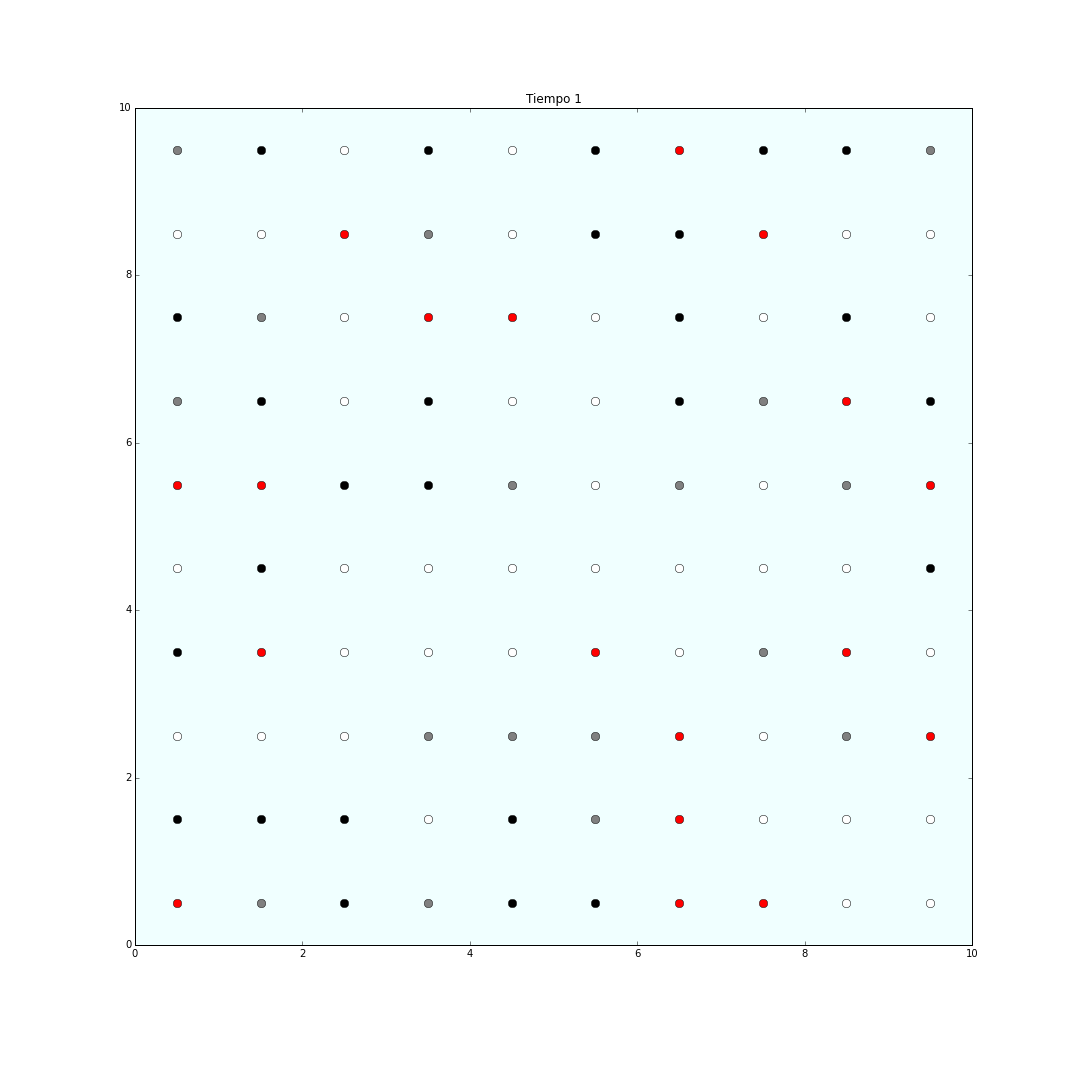
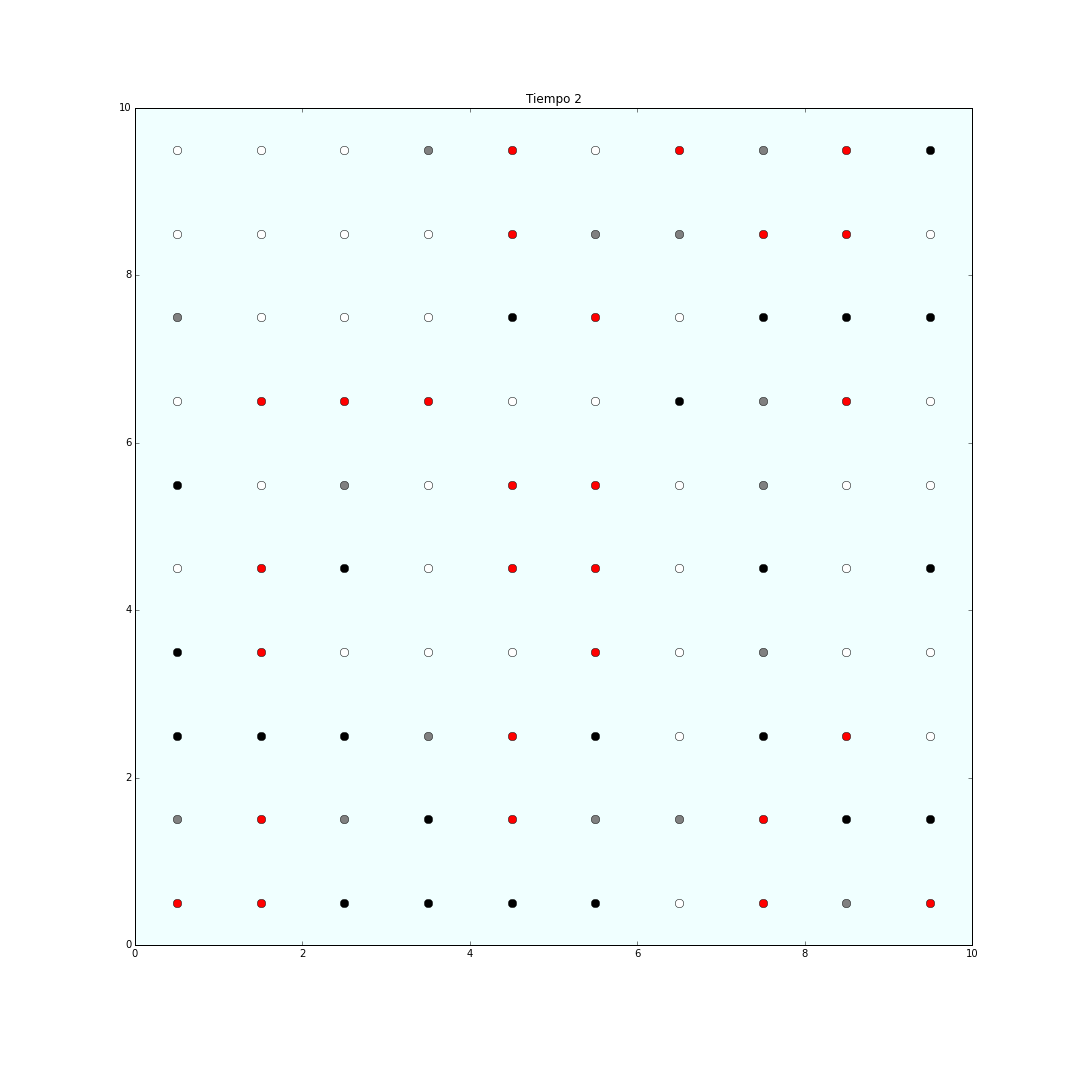
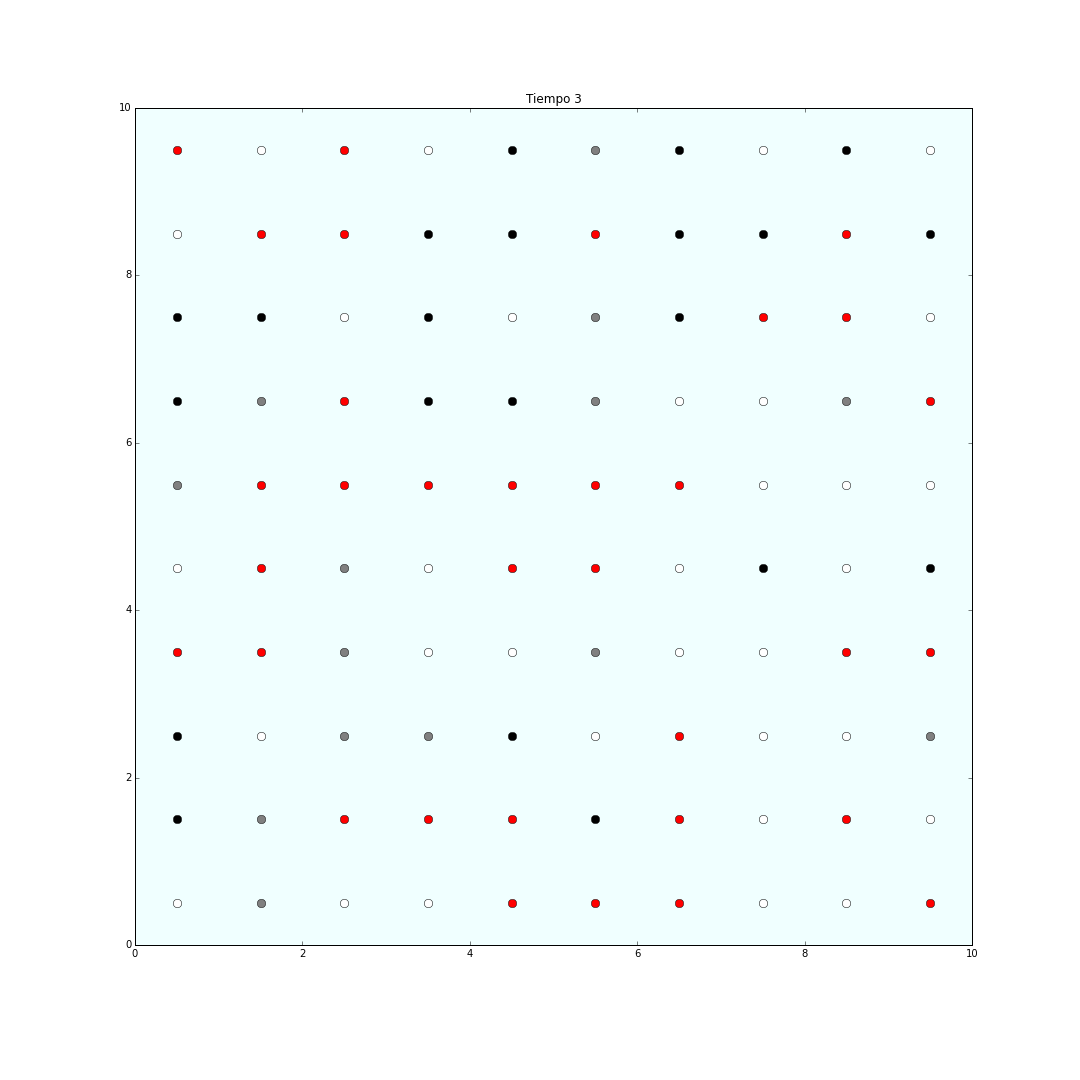
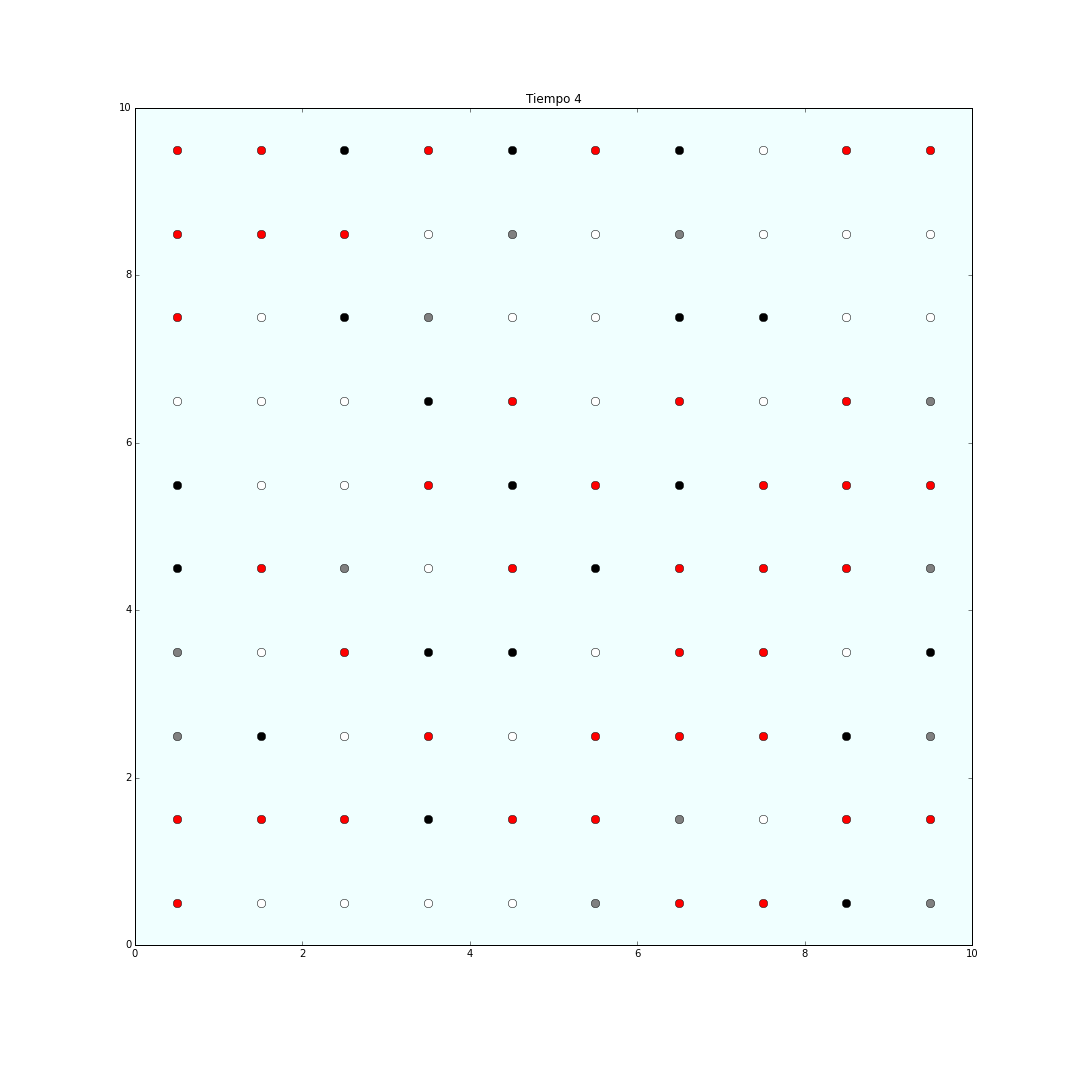
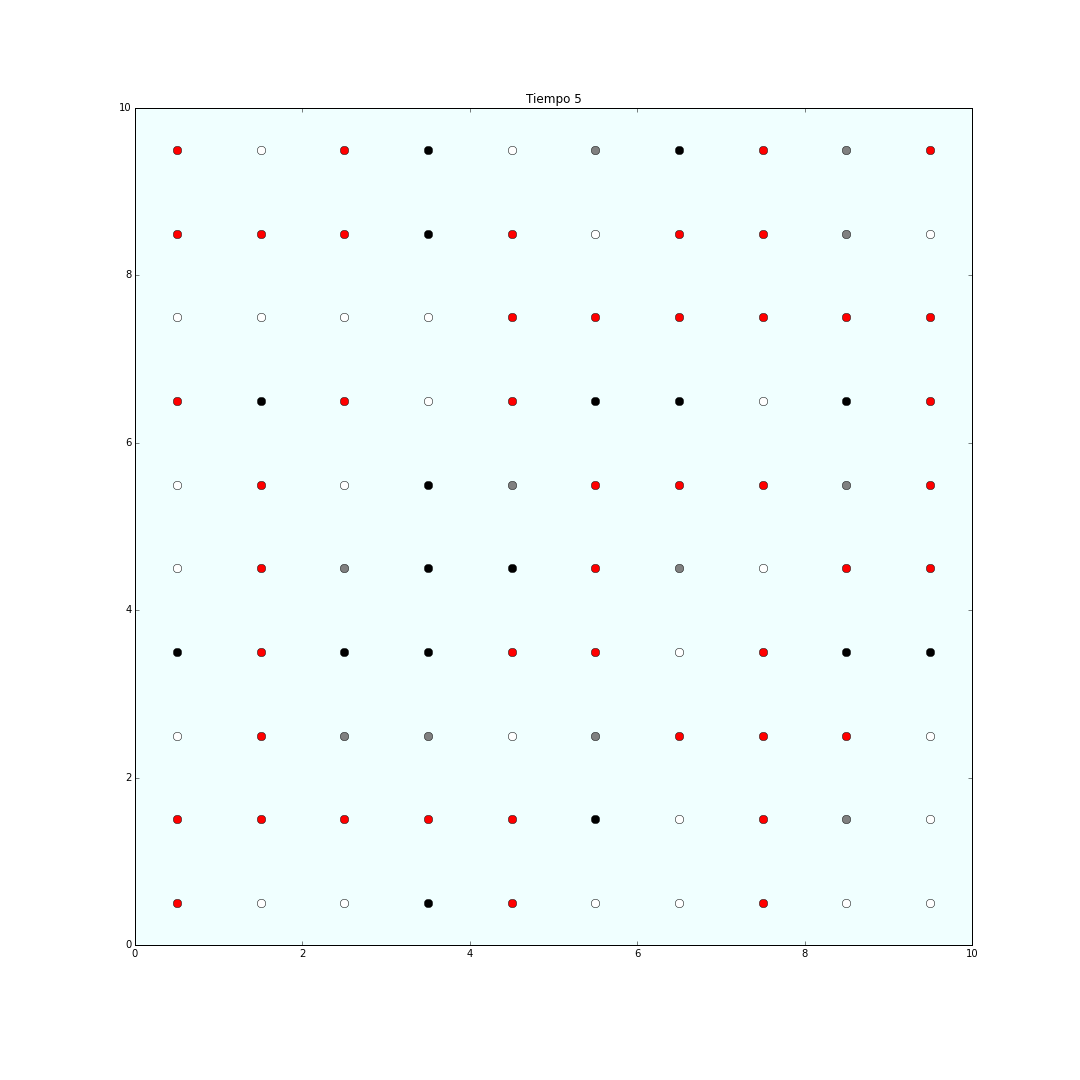
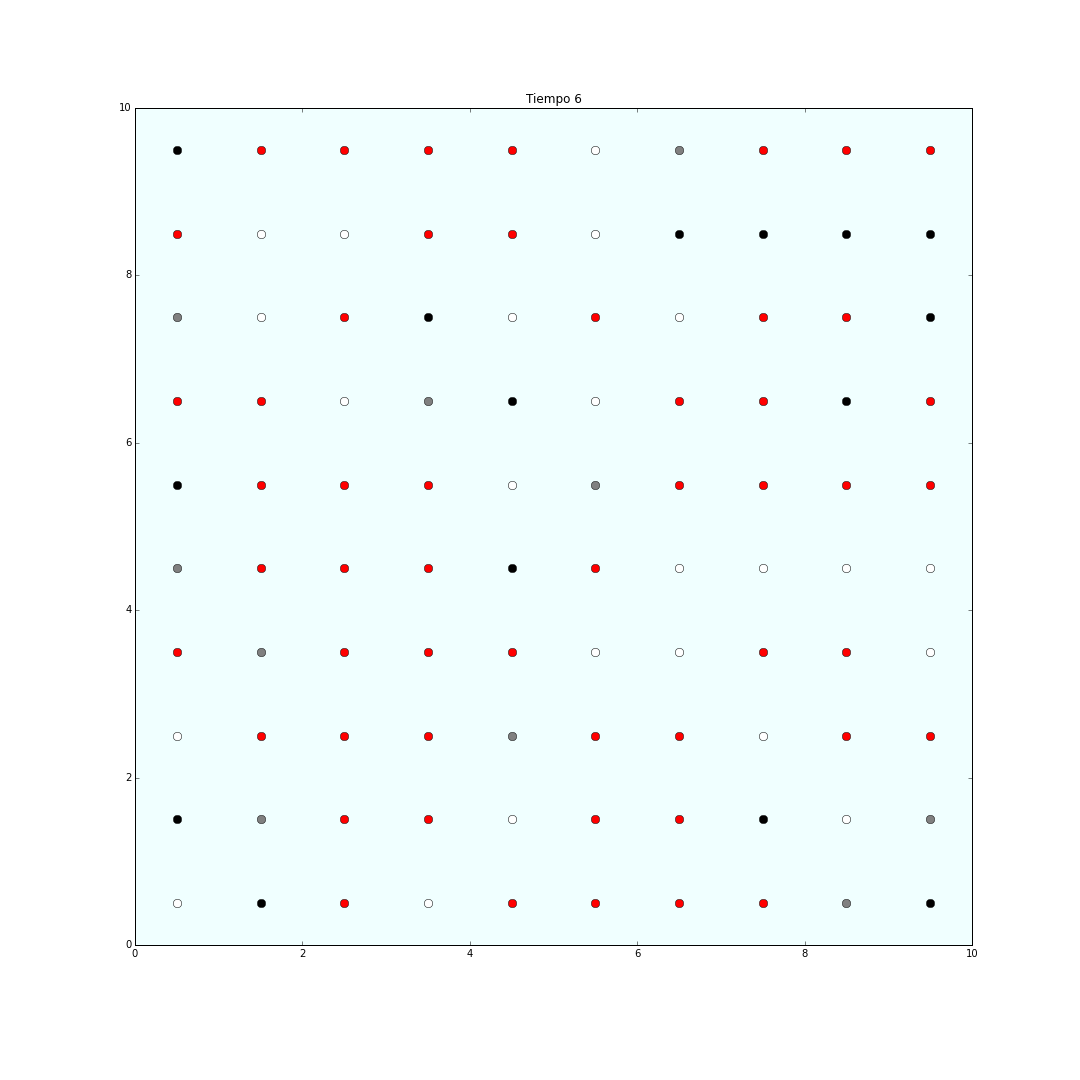
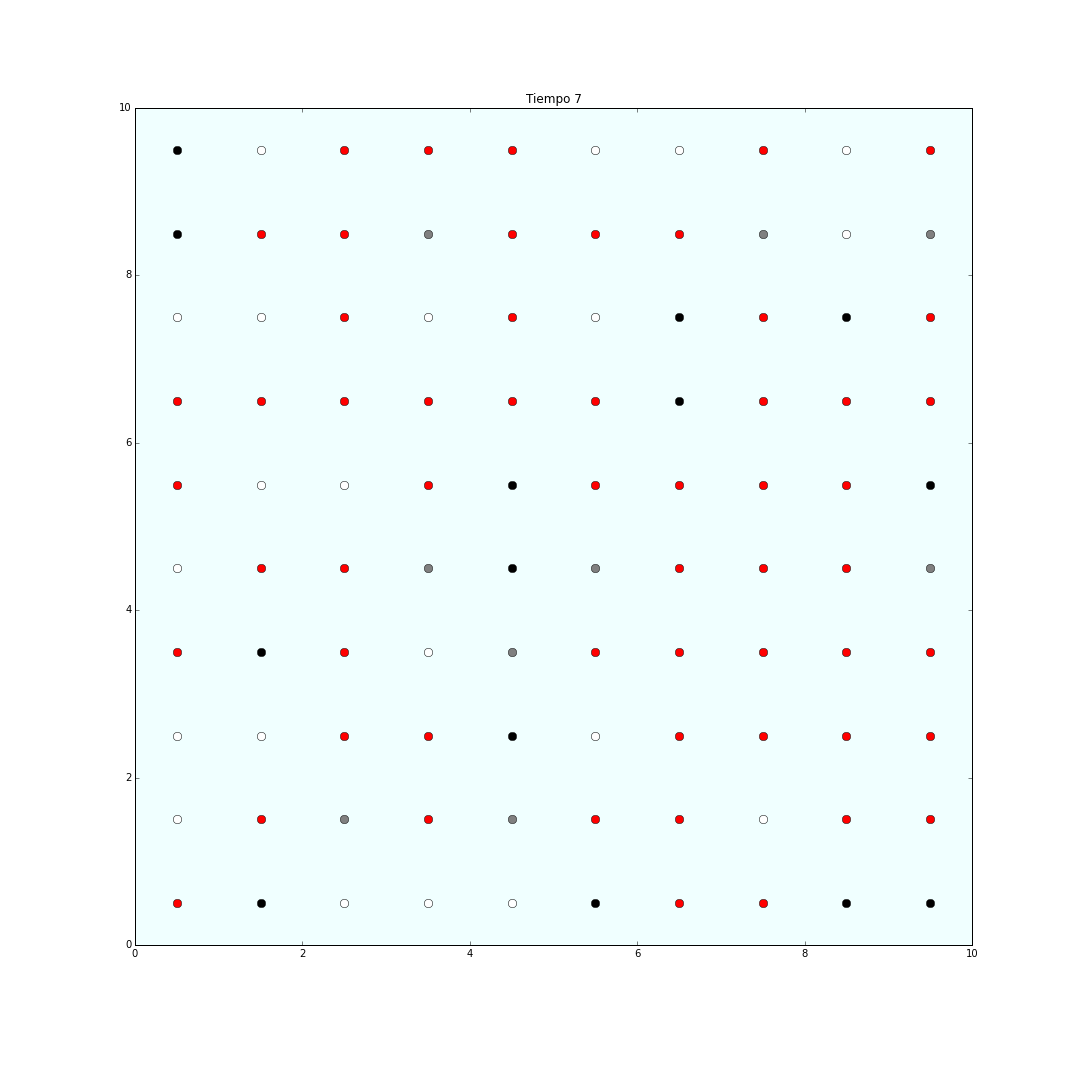
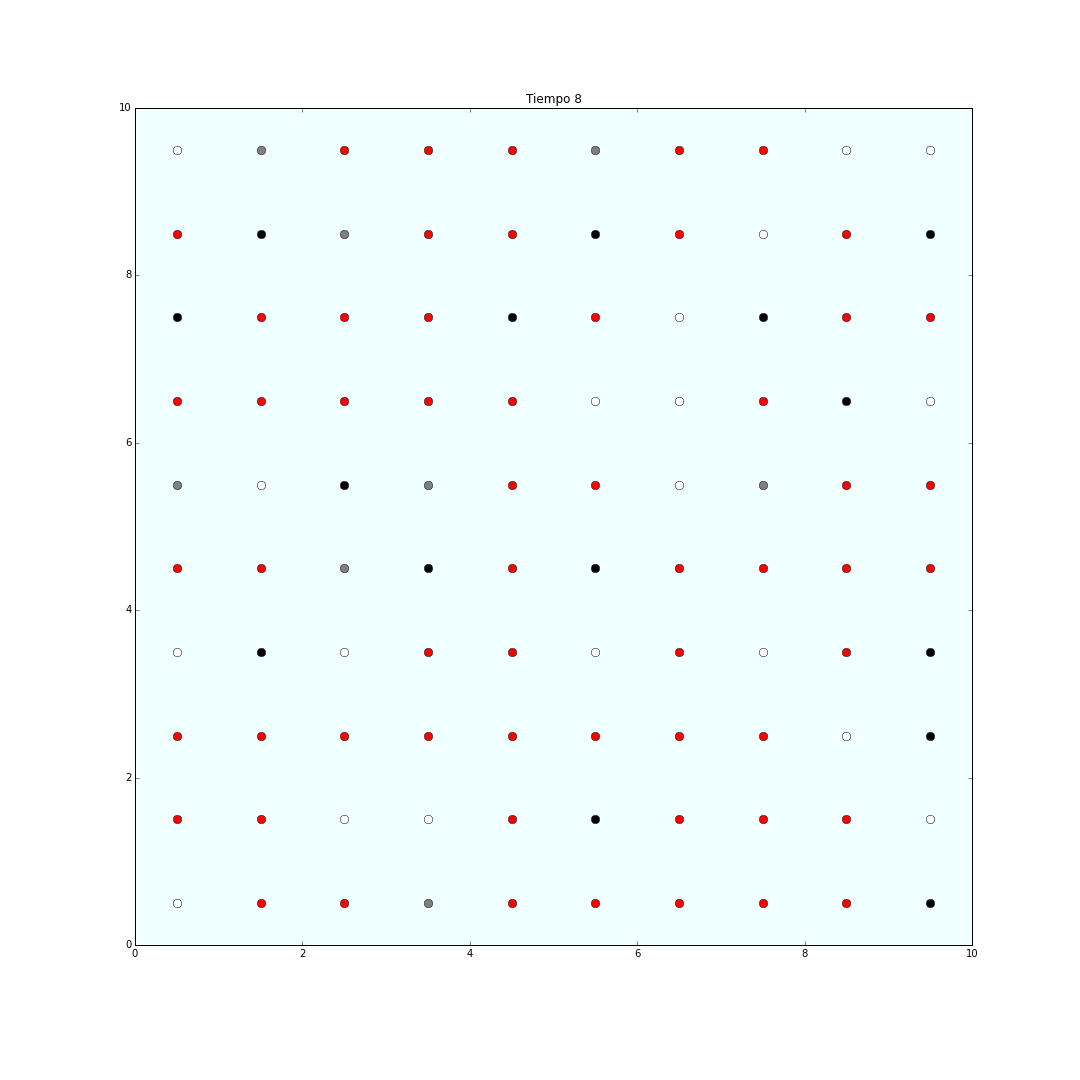
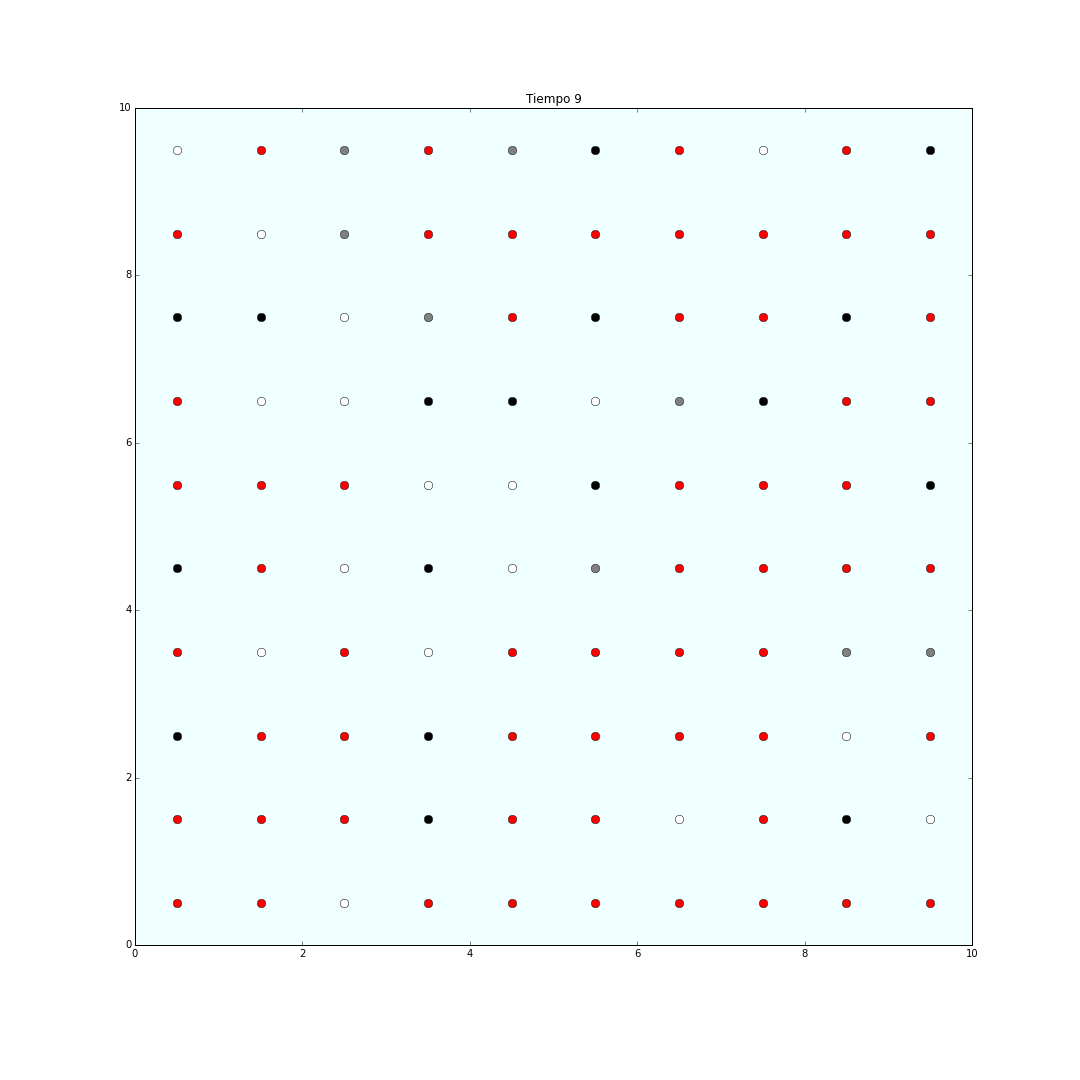
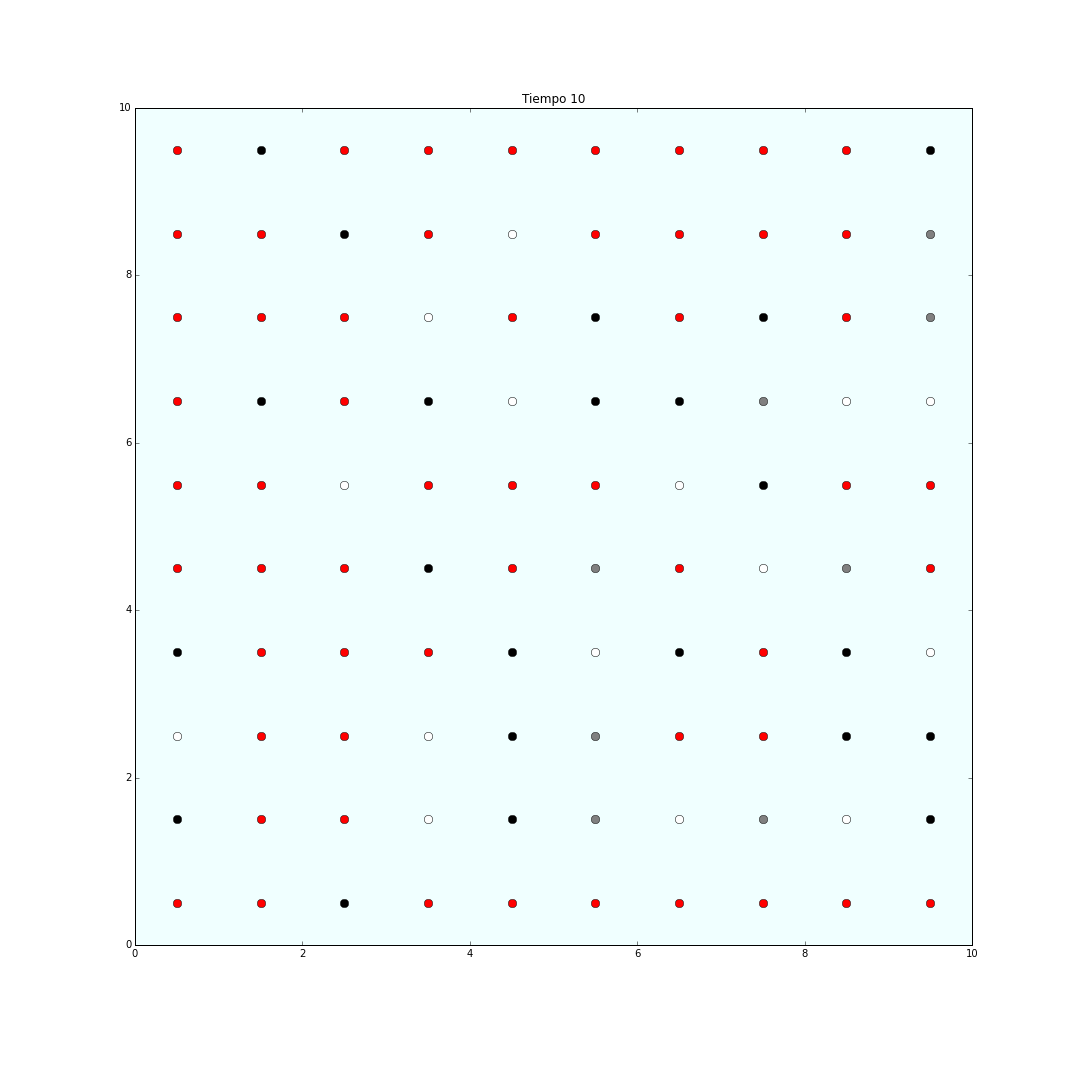
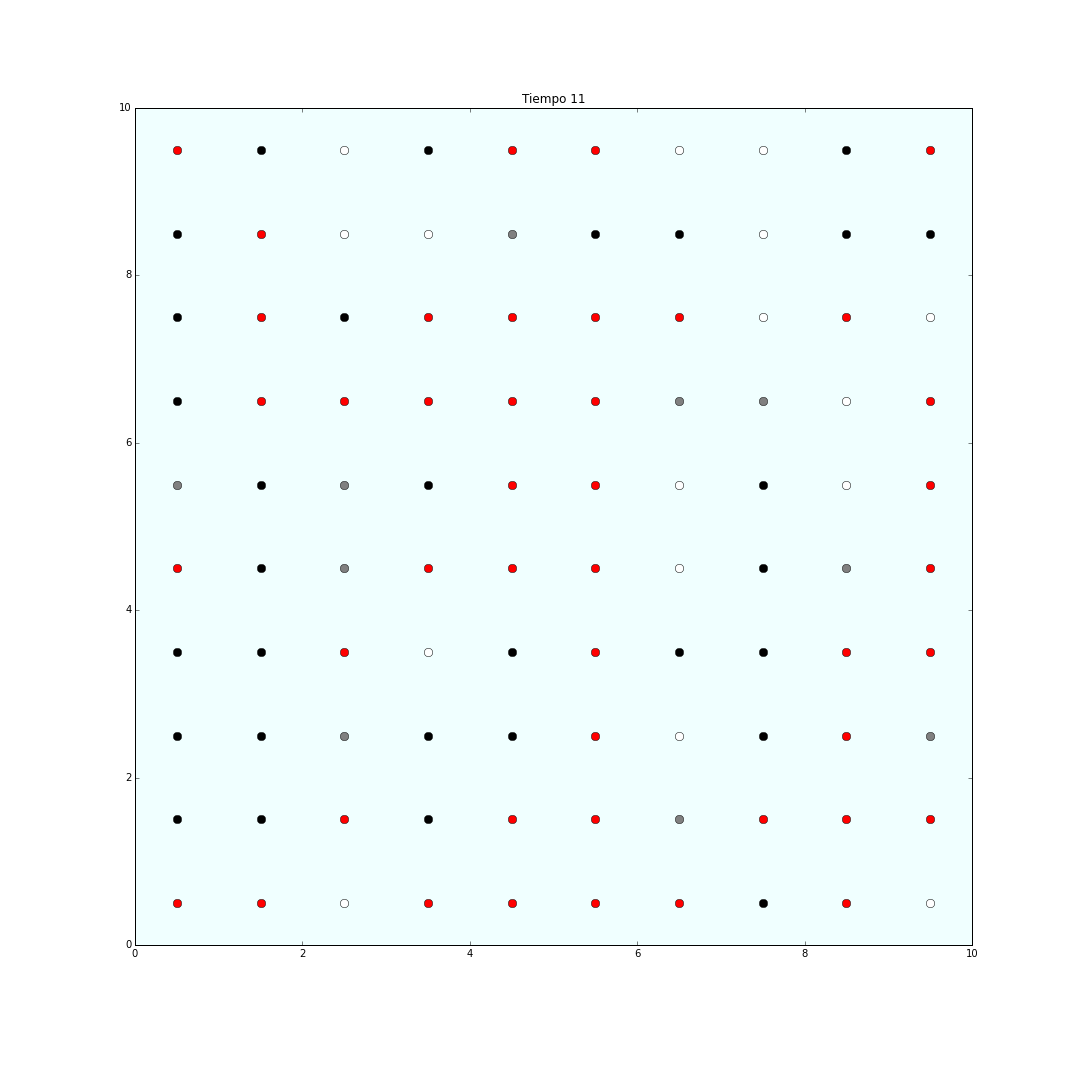
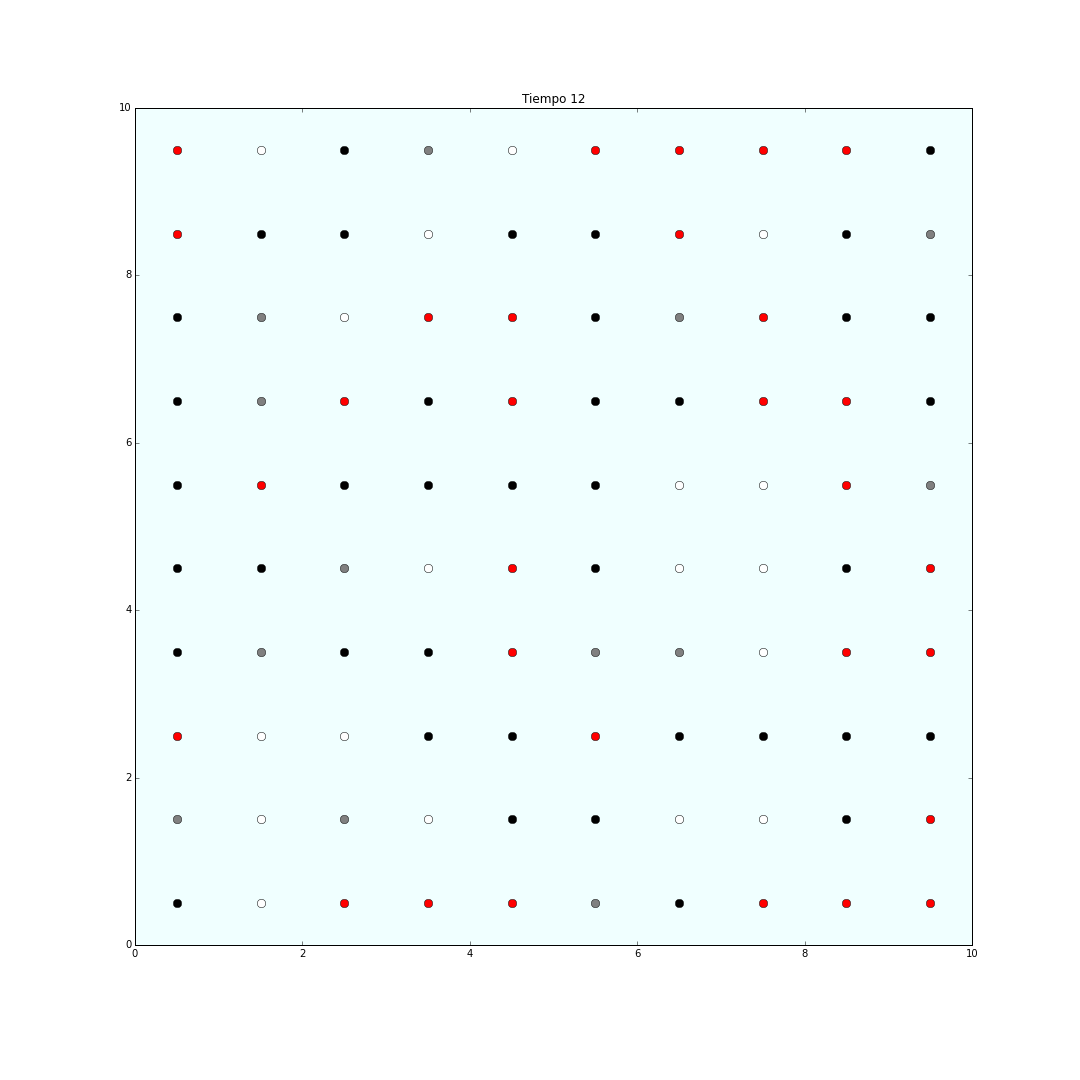
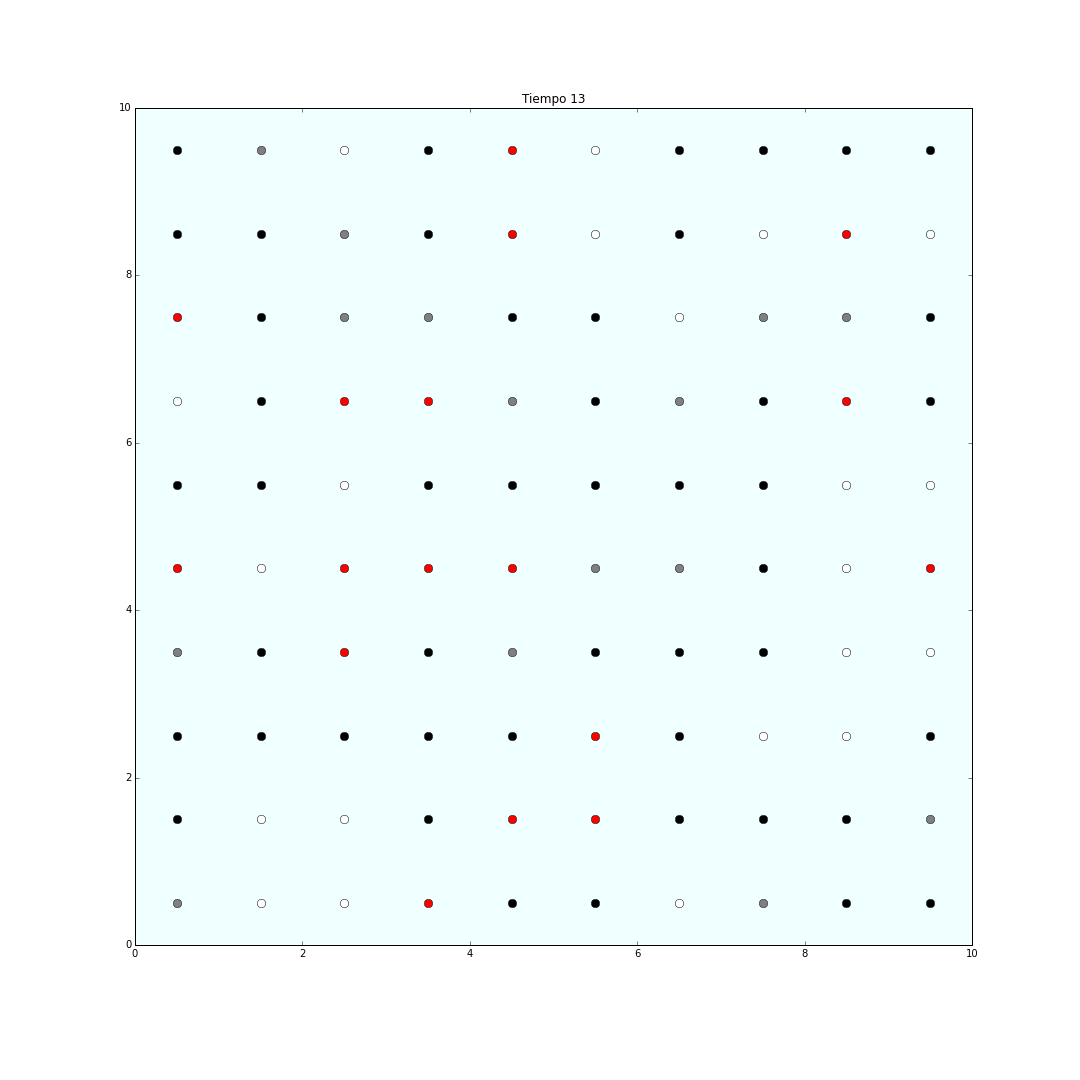
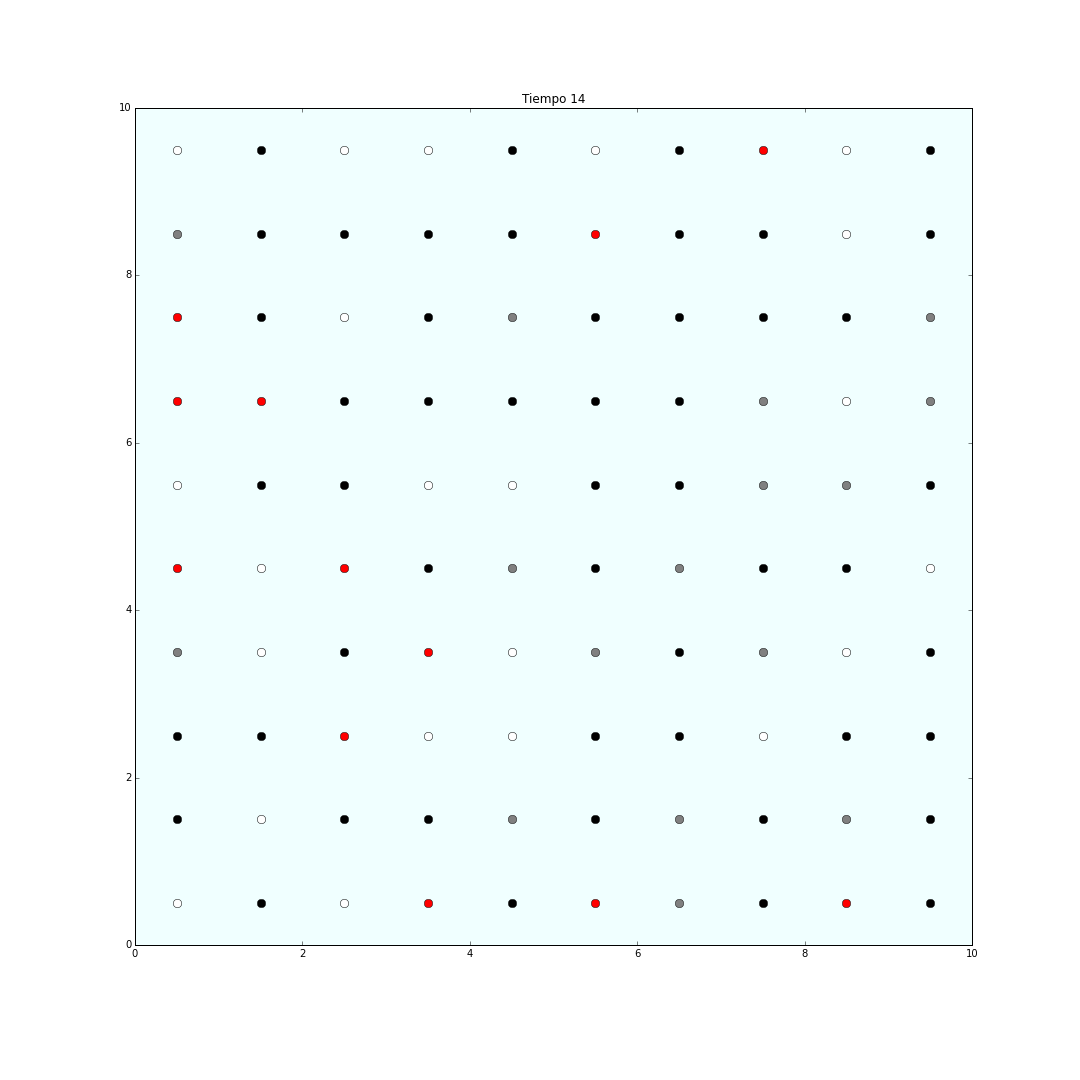
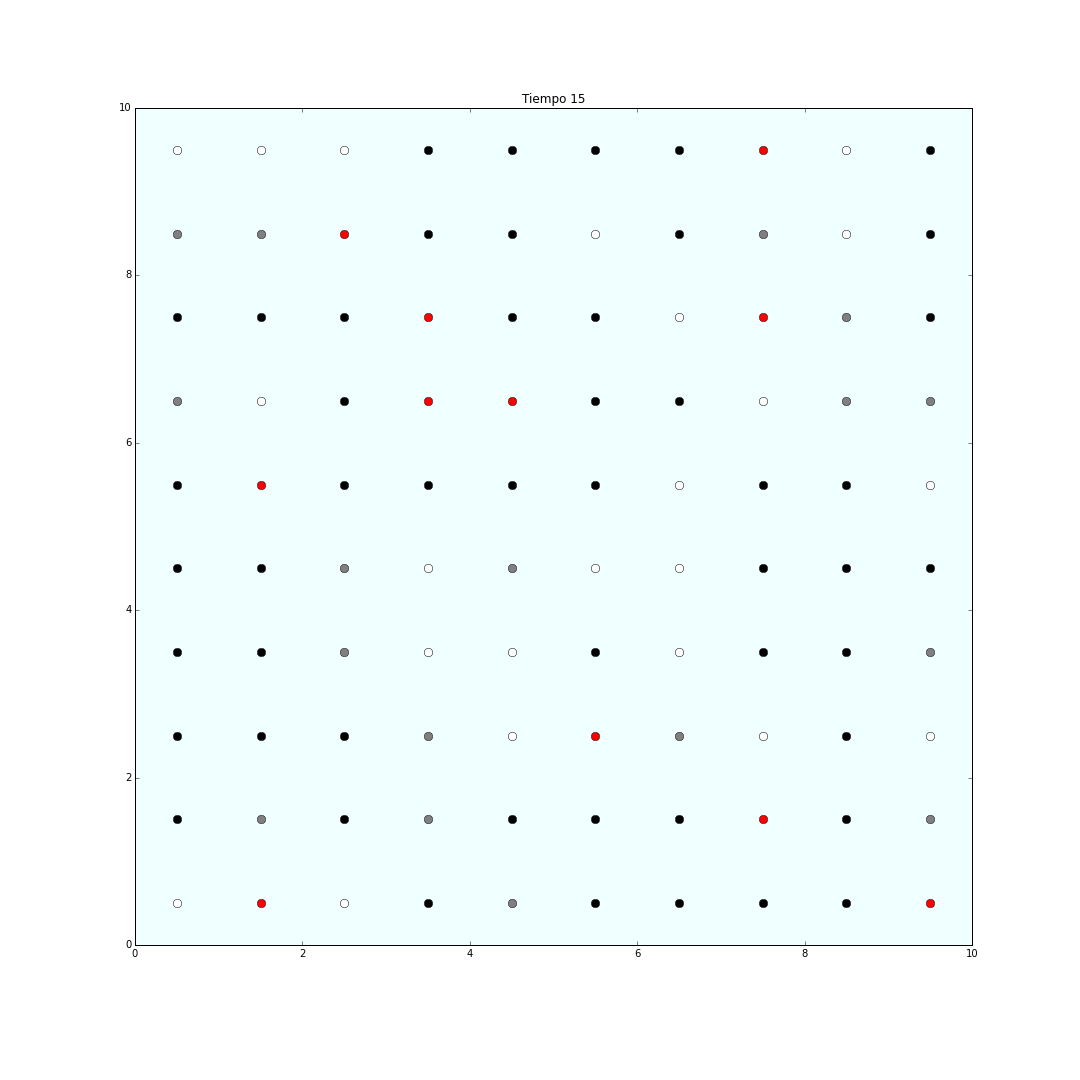
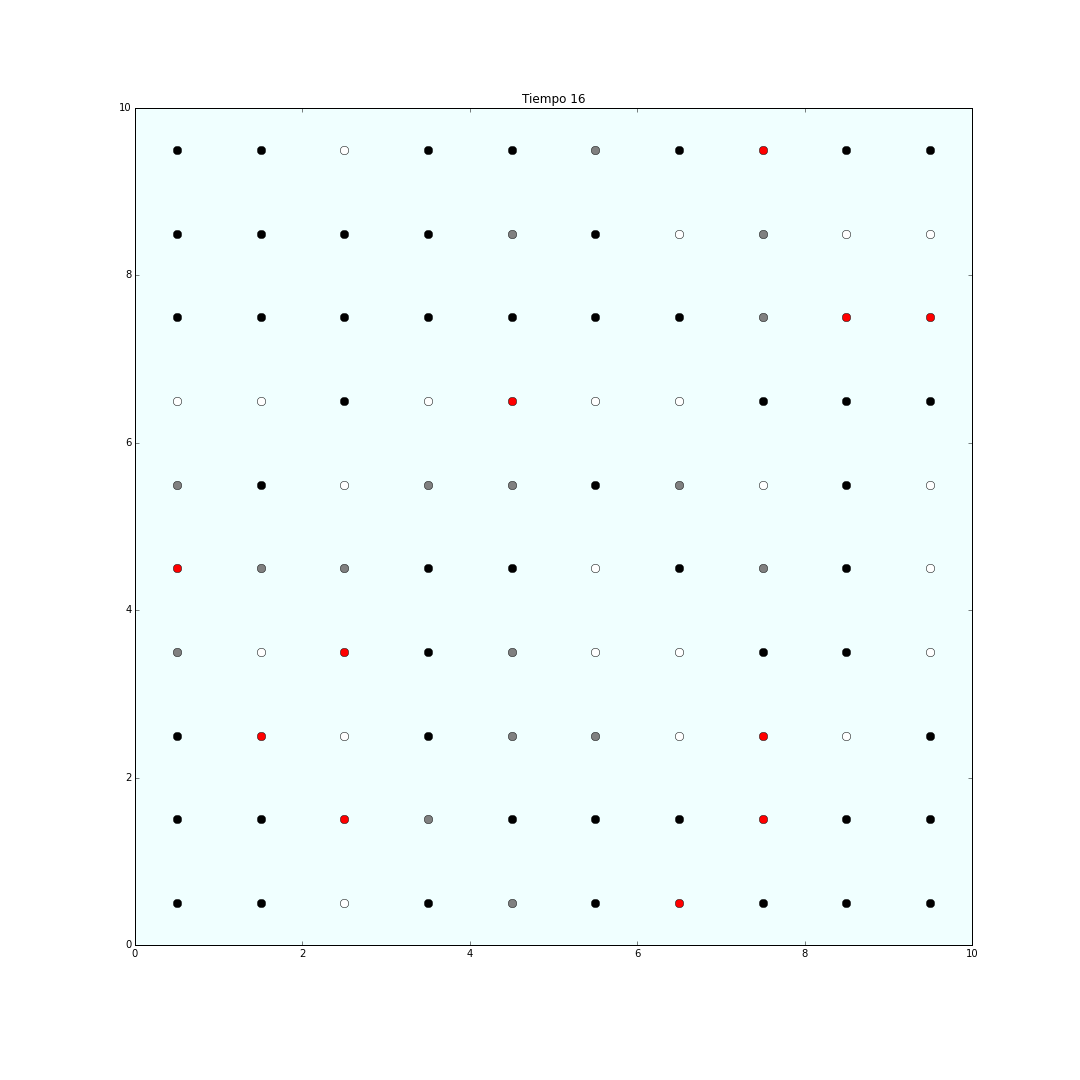
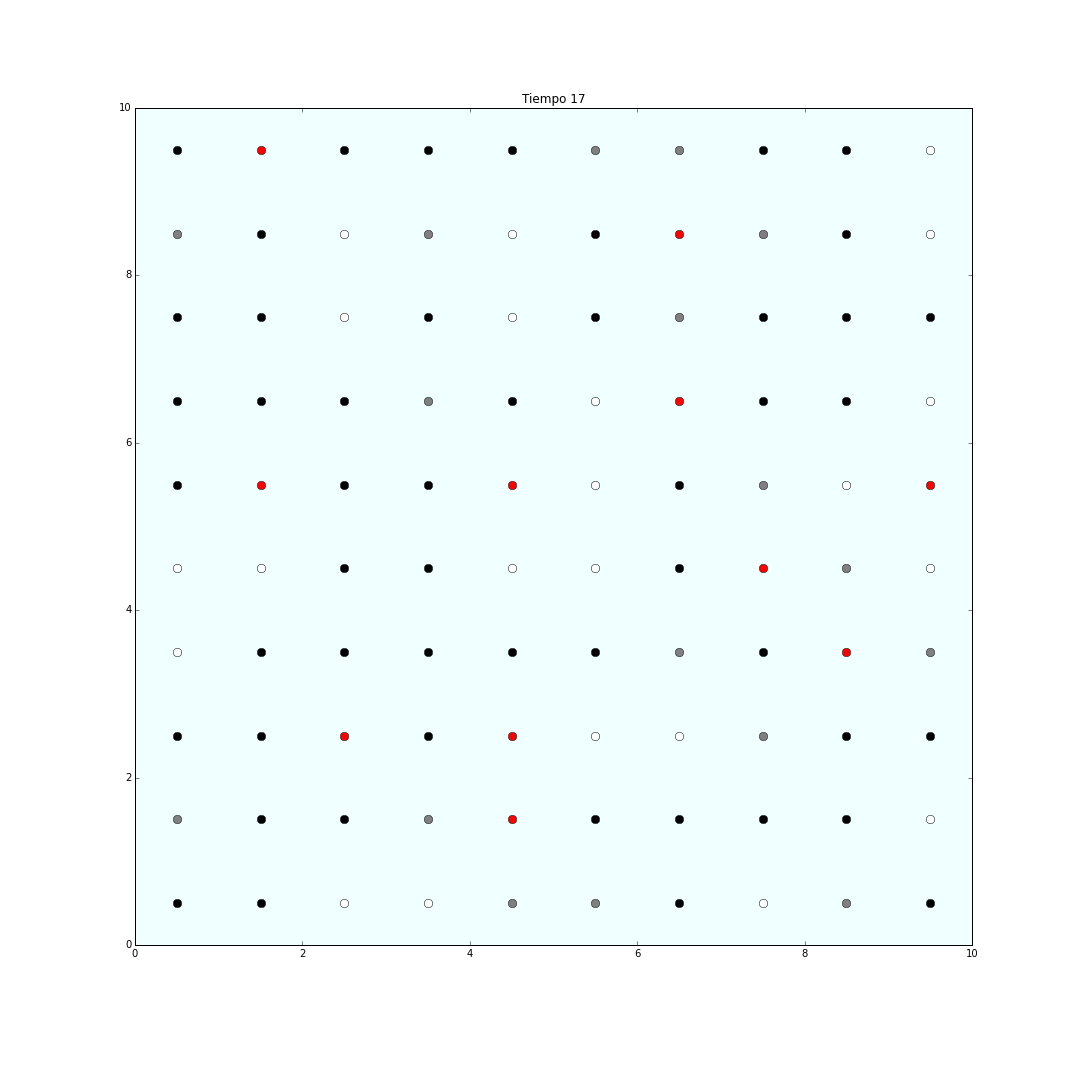
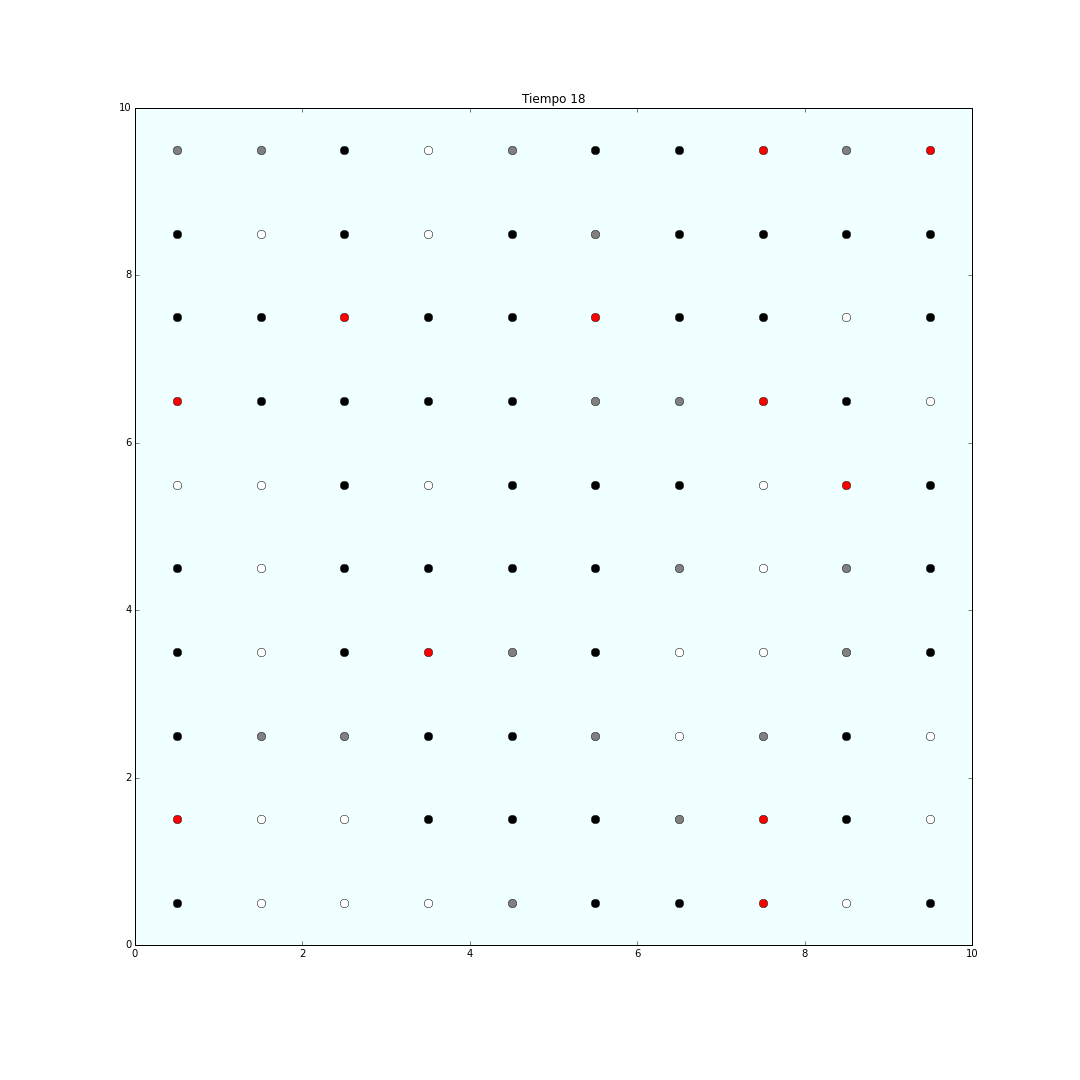
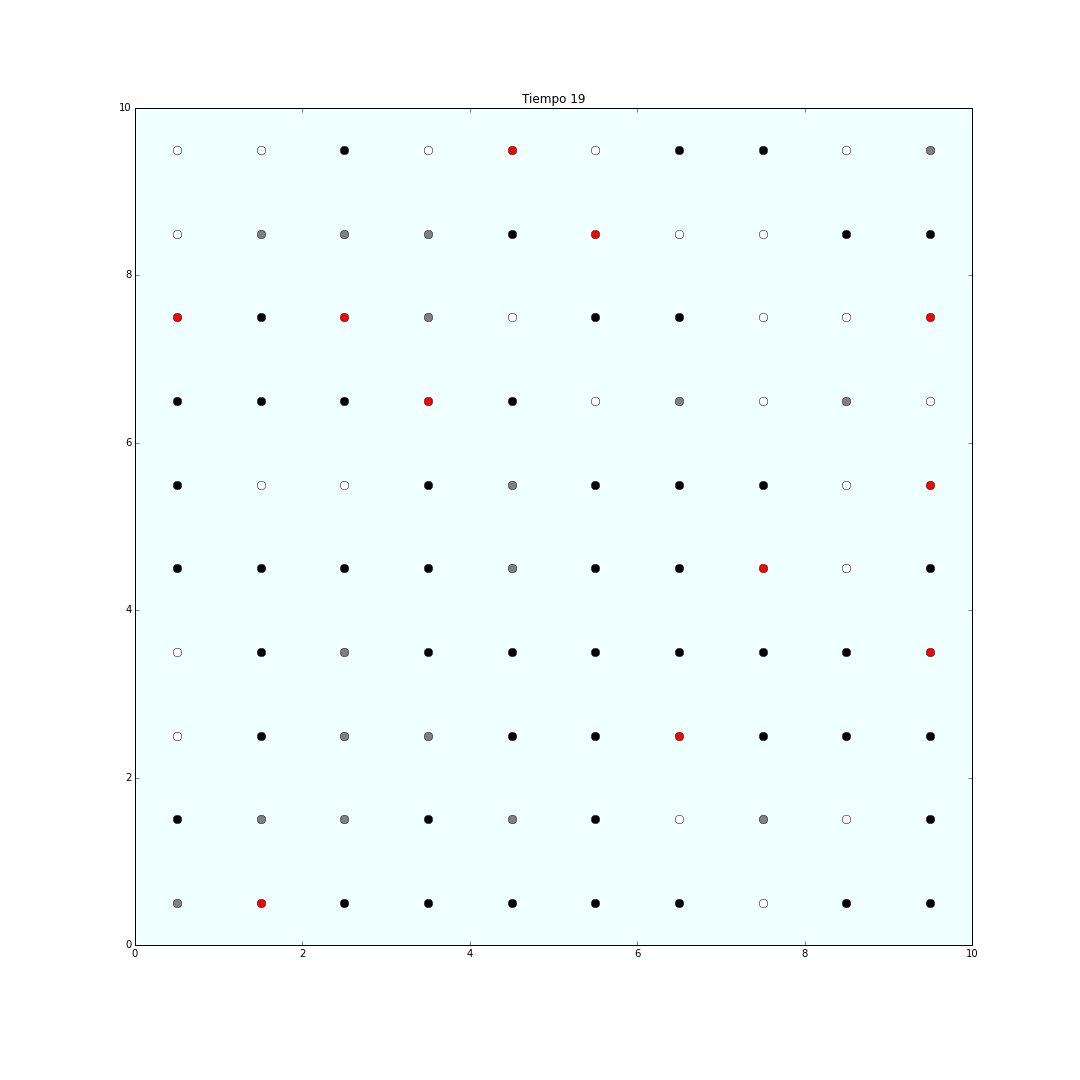
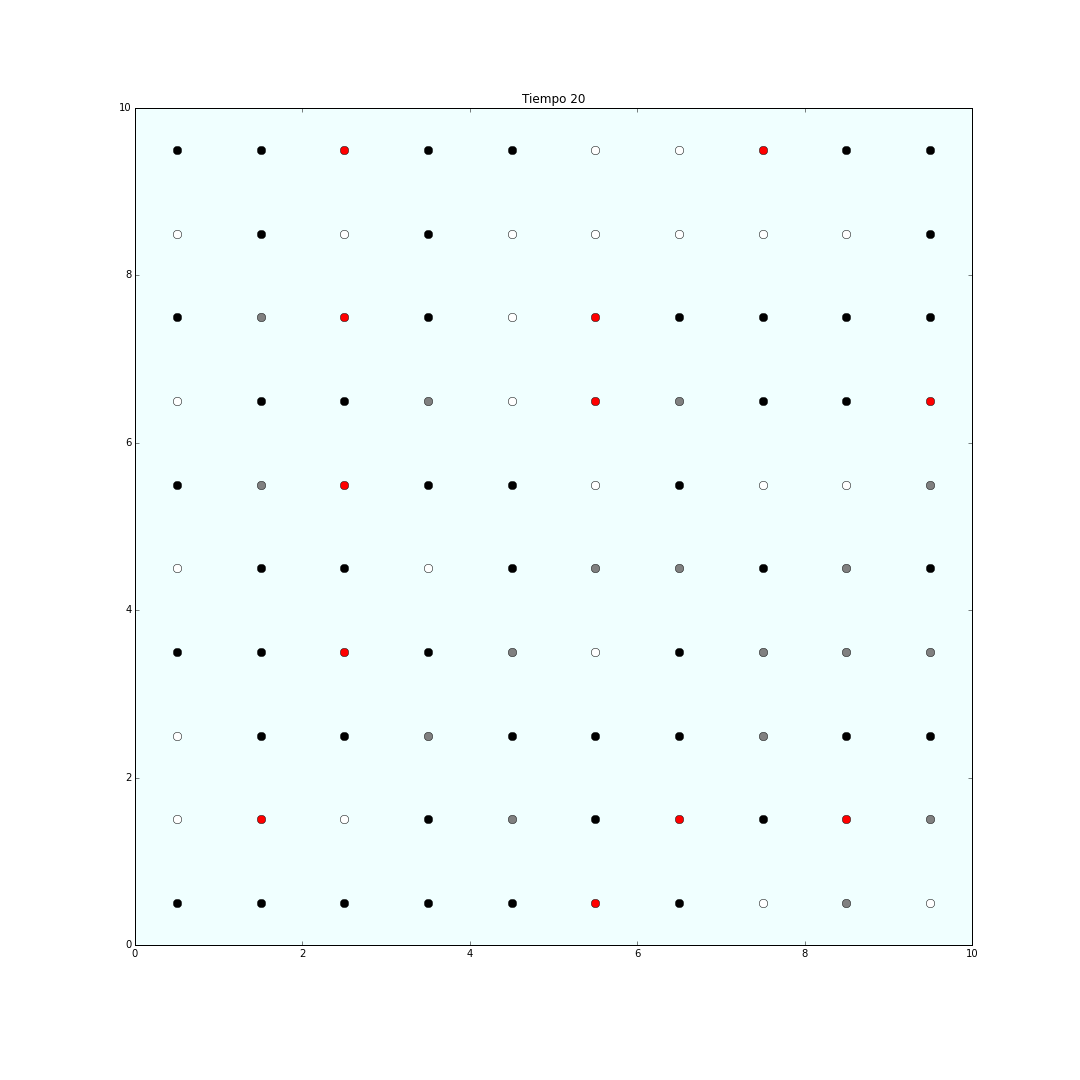
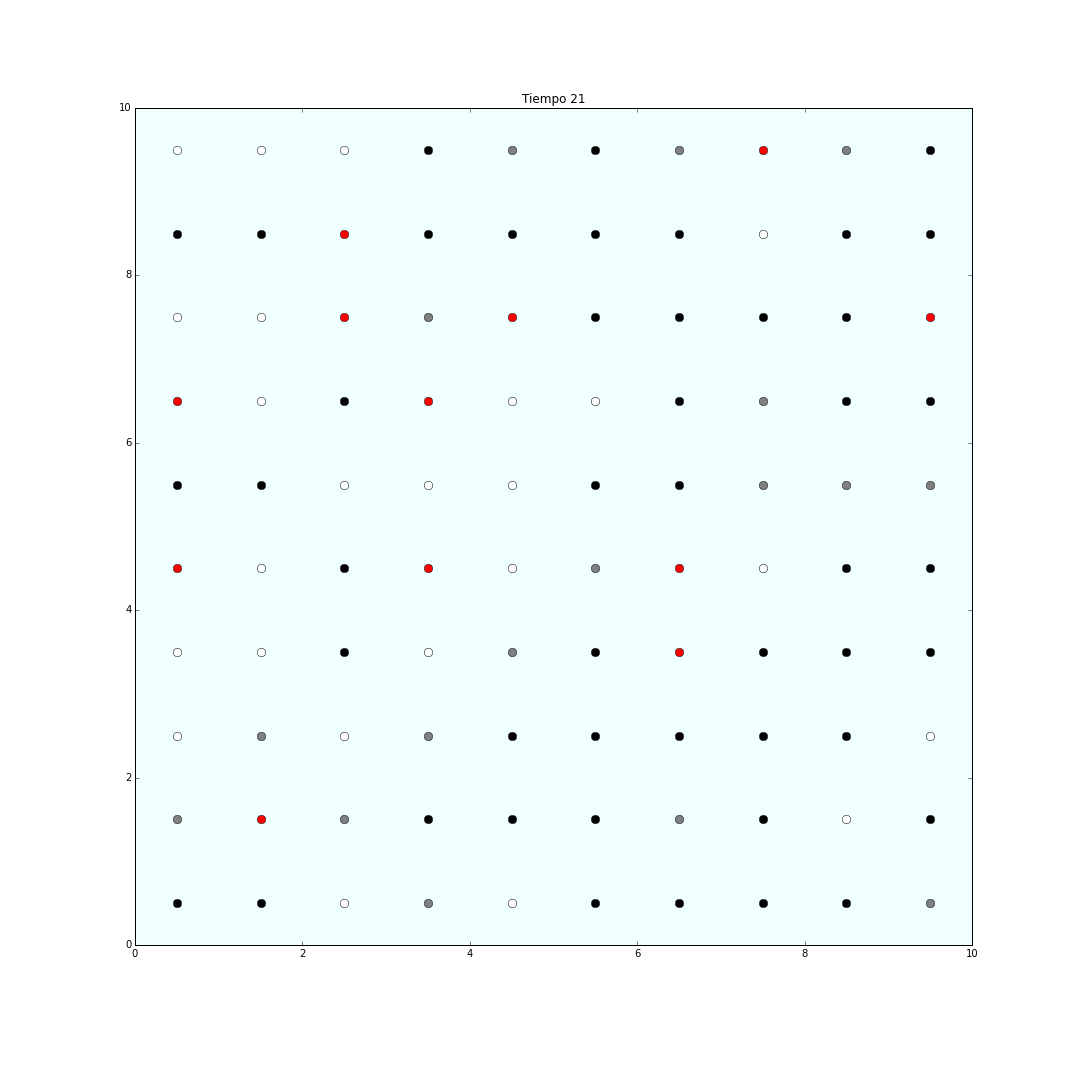
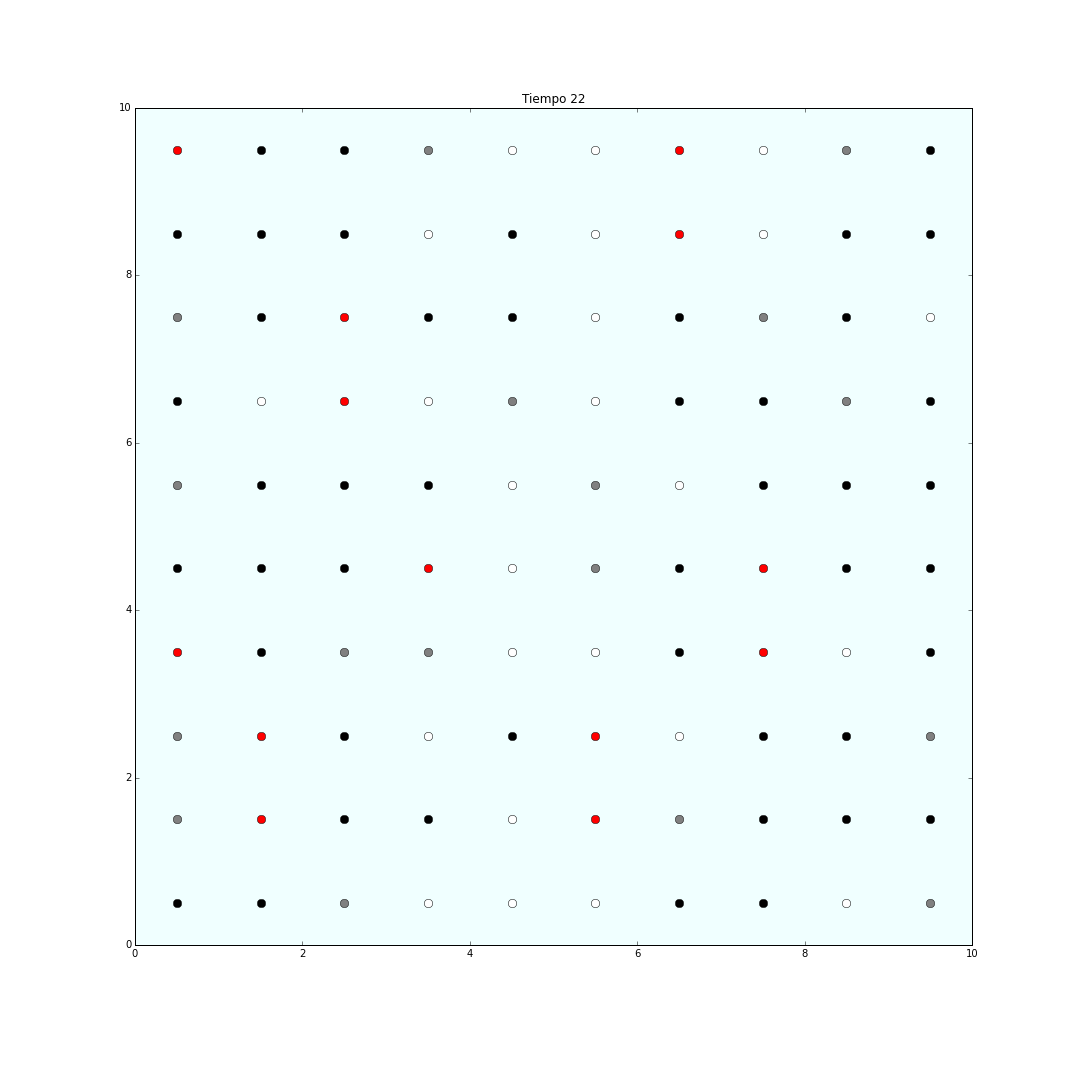
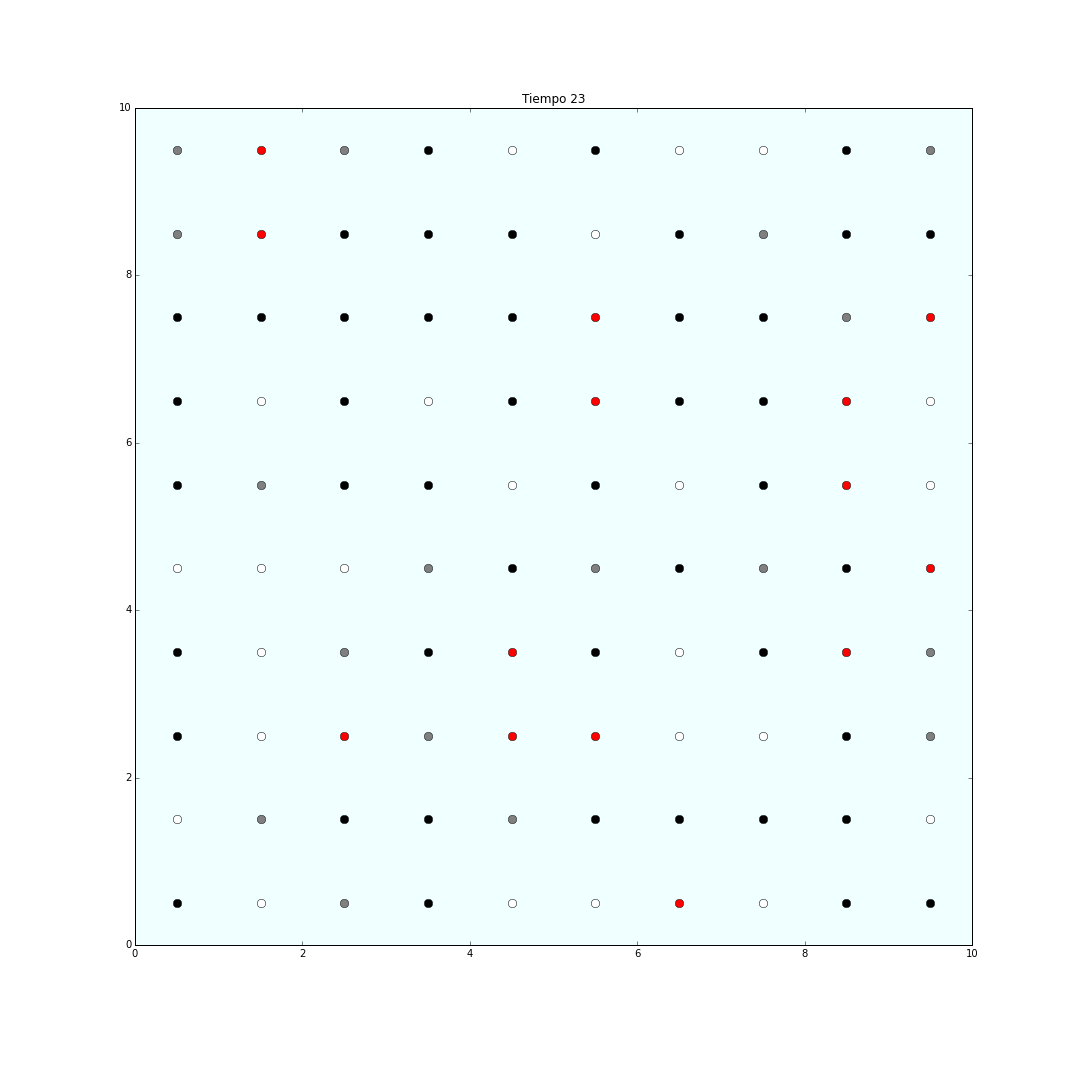
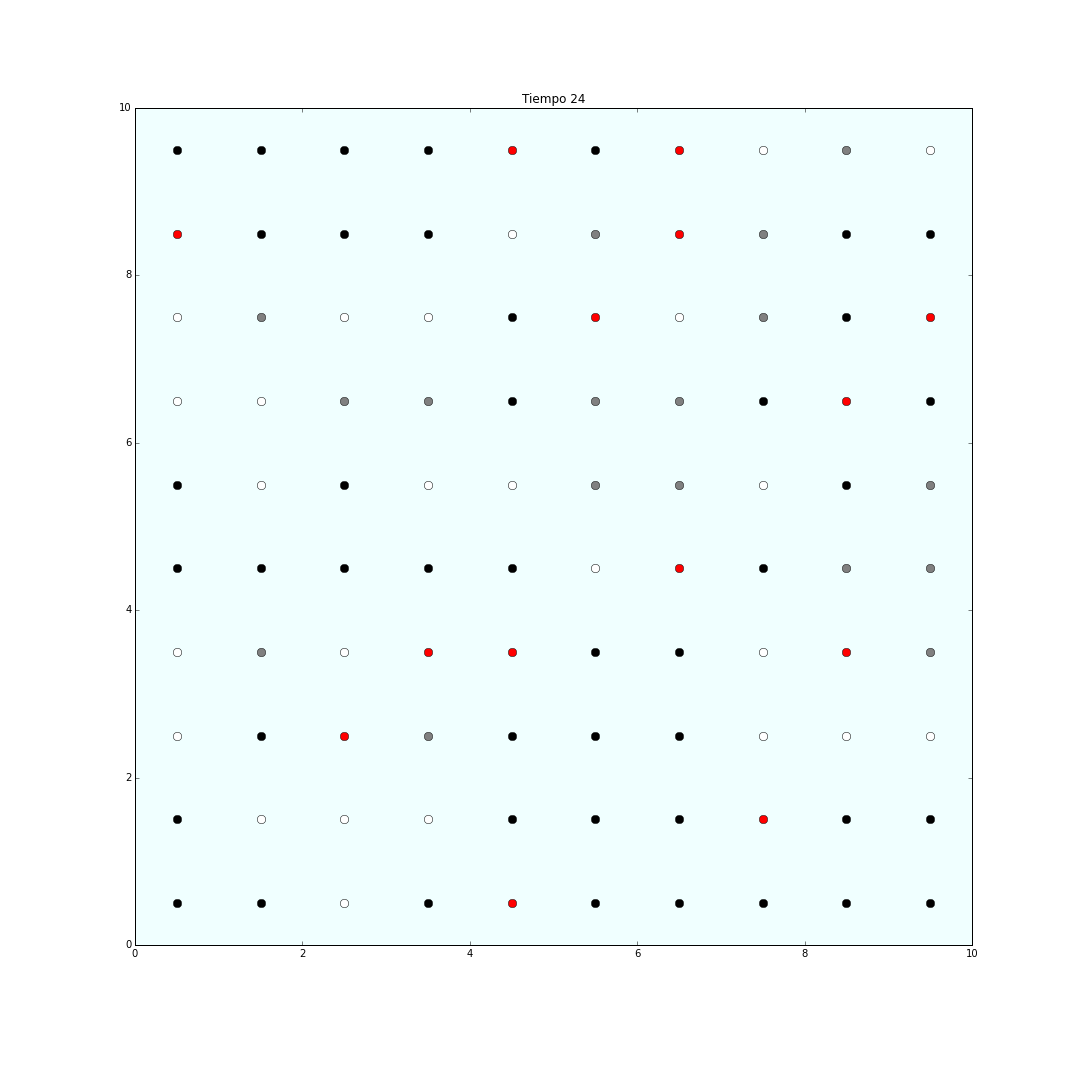
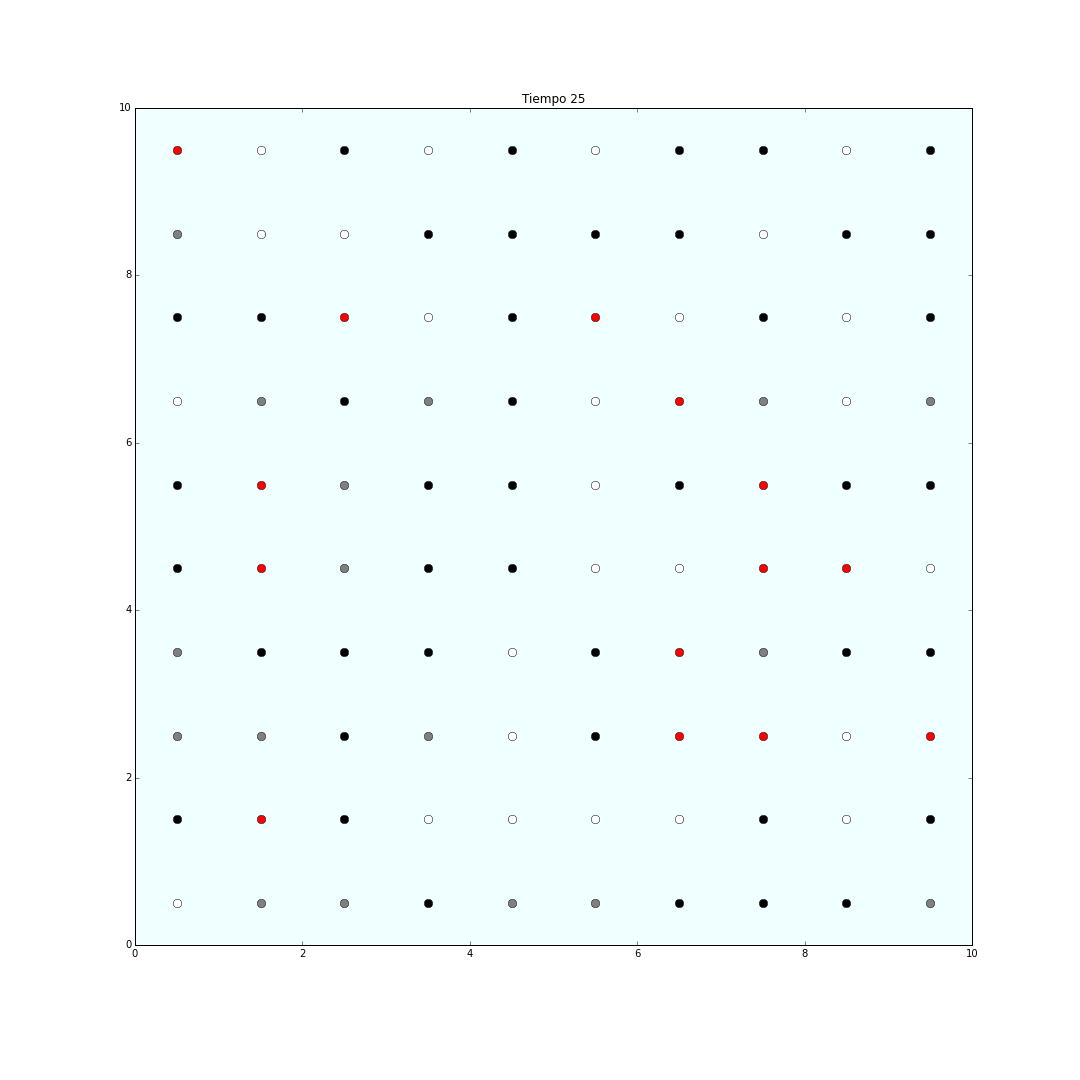
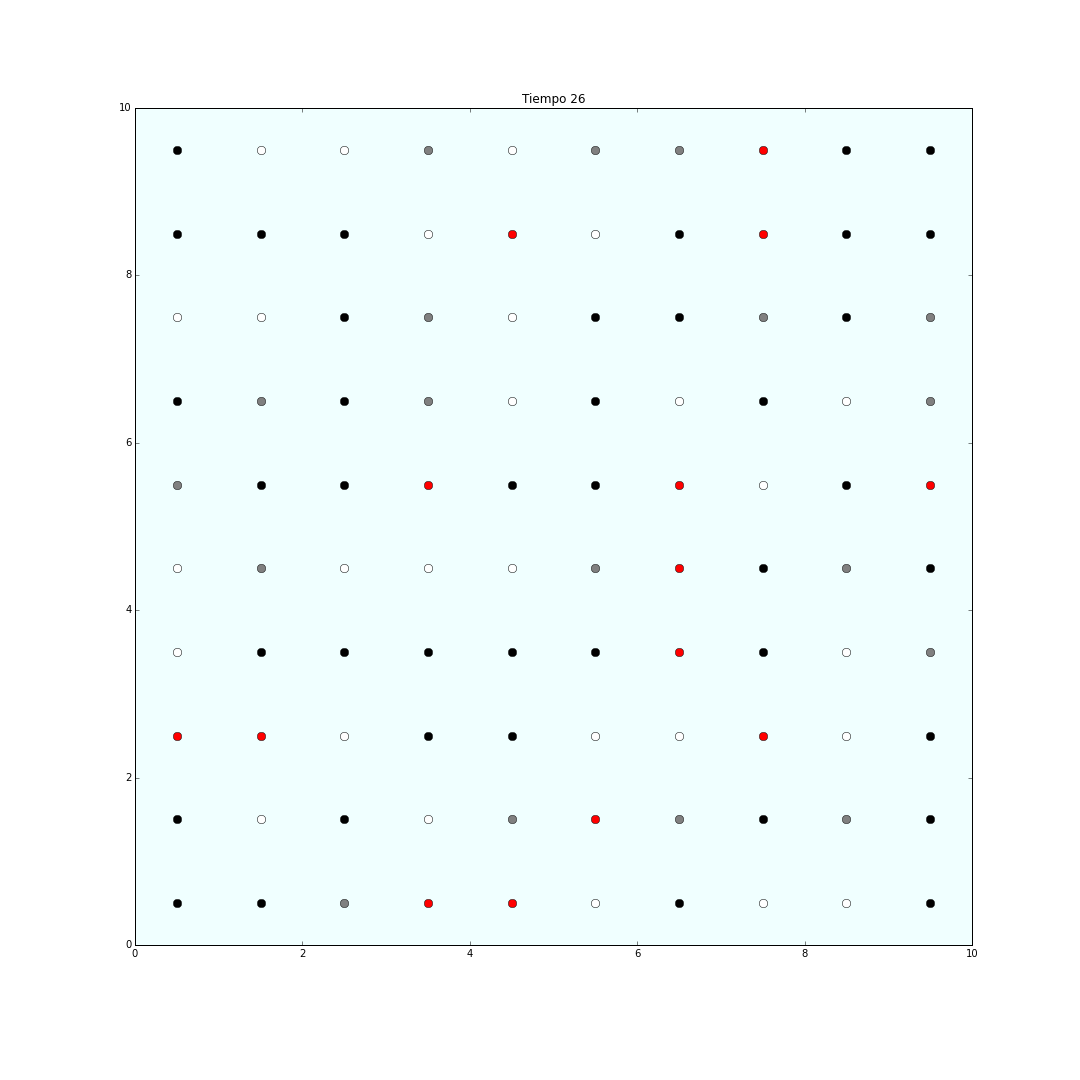
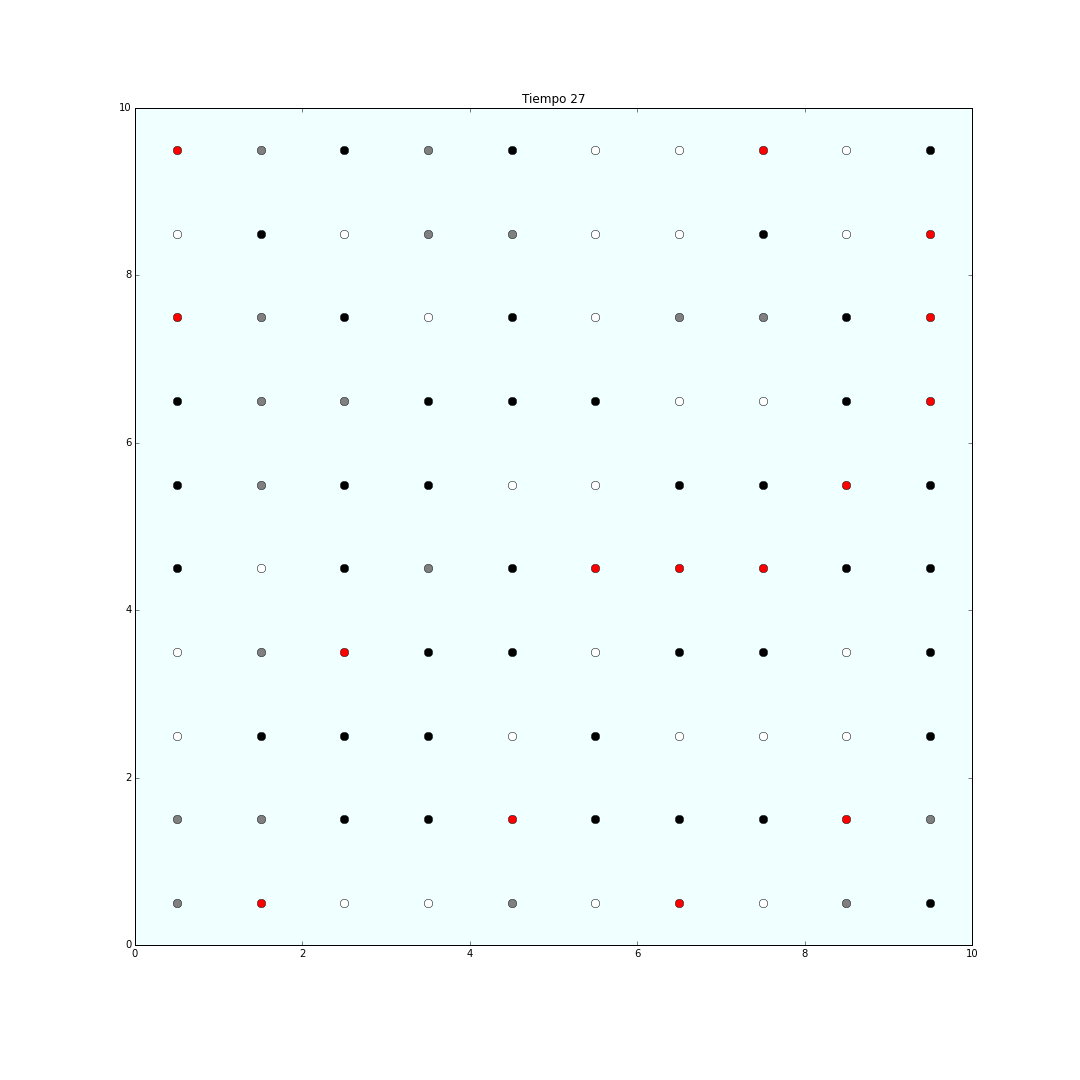
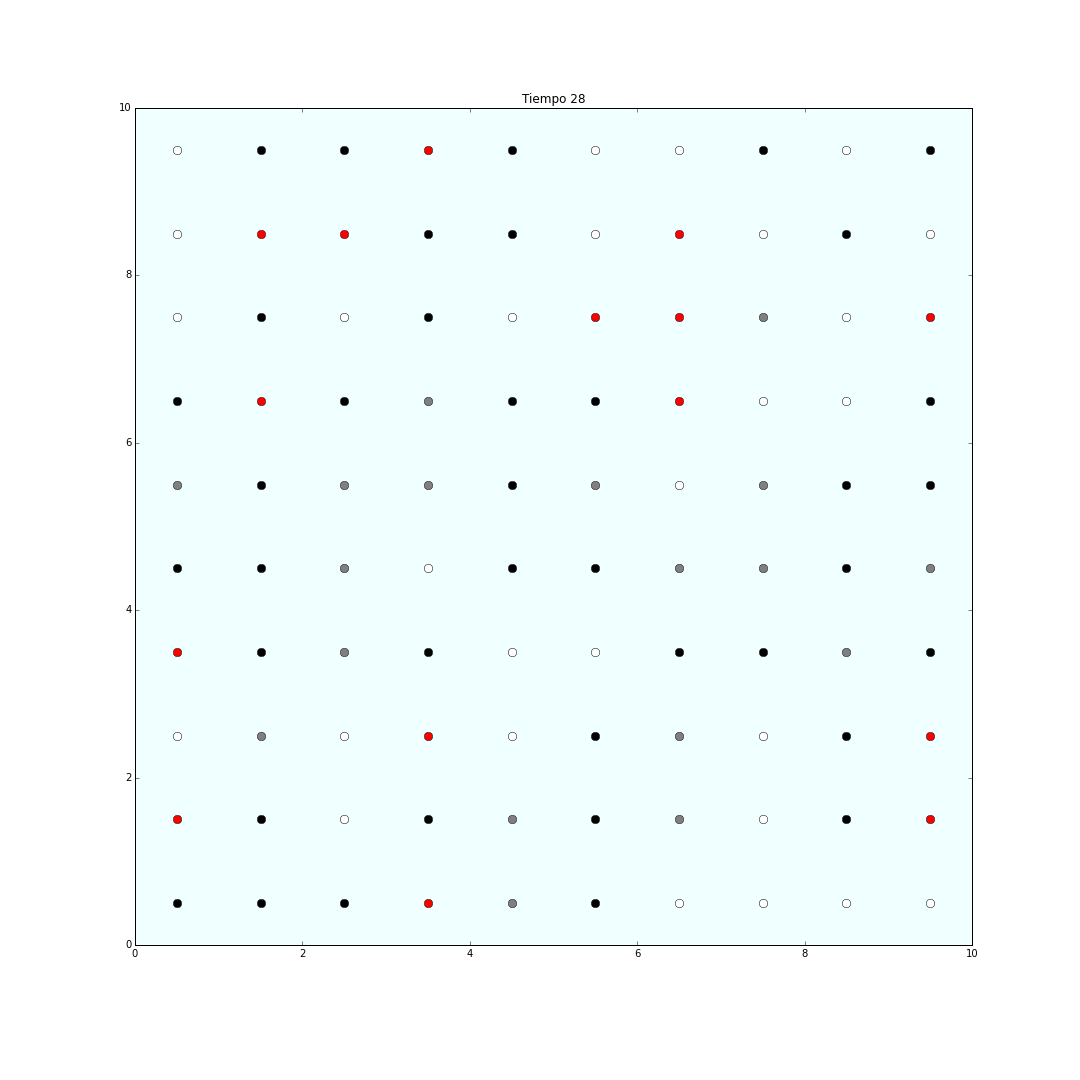
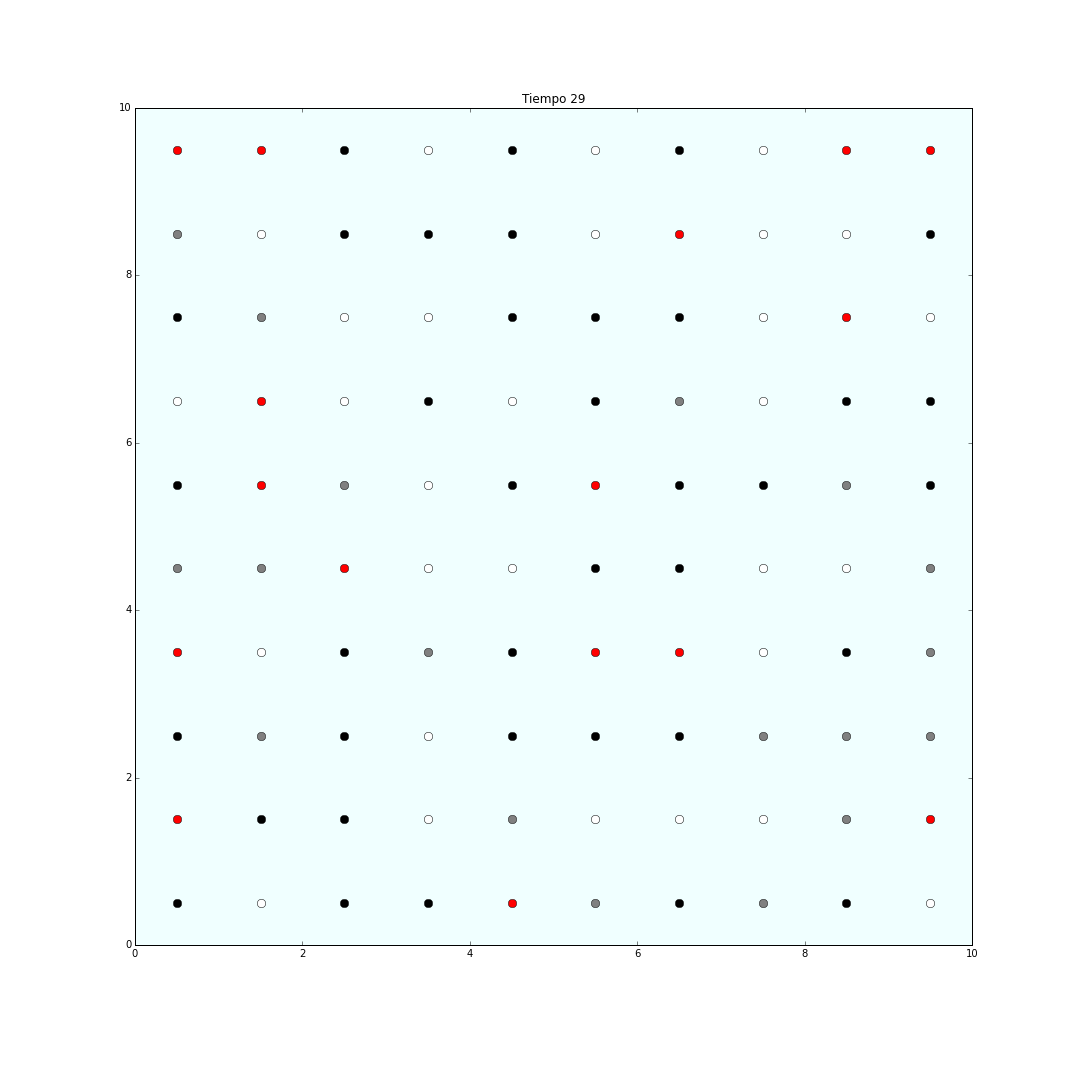
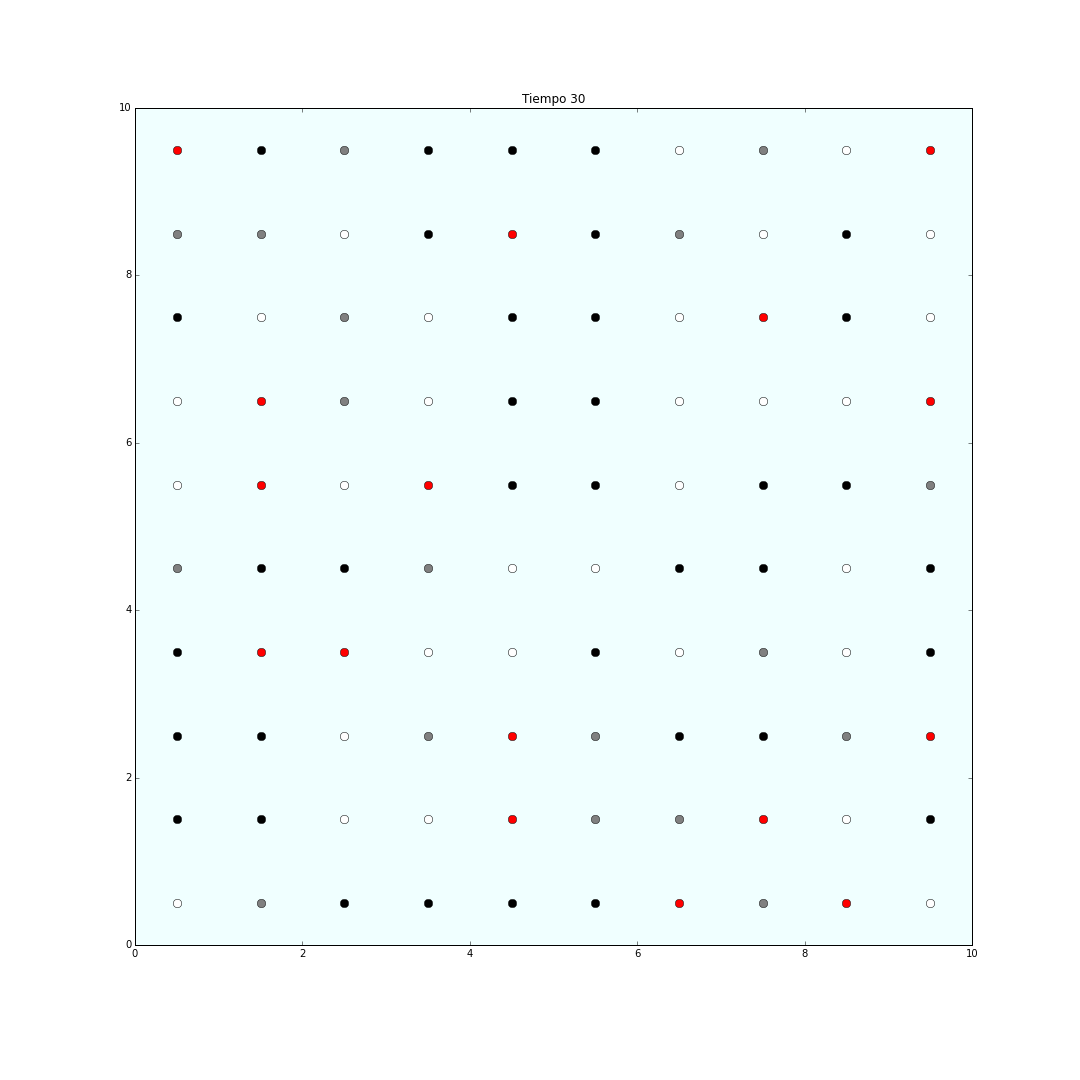
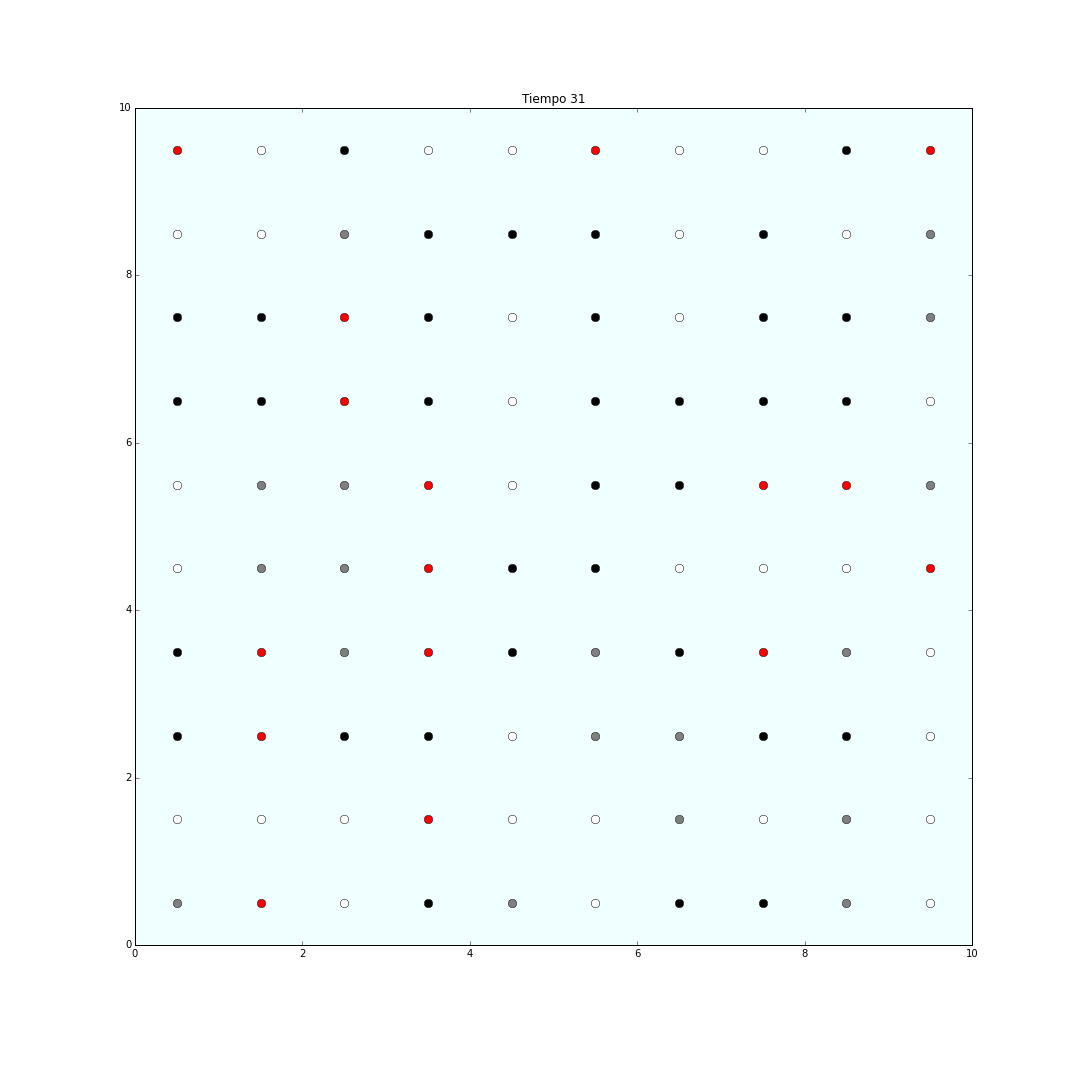
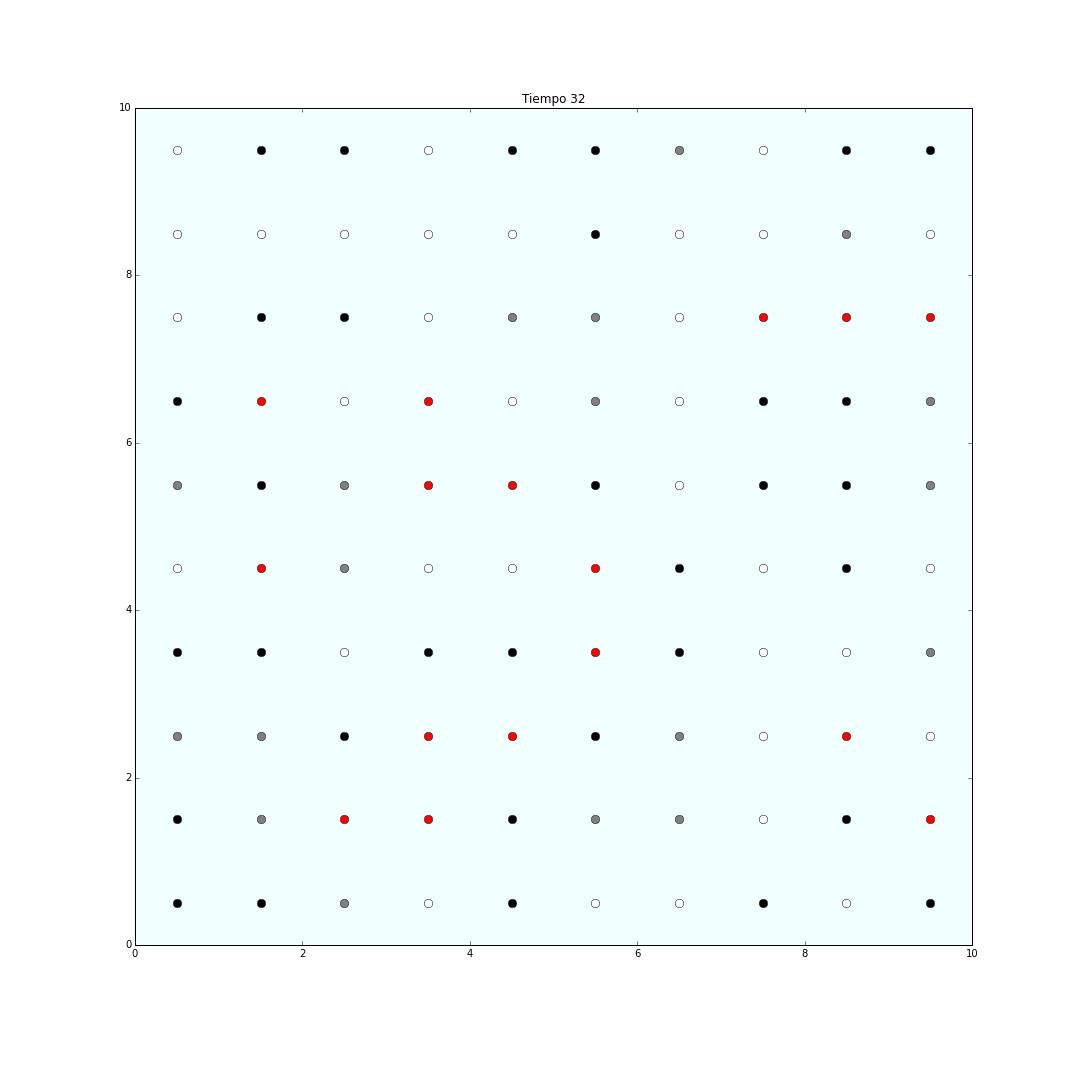
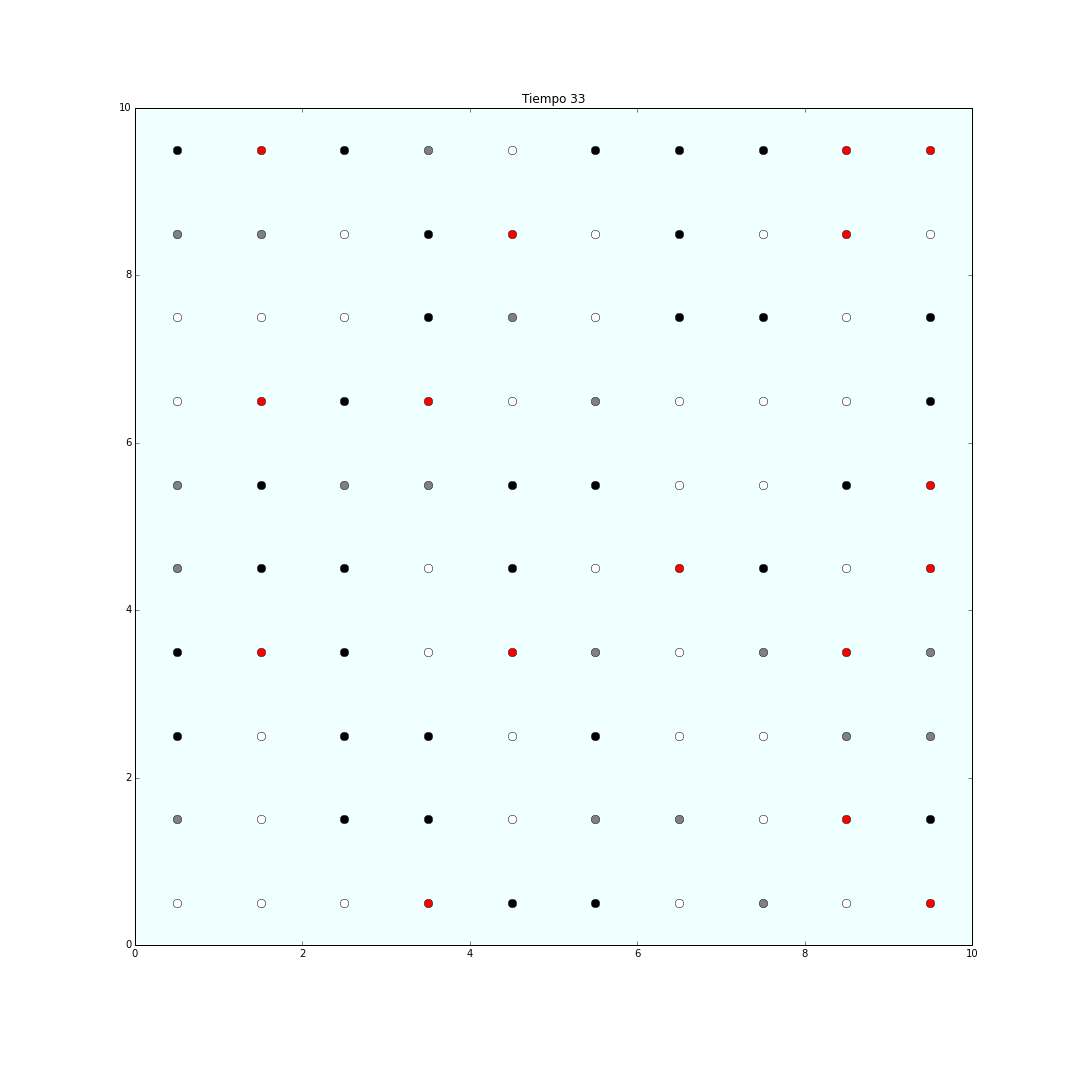
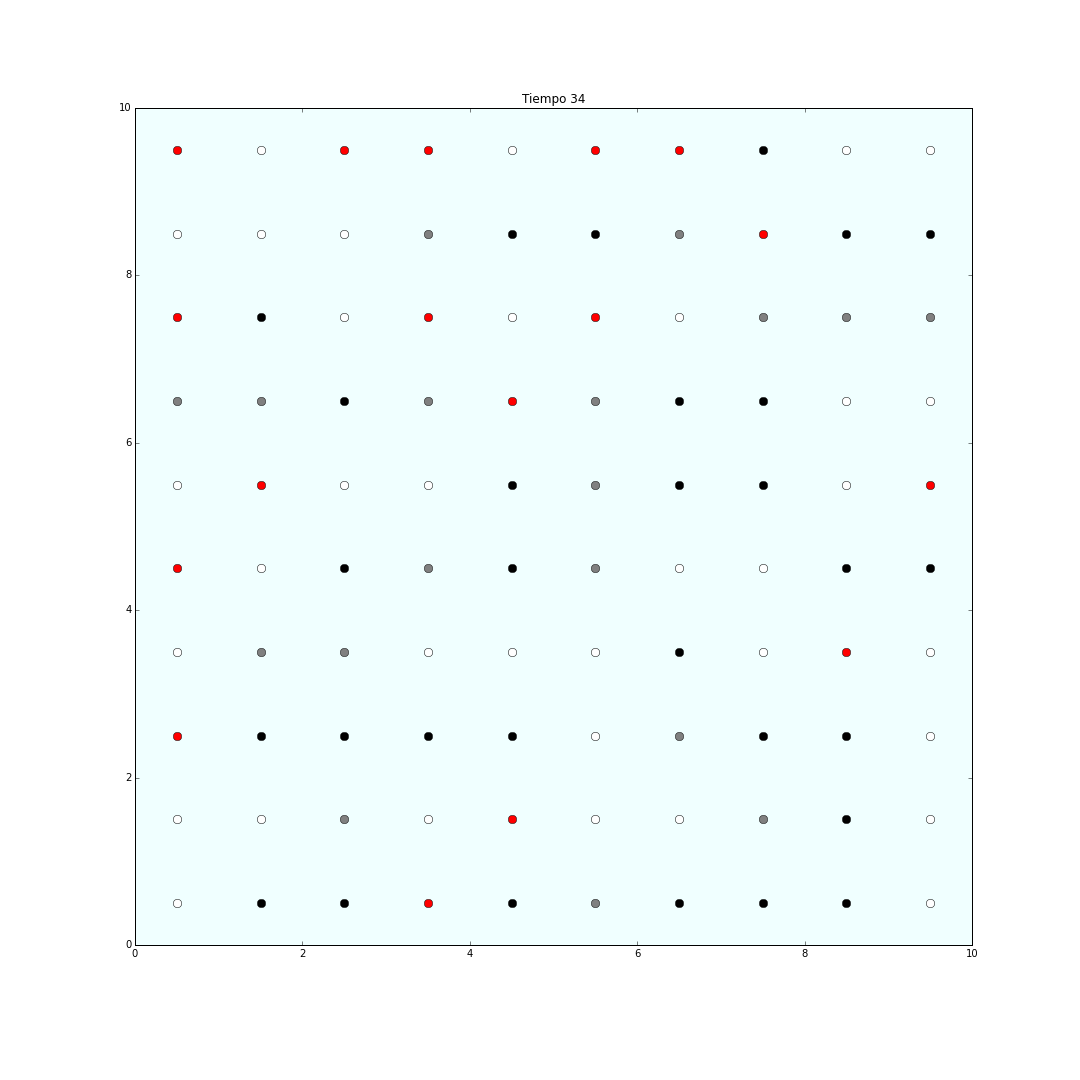
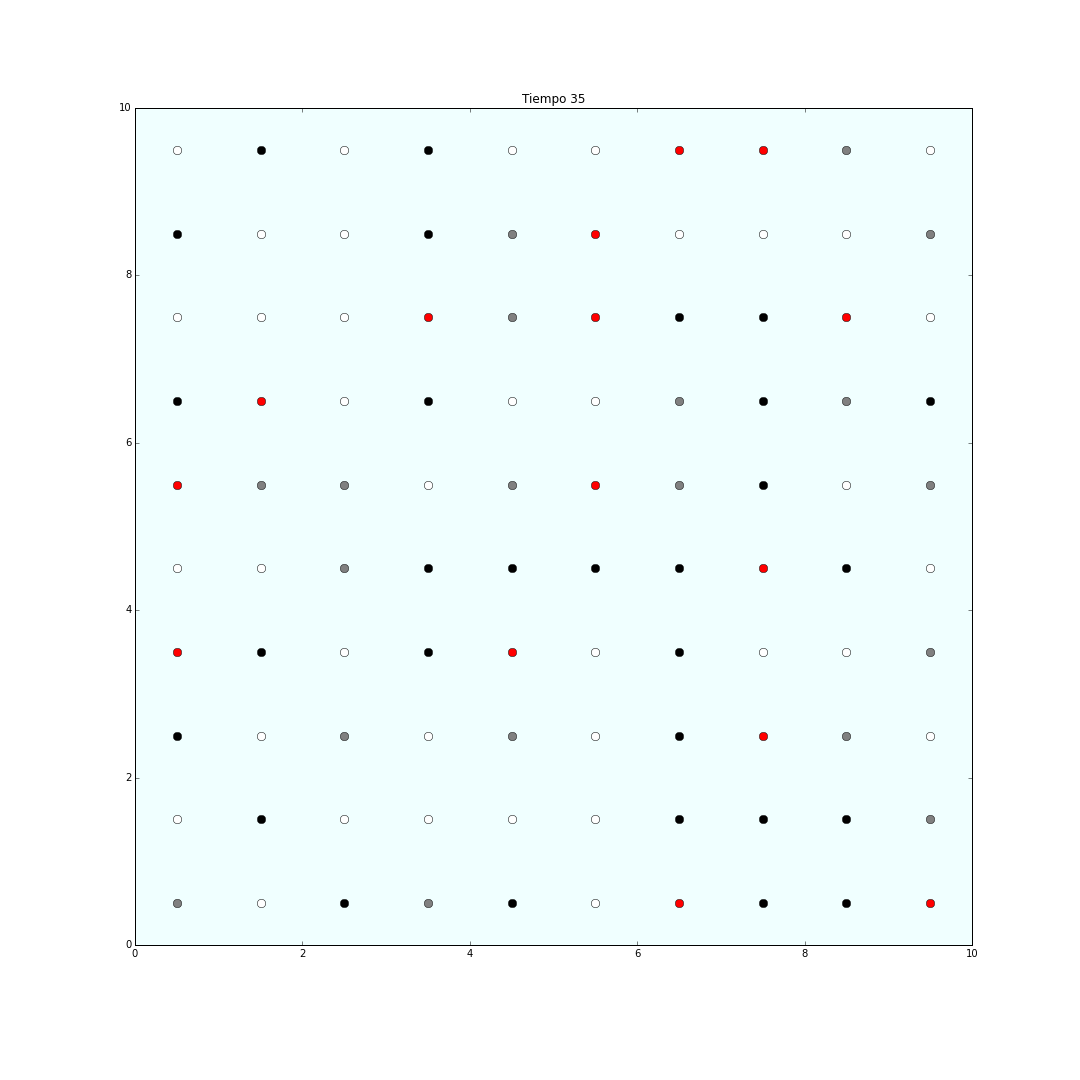
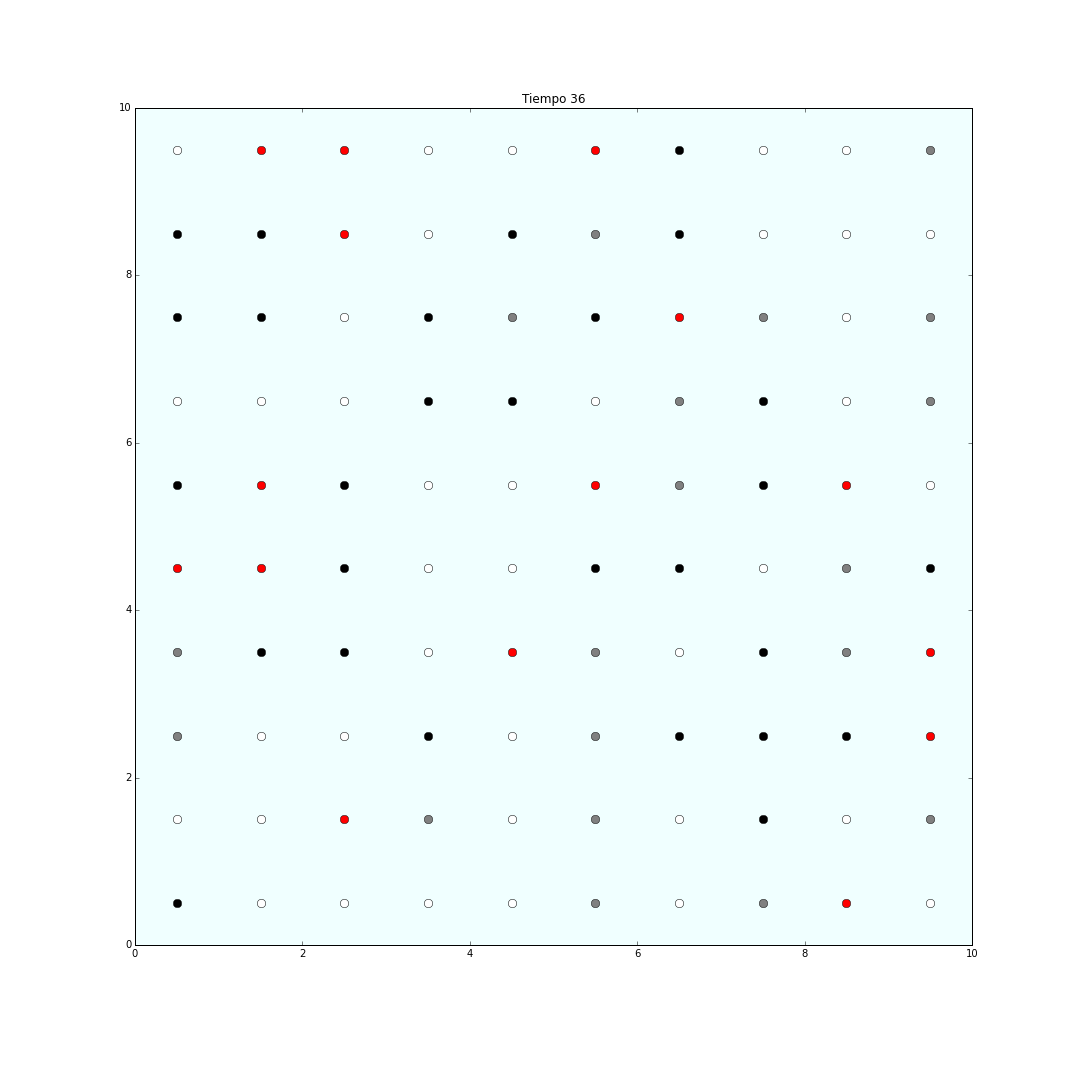
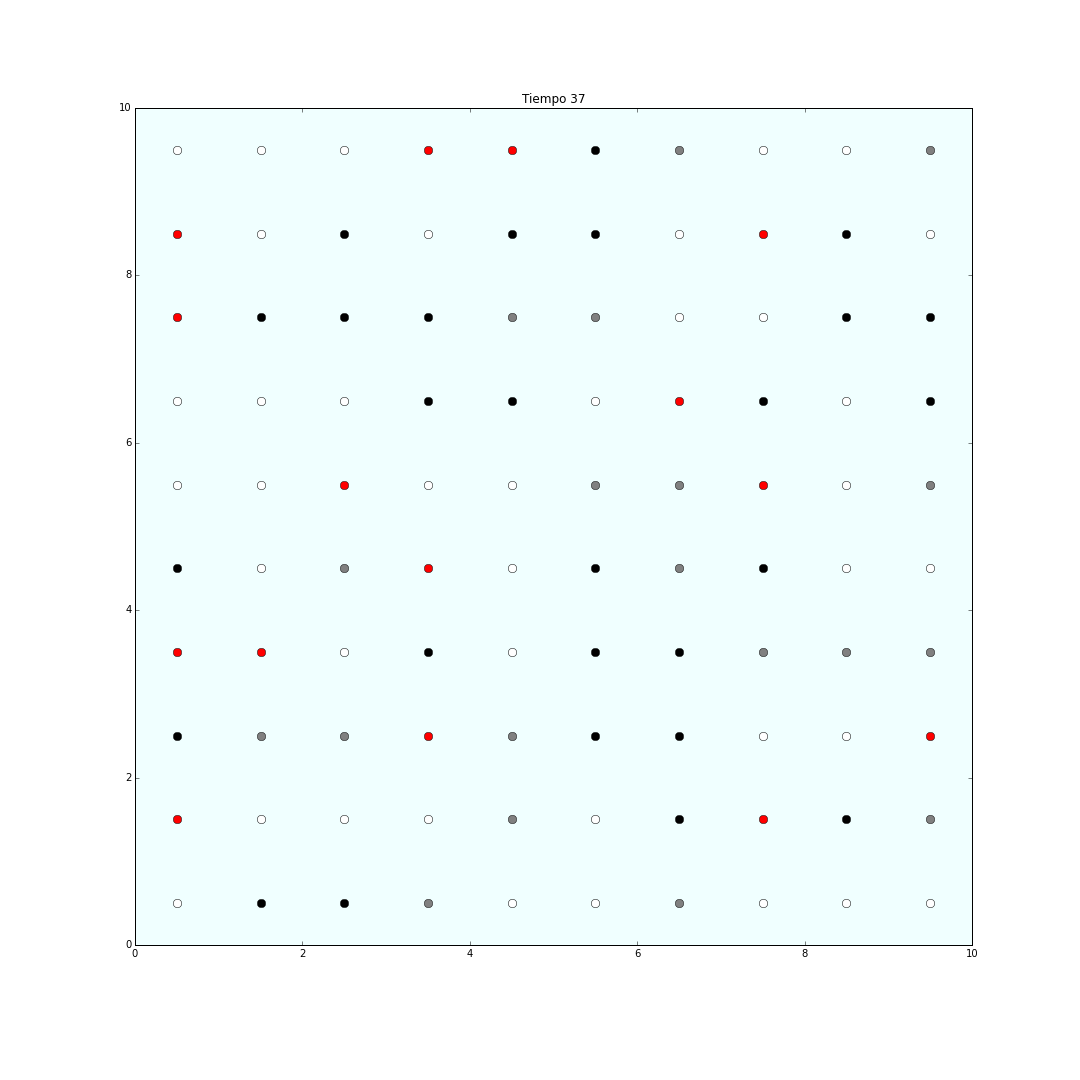
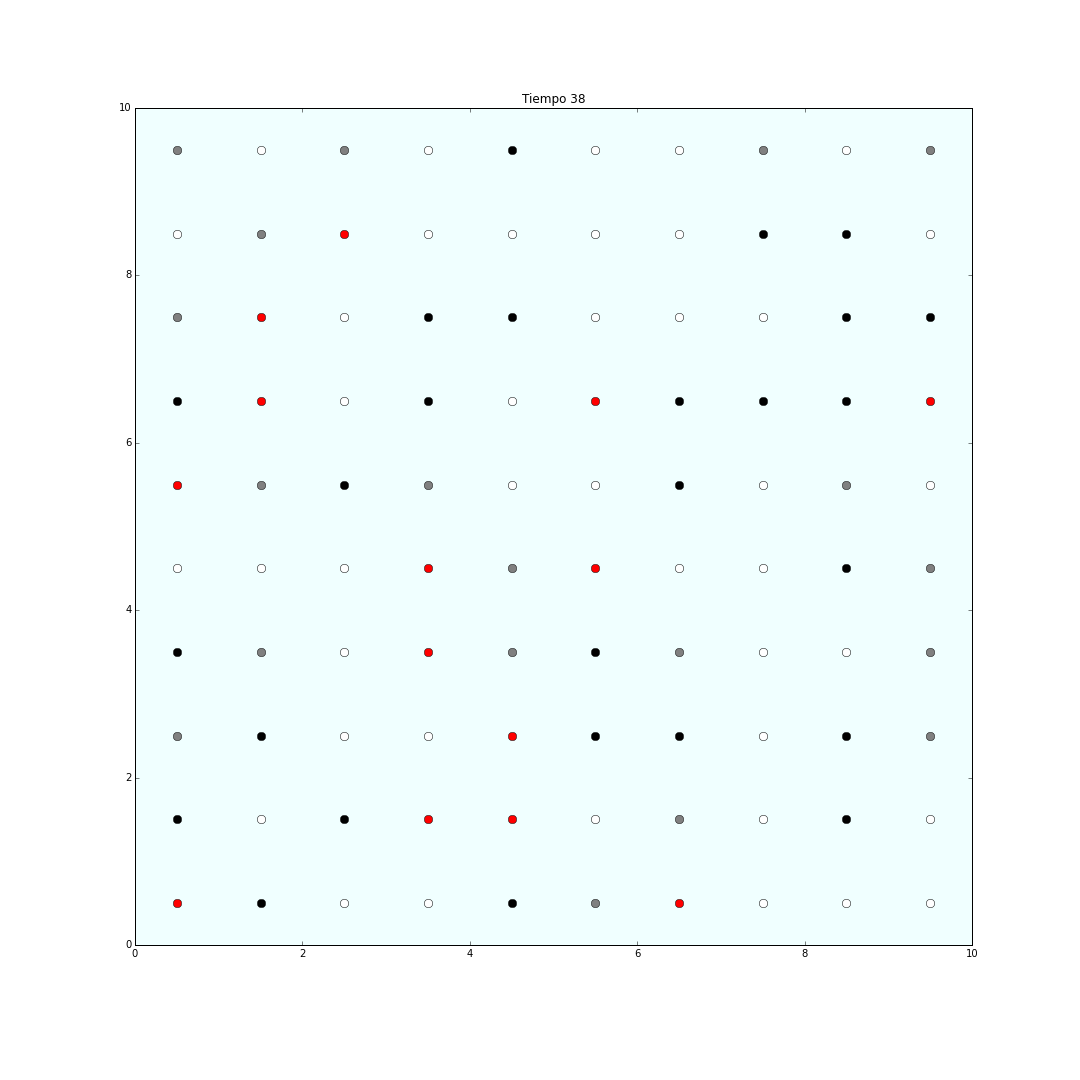
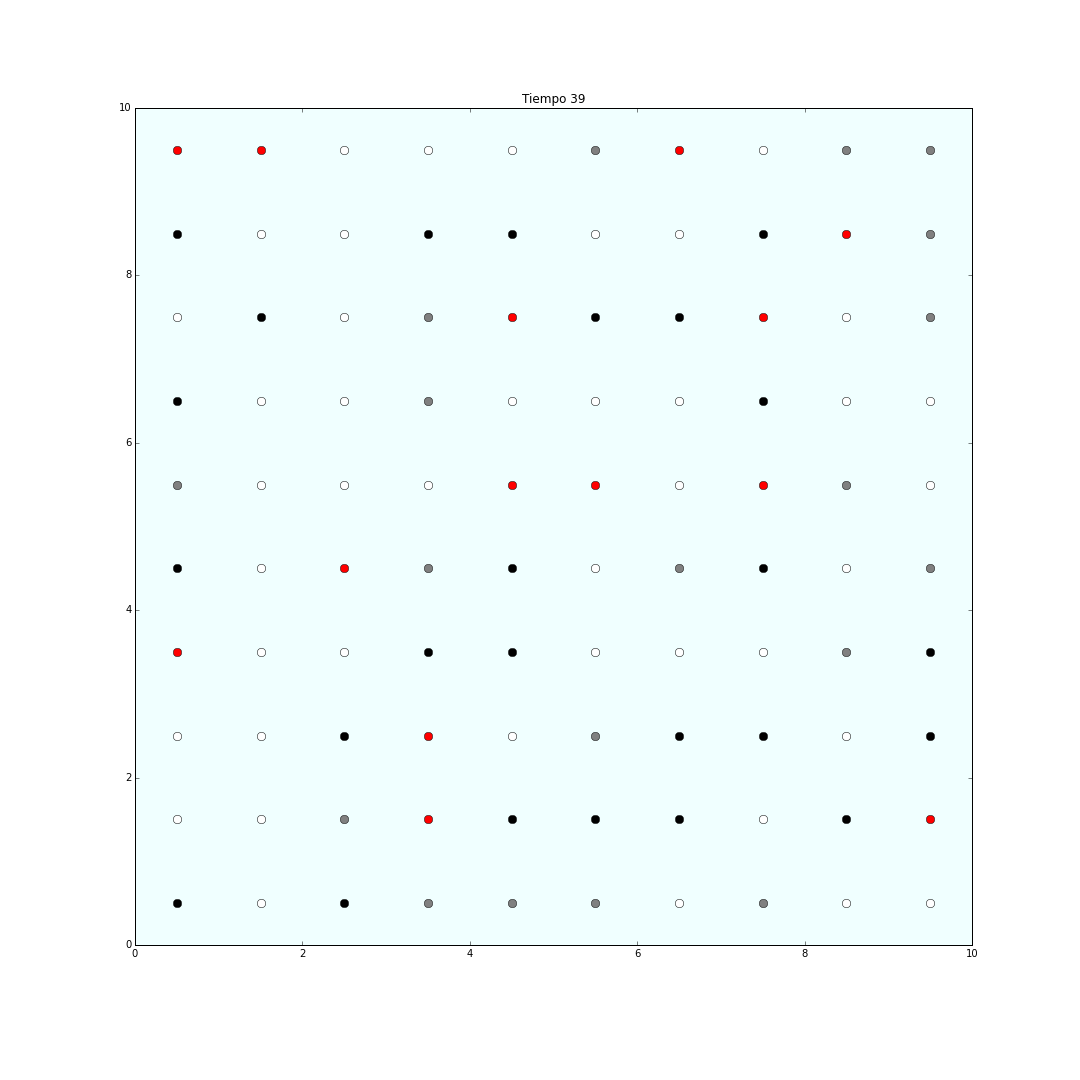
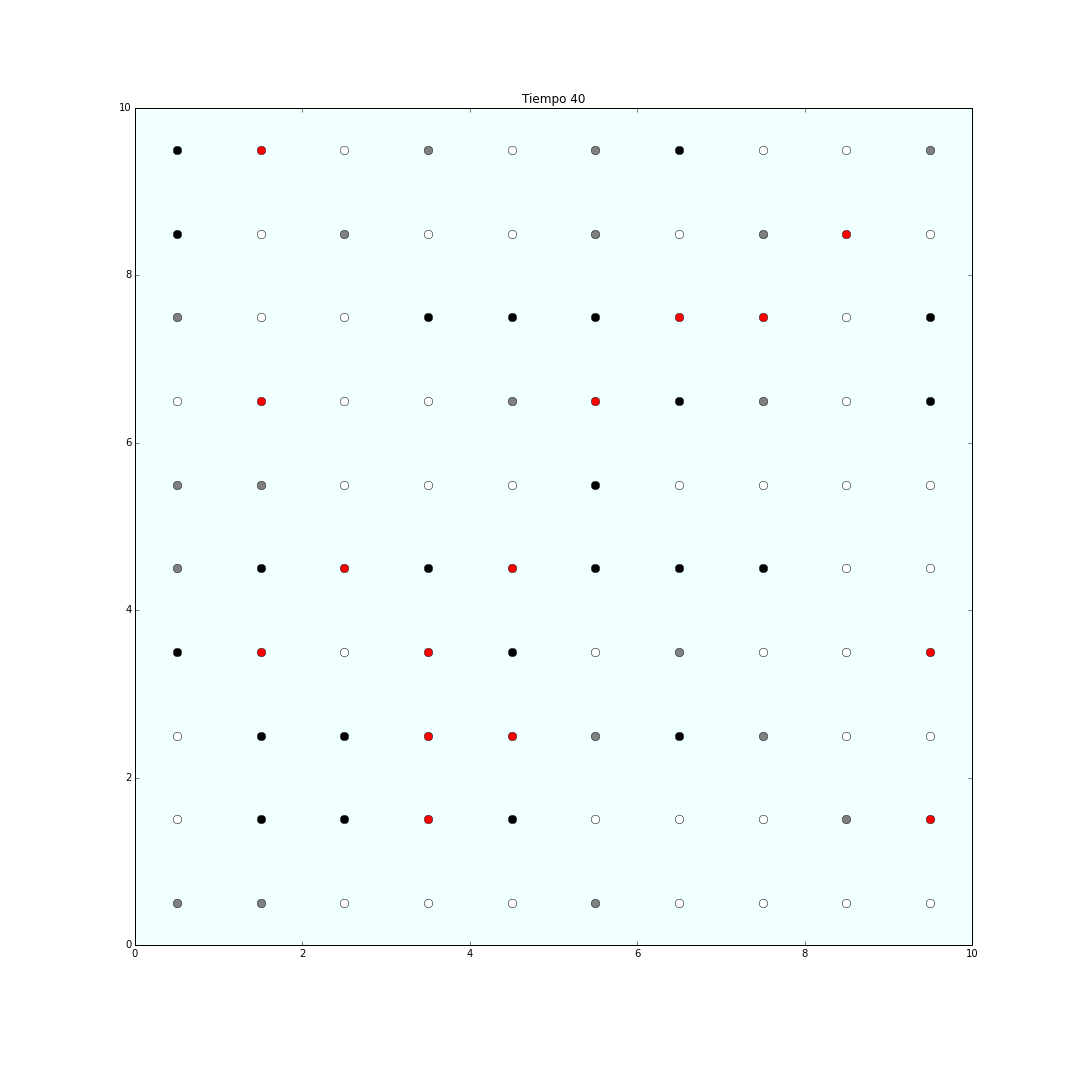
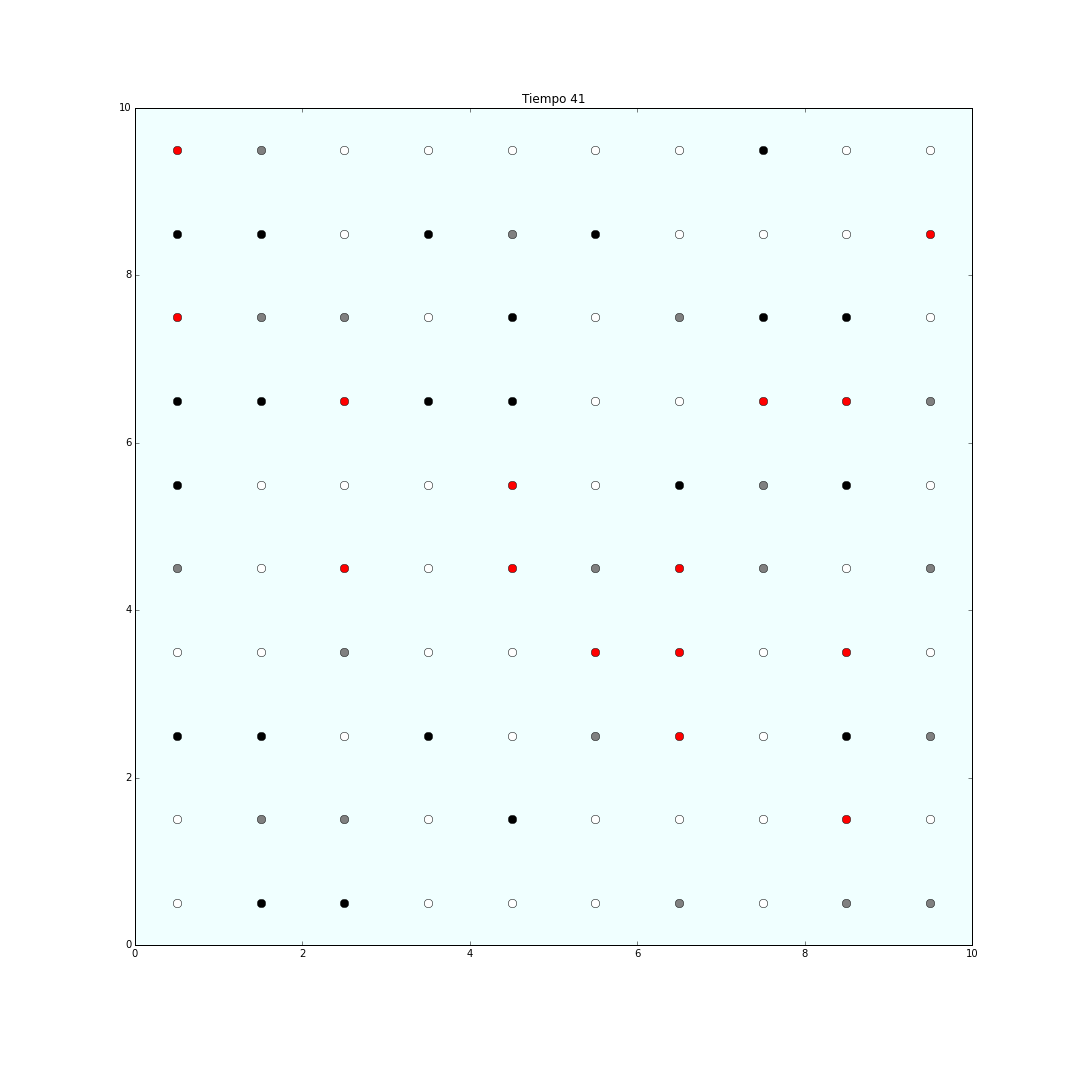
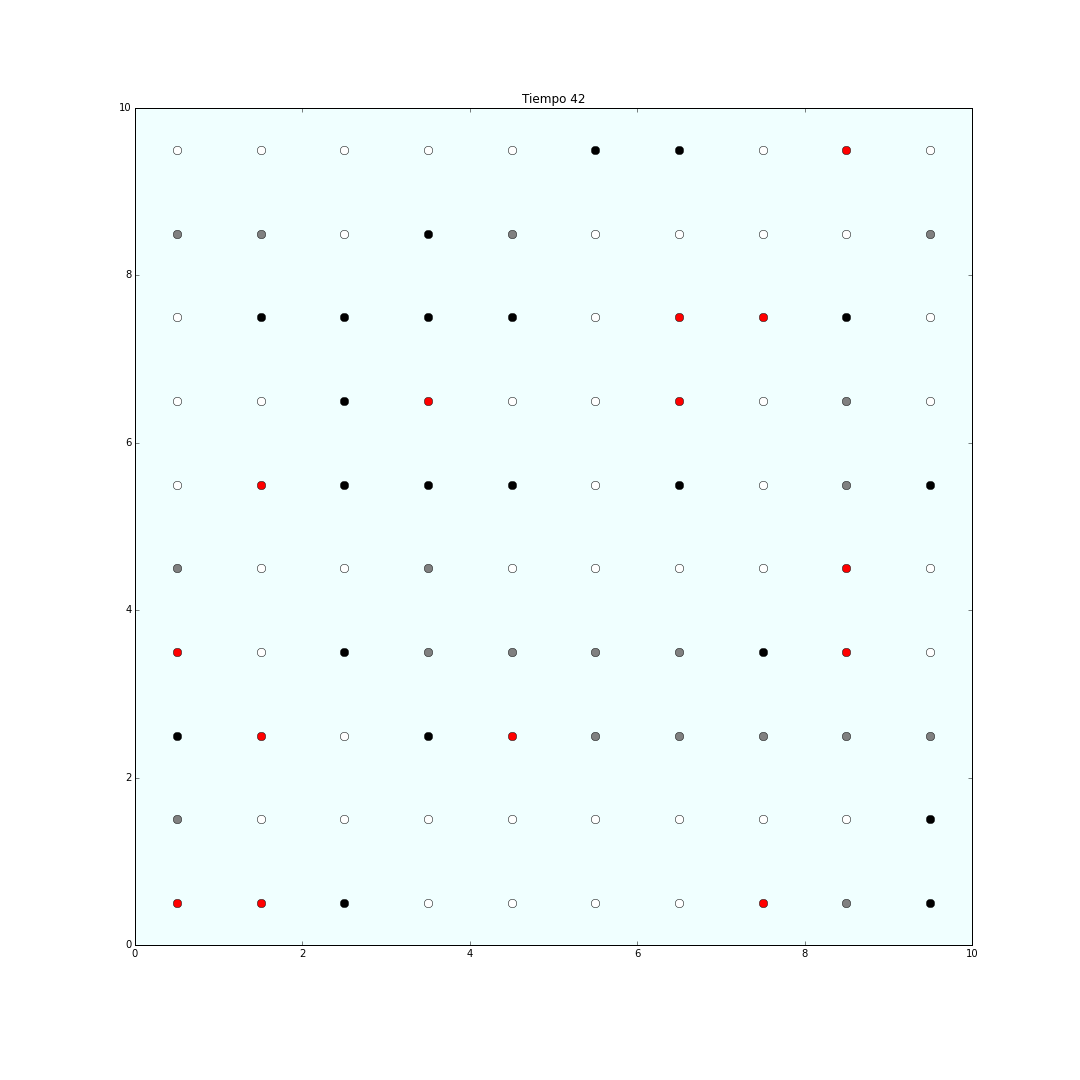
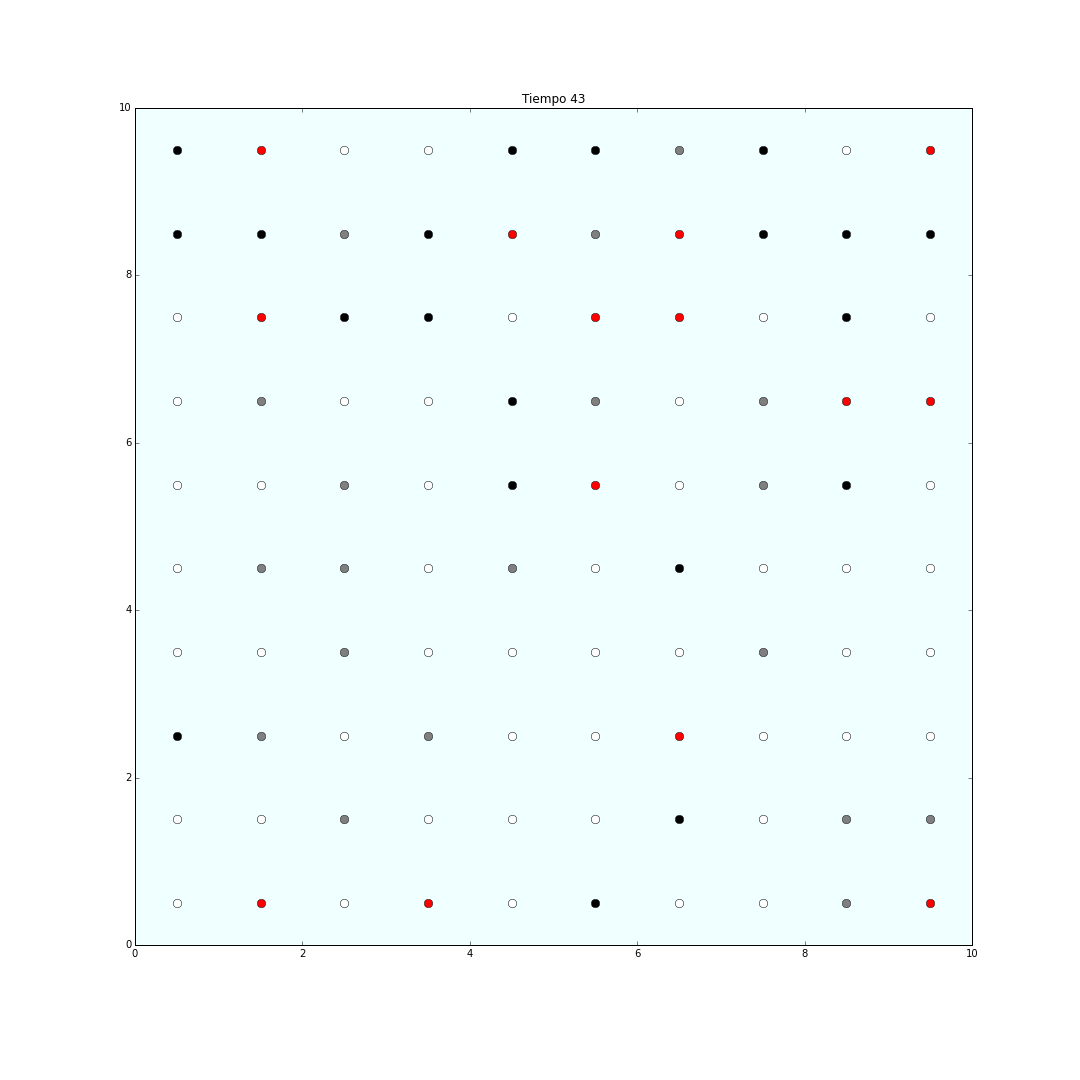
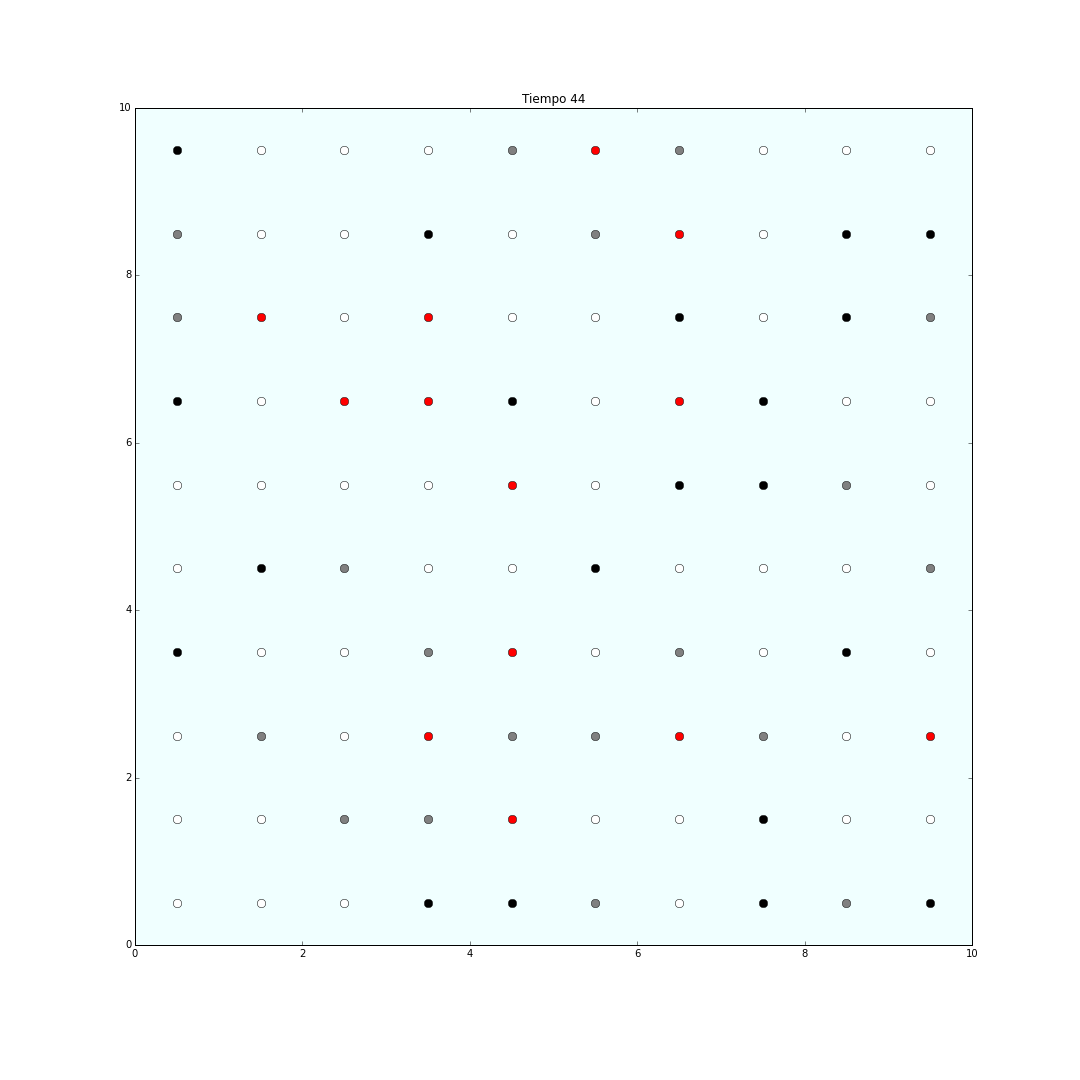
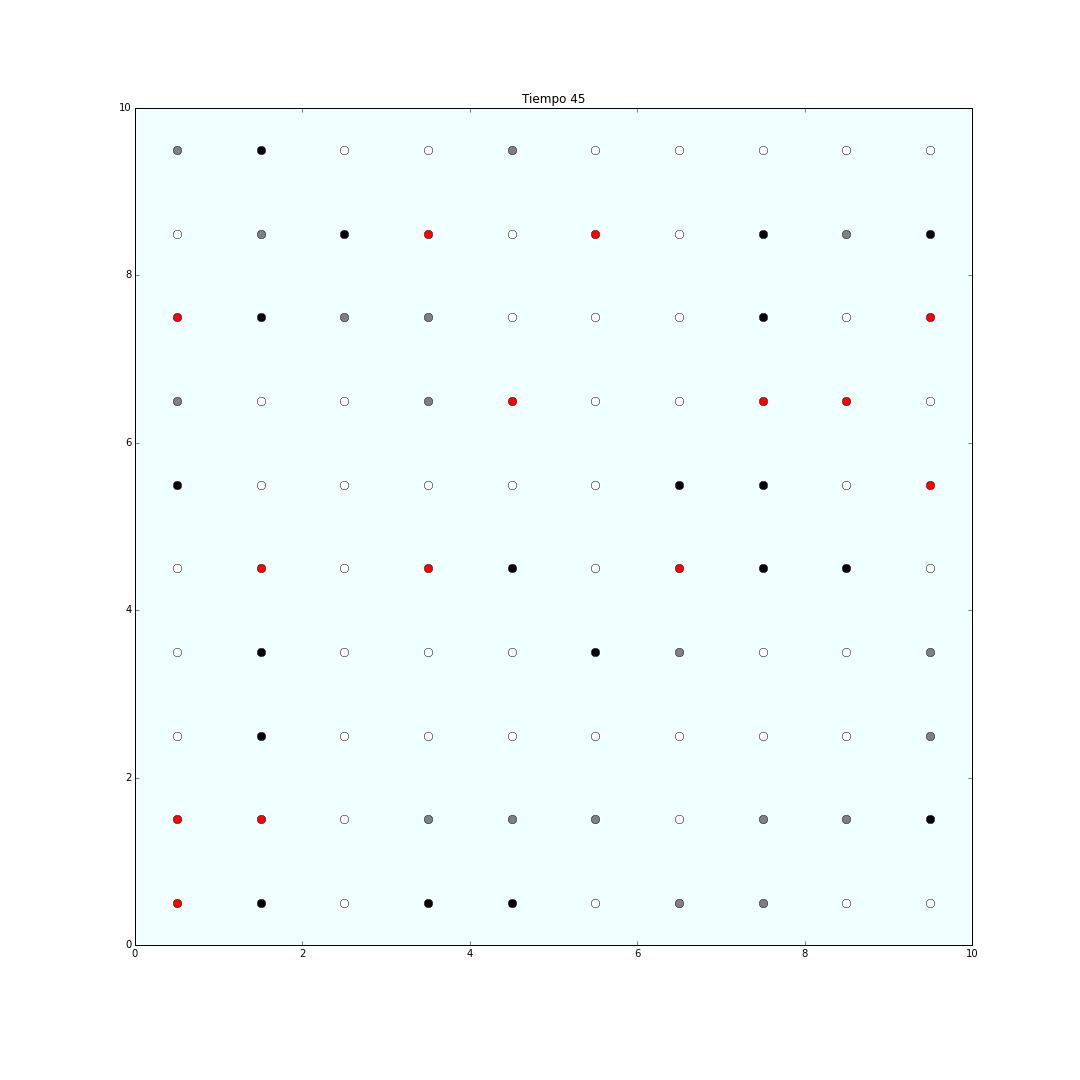
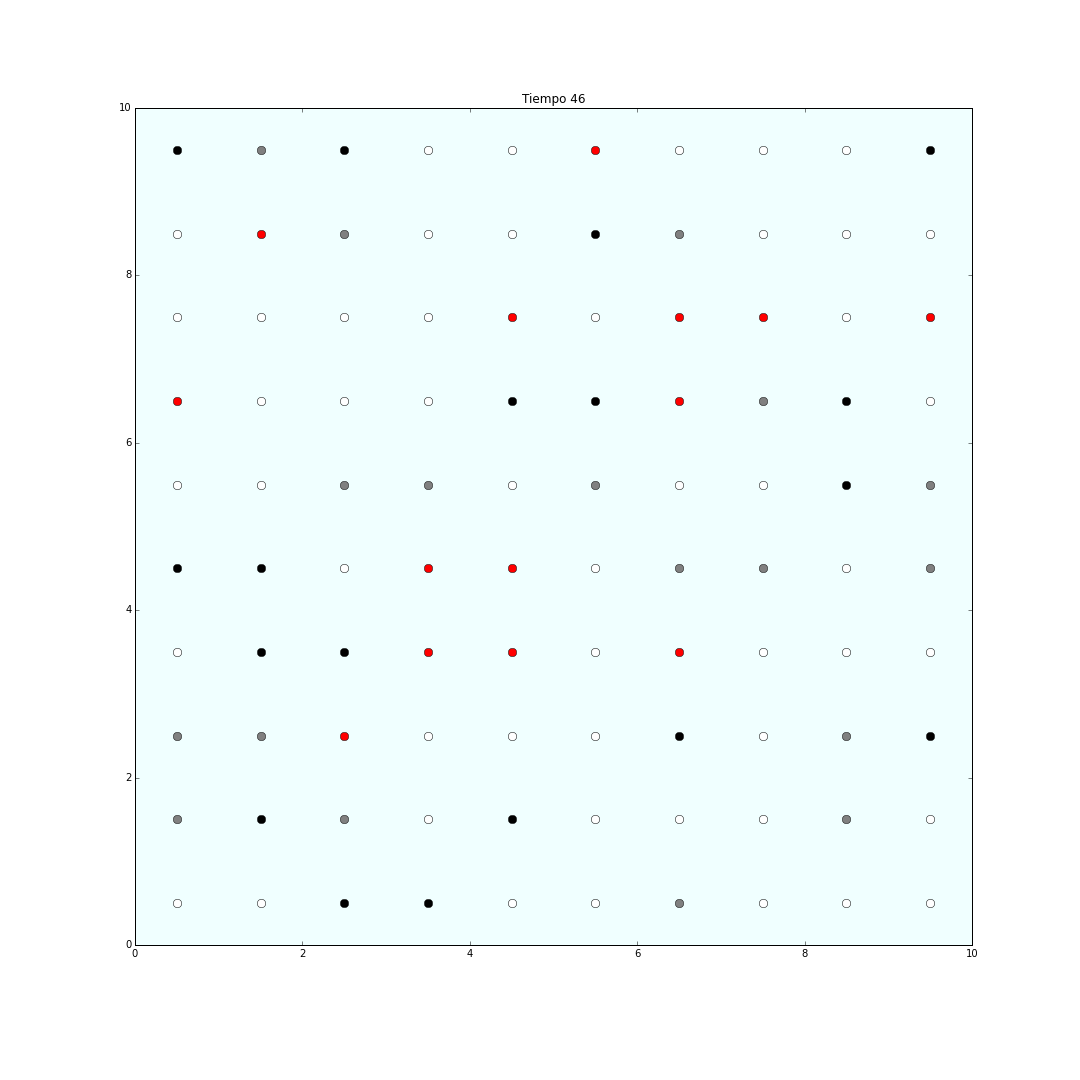
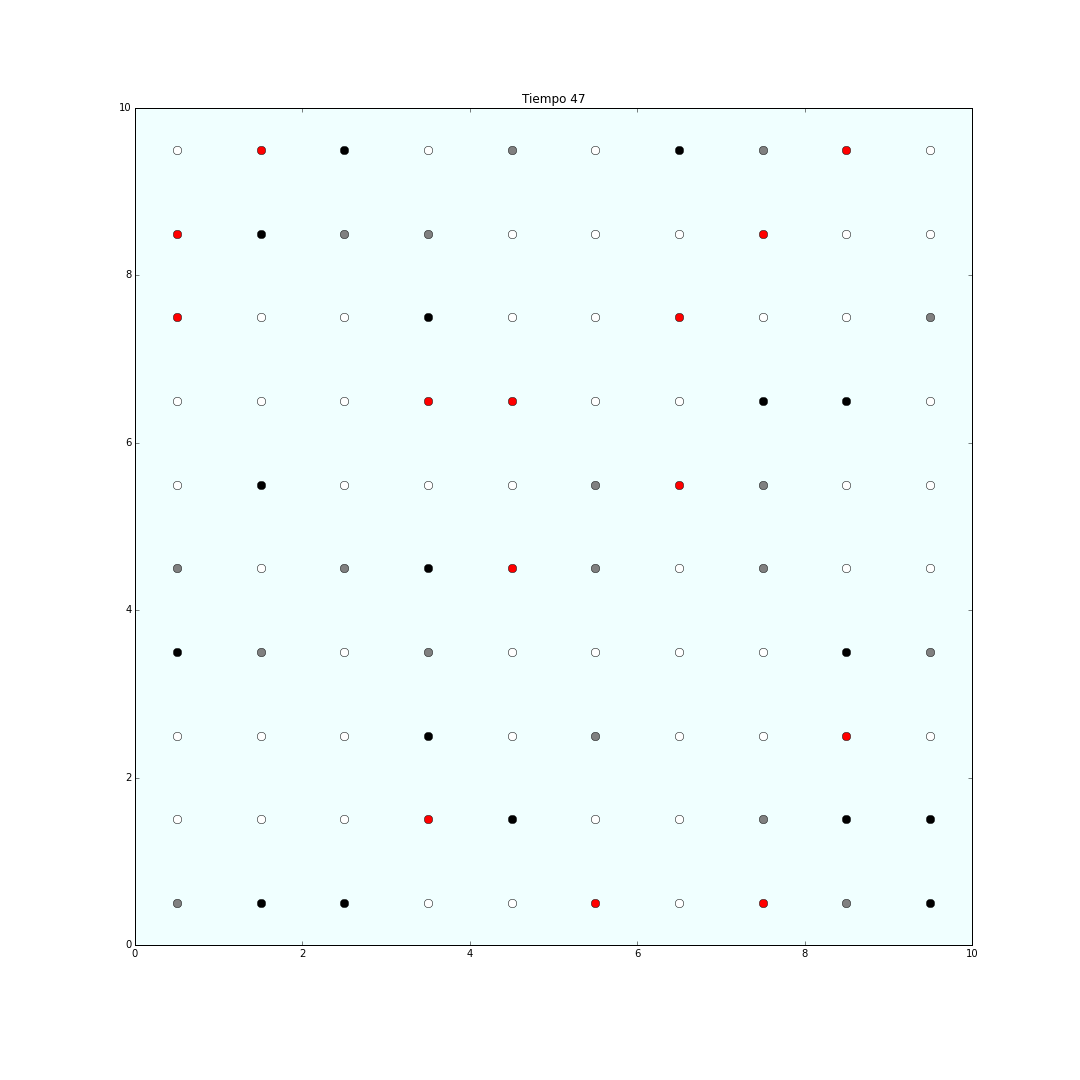
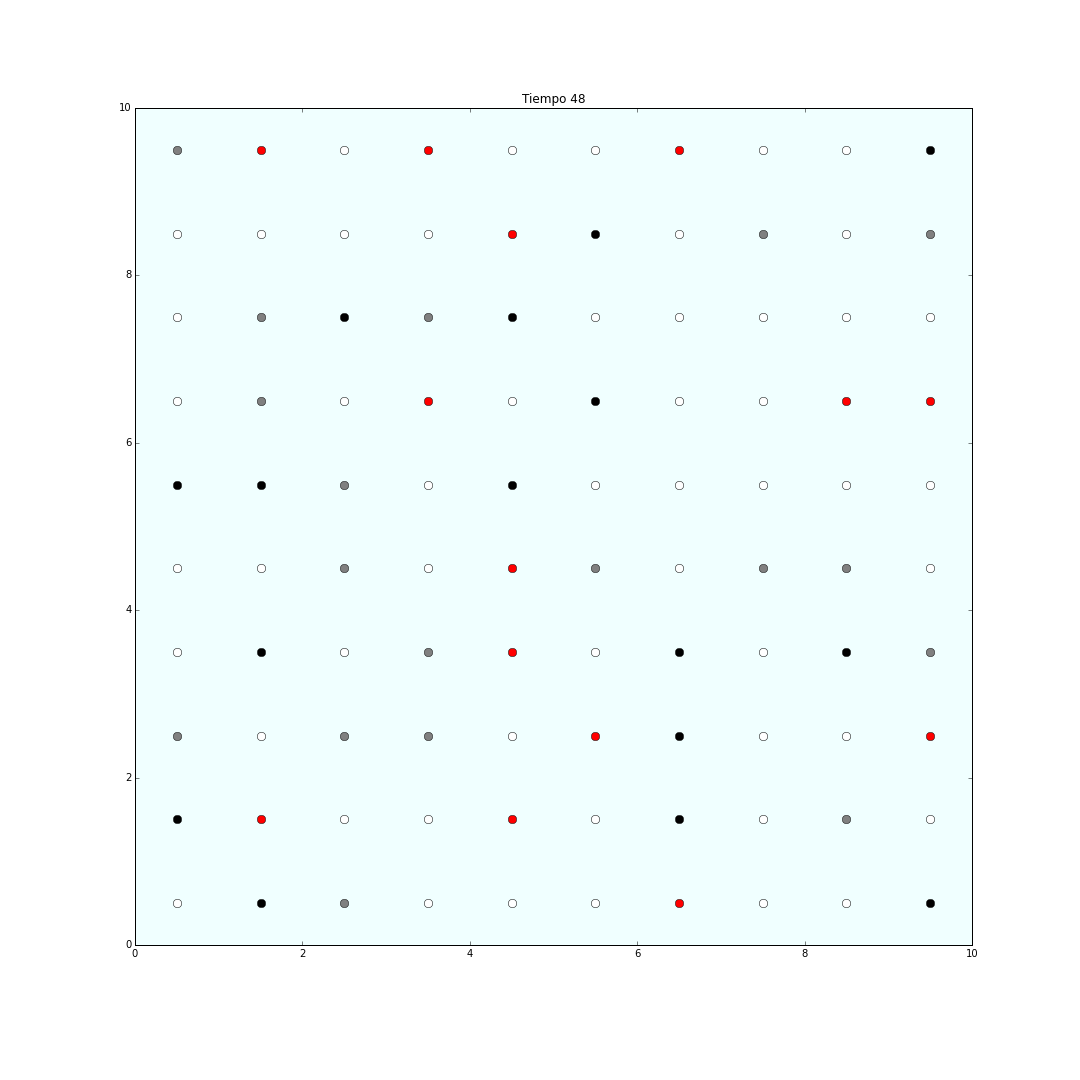
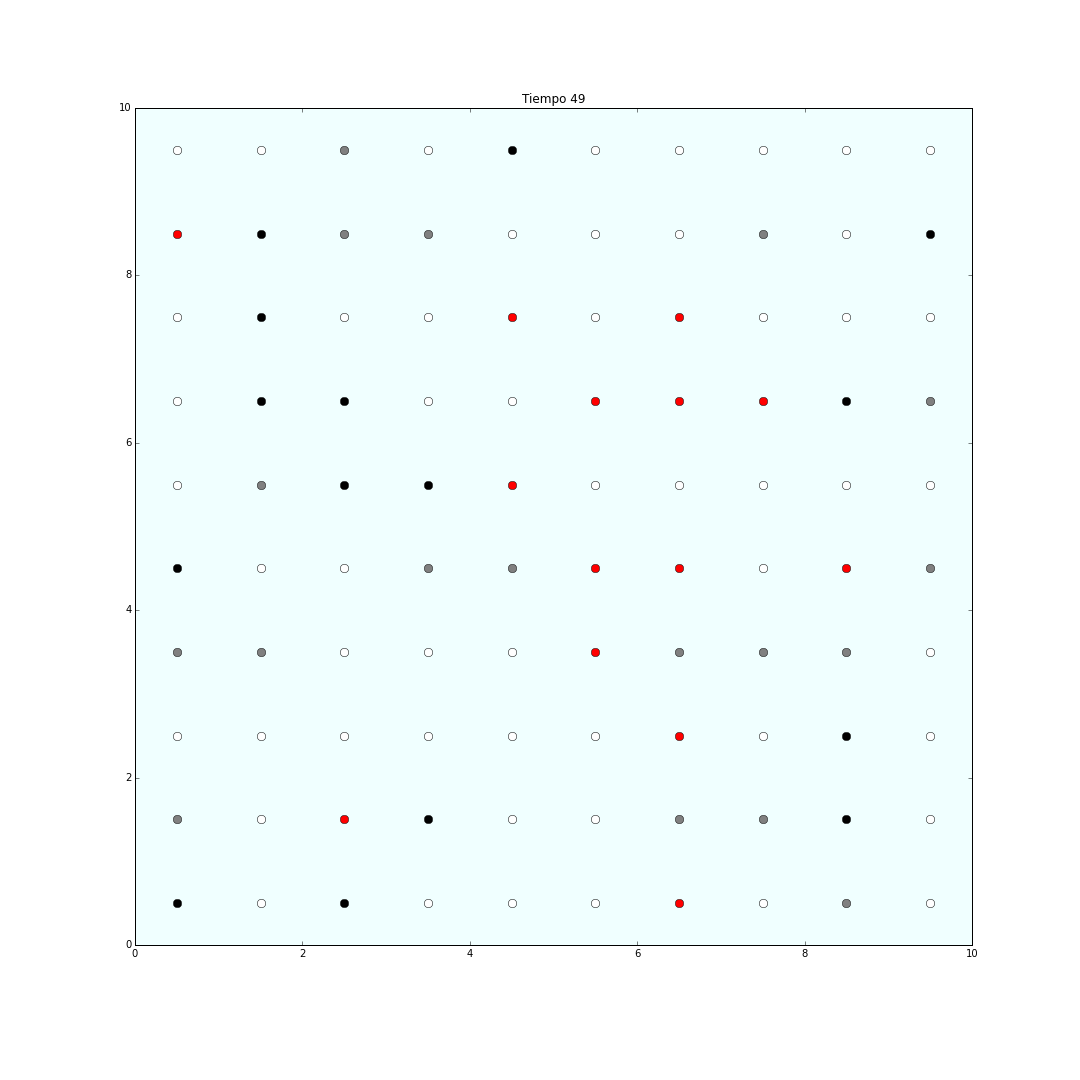
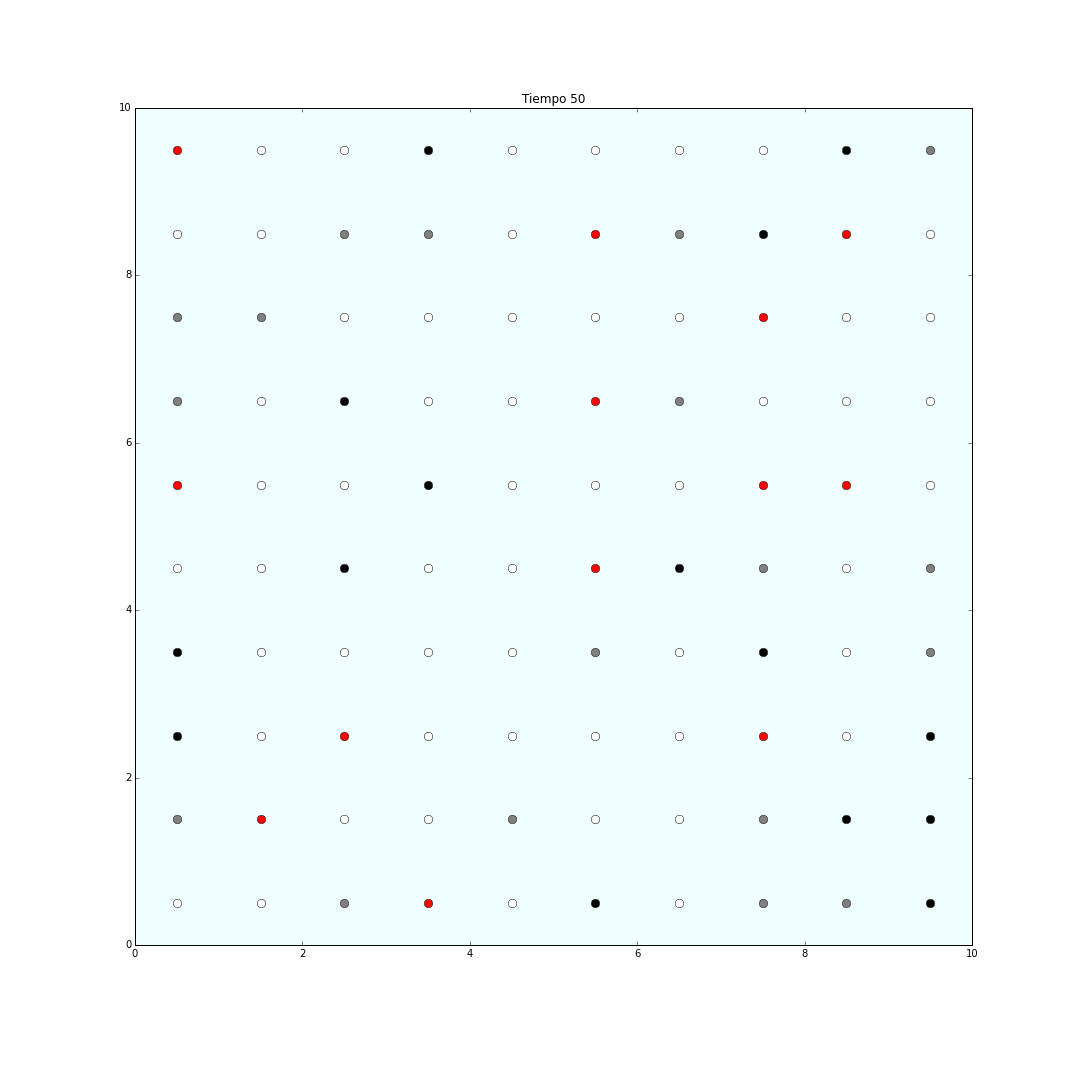
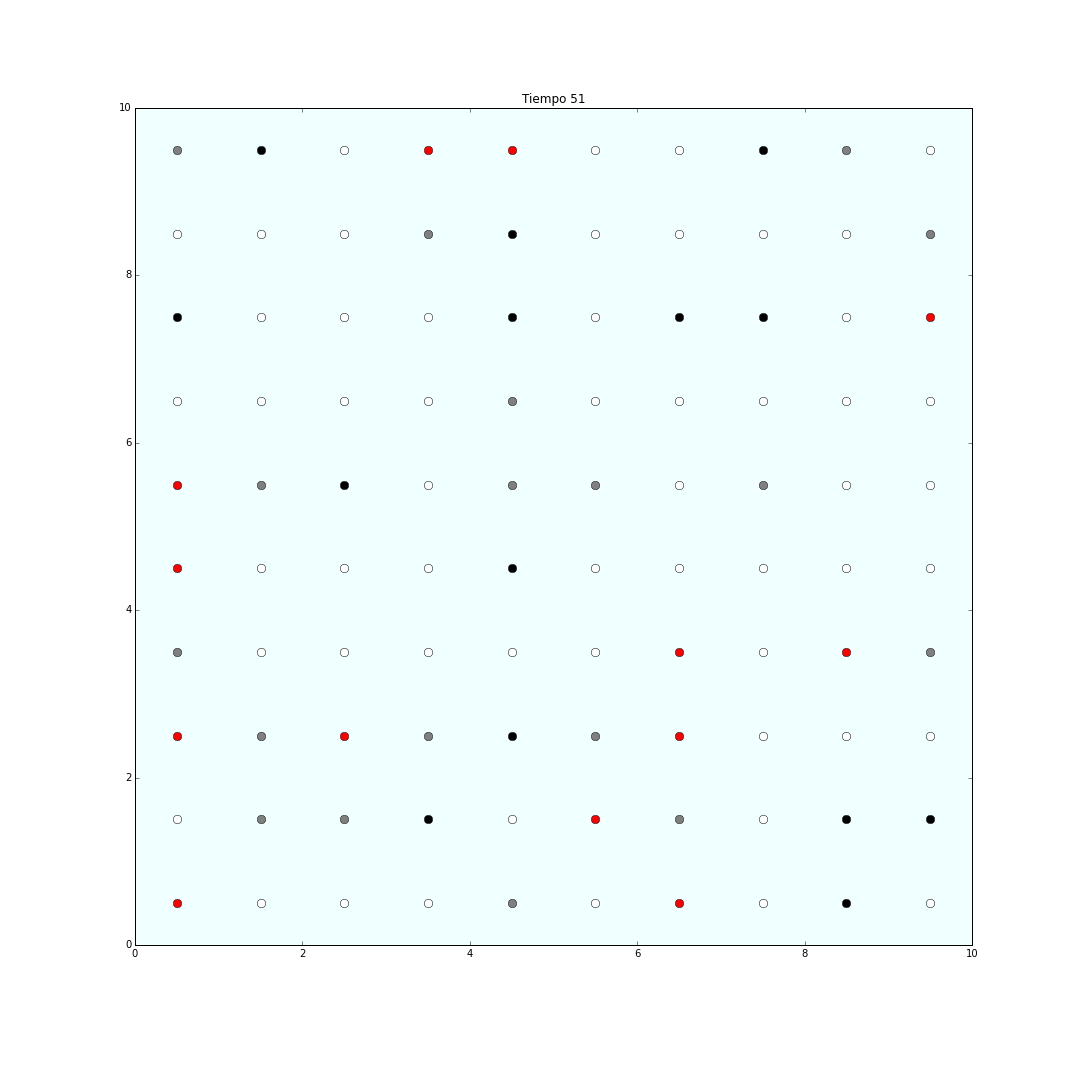
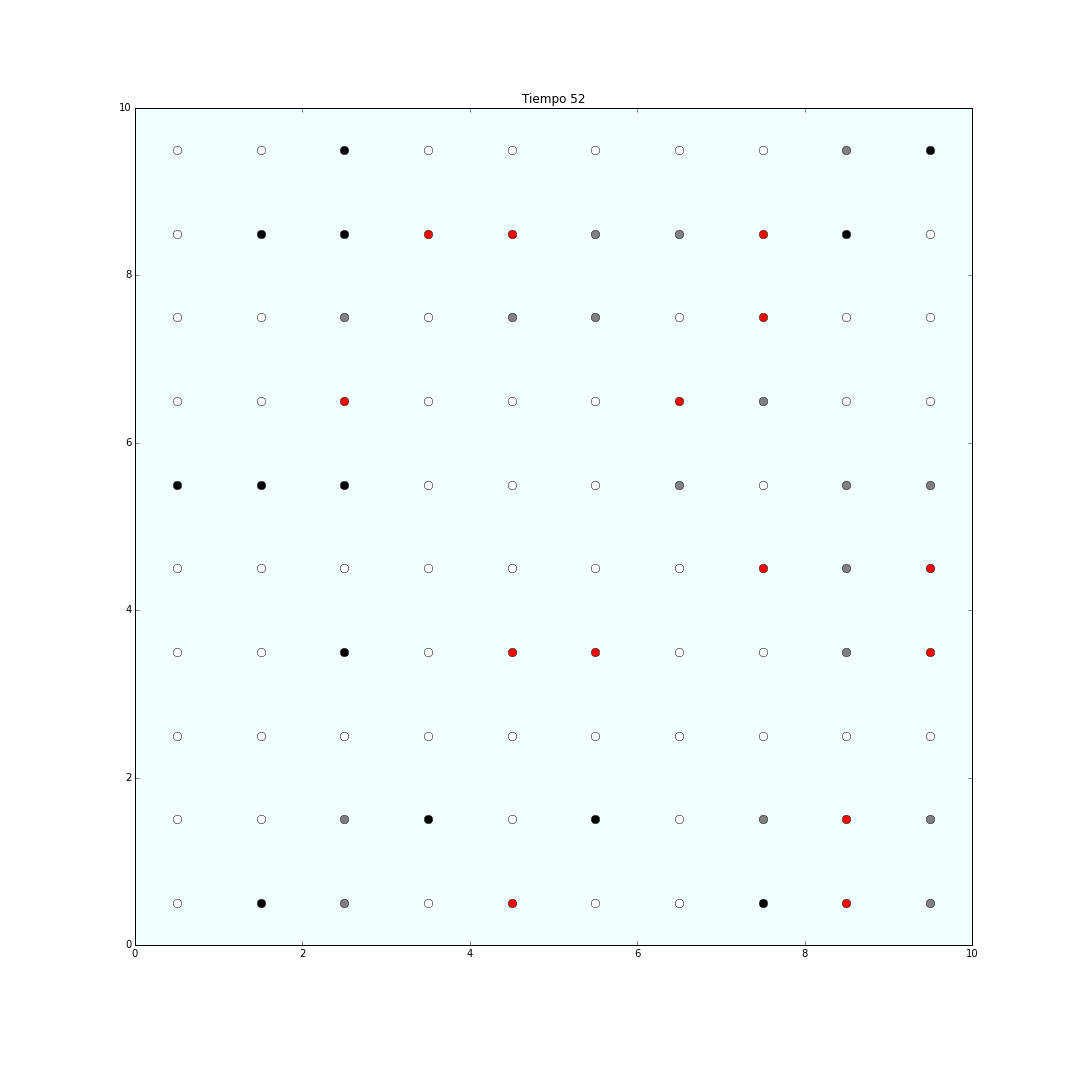
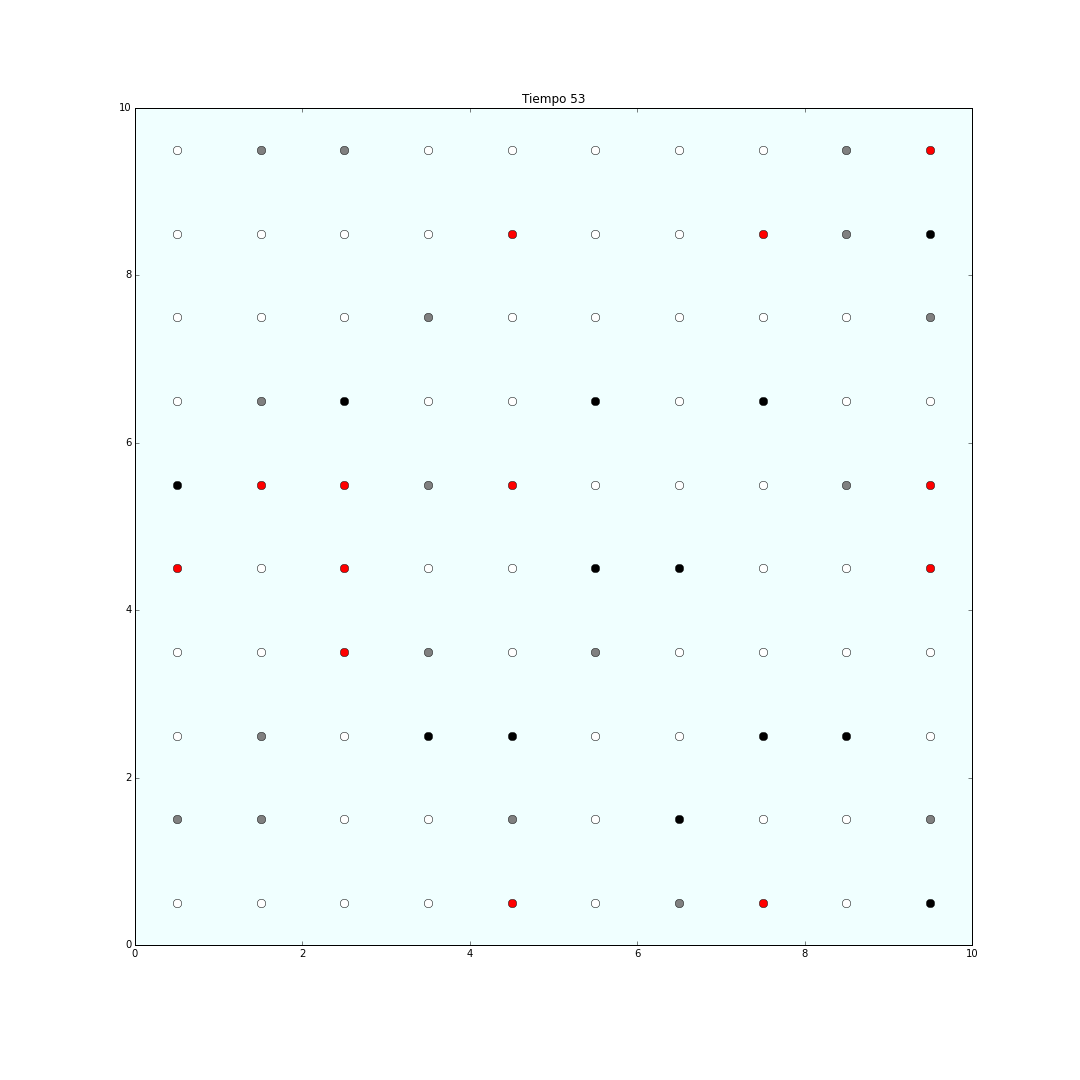
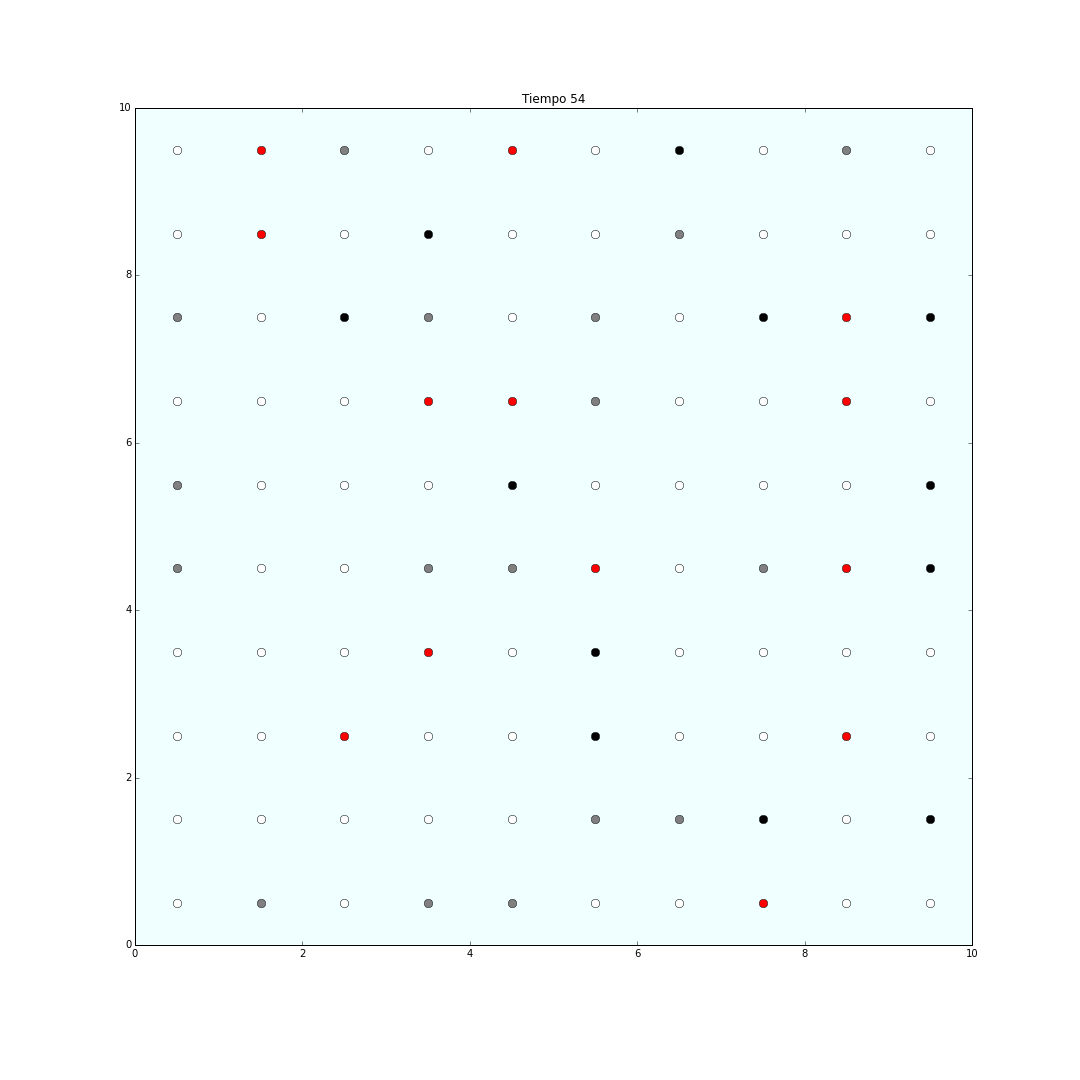
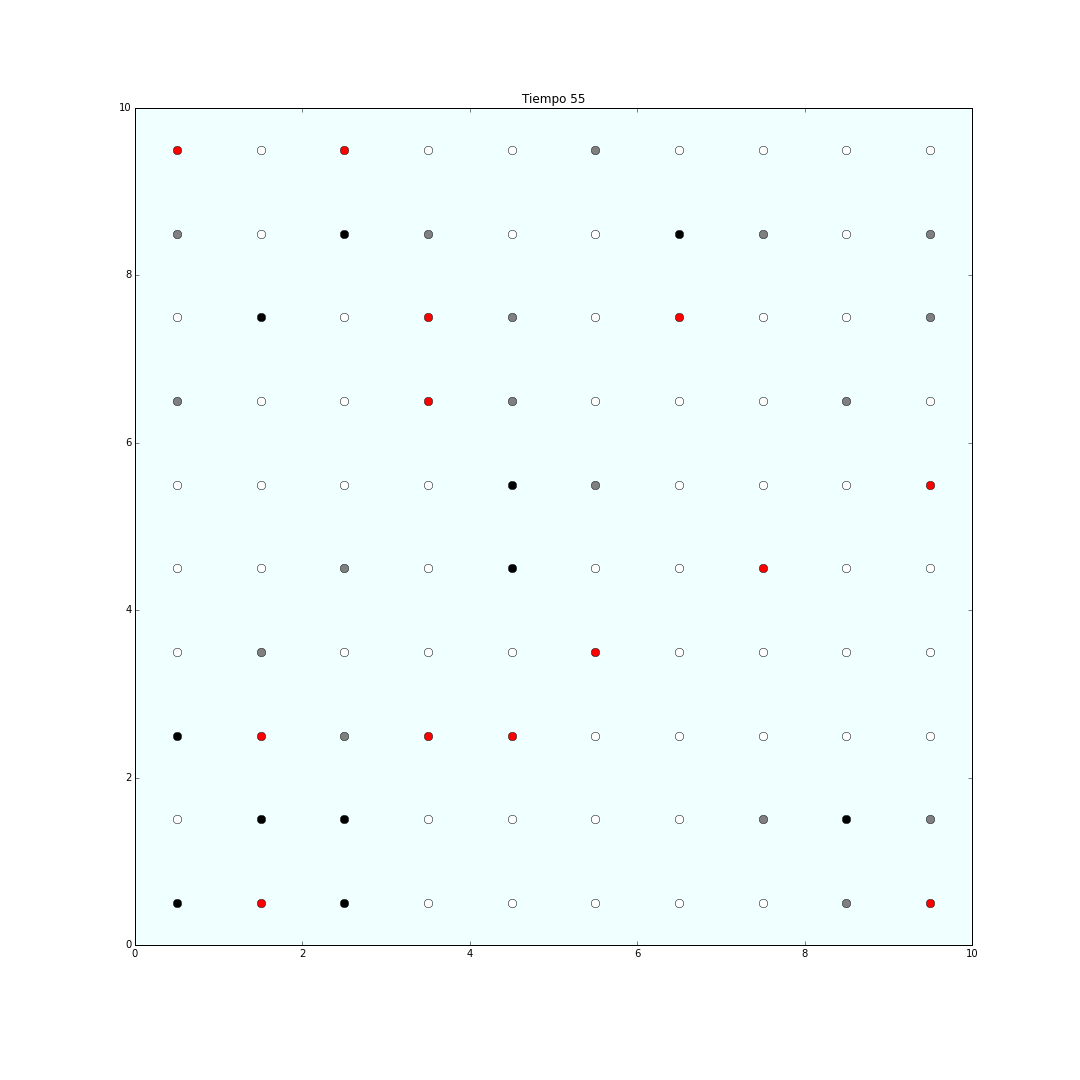
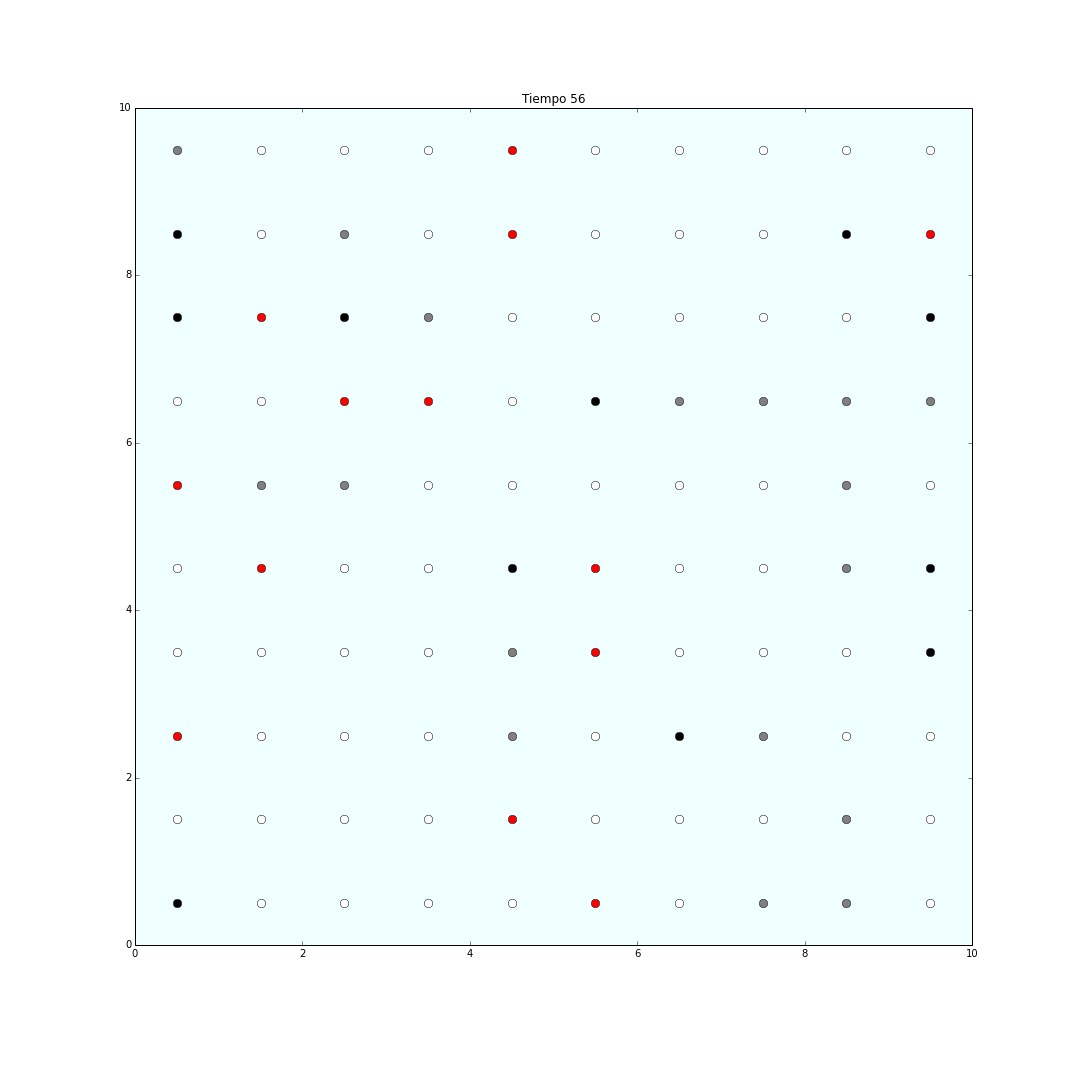
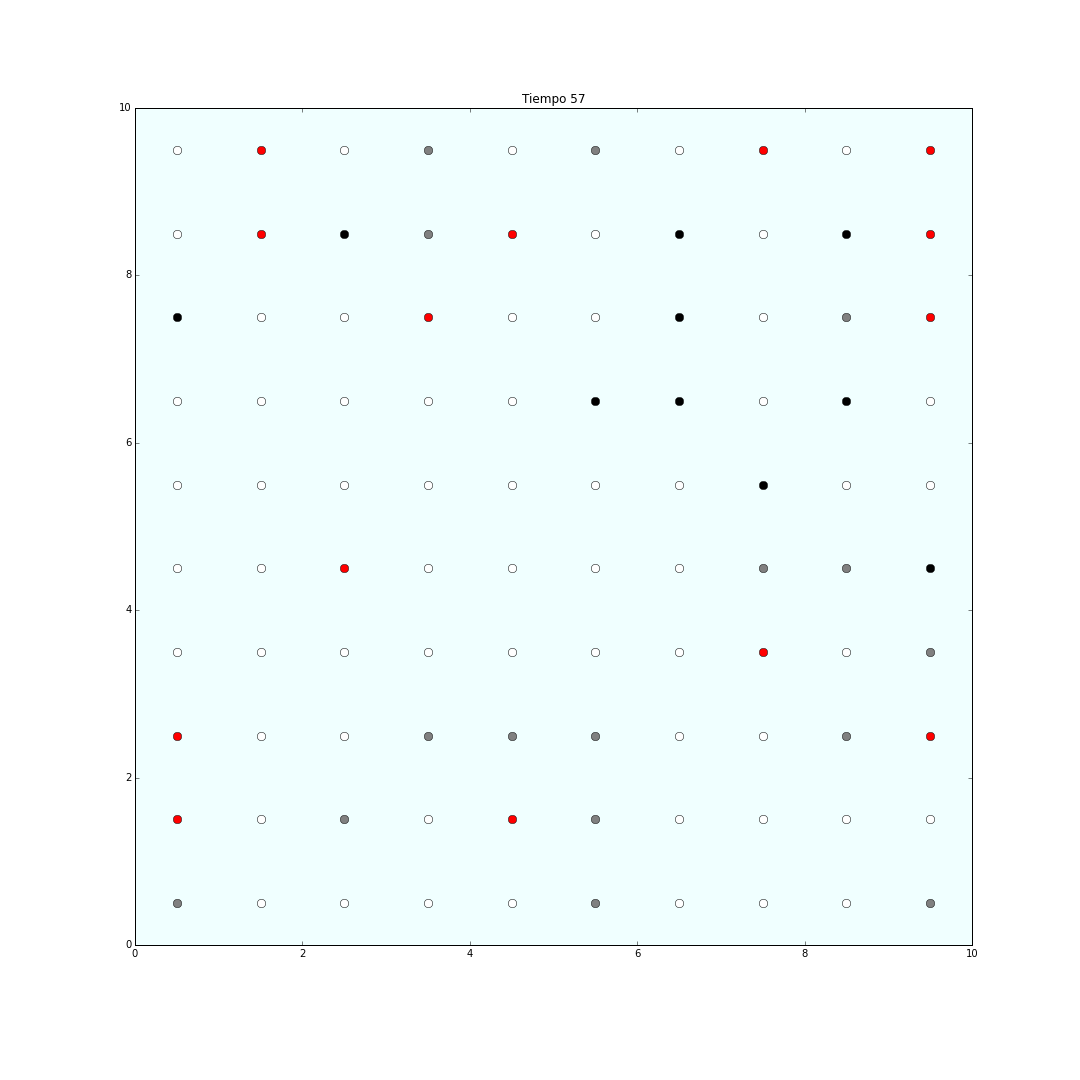
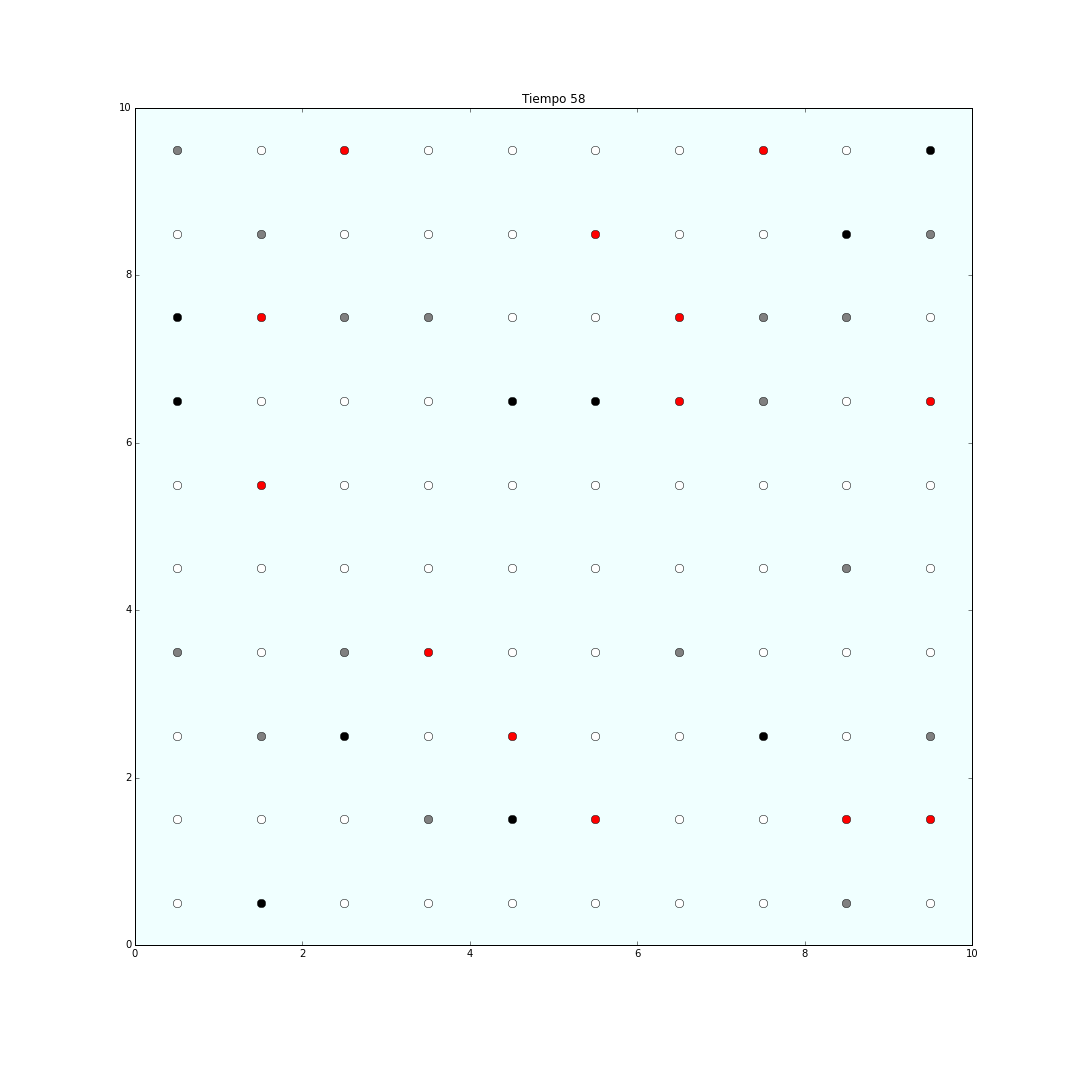
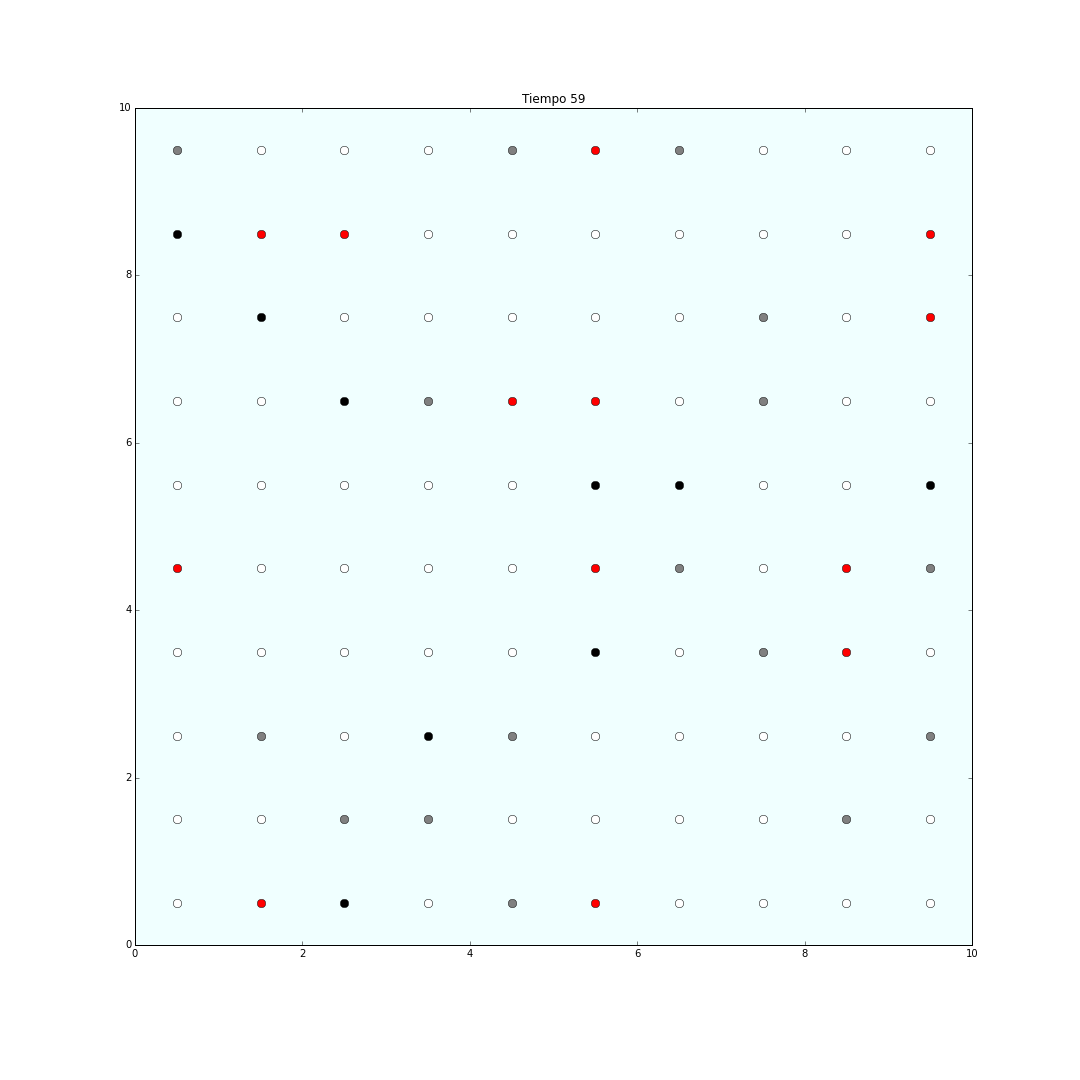
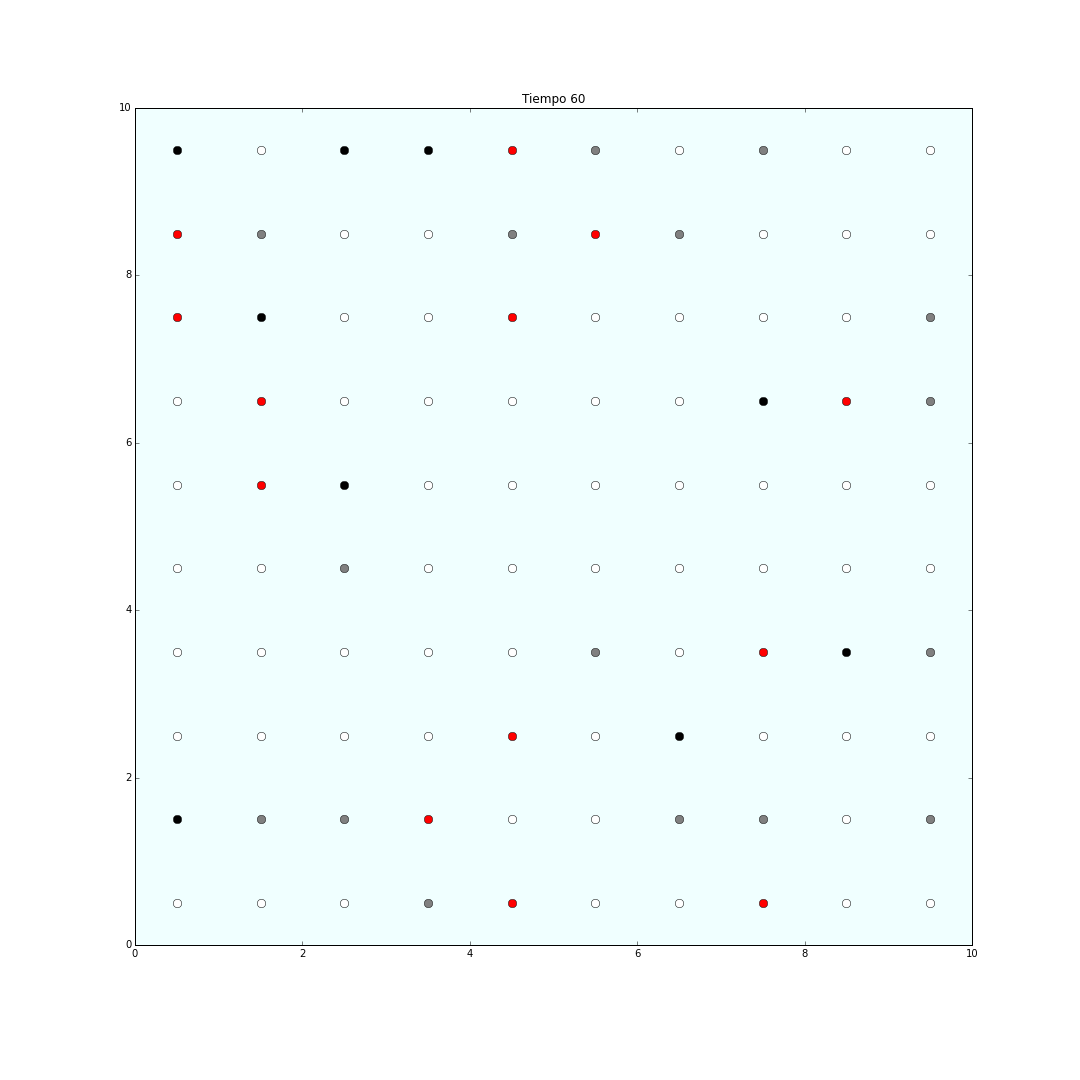
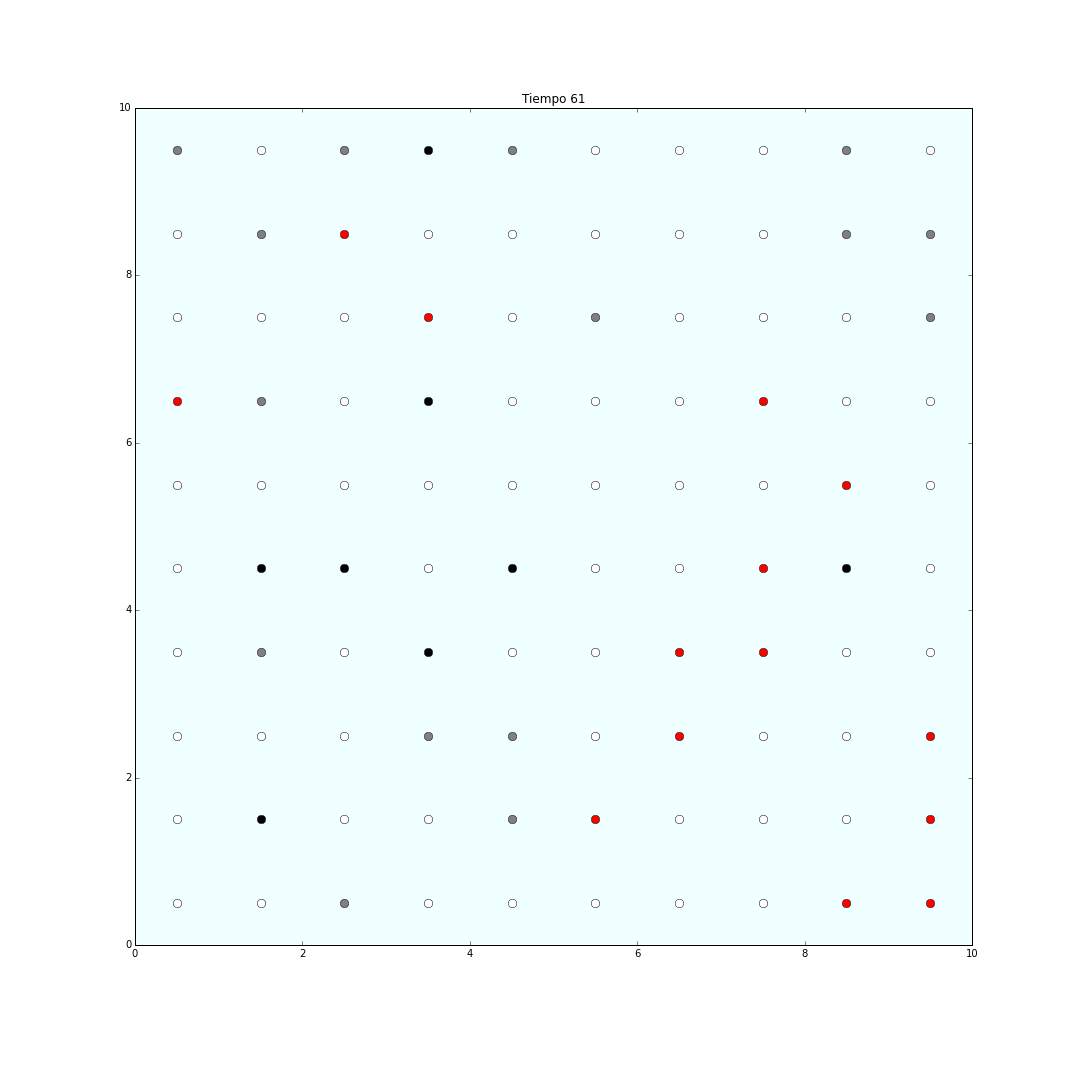
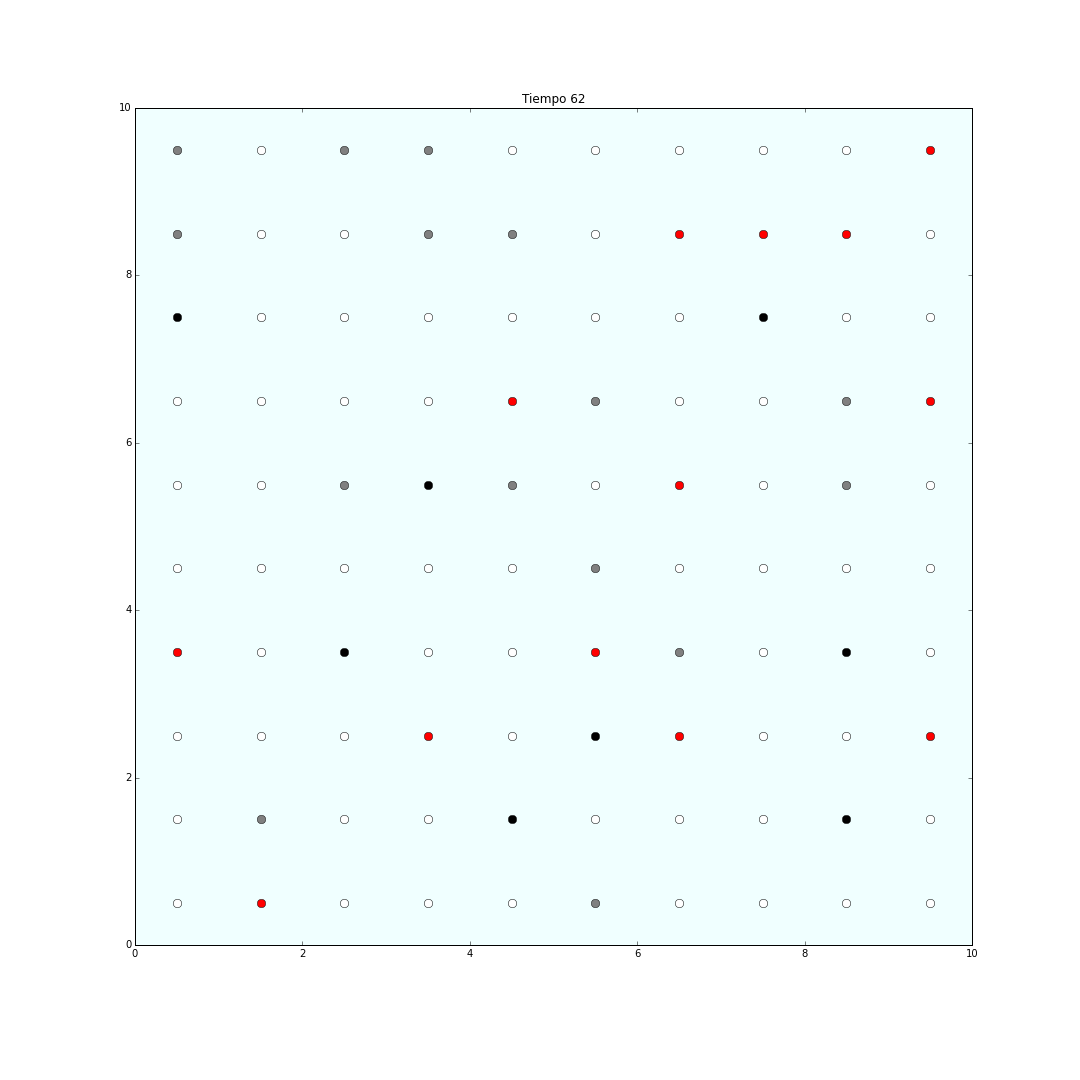
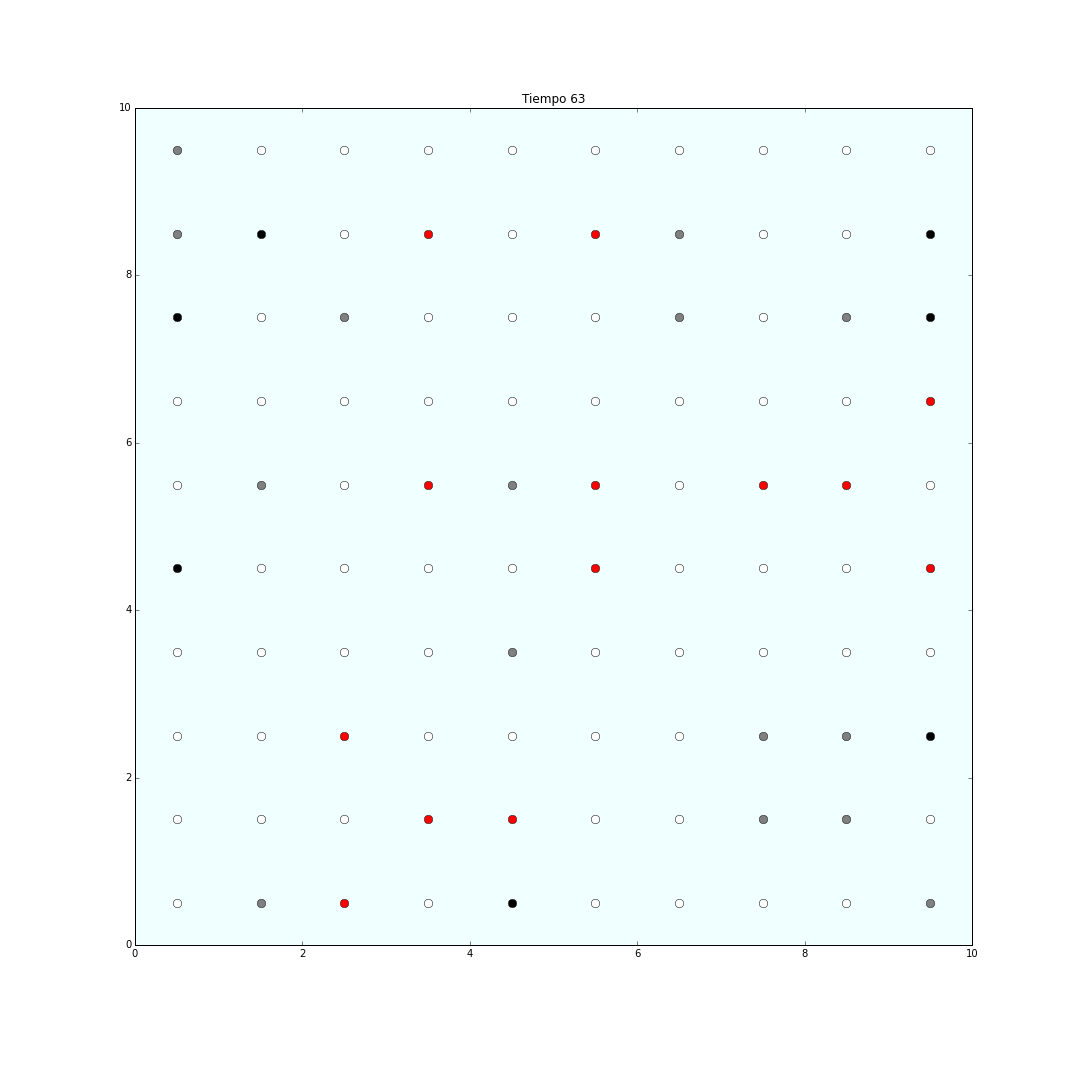
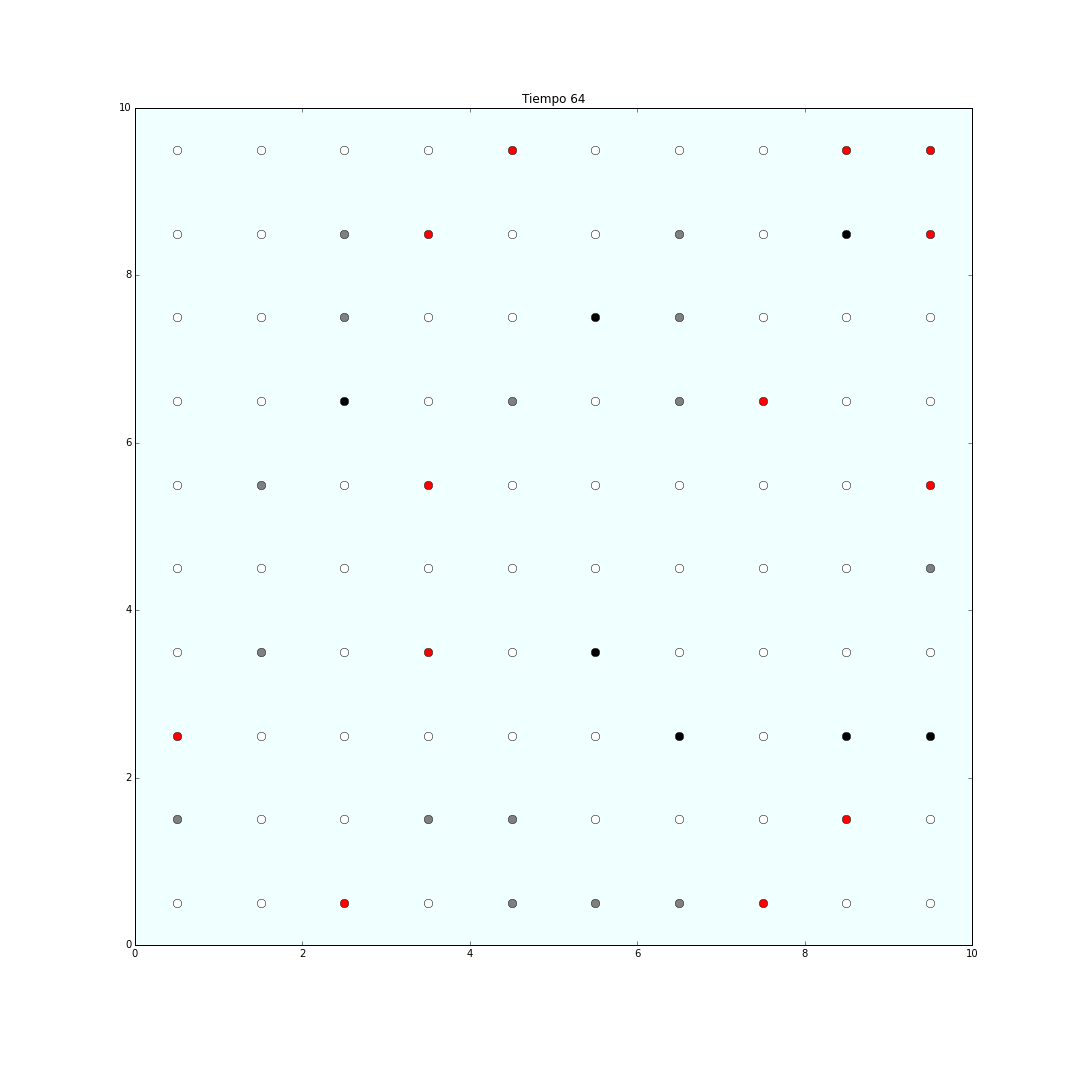
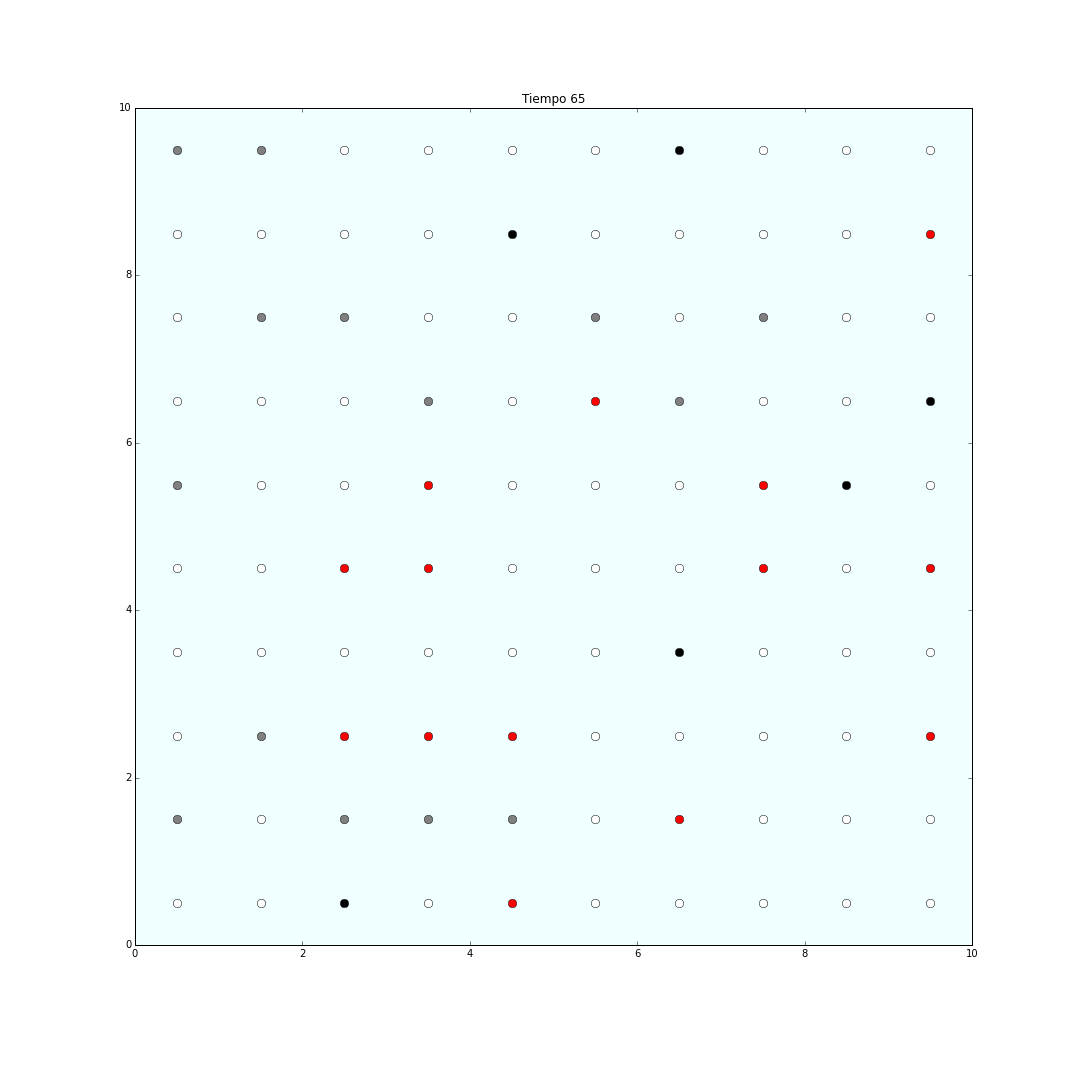
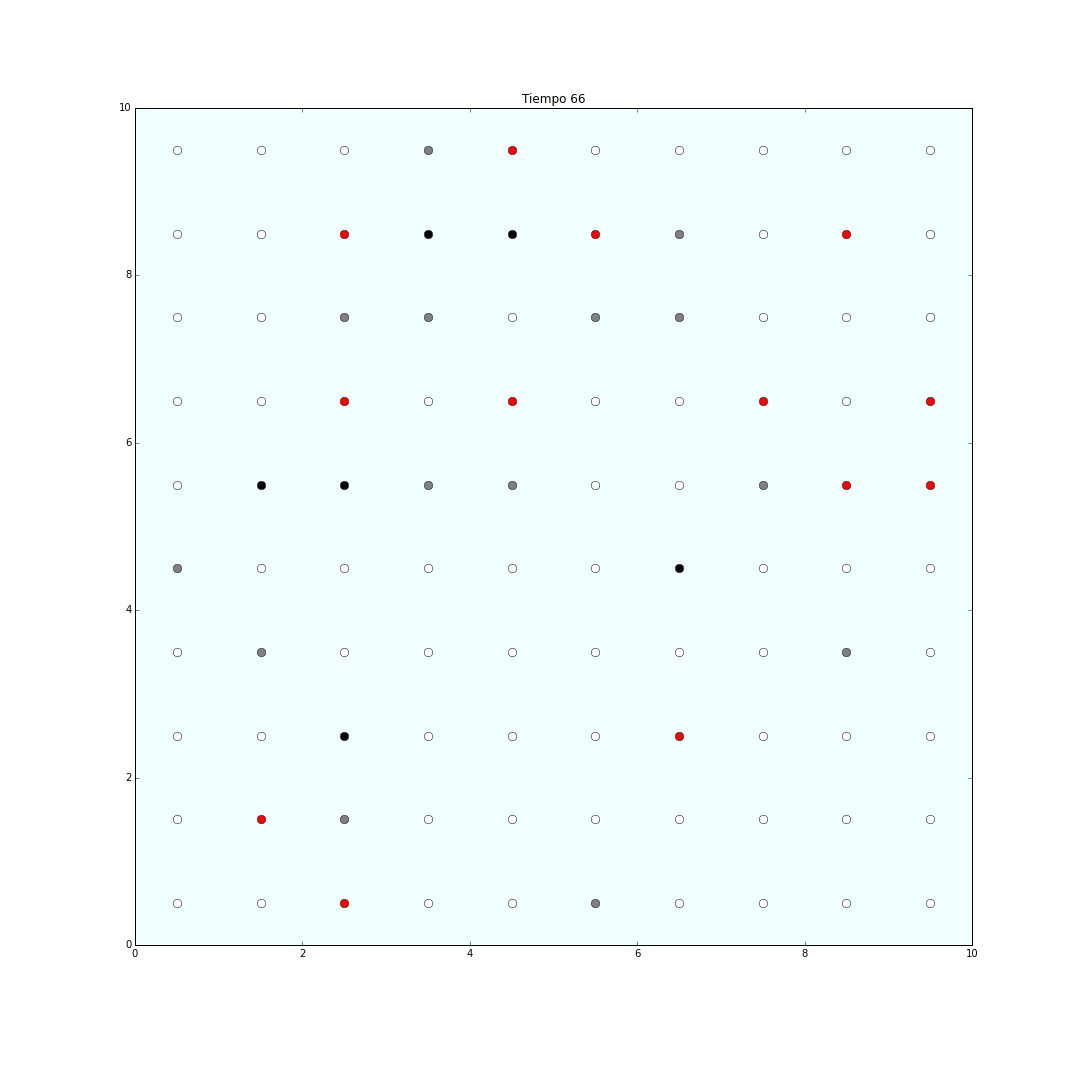
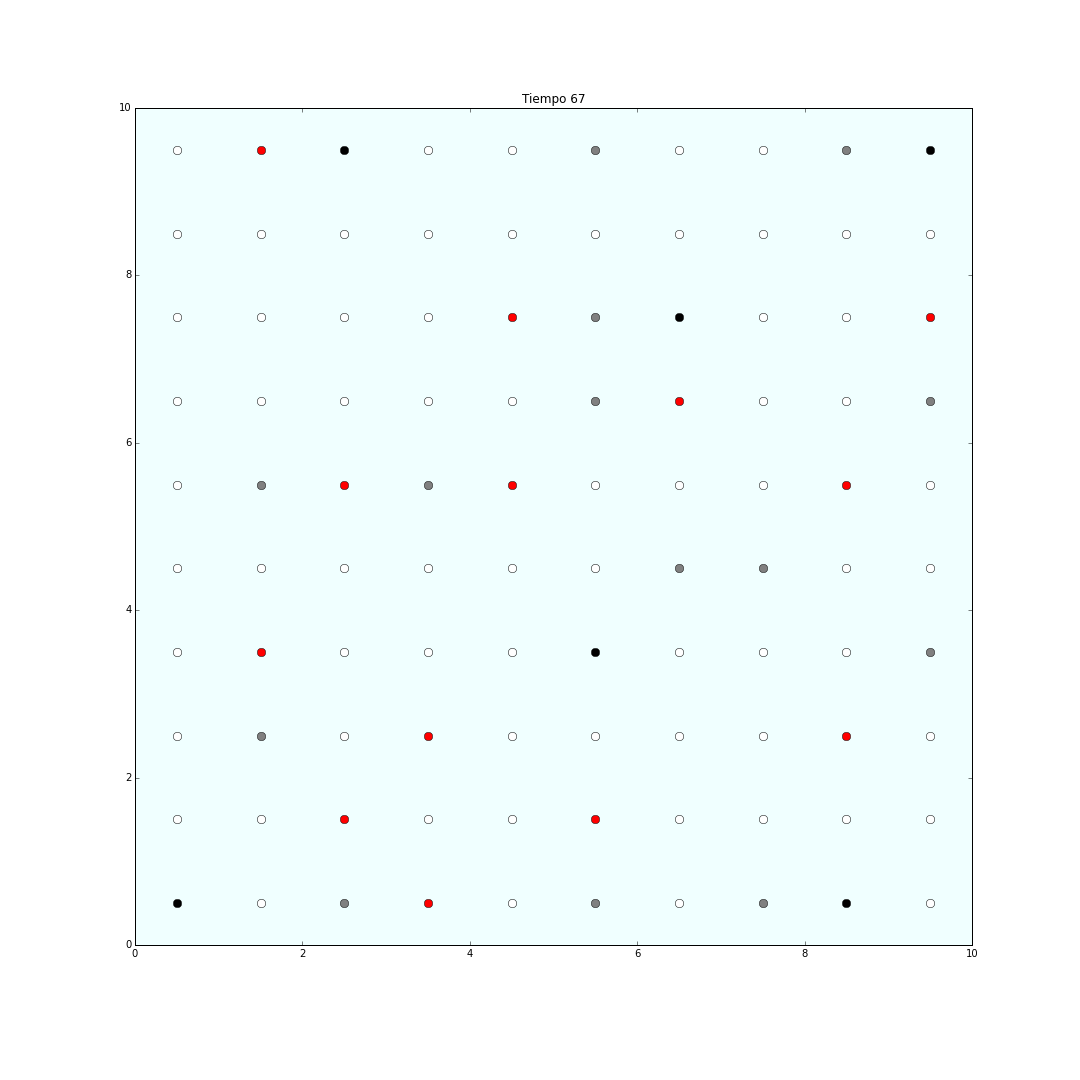
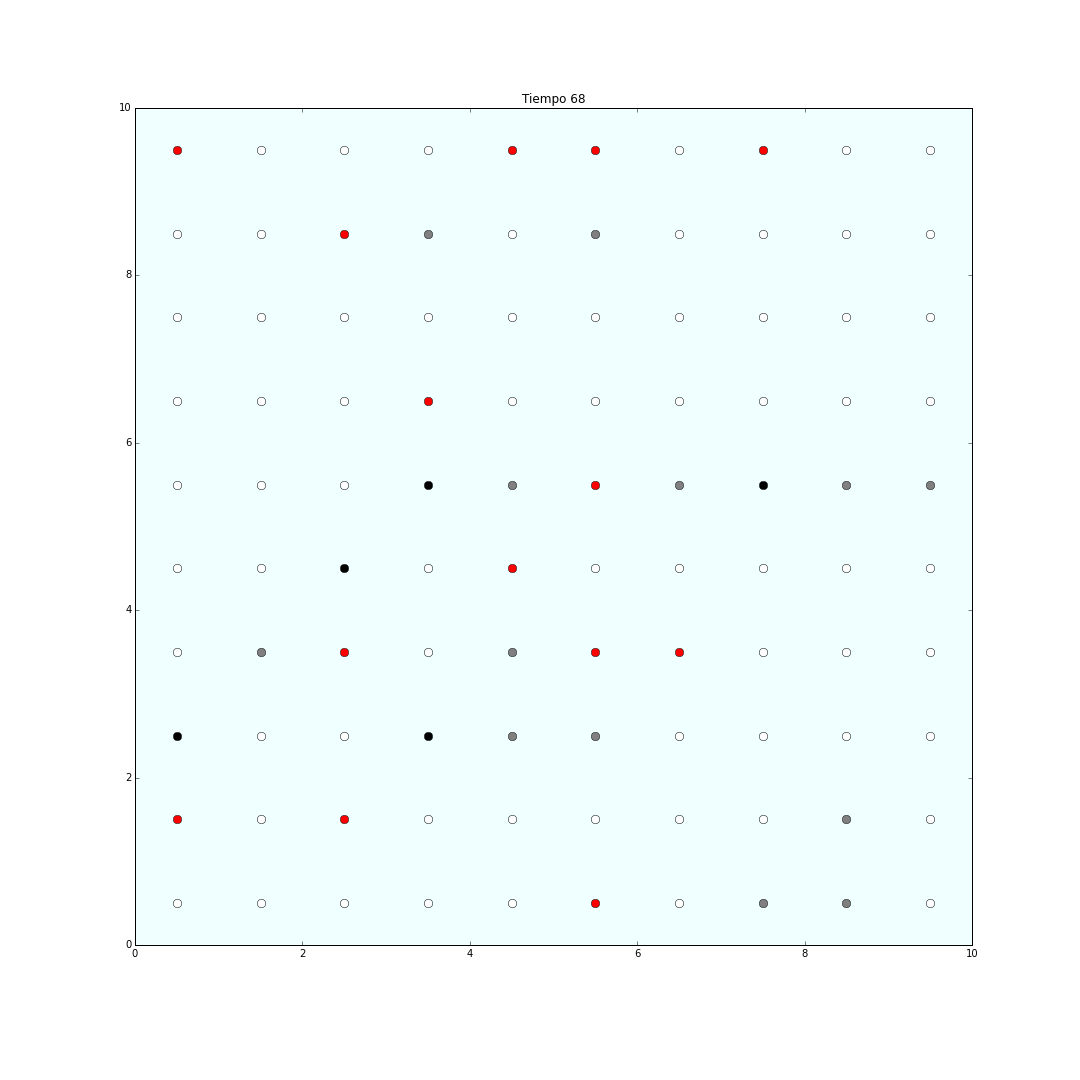
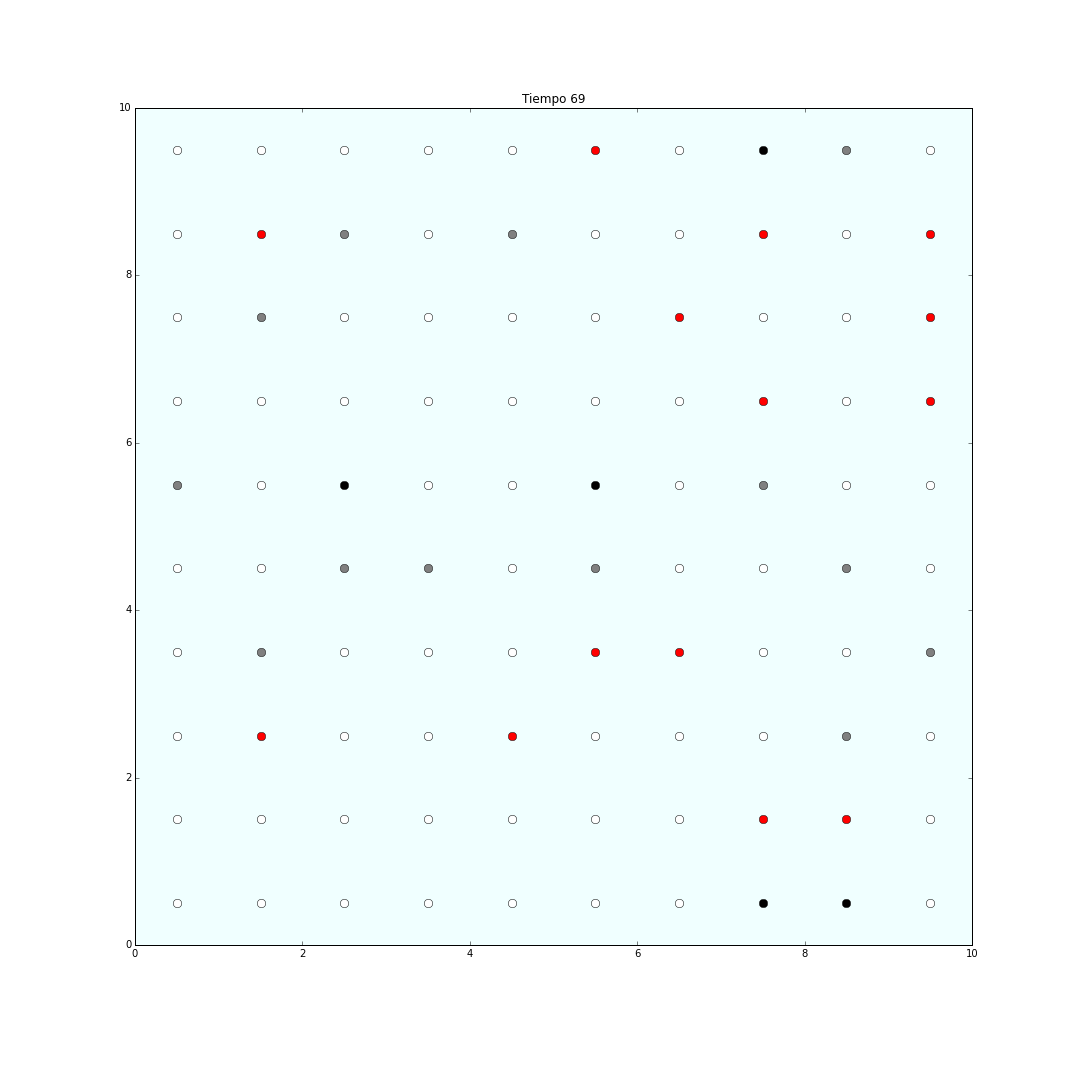
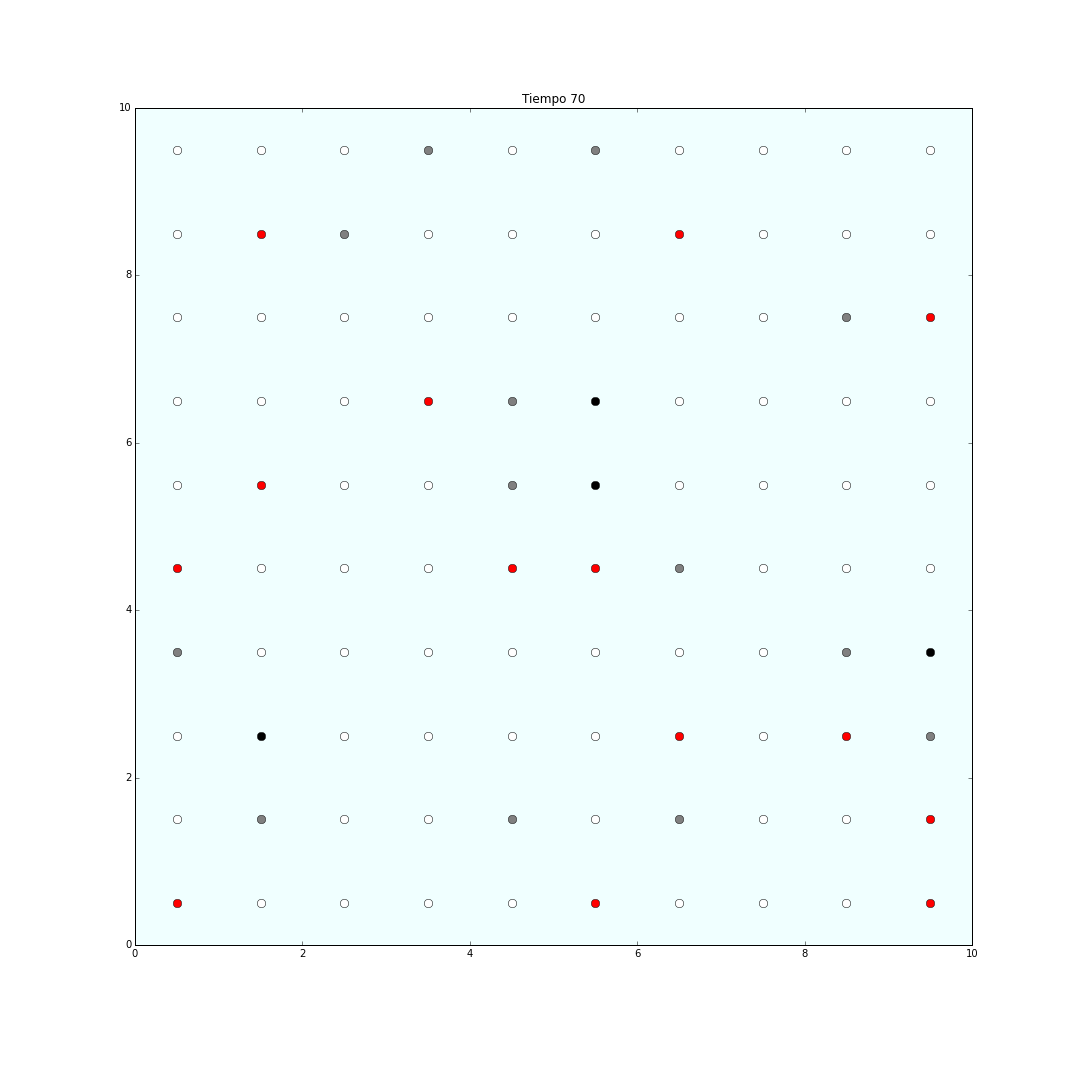
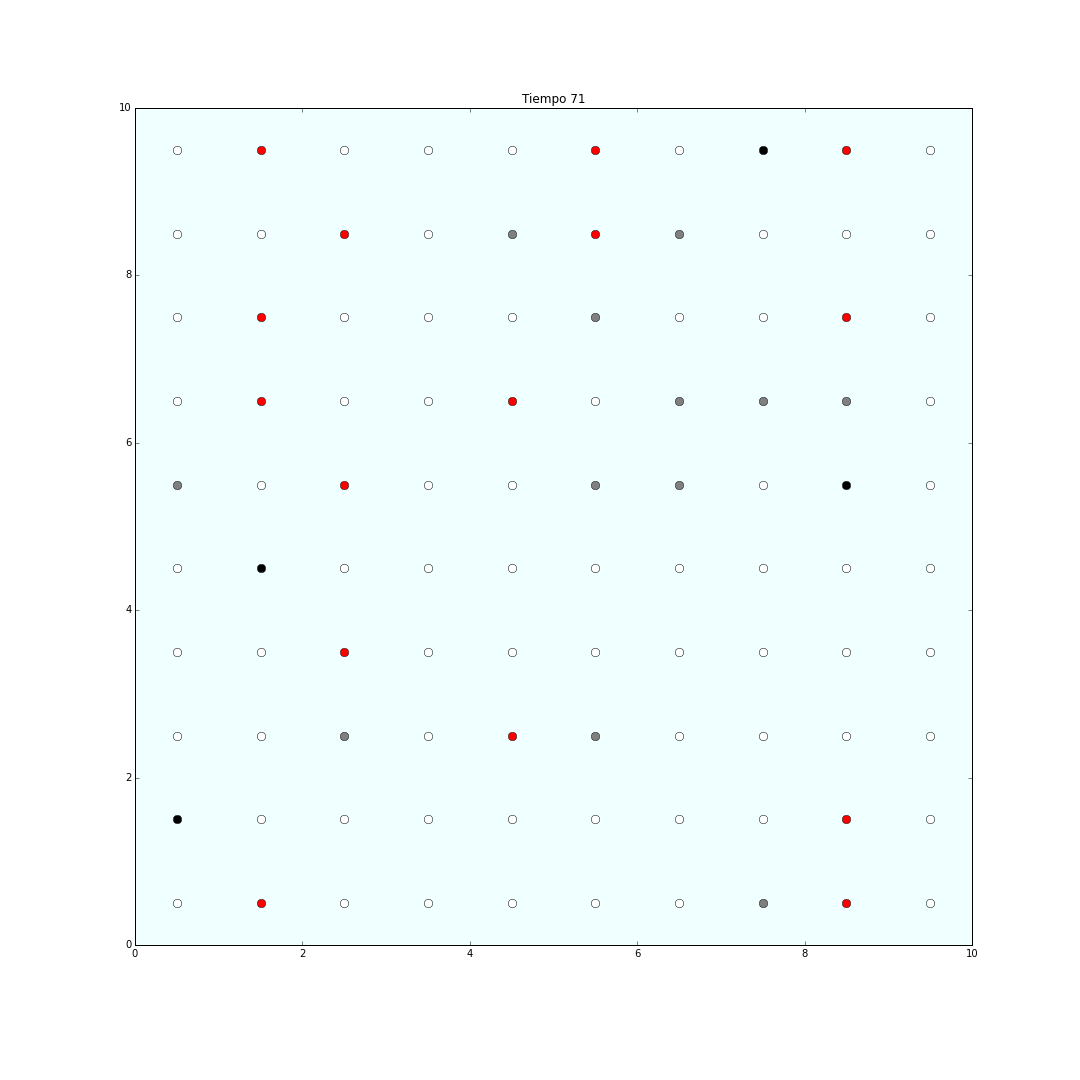
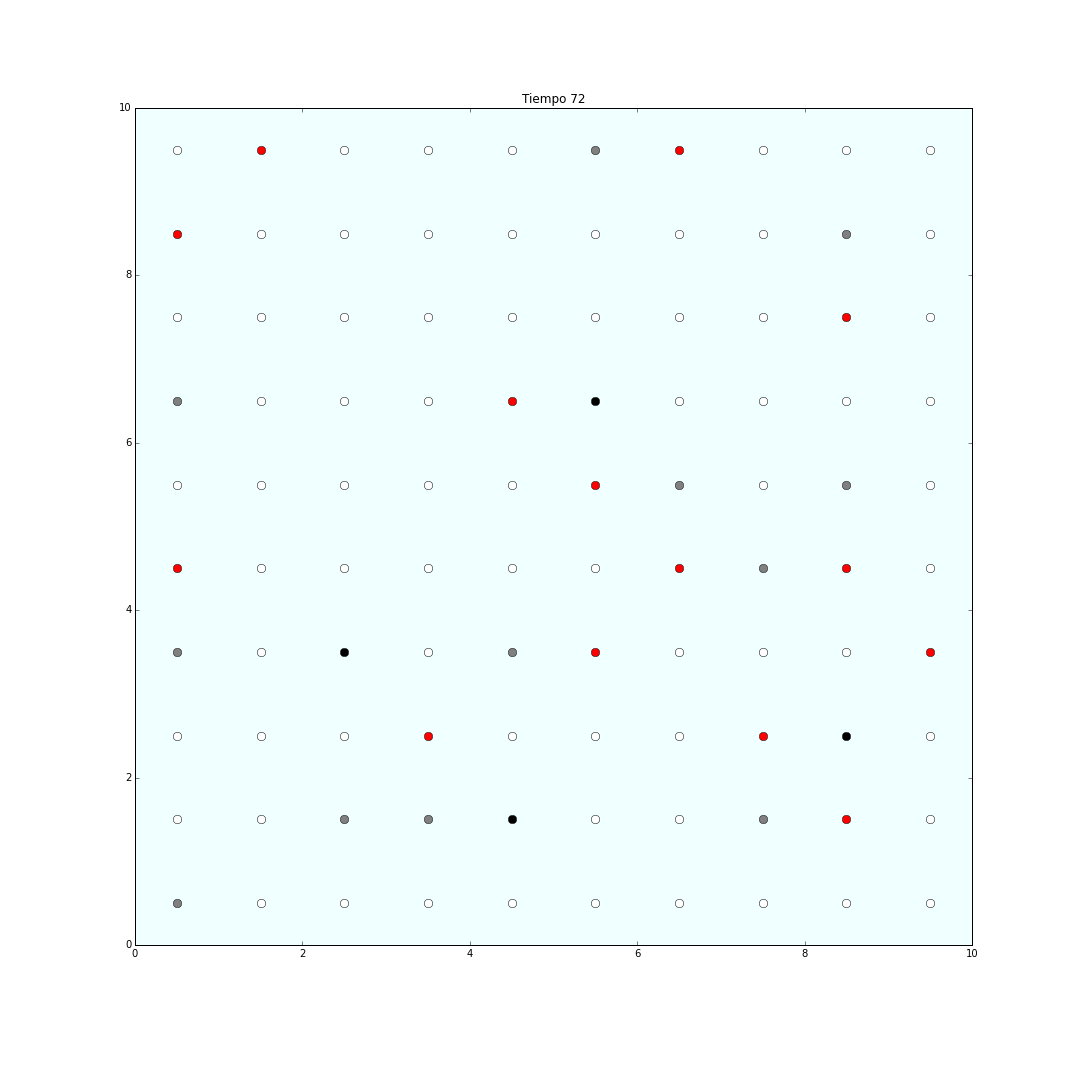
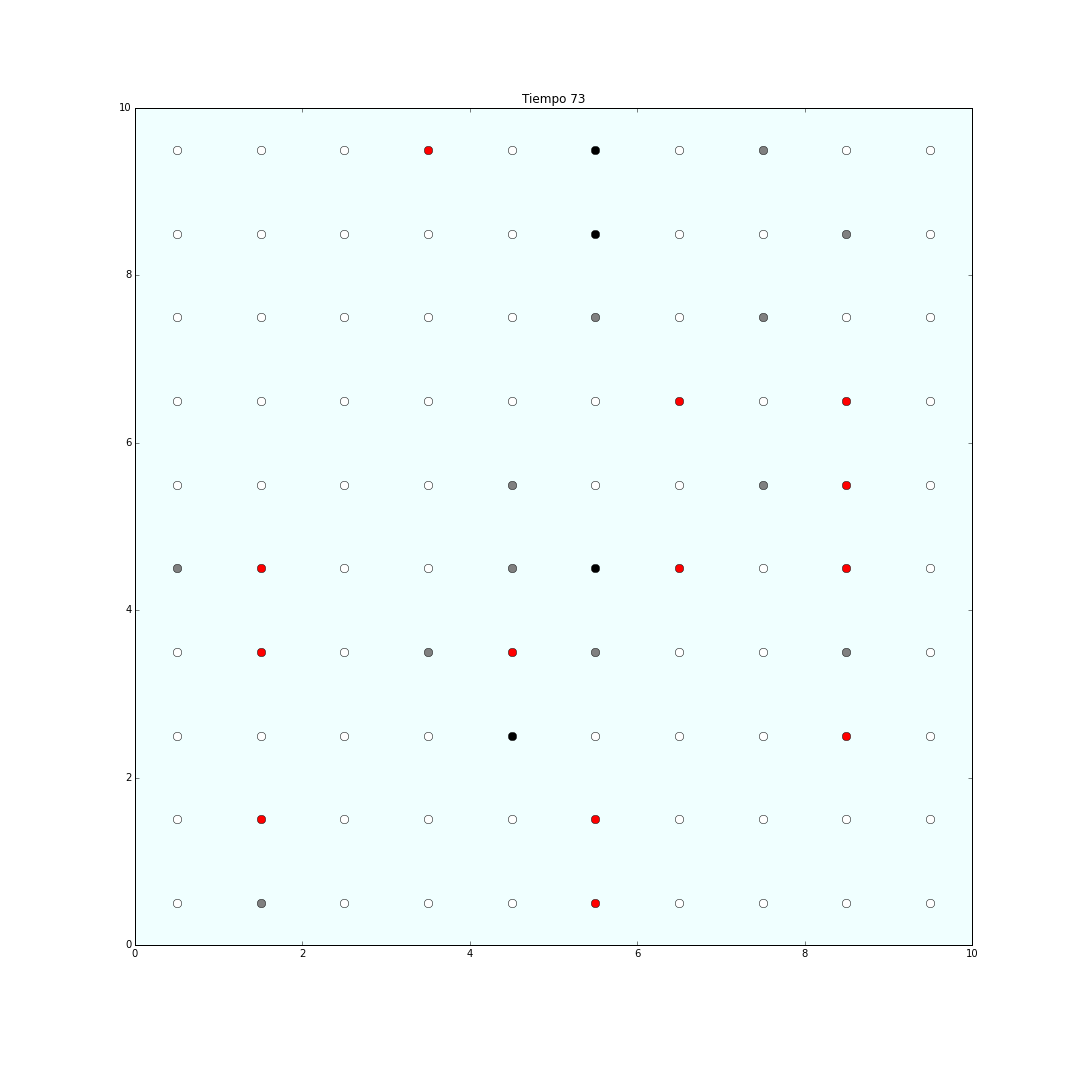
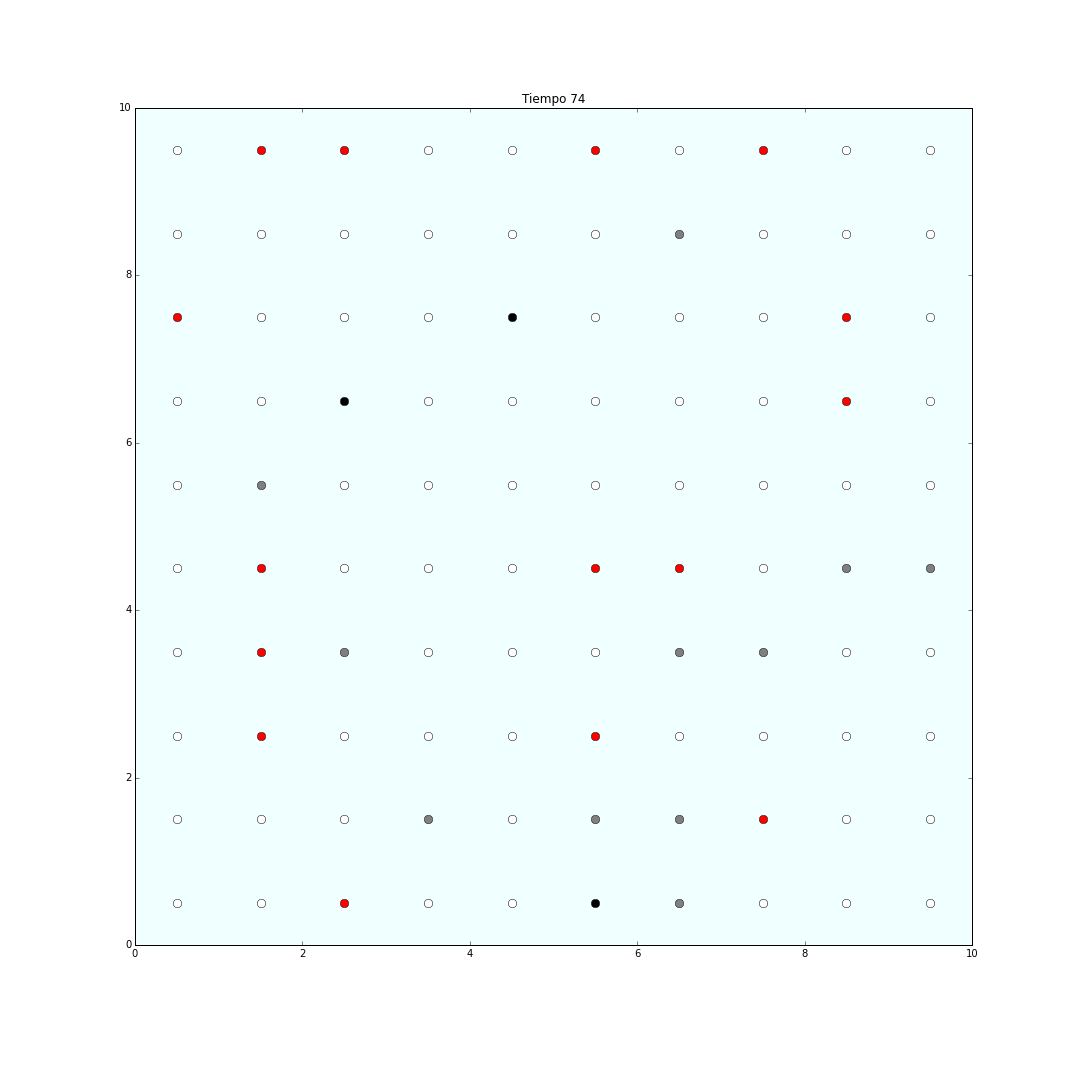
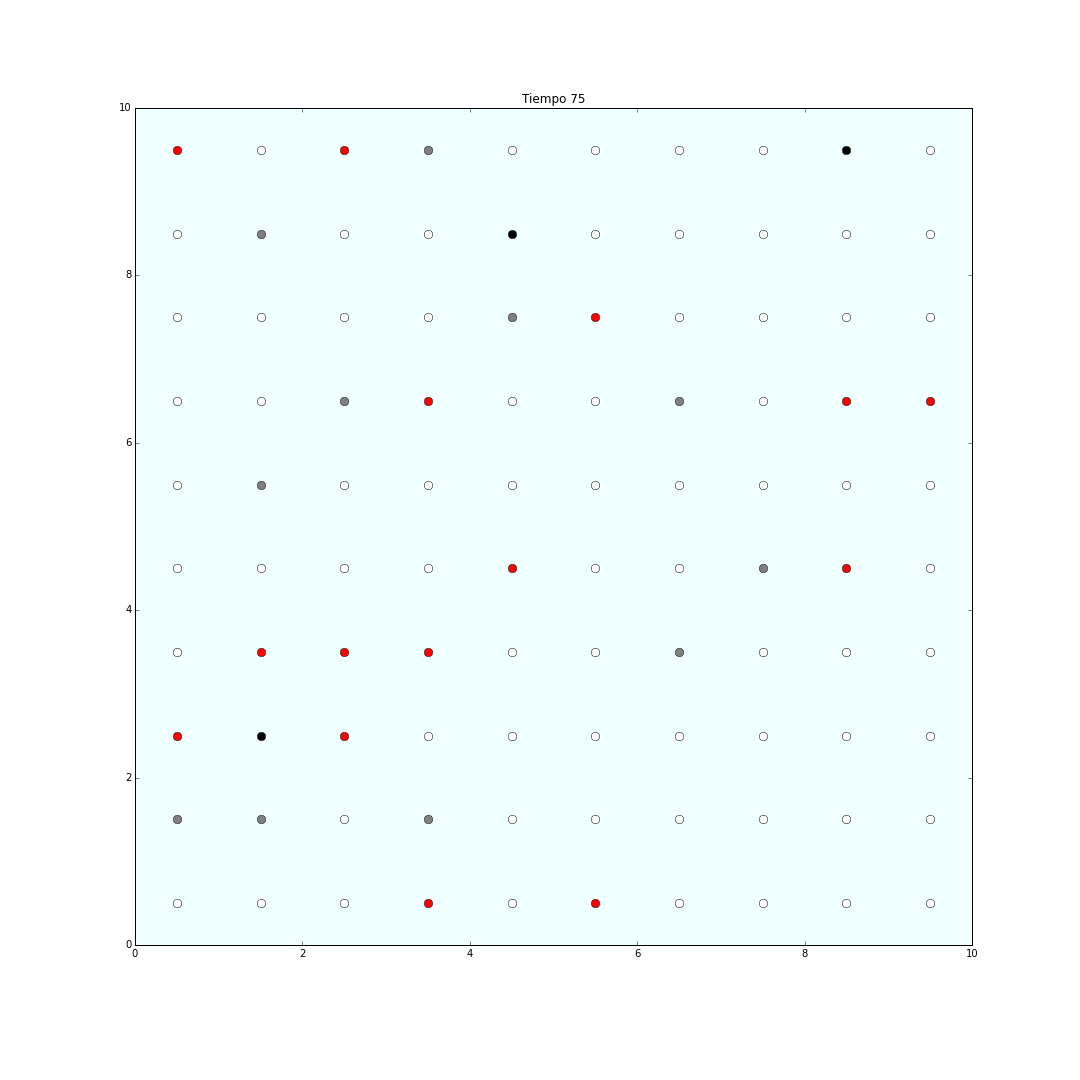
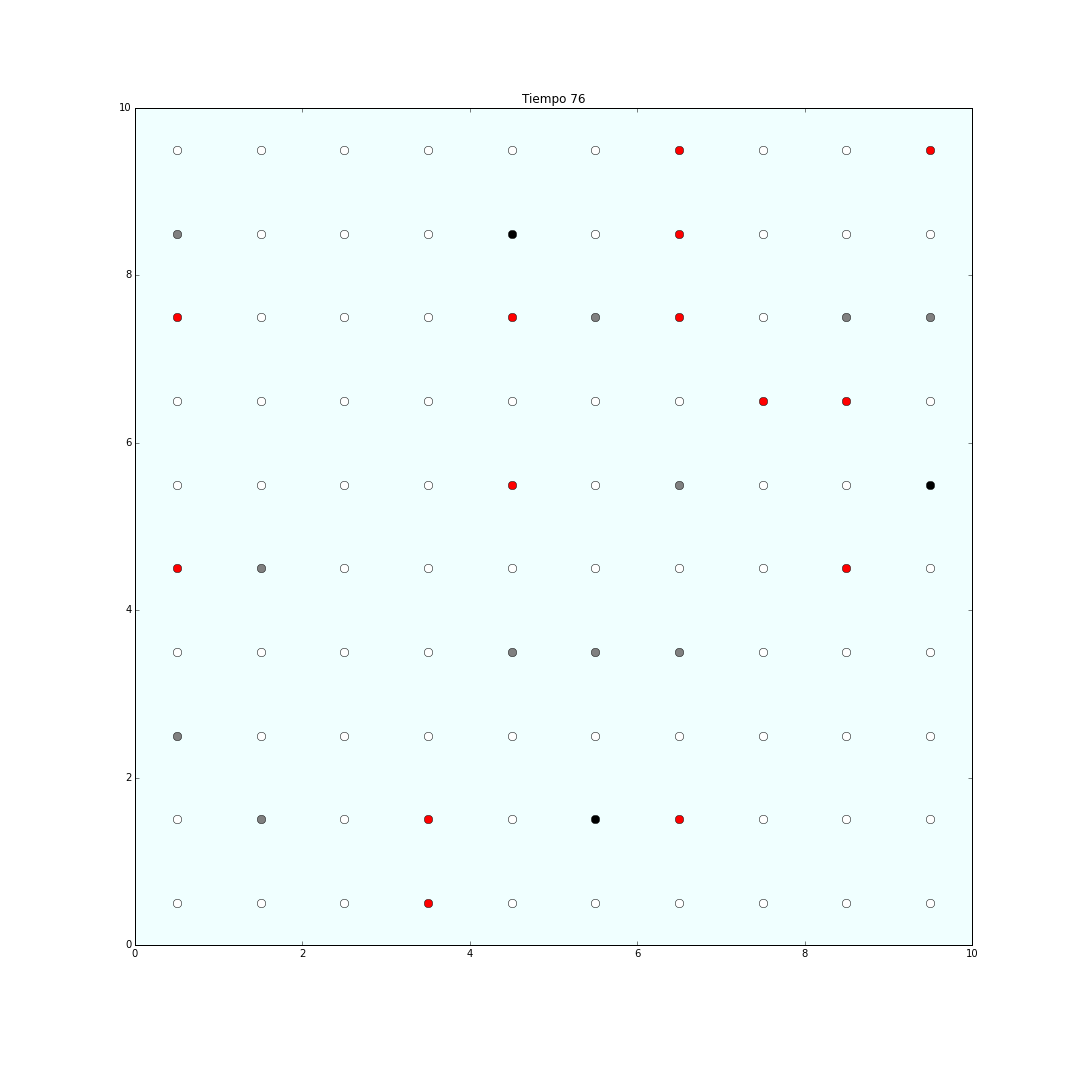
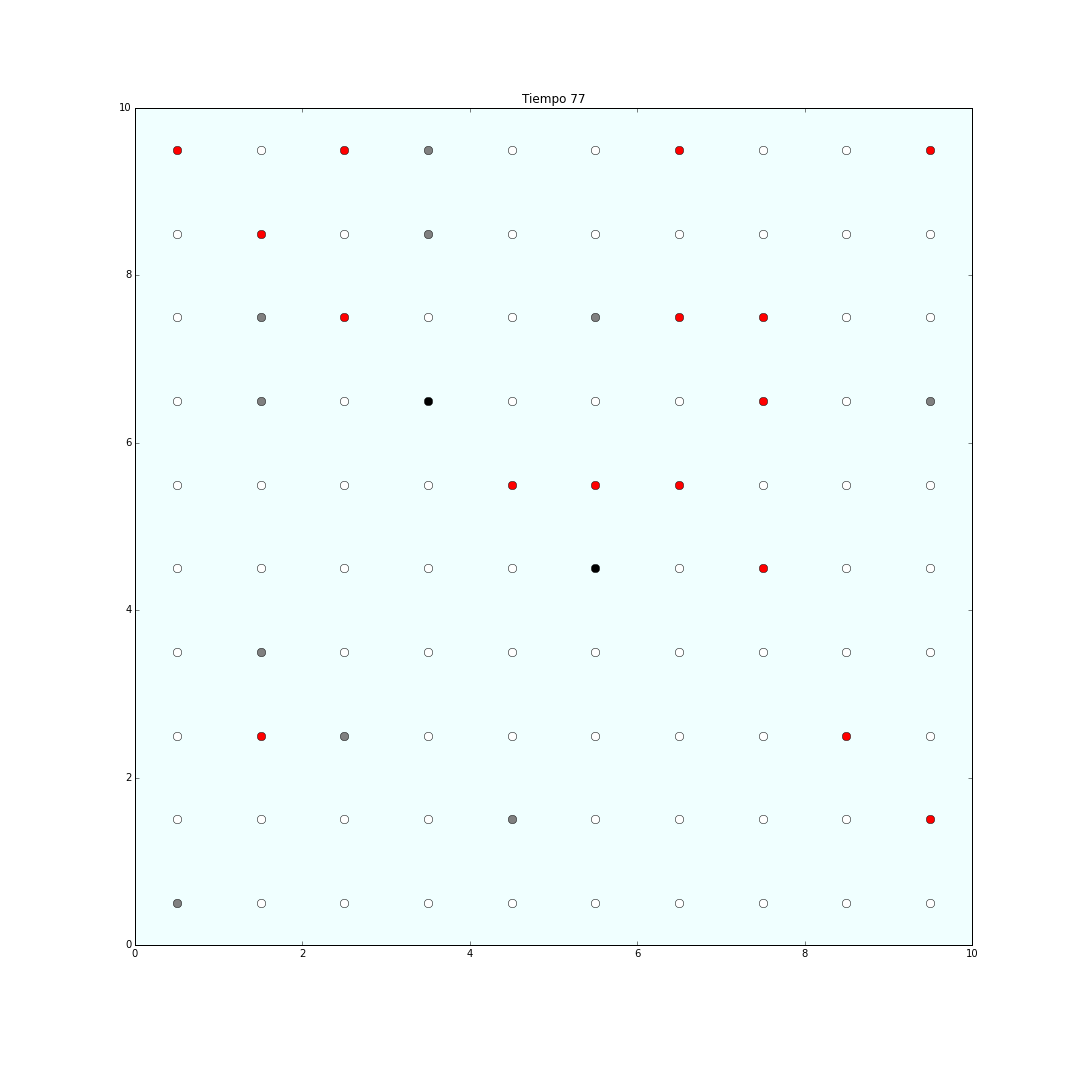
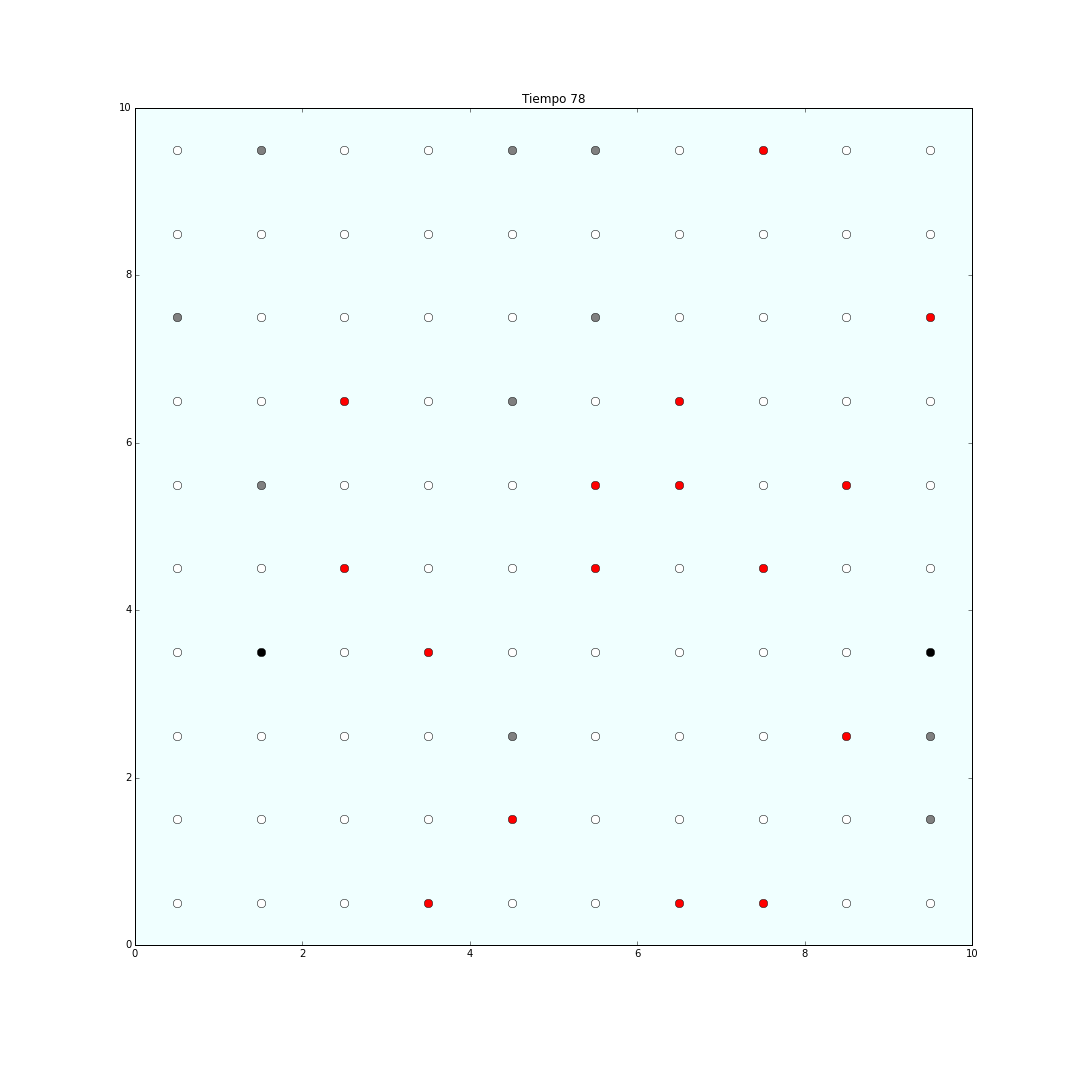
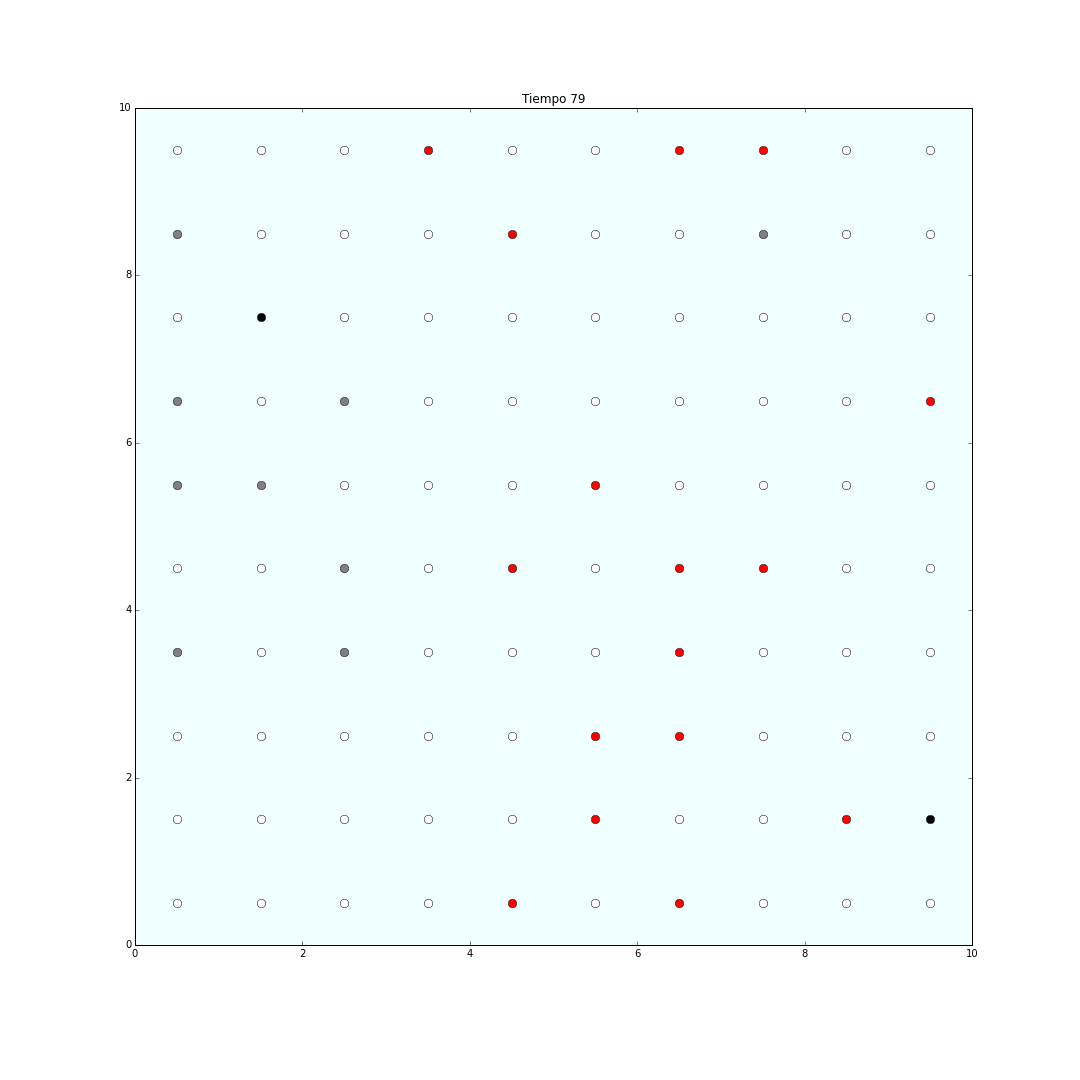
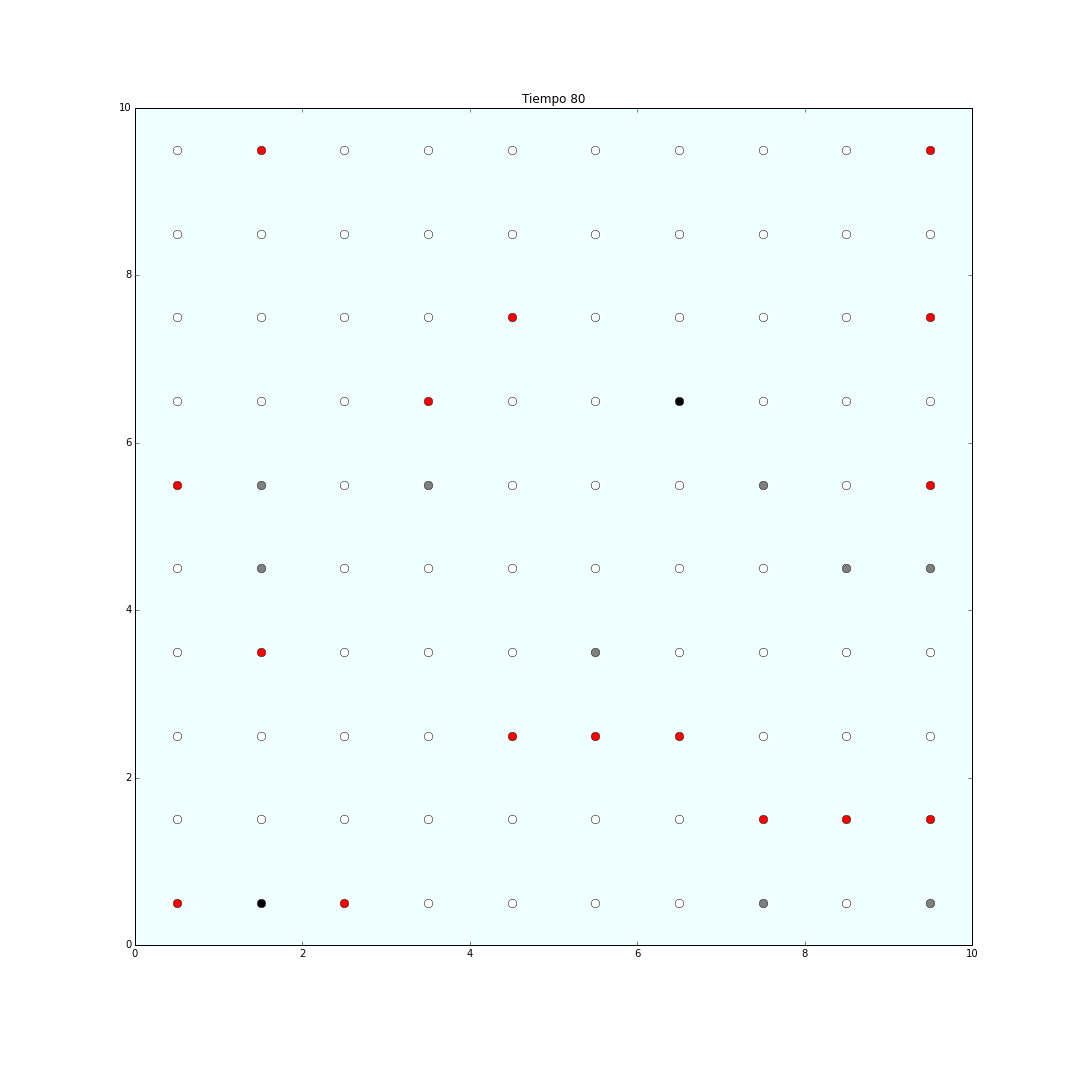
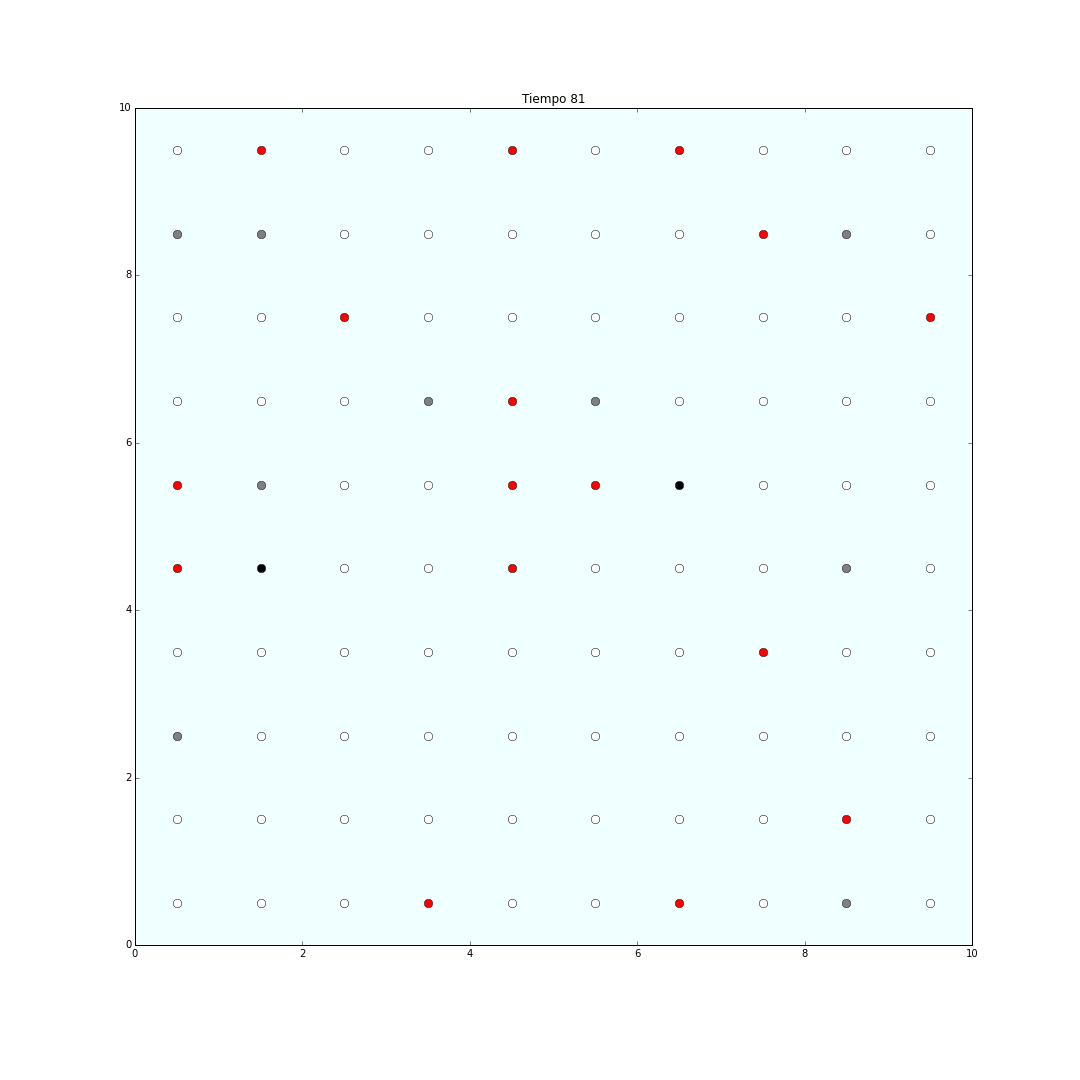
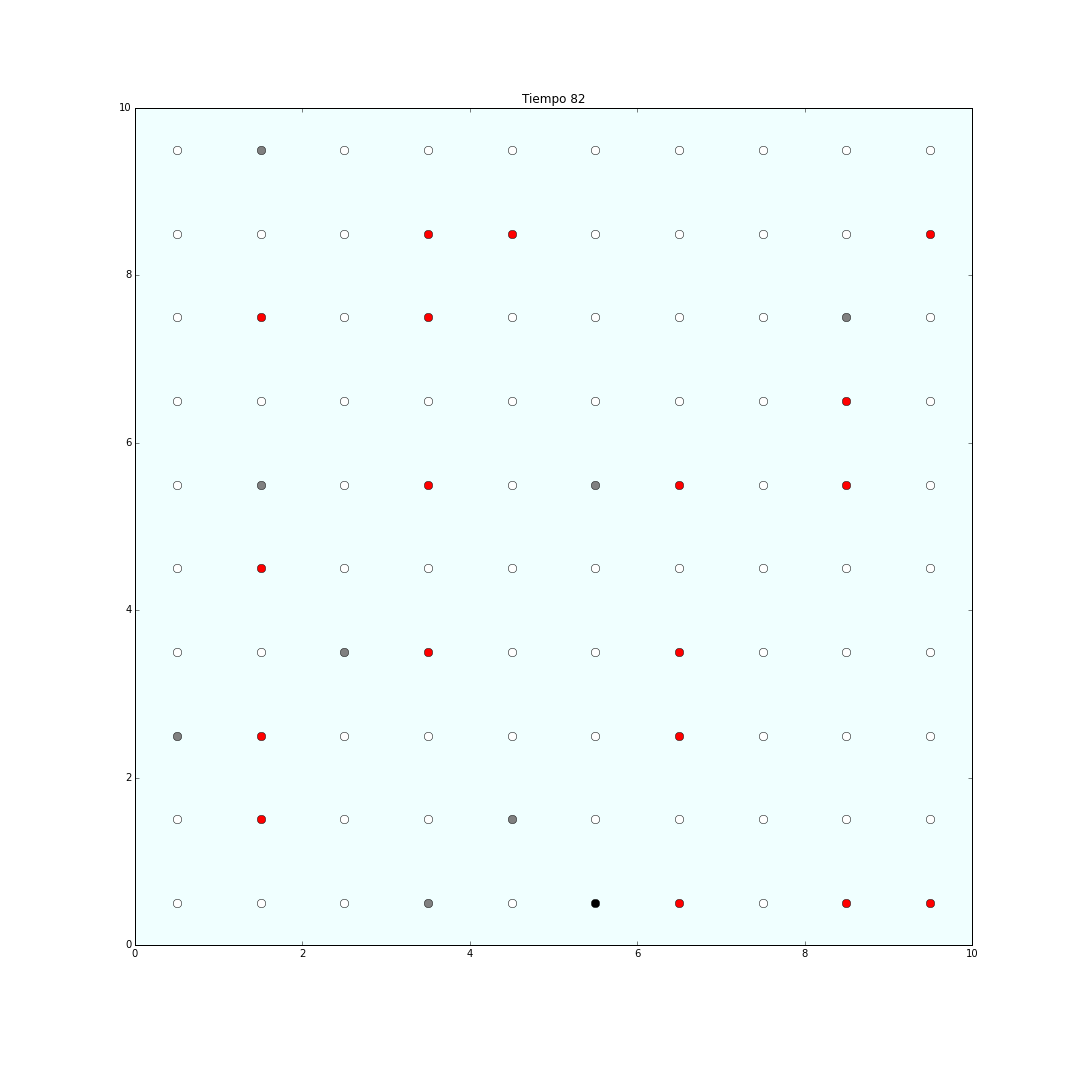
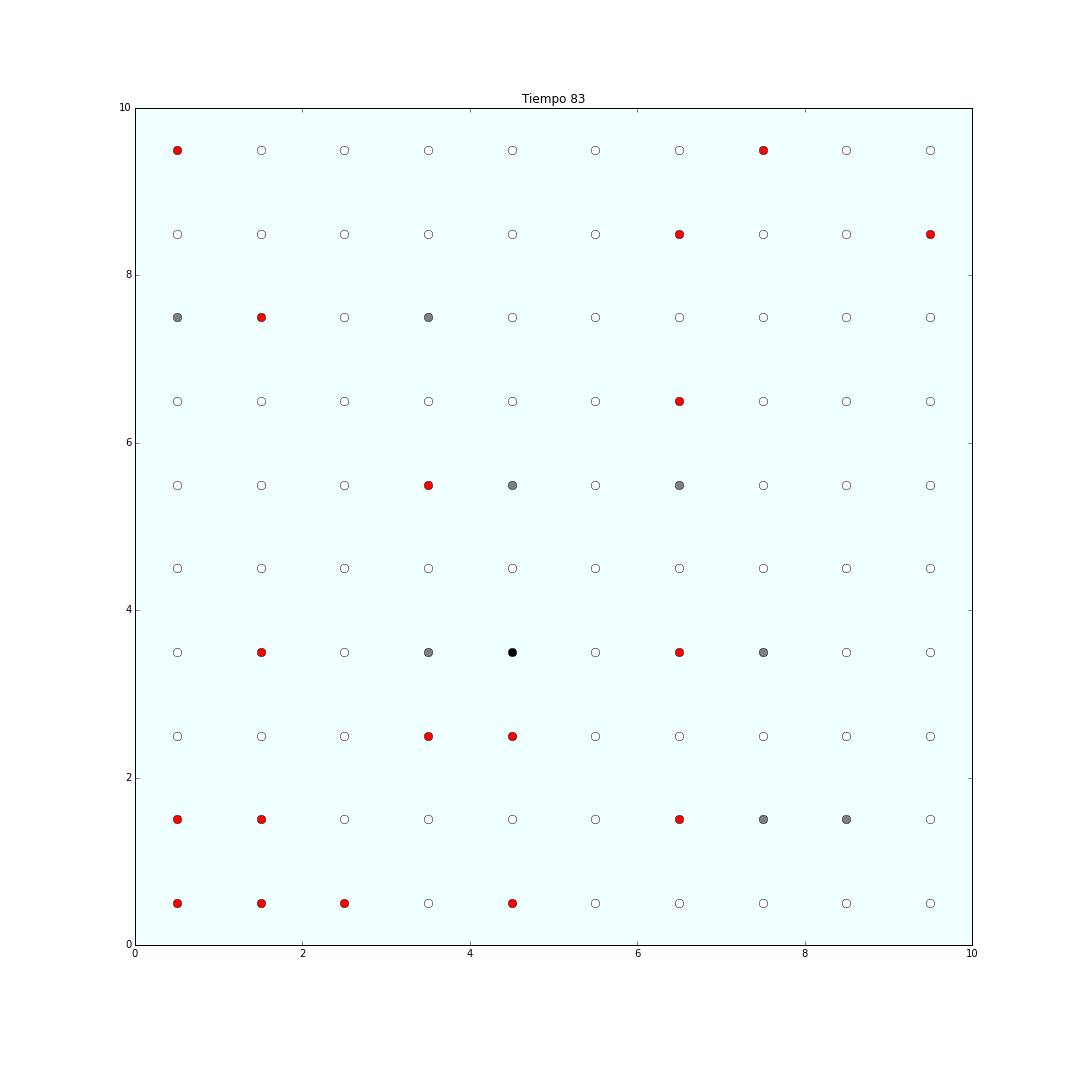
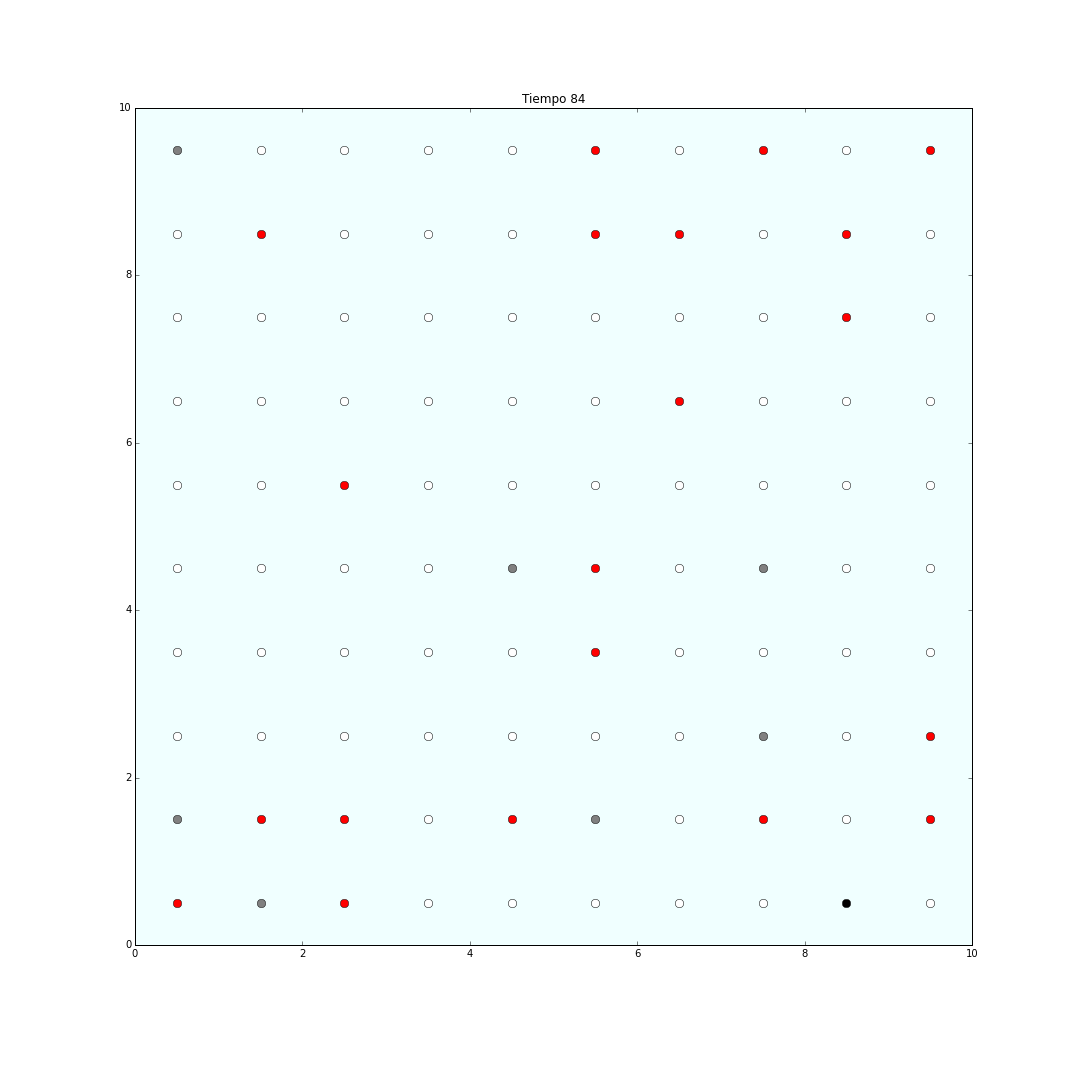
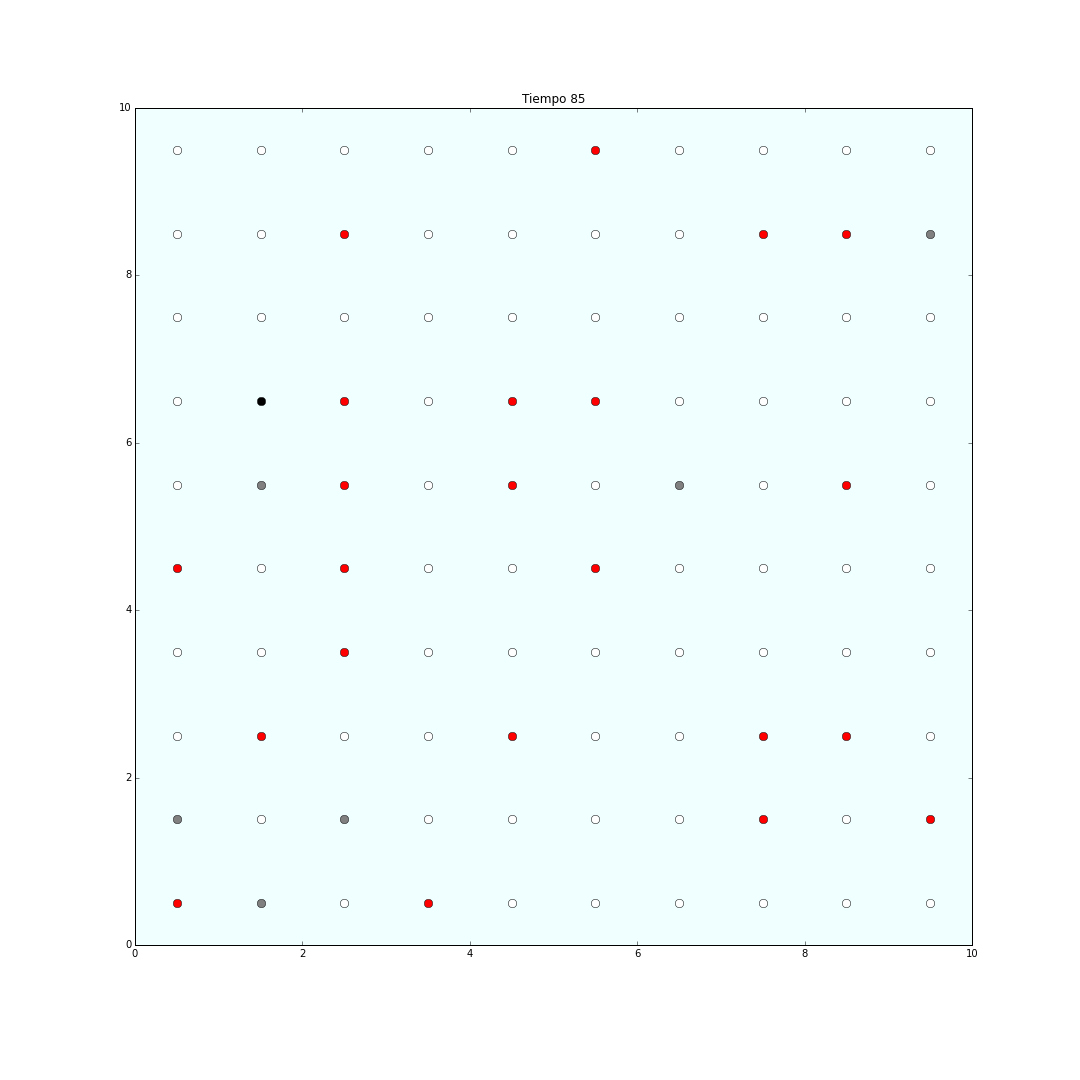
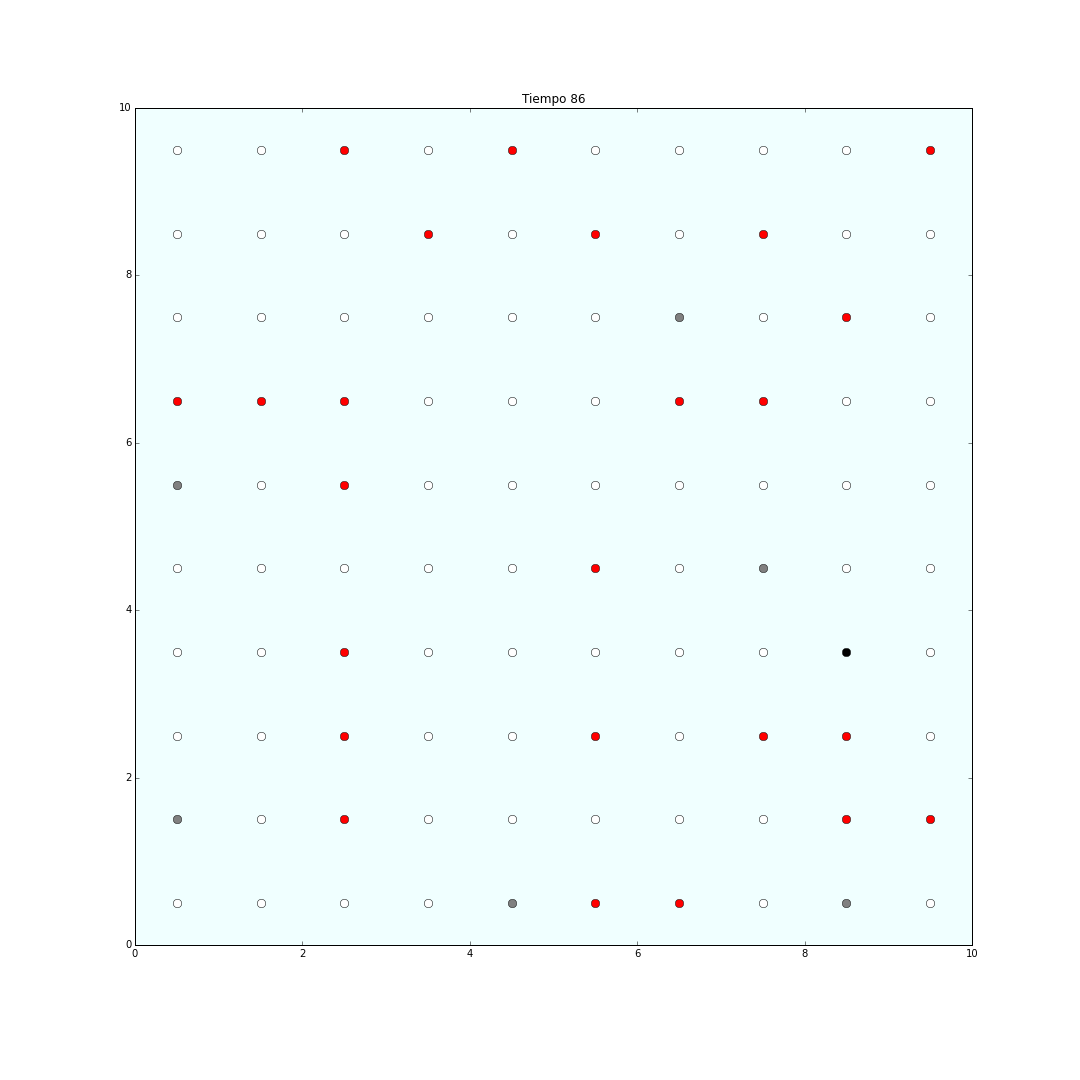
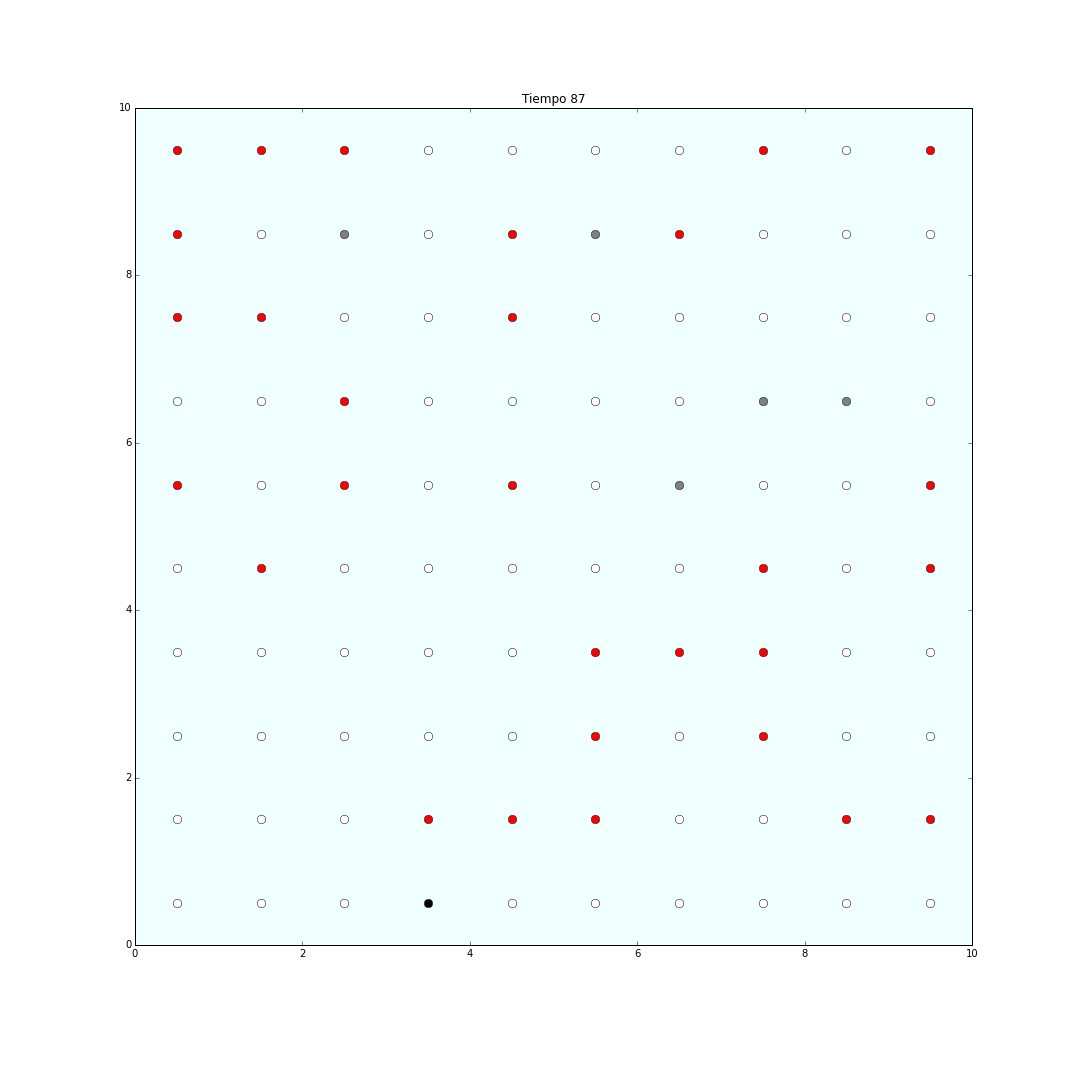
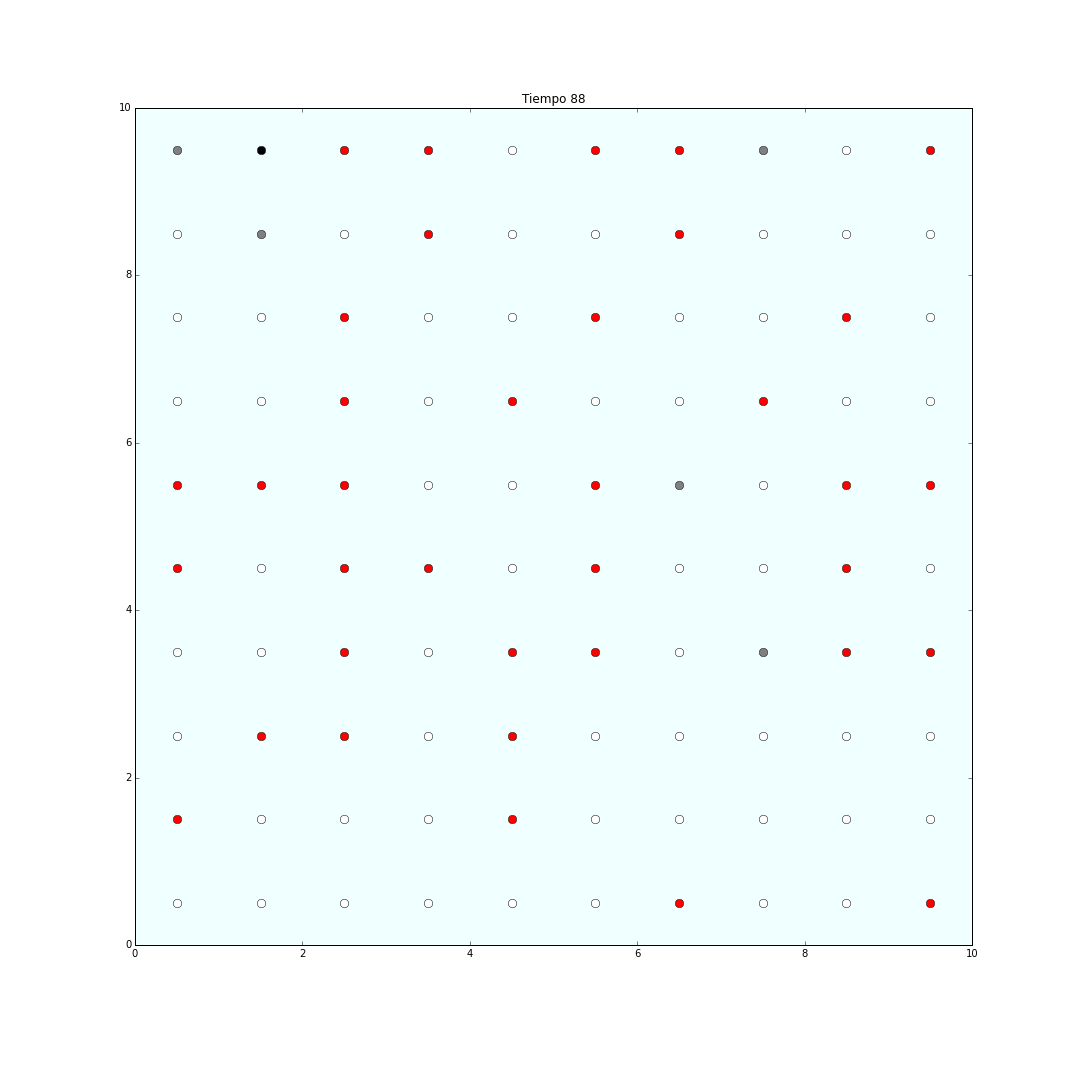
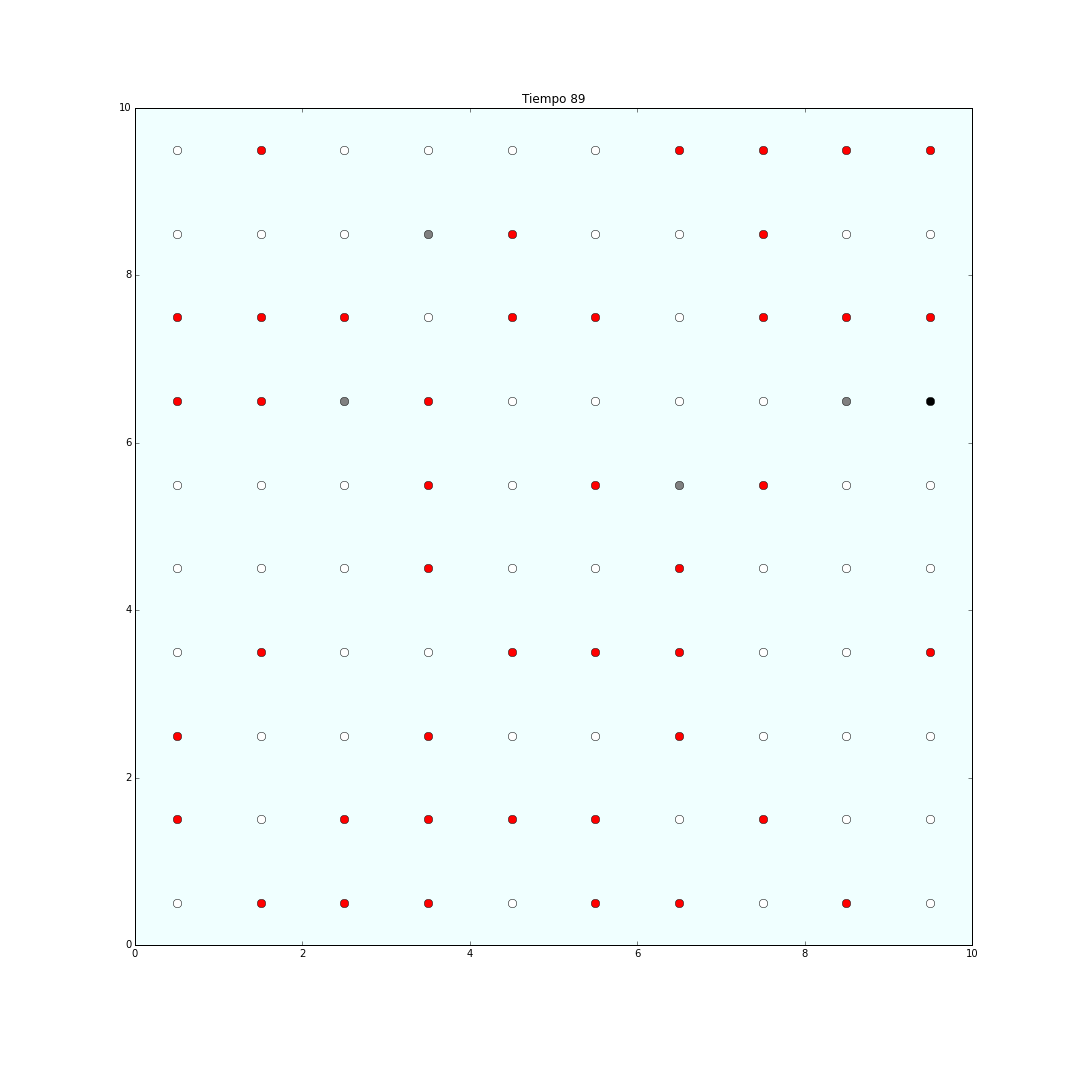
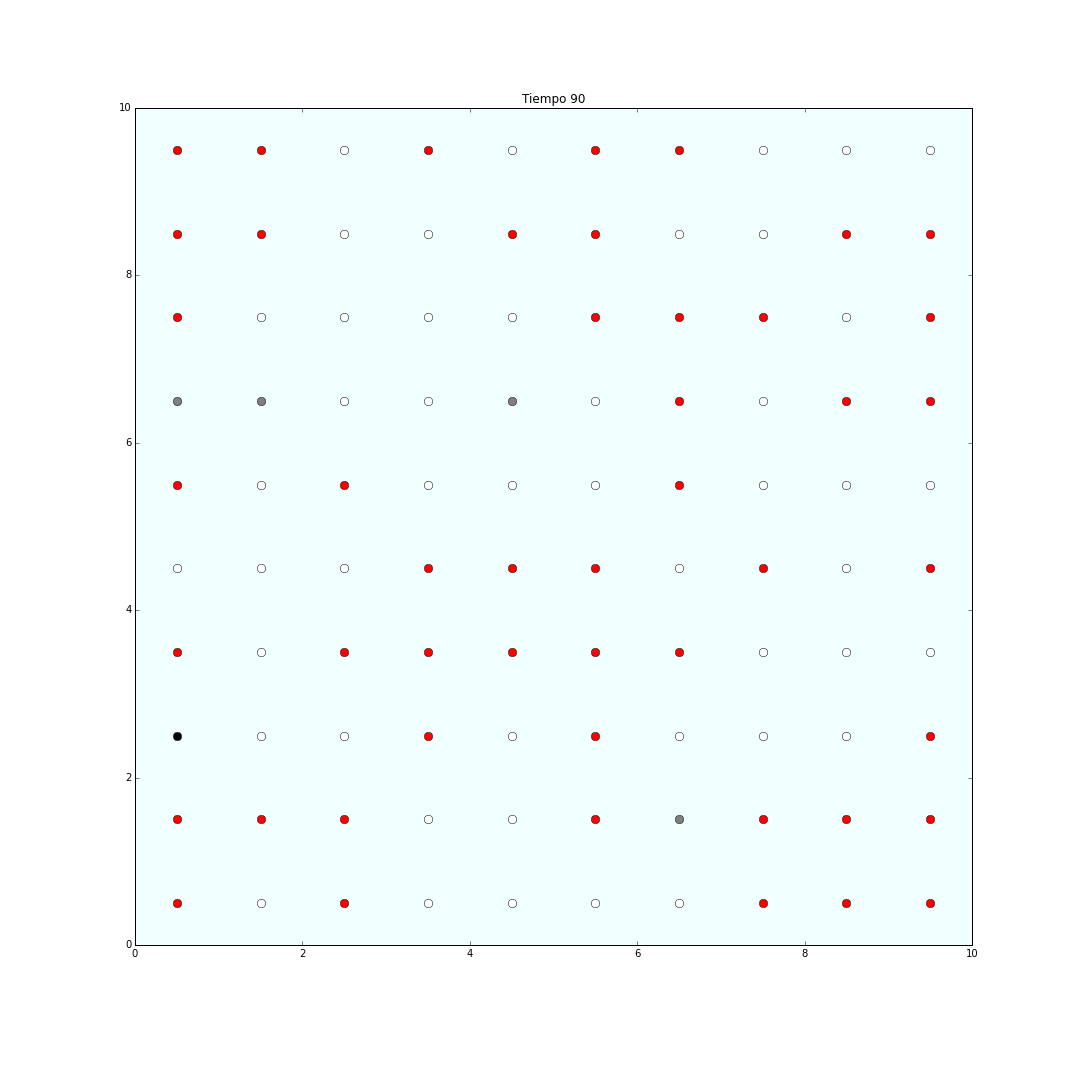
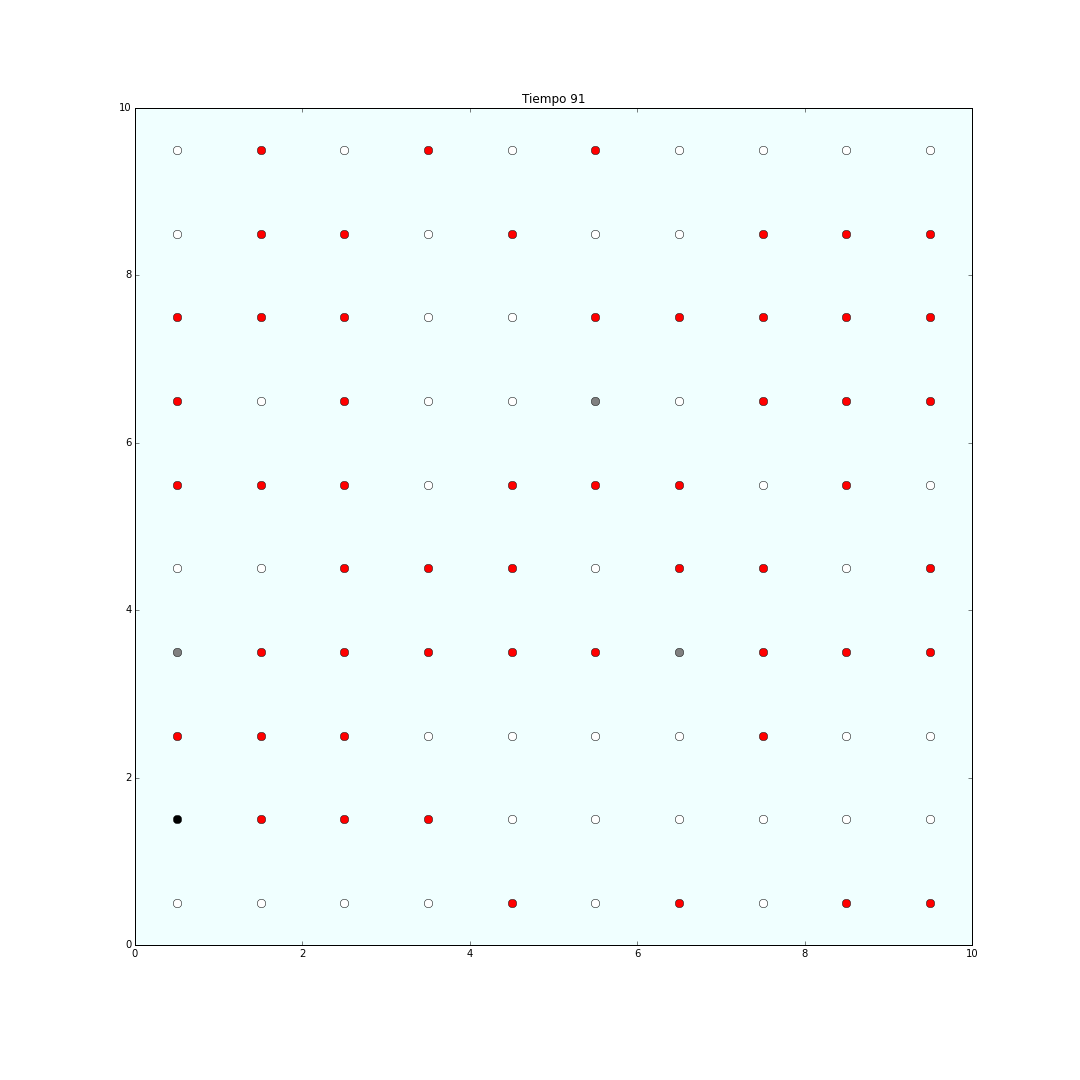
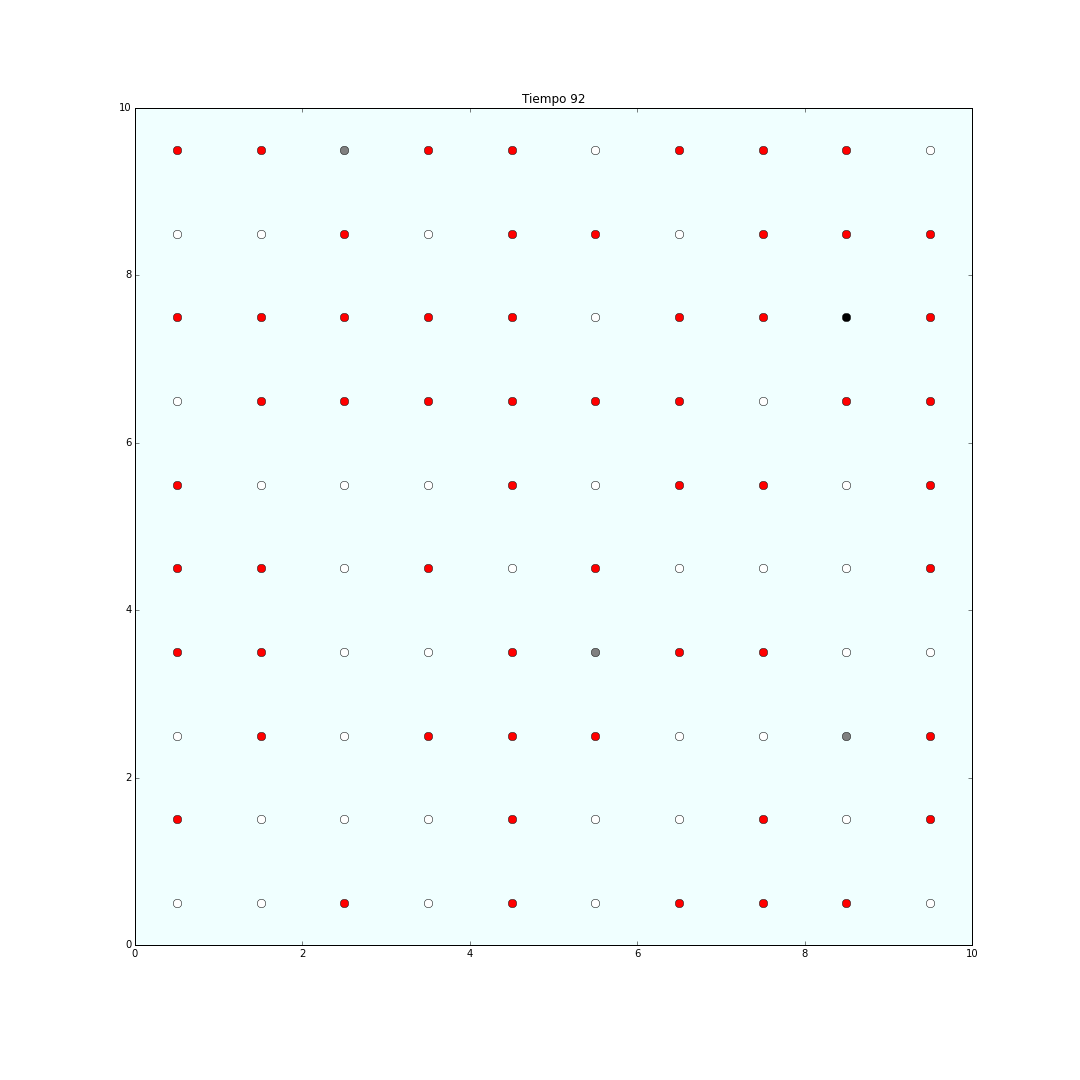
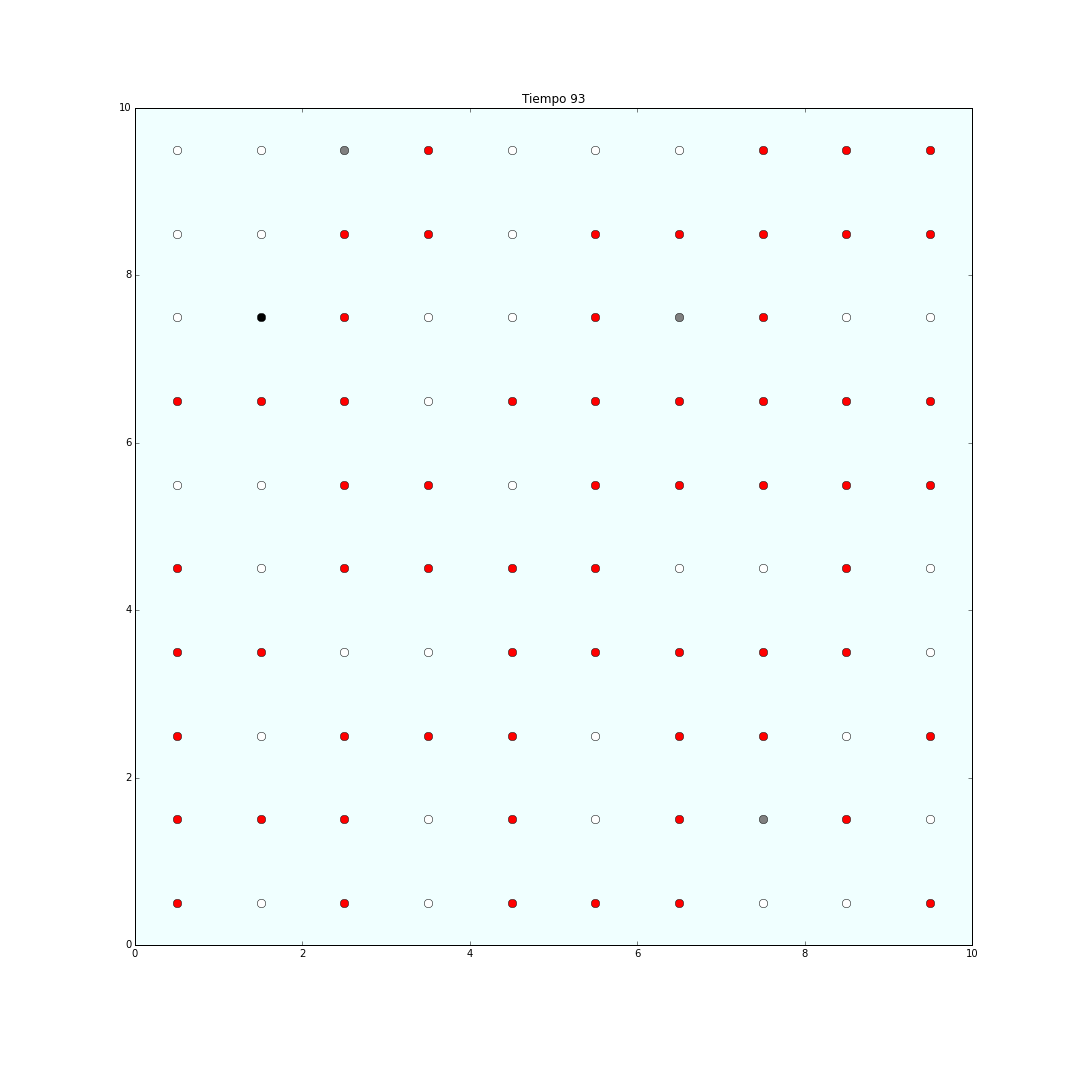
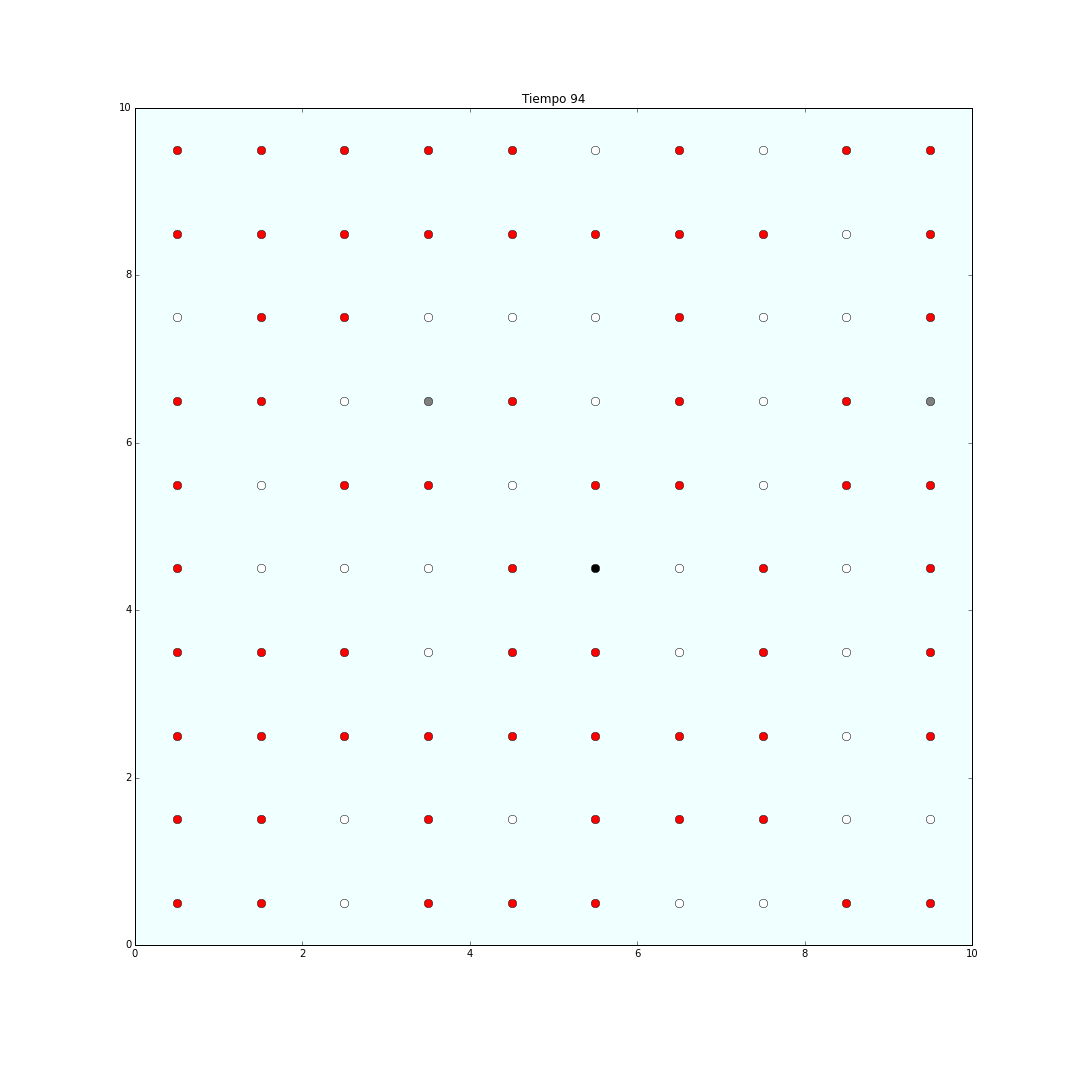
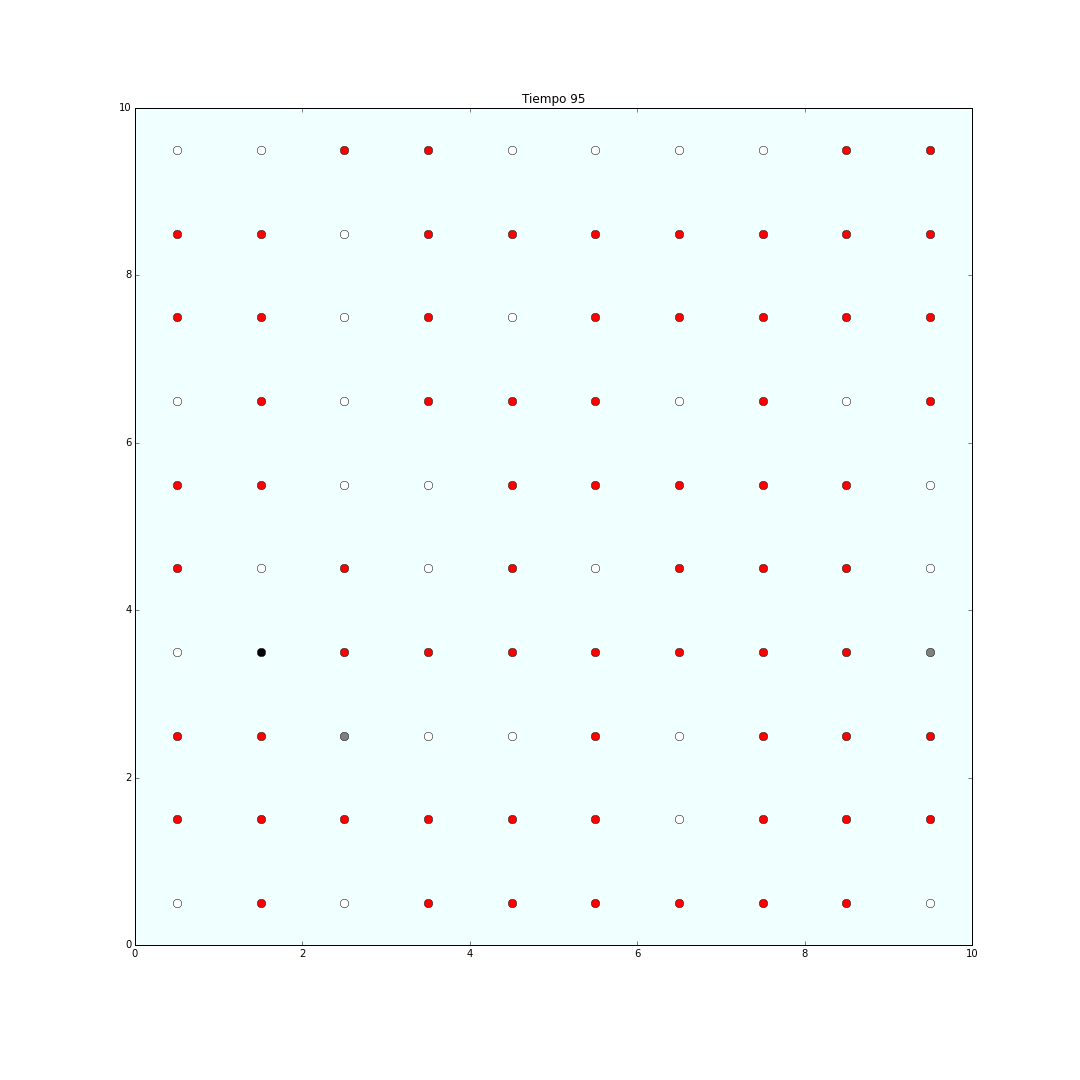
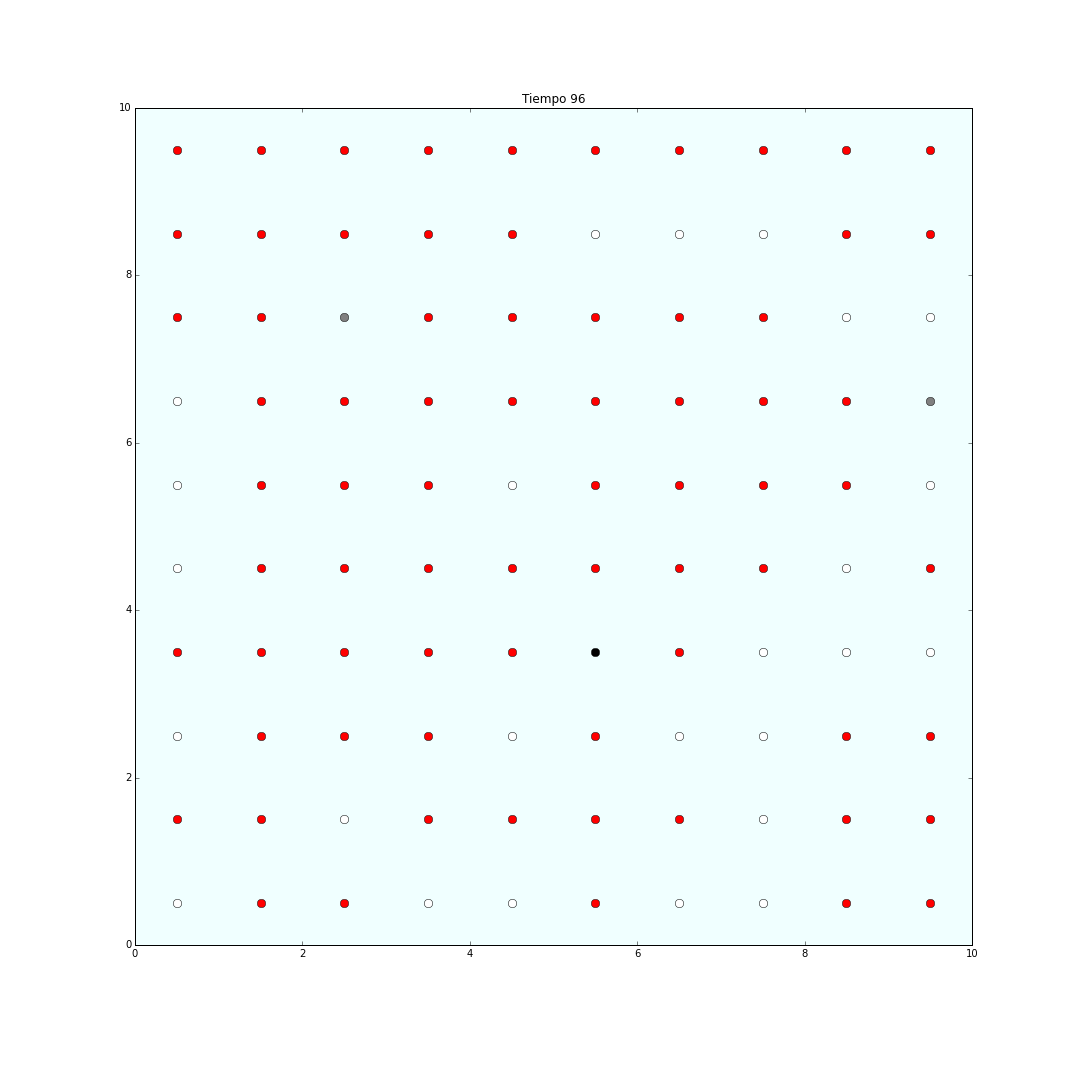
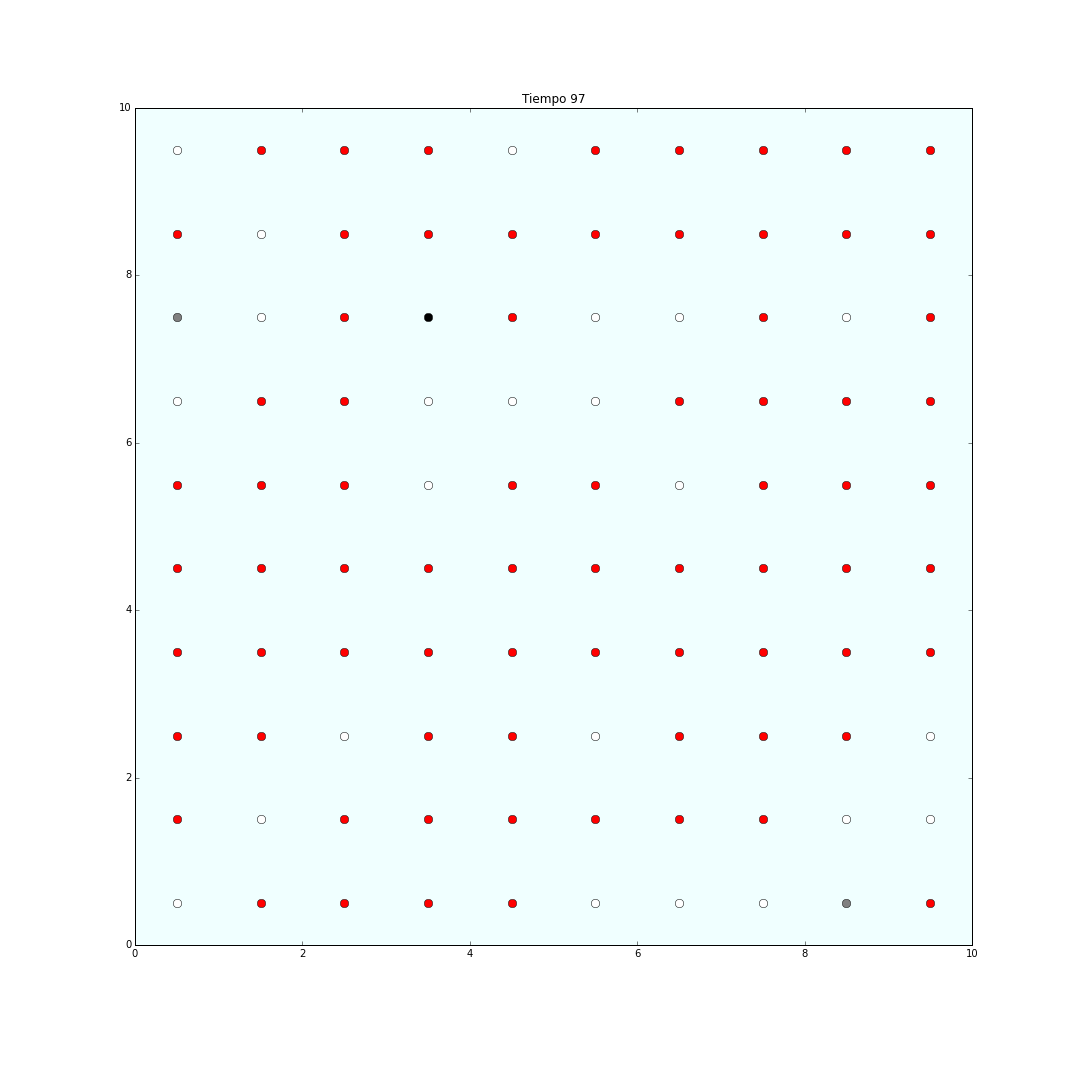
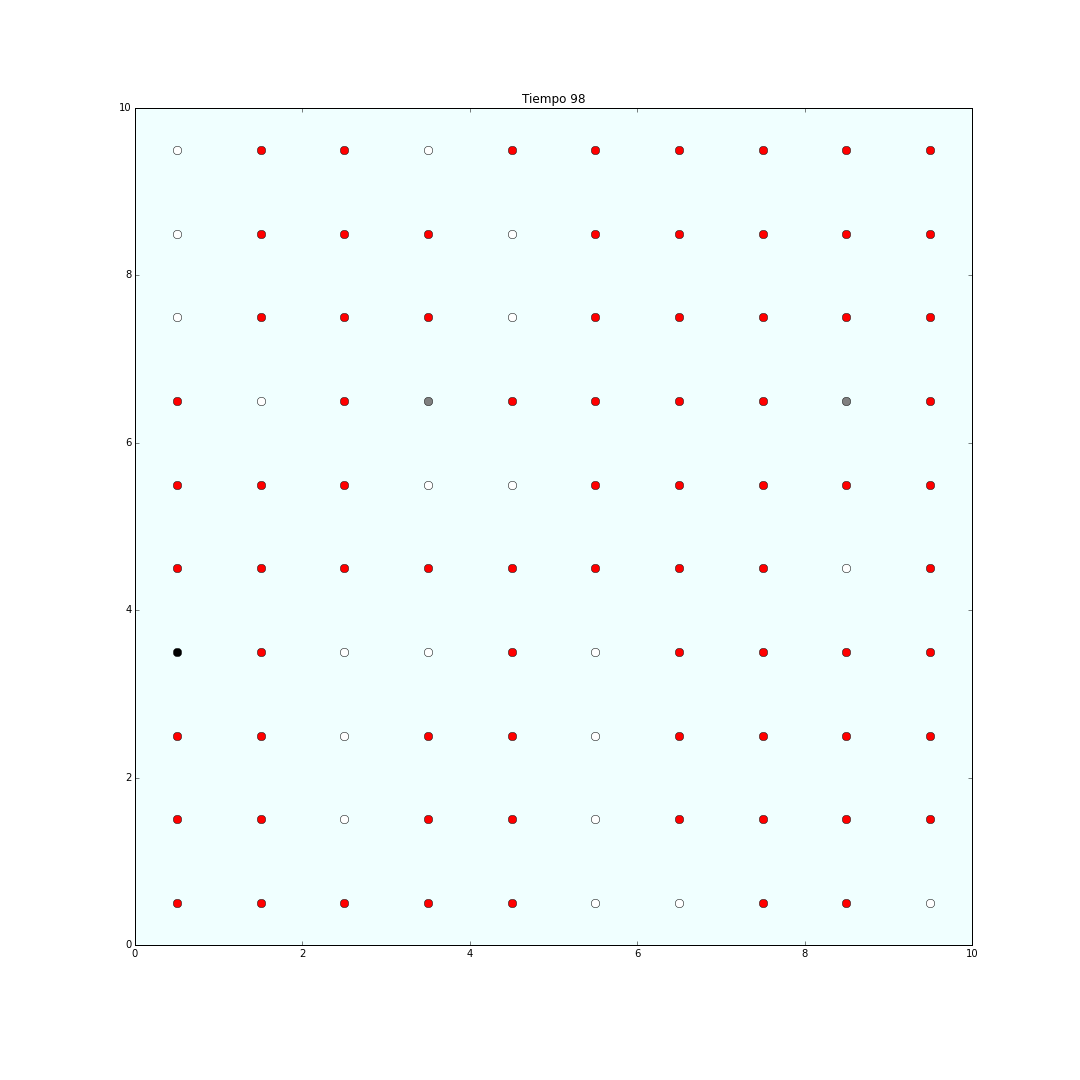
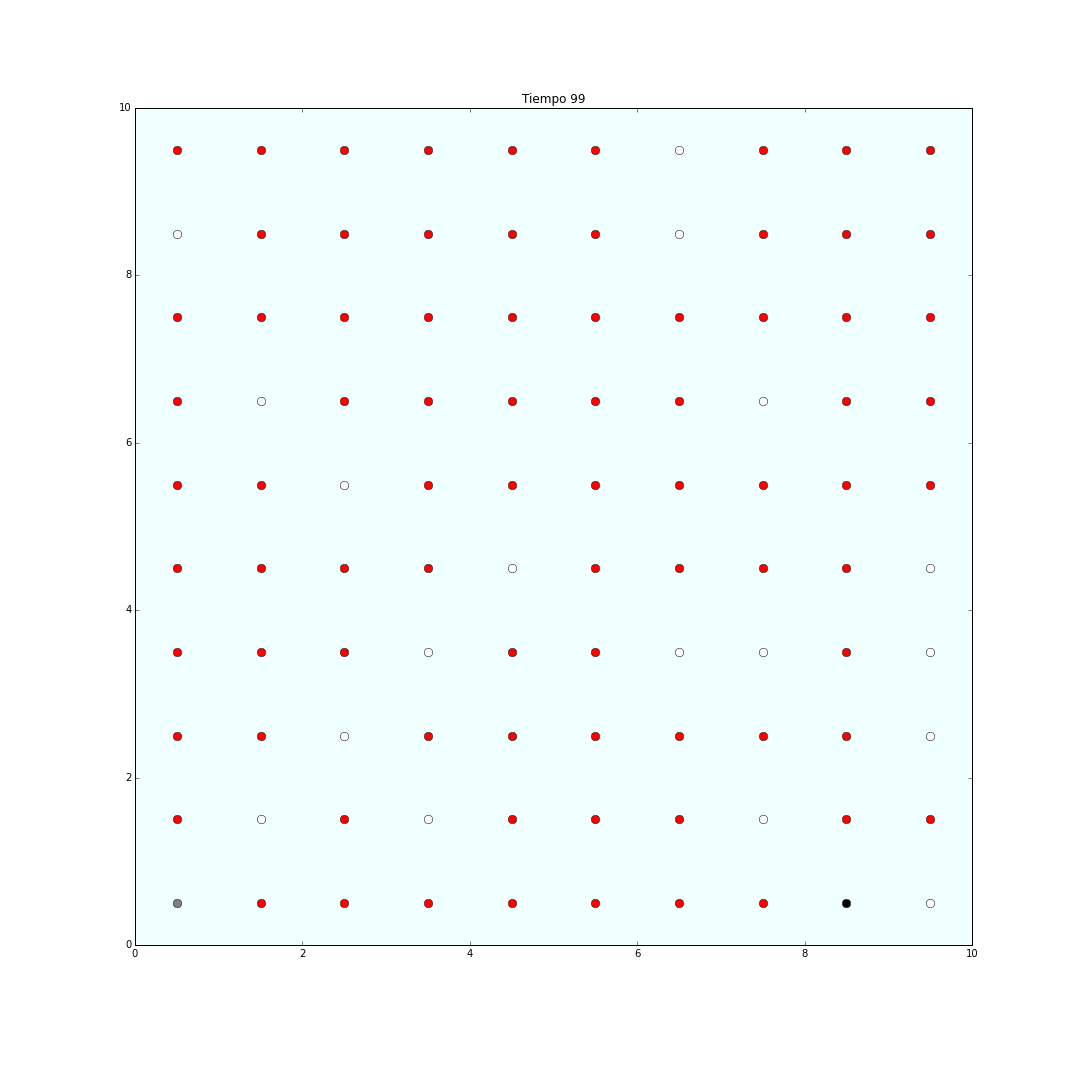

In [16]:
pos = obtener_posiciones_2(area_negra,area_blanca,area_gris,area_fertil,0)#Creo los agentes con las posiciones iniciales
agentes = [Agente(tipo=0,locacion = pos[0][i]) for i in range(len(pos[0]))]
agentes.extend(Agente(tipo=1,locacion= pos[1][i]) for i in range(len(pos[1])))
agentes.extend(Agente(tipo=2,locacion= pos[2][i]) for i in range(len(pos[2])))
agentes.extend(Agente(tipo=3,locacion= pos[3][i]) for i in range(len(pos[3])))
sin_chiste = Mundo2(agentes = agentes,ar_negra = area_negra,ar_blanca=area_blanca,ar_gris=area_gris,ar_fertil=area_fertil, steps = 100,metodo = 0)
sin_chiste.simular()